In [46]:
%config Completer.use_jedi = False

In [ ]:
We'll import the following libraries for this EDA:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sc
from sklearn.model_selection import train_test_split
import numpy as np
import ast
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [4]:
df = pd.read_csv('data.csv')
df.head()

valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   
2  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.328   
3                                   ['Frank Parker']         0.275   
4                                     ['Phil Regan']         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH          0.000028   
4       166693   0.193         0  4d6HGyGT8e121BsdKmw9v6          0.000002   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   
2    3     0.101   -14.850     1   
3    5     0.381    -9.316     1   
4    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo  
0       0.0366   80.954  
1       0.4150   60.936  
2       0.0339  110.339  
3       0.0354  100.109  
4       0.0380  101.665

Let's check the dataset for null values:

In [5]:
total_null_counts = np.sum(df.isnull())
null_columns = []
for column in total_null_counts.index:
    if not total_null_counts[column] == 0:
        null_columns.append(column)
if null_columns:
    print('We see that there are ',len(null_columns),' in this dataset')
else:
    print('We see that there are no null columns in this dataset')

We see that there are no null columns in this dataset


Let's start by looking at which genres are most represented within this dataset, by joining the track data file ('data.csv') with the artist and genre file ('data_w_genres.csv') using the artist as the join key:

In [15]:
df_genres = pd.read_csv('data_w_genres.csv')
merged_df = pd.merge(df,df_genres,on='artists')
merged_df.shape

(0, 34)

We see that simply joining on the 'artists' column doesn't work, and yields a dataframe with 0 rows. This is likely due to a mismatched type between the 'artists' column in df and the 'artists' column in df_genres:

In [5]:
df['artists'][0]

"['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']"

In [6]:
df_genres['artists'][0]

'"Cats" 1981 Original London Cast'

Although they're both of object type, we see that they are structured differently, with a list type contained within the string in df.
However, we assume that if we break the artist list in df out into its component artists, we should be able to find corresponding rows in df_genres:

In [58]:
df_genres[df_genres['artists'] == 'James Levine']

genres       artists  \
11305  ['classical performance', 'opera', 'orchestral...  James Levine   

       acousticness  danceability    duration_ms    energy  instrumentalness  \
11305      0.944056      0.264578  328057.111111  0.166089          0.446163   

       liveness  loudness  speechiness    tempo   valence  popularity  key  \
11305  0.232672  -19.4915     0.048306  102.657  0.165772   25.833333   10   

       mode  count  
11305     1     18

What is the range for the possible count of artists a track can have? We need this to decide how we will model our data to be able to make the join:

In [7]:
artist_count = []
for i in df['artists'].index:
    artist_count.append(len(ast.literal_eval(df['artists'][i])))

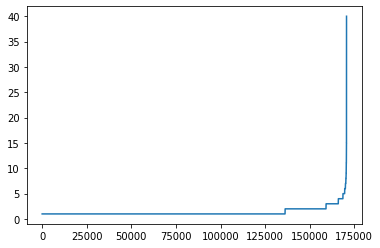

In [8]:
artist_count.sort()
fig, ax = plt.subplots()
ax.plot(artist_count)

In [105]:
stats.describe(artist_count)

DescribeResult(nobs=170653, minmax=(1, 40), mean=1.3272371420367646, variance=0.7778272099951885, skewness=6.324286654122511, kurtosis=91.29684312705018)

In [109]:
p = np.percentile(artist_count,99)
p

5.0

From the above, we see that:
- Songs in this dataset have a maximum of 40 artists
- The dataset has a mean of 1.32 with a low variance of 0.77
- There are just a few outliers with more than 5 artists - 99% of tracks have less than 5 artists

Based on this, we will add 5 columns for potential artists. For the 1% of outliers with more than 5 artists, we will simply select the first 5 artists in the 'artists' column.

Note: the function below takes a long time to run, might be possible to refactor for a later version of this EDA.

In [6]:
# we might want to refactor this as a function
# this function is really slow! will take about 10 mins to run
artists_expanded = pd.DataFrame(columns=['artist_1','artist_2','artist_3','artist_4','artist_5'])
for i in range(df.shape[0]):
    print('adding track number ',i)
    track_artists = df['artists'].iloc[i]
    track_artists_expanded = ast.literal_eval(track_artists)
    data = []
    values = []
    for i in range(5):
        #column_name = 'artist_' + str(i)
        try:
            values.append(track_artists_expanded[i])
            #artists_expanded[column_name][i] = track_artists_expanded[i]
            #print('appending',track_artists_expanded[i])
        except:
            values.append("")
            #print('appending empty row')
        zipped = zip(artists_expanded.columns,values)
        artists_dict = dict(zipped)
    artists_expanded = artists_expanded.append(artists_dict,True)

adding track number  0
adding track number  1
adding track number  2
adding track number  3
adding track number  4
adding track number  5
adding track number  6
adding track number  7
adding track number  8
adding track number  9
adding track number  10
adding track number  11
adding track number  12
adding track number  13
adding track number  14
adding track number  15
adding track number  16
adding track number  17
adding track number  18
adding track number  19
adding track number  20
adding track number  21
adding track number  22
adding track number  23
adding track number  24
adding track number  25
adding track number  26
adding track number  27
adding track number  28
adding track number  29
adding track number  30
adding track number  31
adding track number  32
adding track number  33
adding track number  34
adding track number  35
adding track number  36
adding track number  37
adding track number  38
adding track number  39
adding track number  40
adding track number  41
ad

adding track number  370
adding track number  371
adding track number  372
adding track number  373
adding track number  374
adding track number  375
adding track number  376
adding track number  377
adding track number  378
adding track number  379
adding track number  380
adding track number  381
adding track number  382
adding track number  383
adding track number  384
adding track number  385
adding track number  386
adding track number  387
adding track number  388
adding track number  389
adding track number  390
adding track number  391
adding track number  392
adding track number  393
adding track number  394
adding track number  395
adding track number  396
adding track number  397
adding track number  398
adding track number  399
adding track number  400
adding track number  401
adding track number  402
adding track number  403
adding track number  404
adding track number  405
adding track number  406
adding track number  407
adding track number  408
adding track number  409


adding track number  729
adding track number  730
adding track number  731
adding track number  732
adding track number  733
adding track number  734
adding track number  735
adding track number  736
adding track number  737
adding track number  738
adding track number  739
adding track number  740
adding track number  741
adding track number  742
adding track number  743
adding track number  744
adding track number  745
adding track number  746
adding track number  747
adding track number  748
adding track number  749
adding track number  750
adding track number  751
adding track number  752
adding track number  753
adding track number  754
adding track number  755
adding track number  756
adding track number  757
adding track number  758
adding track number  759
adding track number  760
adding track number  761
adding track number  762
adding track number  763
adding track number  764
adding track number  765
adding track number  766
adding track number  767
adding track number  768


adding track number  1062
adding track number  1063
adding track number  1064
adding track number  1065
adding track number  1066
adding track number  1067
adding track number  1068
adding track number  1069
adding track number  1070
adding track number  1071
adding track number  1072
adding track number  1073
adding track number  1074
adding track number  1075
adding track number  1076
adding track number  1077
adding track number  1078
adding track number  1079
adding track number  1080
adding track number  1081
adding track number  1082
adding track number  1083
adding track number  1084
adding track number  1085
adding track number  1086
adding track number  1087
adding track number  1088
adding track number  1089
adding track number  1090
adding track number  1091
adding track number  1092
adding track number  1093
adding track number  1094
adding track number  1095
adding track number  1096
adding track number  1097
adding track number  1098
adding track number  1099
adding track

adding track number  1394
adding track number  1395
adding track number  1396
adding track number  1397
adding track number  1398
adding track number  1399
adding track number  1400
adding track number  1401
adding track number  1402
adding track number  1403
adding track number  1404
adding track number  1405
adding track number  1406
adding track number  1407
adding track number  1408
adding track number  1409
adding track number  1410
adding track number  1411
adding track number  1412
adding track number  1413
adding track number  1414
adding track number  1415
adding track number  1416
adding track number  1417
adding track number  1418
adding track number  1419
adding track number  1420
adding track number  1421
adding track number  1422
adding track number  1423
adding track number  1424
adding track number  1425
adding track number  1426
adding track number  1427
adding track number  1428
adding track number  1429
adding track number  1430
adding track number  1431
adding track

adding track number  1715
adding track number  1716
adding track number  1717
adding track number  1718
adding track number  1719
adding track number  1720
adding track number  1721
adding track number  1722
adding track number  1723
adding track number  1724
adding track number  1725
adding track number  1726
adding track number  1727
adding track number  1728
adding track number  1729
adding track number  1730
adding track number  1731
adding track number  1732
adding track number  1733
adding track number  1734
adding track number  1735
adding track number  1736
adding track number  1737
adding track number  1738
adding track number  1739
adding track number  1740
adding track number  1741
adding track number  1742
adding track number  1743
adding track number  1744
adding track number  1745
adding track number  1746
adding track number  1747
adding track number  1748
adding track number  1749
adding track number  1750
adding track number  1751
adding track number  1752
adding track

adding track number  2067
adding track number  2068
adding track number  2069
adding track number  2070
adding track number  2071
adding track number  2072
adding track number  2073
adding track number  2074
adding track number  2075
adding track number  2076
adding track number  2077
adding track number  2078
adding track number  2079
adding track number  2080
adding track number  2081
adding track number  2082
adding track number  2083
adding track number  2084
adding track number  2085
adding track number  2086
adding track number  2087
adding track number  2088
adding track number  2089
adding track number  2090
adding track number  2091
adding track number  2092
adding track number  2093
adding track number  2094
adding track number  2095
adding track number  2096
adding track number  2097
adding track number  2098
adding track number  2099
adding track number  2100
adding track number  2101
adding track number  2102
adding track number  2103
adding track number  2104
adding track

adding track number  2396
adding track number  2397
adding track number  2398
adding track number  2399
adding track number  2400
adding track number  2401
adding track number  2402
adding track number  2403
adding track number  2404
adding track number  2405
adding track number  2406
adding track number  2407
adding track number  2408
adding track number  2409
adding track number  2410
adding track number  2411
adding track number  2412
adding track number  2413
adding track number  2414
adding track number  2415
adding track number  2416
adding track number  2417
adding track number  2418
adding track number  2419
adding track number  2420
adding track number  2421
adding track number  2422
adding track number  2423
adding track number  2424
adding track number  2425
adding track number  2426
adding track number  2427
adding track number  2428
adding track number  2429
adding track number  2430
adding track number  2431
adding track number  2432
adding track number  2433
adding track

adding track number  2730
adding track number  2731
adding track number  2732
adding track number  2733
adding track number  2734
adding track number  2735
adding track number  2736
adding track number  2737
adding track number  2738
adding track number  2739
adding track number  2740
adding track number  2741
adding track number  2742
adding track number  2743
adding track number  2744
adding track number  2745
adding track number  2746
adding track number  2747
adding track number  2748
adding track number  2749
adding track number  2750
adding track number  2751
adding track number  2752
adding track number  2753
adding track number  2754
adding track number  2755
adding track number  2756
adding track number  2757
adding track number  2758
adding track number  2759
adding track number  2760
adding track number  2761
adding track number  2762
adding track number  2763
adding track number  2764
adding track number  2765
adding track number  2766
adding track number  2767
adding track

adding track number  3096
adding track number  3097
adding track number  3098
adding track number  3099
adding track number  3100
adding track number  3101
adding track number  3102
adding track number  3103
adding track number  3104
adding track number  3105
adding track number  3106
adding track number  3107
adding track number  3108
adding track number  3109
adding track number  3110
adding track number  3111
adding track number  3112
adding track number  3113
adding track number  3114
adding track number  3115
adding track number  3116
adding track number  3117
adding track number  3118
adding track number  3119
adding track number  3120
adding track number  3121
adding track number  3122
adding track number  3123
adding track number  3124
adding track number  3125
adding track number  3126
adding track number  3127
adding track number  3128
adding track number  3129
adding track number  3130
adding track number  3131
adding track number  3132
adding track number  3133
adding track

adding track number  3423
adding track number  3424
adding track number  3425
adding track number  3426
adding track number  3427
adding track number  3428
adding track number  3429
adding track number  3430
adding track number  3431
adding track number  3432
adding track number  3433
adding track number  3434
adding track number  3435
adding track number  3436
adding track number  3437
adding track number  3438
adding track number  3439
adding track number  3440
adding track number  3441
adding track number  3442
adding track number  3443
adding track number  3444
adding track number  3445
adding track number  3446
adding track number  3447
adding track number  3448
adding track number  3449
adding track number  3450
adding track number  3451
adding track number  3452
adding track number  3453
adding track number  3454
adding track number  3455
adding track number  3456
adding track number  3457
adding track number  3458
adding track number  3459
adding track number  3460
adding track

adding track number  3757
adding track number  3758
adding track number  3759
adding track number  3760
adding track number  3761
adding track number  3762
adding track number  3763
adding track number  3764
adding track number  3765
adding track number  3766
adding track number  3767
adding track number  3768
adding track number  3769
adding track number  3770
adding track number  3771
adding track number  3772
adding track number  3773
adding track number  3774
adding track number  3775
adding track number  3776
adding track number  3777
adding track number  3778
adding track number  3779
adding track number  3780
adding track number  3781
adding track number  3782
adding track number  3783
adding track number  3784
adding track number  3785
adding track number  3786
adding track number  3787
adding track number  3788
adding track number  3789
adding track number  3790
adding track number  3791
adding track number  3792
adding track number  3793
adding track number  3794
adding track

adding track number  4077
adding track number  4078
adding track number  4079
adding track number  4080
adding track number  4081
adding track number  4082
adding track number  4083
adding track number  4084
adding track number  4085
adding track number  4086
adding track number  4087
adding track number  4088
adding track number  4089
adding track number  4090
adding track number  4091
adding track number  4092
adding track number  4093
adding track number  4094
adding track number  4095
adding track number  4096
adding track number  4097
adding track number  4098
adding track number  4099
adding track number  4100
adding track number  4101
adding track number  4102
adding track number  4103
adding track number  4104
adding track number  4105
adding track number  4106
adding track number  4107
adding track number  4108
adding track number  4109
adding track number  4110
adding track number  4111
adding track number  4112
adding track number  4113
adding track number  4114
adding track

adding track number  4420
adding track number  4421
adding track number  4422
adding track number  4423
adding track number  4424
adding track number  4425
adding track number  4426
adding track number  4427
adding track number  4428
adding track number  4429
adding track number  4430
adding track number  4431
adding track number  4432
adding track number  4433
adding track number  4434
adding track number  4435
adding track number  4436
adding track number  4437
adding track number  4438
adding track number  4439
adding track number  4440
adding track number  4441
adding track number  4442
adding track number  4443
adding track number  4444
adding track number  4445
adding track number  4446
adding track number  4447
adding track number  4448
adding track number  4449
adding track number  4450
adding track number  4451
adding track number  4452
adding track number  4453
adding track number  4454
adding track number  4455
adding track number  4456
adding track number  4457
adding track

adding track number  4736
adding track number  4737
adding track number  4738
adding track number  4739
adding track number  4740
adding track number  4741
adding track number  4742
adding track number  4743
adding track number  4744
adding track number  4745
adding track number  4746
adding track number  4747
adding track number  4748
adding track number  4749
adding track number  4750
adding track number  4751
adding track number  4752
adding track number  4753
adding track number  4754
adding track number  4755
adding track number  4756
adding track number  4757
adding track number  4758
adding track number  4759
adding track number  4760
adding track number  4761
adding track number  4762
adding track number  4763
adding track number  4764
adding track number  4765
adding track number  4766
adding track number  4767
adding track number  4768
adding track number  4769
adding track number  4770
adding track number  4771
adding track number  4772
adding track number  4773
adding track

adding track number  5067
adding track number  5068
adding track number  5069
adding track number  5070
adding track number  5071
adding track number  5072
adding track number  5073
adding track number  5074
adding track number  5075
adding track number  5076
adding track number  5077
adding track number  5078
adding track number  5079
adding track number  5080
adding track number  5081
adding track number  5082
adding track number  5083
adding track number  5084
adding track number  5085
adding track number  5086
adding track number  5087
adding track number  5088
adding track number  5089
adding track number  5090
adding track number  5091
adding track number  5092
adding track number  5093
adding track number  5094
adding track number  5095
adding track number  5096
adding track number  5097
adding track number  5098
adding track number  5099
adding track number  5100
adding track number  5101
adding track number  5102
adding track number  5103
adding track number  5104
adding track

adding track number  5402
adding track number  5403
adding track number  5404
adding track number  5405
adding track number  5406
adding track number  5407
adding track number  5408
adding track number  5409
adding track number  5410
adding track number  5411
adding track number  5412
adding track number  5413
adding track number  5414
adding track number  5415
adding track number  5416
adding track number  5417
adding track number  5418
adding track number  5419
adding track number  5420
adding track number  5421
adding track number  5422
adding track number  5423
adding track number  5424
adding track number  5425
adding track number  5426
adding track number  5427
adding track number  5428
adding track number  5429
adding track number  5430
adding track number  5431
adding track number  5432
adding track number  5433
adding track number  5434
adding track number  5435
adding track number  5436
adding track number  5437
adding track number  5438
adding track number  5439
adding track

adding track number  5760
adding track number  5761
adding track number  5762
adding track number  5763
adding track number  5764
adding track number  5765
adding track number  5766
adding track number  5767
adding track number  5768
adding track number  5769
adding track number  5770
adding track number  5771
adding track number  5772
adding track number  5773
adding track number  5774
adding track number  5775
adding track number  5776
adding track number  5777
adding track number  5778
adding track number  5779
adding track number  5780
adding track number  5781
adding track number  5782
adding track number  5783
adding track number  5784
adding track number  5785
adding track number  5786
adding track number  5787
adding track number  5788
adding track number  5789
adding track number  5790
adding track number  5791
adding track number  5792
adding track number  5793
adding track number  5794
adding track number  5795
adding track number  5796
adding track number  5797
adding track

adding track number  6101
adding track number  6102
adding track number  6103
adding track number  6104
adding track number  6105
adding track number  6106
adding track number  6107
adding track number  6108
adding track number  6109
adding track number  6110
adding track number  6111
adding track number  6112
adding track number  6113
adding track number  6114
adding track number  6115
adding track number  6116
adding track number  6117
adding track number  6118
adding track number  6119
adding track number  6120
adding track number  6121
adding track number  6122
adding track number  6123
adding track number  6124
adding track number  6125
adding track number  6126
adding track number  6127
adding track number  6128
adding track number  6129
adding track number  6130
adding track number  6131
adding track number  6132
adding track number  6133
adding track number  6134
adding track number  6135
adding track number  6136
adding track number  6137
adding track number  6138
adding track

adding track number  6430
adding track number  6431
adding track number  6432
adding track number  6433
adding track number  6434
adding track number  6435
adding track number  6436
adding track number  6437
adding track number  6438
adding track number  6439
adding track number  6440
adding track number  6441
adding track number  6442
adding track number  6443
adding track number  6444
adding track number  6445
adding track number  6446
adding track number  6447
adding track number  6448
adding track number  6449
adding track number  6450
adding track number  6451
adding track number  6452
adding track number  6453
adding track number  6454
adding track number  6455
adding track number  6456
adding track number  6457
adding track number  6458
adding track number  6459
adding track number  6460
adding track number  6461
adding track number  6462
adding track number  6463
adding track number  6464
adding track number  6465
adding track number  6466
adding track number  6467
adding track

adding track number  6759
adding track number  6760
adding track number  6761
adding track number  6762
adding track number  6763
adding track number  6764
adding track number  6765
adding track number  6766
adding track number  6767
adding track number  6768
adding track number  6769
adding track number  6770
adding track number  6771
adding track number  6772
adding track number  6773
adding track number  6774
adding track number  6775
adding track number  6776
adding track number  6777
adding track number  6778
adding track number  6779
adding track number  6780
adding track number  6781
adding track number  6782
adding track number  6783
adding track number  6784
adding track number  6785
adding track number  6786
adding track number  6787
adding track number  6788
adding track number  6789
adding track number  6790
adding track number  6791
adding track number  6792
adding track number  6793
adding track number  6794
adding track number  6795
adding track number  6796
adding track

adding track number  7076
adding track number  7077
adding track number  7078
adding track number  7079
adding track number  7080
adding track number  7081
adding track number  7082
adding track number  7083
adding track number  7084
adding track number  7085
adding track number  7086
adding track number  7087
adding track number  7088
adding track number  7089
adding track number  7090
adding track number  7091
adding track number  7092
adding track number  7093
adding track number  7094
adding track number  7095
adding track number  7096
adding track number  7097
adding track number  7098
adding track number  7099
adding track number  7100
adding track number  7101
adding track number  7102
adding track number  7103
adding track number  7104
adding track number  7105
adding track number  7106
adding track number  7107
adding track number  7108
adding track number  7109
adding track number  7110
adding track number  7111
adding track number  7112
adding track number  7113
adding track

adding track number  7405
adding track number  7406
adding track number  7407
adding track number  7408
adding track number  7409
adding track number  7410
adding track number  7411
adding track number  7412
adding track number  7413
adding track number  7414
adding track number  7415
adding track number  7416
adding track number  7417
adding track number  7418
adding track number  7419
adding track number  7420
adding track number  7421
adding track number  7422
adding track number  7423
adding track number  7424
adding track number  7425
adding track number  7426
adding track number  7427
adding track number  7428
adding track number  7429
adding track number  7430
adding track number  7431
adding track number  7432
adding track number  7433
adding track number  7434
adding track number  7435
adding track number  7436
adding track number  7437
adding track number  7438
adding track number  7439
adding track number  7440
adding track number  7441
adding track number  7442
adding track

adding track number  7743
adding track number  7744
adding track number  7745
adding track number  7746
adding track number  7747
adding track number  7748
adding track number  7749
adding track number  7750
adding track number  7751
adding track number  7752
adding track number  7753
adding track number  7754
adding track number  7755
adding track number  7756
adding track number  7757
adding track number  7758
adding track number  7759
adding track number  7760
adding track number  7761
adding track number  7762
adding track number  7763
adding track number  7764
adding track number  7765
adding track number  7766
adding track number  7767
adding track number  7768
adding track number  7769
adding track number  7770
adding track number  7771
adding track number  7772
adding track number  7773
adding track number  7774
adding track number  7775
adding track number  7776
adding track number  7777
adding track number  7778
adding track number  7779
adding track number  7780
adding track

adding track number  8064
adding track number  8065
adding track number  8066
adding track number  8067
adding track number  8068
adding track number  8069
adding track number  8070
adding track number  8071
adding track number  8072
adding track number  8073
adding track number  8074
adding track number  8075
adding track number  8076
adding track number  8077
adding track number  8078
adding track number  8079
adding track number  8080
adding track number  8081
adding track number  8082
adding track number  8083
adding track number  8084
adding track number  8085
adding track number  8086
adding track number  8087
adding track number  8088
adding track number  8089
adding track number  8090
adding track number  8091
adding track number  8092
adding track number  8093
adding track number  8094
adding track number  8095
adding track number  8096
adding track number  8097
adding track number  8098
adding track number  8099
adding track number  8100
adding track number  8101
adding track

adding track number  8380
adding track number  8381
adding track number  8382
adding track number  8383
adding track number  8384
adding track number  8385
adding track number  8386
adding track number  8387
adding track number  8388
adding track number  8389
adding track number  8390
adding track number  8391
adding track number  8392
adding track number  8393
adding track number  8394
adding track number  8395
adding track number  8396
adding track number  8397
adding track number  8398
adding track number  8399
adding track number  8400
adding track number  8401
adding track number  8402
adding track number  8403
adding track number  8404
adding track number  8405
adding track number  8406
adding track number  8407
adding track number  8408
adding track number  8409
adding track number  8410
adding track number  8411
adding track number  8412
adding track number  8413
adding track number  8414
adding track number  8415
adding track number  8416
adding track number  8417
adding track

adding track number  8723
adding track number  8724
adding track number  8725
adding track number  8726
adding track number  8727
adding track number  8728
adding track number  8729
adding track number  8730
adding track number  8731
adding track number  8732
adding track number  8733
adding track number  8734
adding track number  8735
adding track number  8736
adding track number  8737
adding track number  8738
adding track number  8739
adding track number  8740
adding track number  8741
adding track number  8742
adding track number  8743
adding track number  8744
adding track number  8745
adding track number  8746
adding track number  8747
adding track number  8748
adding track number  8749
adding track number  8750
adding track number  8751
adding track number  8752
adding track number  8753
adding track number  8754
adding track number  8755
adding track number  8756
adding track number  8757
adding track number  8758
adding track number  8759
adding track number  8760
adding track

adding track number  9053
adding track number  9054
adding track number  9055
adding track number  9056
adding track number  9057
adding track number  9058
adding track number  9059
adding track number  9060
adding track number  9061
adding track number  9062
adding track number  9063
adding track number  9064
adding track number  9065
adding track number  9066
adding track number  9067
adding track number  9068
adding track number  9069
adding track number  9070
adding track number  9071
adding track number  9072
adding track number  9073
adding track number  9074
adding track number  9075
adding track number  9076
adding track number  9077
adding track number  9078
adding track number  9079
adding track number  9080
adding track number  9081
adding track number  9082
adding track number  9083
adding track number  9084
adding track number  9085
adding track number  9086
adding track number  9087
adding track number  9088
adding track number  9089
adding track number  9090
adding track

adding track number  9376
adding track number  9377
adding track number  9378
adding track number  9379
adding track number  9380
adding track number  9381
adding track number  9382
adding track number  9383
adding track number  9384
adding track number  9385
adding track number  9386
adding track number  9387
adding track number  9388
adding track number  9389
adding track number  9390
adding track number  9391
adding track number  9392
adding track number  9393
adding track number  9394
adding track number  9395
adding track number  9396
adding track number  9397
adding track number  9398
adding track number  9399
adding track number  9400
adding track number  9401
adding track number  9402
adding track number  9403
adding track number  9404
adding track number  9405
adding track number  9406
adding track number  9407
adding track number  9408
adding track number  9409
adding track number  9410
adding track number  9411
adding track number  9412
adding track number  9413
adding track

adding track number  9703
adding track number  9704
adding track number  9705
adding track number  9706
adding track number  9707
adding track number  9708
adding track number  9709
adding track number  9710
adding track number  9711
adding track number  9712
adding track number  9713
adding track number  9714
adding track number  9715
adding track number  9716
adding track number  9717
adding track number  9718
adding track number  9719
adding track number  9720
adding track number  9721
adding track number  9722
adding track number  9723
adding track number  9724
adding track number  9725
adding track number  9726
adding track number  9727
adding track number  9728
adding track number  9729
adding track number  9730
adding track number  9731
adding track number  9732
adding track number  9733
adding track number  9734
adding track number  9735
adding track number  9736
adding track number  9737
adding track number  9738
adding track number  9739
adding track number  9740
adding track

adding track number  10038
adding track number  10039
adding track number  10040
adding track number  10041
adding track number  10042
adding track number  10043
adding track number  10044
adding track number  10045
adding track number  10046
adding track number  10047
adding track number  10048
adding track number  10049
adding track number  10050
adding track number  10051
adding track number  10052
adding track number  10053
adding track number  10054
adding track number  10055
adding track number  10056
adding track number  10057
adding track number  10058
adding track number  10059
adding track number  10060
adding track number  10061
adding track number  10062
adding track number  10063
adding track number  10064
adding track number  10065
adding track number  10066
adding track number  10067
adding track number  10068
adding track number  10069
adding track number  10070
adding track number  10071
adding track number  10072
adding track number  10073
adding track number  10074
a

adding track number  10342
adding track number  10343
adding track number  10344
adding track number  10345
adding track number  10346
adding track number  10347
adding track number  10348
adding track number  10349
adding track number  10350
adding track number  10351
adding track number  10352
adding track number  10353
adding track number  10354
adding track number  10355
adding track number  10356
adding track number  10357
adding track number  10358
adding track number  10359
adding track number  10360
adding track number  10361
adding track number  10362
adding track number  10363
adding track number  10364
adding track number  10365
adding track number  10366
adding track number  10367
adding track number  10368
adding track number  10369
adding track number  10370
adding track number  10371
adding track number  10372
adding track number  10373
adding track number  10374
adding track number  10375
adding track number  10376
adding track number  10377
adding track number  10378
a

adding track number  10669
adding track number  10670
adding track number  10671
adding track number  10672
adding track number  10673
adding track number  10674
adding track number  10675
adding track number  10676
adding track number  10677
adding track number  10678
adding track number  10679
adding track number  10680
adding track number  10681
adding track number  10682
adding track number  10683
adding track number  10684
adding track number  10685
adding track number  10686
adding track number  10687
adding track number  10688
adding track number  10689
adding track number  10690
adding track number  10691
adding track number  10692
adding track number  10693
adding track number  10694
adding track number  10695
adding track number  10696
adding track number  10697
adding track number  10698
adding track number  10699
adding track number  10700
adding track number  10701
adding track number  10702
adding track number  10703
adding track number  10704
adding track number  10705
a

adding track number  10977
adding track number  10978
adding track number  10979
adding track number  10980
adding track number  10981
adding track number  10982
adding track number  10983
adding track number  10984
adding track number  10985
adding track number  10986
adding track number  10987
adding track number  10988
adding track number  10989
adding track number  10990
adding track number  10991
adding track number  10992
adding track number  10993
adding track number  10994
adding track number  10995
adding track number  10996
adding track number  10997
adding track number  10998
adding track number  10999
adding track number  11000
adding track number  11001
adding track number  11002
adding track number  11003
adding track number  11004
adding track number  11005
adding track number  11006
adding track number  11007
adding track number  11008
adding track number  11009
adding track number  11010
adding track number  11011
adding track number  11012
adding track number  11013
a

adding track number  11294
adding track number  11295
adding track number  11296
adding track number  11297
adding track number  11298
adding track number  11299
adding track number  11300
adding track number  11301
adding track number  11302
adding track number  11303
adding track number  11304
adding track number  11305
adding track number  11306
adding track number  11307
adding track number  11308
adding track number  11309
adding track number  11310
adding track number  11311
adding track number  11312
adding track number  11313
adding track number  11314
adding track number  11315
adding track number  11316
adding track number  11317
adding track number  11318
adding track number  11319
adding track number  11320
adding track number  11321
adding track number  11322
adding track number  11323
adding track number  11324
adding track number  11325
adding track number  11326
adding track number  11327
adding track number  11328
adding track number  11329
adding track number  11330
a

adding track number  11628
adding track number  11629
adding track number  11630
adding track number  11631
adding track number  11632
adding track number  11633
adding track number  11634
adding track number  11635
adding track number  11636
adding track number  11637
adding track number  11638
adding track number  11639
adding track number  11640
adding track number  11641
adding track number  11642
adding track number  11643
adding track number  11644
adding track number  11645
adding track number  11646
adding track number  11647
adding track number  11648
adding track number  11649
adding track number  11650
adding track number  11651
adding track number  11652
adding track number  11653
adding track number  11654
adding track number  11655
adding track number  11656
adding track number  11657
adding track number  11658
adding track number  11659
adding track number  11660
adding track number  11661
adding track number  11662
adding track number  11663
adding track number  11664
a

adding track number  11956
adding track number  11957
adding track number  11958
adding track number  11959
adding track number  11960
adding track number  11961
adding track number  11962
adding track number  11963
adding track number  11964
adding track number  11965
adding track number  11966
adding track number  11967
adding track number  11968
adding track number  11969
adding track number  11970
adding track number  11971
adding track number  11972
adding track number  11973
adding track number  11974
adding track number  11975
adding track number  11976
adding track number  11977
adding track number  11978
adding track number  11979
adding track number  11980
adding track number  11981
adding track number  11982
adding track number  11983
adding track number  11984
adding track number  11985
adding track number  11986
adding track number  11987
adding track number  11988
adding track number  11989
adding track number  11990
adding track number  11991
adding track number  11992
a

adding track number  12268
adding track number  12269
adding track number  12270
adding track number  12271
adding track number  12272
adding track number  12273
adding track number  12274
adding track number  12275
adding track number  12276
adding track number  12277
adding track number  12278
adding track number  12279
adding track number  12280
adding track number  12281
adding track number  12282
adding track number  12283
adding track number  12284
adding track number  12285
adding track number  12286
adding track number  12287
adding track number  12288
adding track number  12289
adding track number  12290
adding track number  12291
adding track number  12292
adding track number  12293
adding track number  12294
adding track number  12295
adding track number  12296
adding track number  12297
adding track number  12298
adding track number  12299
adding track number  12300
adding track number  12301
adding track number  12302
adding track number  12303
adding track number  12304
a

adding track number  12587
adding track number  12588
adding track number  12589
adding track number  12590
adding track number  12591
adding track number  12592
adding track number  12593
adding track number  12594
adding track number  12595
adding track number  12596
adding track number  12597
adding track number  12598
adding track number  12599
adding track number  12600
adding track number  12601
adding track number  12602
adding track number  12603
adding track number  12604
adding track number  12605
adding track number  12606
adding track number  12607
adding track number  12608
adding track number  12609
adding track number  12610
adding track number  12611
adding track number  12612
adding track number  12613
adding track number  12614
adding track number  12615
adding track number  12616
adding track number  12617
adding track number  12618
adding track number  12619
adding track number  12620
adding track number  12621
adding track number  12622
adding track number  12623
a

adding track number  12899
adding track number  12900
adding track number  12901
adding track number  12902
adding track number  12903
adding track number  12904
adding track number  12905
adding track number  12906
adding track number  12907
adding track number  12908
adding track number  12909
adding track number  12910
adding track number  12911
adding track number  12912
adding track number  12913
adding track number  12914
adding track number  12915
adding track number  12916
adding track number  12917
adding track number  12918
adding track number  12919
adding track number  12920
adding track number  12921
adding track number  12922
adding track number  12923
adding track number  12924
adding track number  12925
adding track number  12926
adding track number  12927
adding track number  12928
adding track number  12929
adding track number  12930
adding track number  12931
adding track number  12932
adding track number  12933
adding track number  12934
adding track number  12935
a

adding track number  13212
adding track number  13213
adding track number  13214
adding track number  13215
adding track number  13216
adding track number  13217
adding track number  13218
adding track number  13219
adding track number  13220
adding track number  13221
adding track number  13222
adding track number  13223
adding track number  13224
adding track number  13225
adding track number  13226
adding track number  13227
adding track number  13228
adding track number  13229
adding track number  13230
adding track number  13231
adding track number  13232
adding track number  13233
adding track number  13234
adding track number  13235
adding track number  13236
adding track number  13237
adding track number  13238
adding track number  13239
adding track number  13240
adding track number  13241
adding track number  13242
adding track number  13243
adding track number  13244
adding track number  13245
adding track number  13246
adding track number  13247
adding track number  13248
a

adding track number  13517
adding track number  13518
adding track number  13519
adding track number  13520
adding track number  13521
adding track number  13522
adding track number  13523
adding track number  13524
adding track number  13525
adding track number  13526
adding track number  13527
adding track number  13528
adding track number  13529
adding track number  13530
adding track number  13531
adding track number  13532
adding track number  13533
adding track number  13534
adding track number  13535
adding track number  13536
adding track number  13537
adding track number  13538
adding track number  13539
adding track number  13540
adding track number  13541
adding track number  13542
adding track number  13543
adding track number  13544
adding track number  13545
adding track number  13546
adding track number  13547
adding track number  13548
adding track number  13549
adding track number  13550
adding track number  13551
adding track number  13552
adding track number  13553
a

adding track number  13825
adding track number  13826
adding track number  13827
adding track number  13828
adding track number  13829
adding track number  13830
adding track number  13831
adding track number  13832
adding track number  13833
adding track number  13834
adding track number  13835
adding track number  13836
adding track number  13837
adding track number  13838
adding track number  13839
adding track number  13840
adding track number  13841
adding track number  13842
adding track number  13843
adding track number  13844
adding track number  13845
adding track number  13846
adding track number  13847
adding track number  13848
adding track number  13849
adding track number  13850
adding track number  13851
adding track number  13852
adding track number  13853
adding track number  13854
adding track number  13855
adding track number  13856
adding track number  13857
adding track number  13858
adding track number  13859
adding track number  13860
adding track number  13861
a

adding track number  14153
adding track number  14154
adding track number  14155
adding track number  14156
adding track number  14157
adding track number  14158
adding track number  14159
adding track number  14160
adding track number  14161
adding track number  14162
adding track number  14163
adding track number  14164
adding track number  14165
adding track number  14166
adding track number  14167
adding track number  14168
adding track number  14169
adding track number  14170
adding track number  14171
adding track number  14172
adding track number  14173
adding track number  14174
adding track number  14175
adding track number  14176
adding track number  14177
adding track number  14178
adding track number  14179
adding track number  14180
adding track number  14181
adding track number  14182
adding track number  14183
adding track number  14184
adding track number  14185
adding track number  14186
adding track number  14187
adding track number  14188
adding track number  14189
a

adding track number  14488
adding track number  14489
adding track number  14490
adding track number  14491
adding track number  14492
adding track number  14493
adding track number  14494
adding track number  14495
adding track number  14496
adding track number  14497
adding track number  14498
adding track number  14499
adding track number  14500
adding track number  14501
adding track number  14502
adding track number  14503
adding track number  14504
adding track number  14505
adding track number  14506
adding track number  14507
adding track number  14508
adding track number  14509
adding track number  14510
adding track number  14511
adding track number  14512
adding track number  14513
adding track number  14514
adding track number  14515
adding track number  14516
adding track number  14517
adding track number  14518
adding track number  14519
adding track number  14520
adding track number  14521
adding track number  14522
adding track number  14523
adding track number  14524
a

adding track number  14831
adding track number  14832
adding track number  14833
adding track number  14834
adding track number  14835
adding track number  14836
adding track number  14837
adding track number  14838
adding track number  14839
adding track number  14840
adding track number  14841
adding track number  14842
adding track number  14843
adding track number  14844
adding track number  14845
adding track number  14846
adding track number  14847
adding track number  14848
adding track number  14849
adding track number  14850
adding track number  14851
adding track number  14852
adding track number  14853
adding track number  14854
adding track number  14855
adding track number  14856
adding track number  14857
adding track number  14858
adding track number  14859
adding track number  14860
adding track number  14861
adding track number  14862
adding track number  14863
adding track number  14864
adding track number  14865
adding track number  14866
adding track number  14867
a

adding track number  15145
adding track number  15146
adding track number  15147
adding track number  15148
adding track number  15149
adding track number  15150
adding track number  15151
adding track number  15152
adding track number  15153
adding track number  15154
adding track number  15155
adding track number  15156
adding track number  15157
adding track number  15158
adding track number  15159
adding track number  15160
adding track number  15161
adding track number  15162
adding track number  15163
adding track number  15164
adding track number  15165
adding track number  15166
adding track number  15167
adding track number  15168
adding track number  15169
adding track number  15170
adding track number  15171
adding track number  15172
adding track number  15173
adding track number  15174
adding track number  15175
adding track number  15176
adding track number  15177
adding track number  15178
adding track number  15179
adding track number  15180
adding track number  15181
a

adding track number  15462
adding track number  15463
adding track number  15464
adding track number  15465
adding track number  15466
adding track number  15467
adding track number  15468
adding track number  15469
adding track number  15470
adding track number  15471
adding track number  15472
adding track number  15473
adding track number  15474
adding track number  15475
adding track number  15476
adding track number  15477
adding track number  15478
adding track number  15479
adding track number  15480
adding track number  15481
adding track number  15482
adding track number  15483
adding track number  15484
adding track number  15485
adding track number  15486
adding track number  15487
adding track number  15488
adding track number  15489
adding track number  15490
adding track number  15491
adding track number  15492
adding track number  15493
adding track number  15494
adding track number  15495
adding track number  15496
adding track number  15497
adding track number  15498
a

adding track number  15803
adding track number  15804
adding track number  15805
adding track number  15806
adding track number  15807
adding track number  15808
adding track number  15809
adding track number  15810
adding track number  15811
adding track number  15812
adding track number  15813
adding track number  15814
adding track number  15815
adding track number  15816
adding track number  15817
adding track number  15818
adding track number  15819
adding track number  15820
adding track number  15821
adding track number  15822
adding track number  15823
adding track number  15824
adding track number  15825
adding track number  15826
adding track number  15827
adding track number  15828
adding track number  15829
adding track number  15830
adding track number  15831
adding track number  15832
adding track number  15833
adding track number  15834
adding track number  15835
adding track number  15836
adding track number  15837
adding track number  15838
adding track number  15839
a

adding track number  16134
adding track number  16135
adding track number  16136
adding track number  16137
adding track number  16138
adding track number  16139
adding track number  16140
adding track number  16141
adding track number  16142
adding track number  16143
adding track number  16144
adding track number  16145
adding track number  16146
adding track number  16147
adding track number  16148
adding track number  16149
adding track number  16150
adding track number  16151
adding track number  16152
adding track number  16153
adding track number  16154
adding track number  16155
adding track number  16156
adding track number  16157
adding track number  16158
adding track number  16159
adding track number  16160
adding track number  16161
adding track number  16162
adding track number  16163
adding track number  16164
adding track number  16165
adding track number  16166
adding track number  16167
adding track number  16168
adding track number  16169
adding track number  16170
a

adding track number  16452
adding track number  16453
adding track number  16454
adding track number  16455
adding track number  16456
adding track number  16457
adding track number  16458
adding track number  16459
adding track number  16460
adding track number  16461
adding track number  16462
adding track number  16463
adding track number  16464
adding track number  16465
adding track number  16466
adding track number  16467
adding track number  16468
adding track number  16469
adding track number  16470
adding track number  16471
adding track number  16472
adding track number  16473
adding track number  16474
adding track number  16475
adding track number  16476
adding track number  16477
adding track number  16478
adding track number  16479
adding track number  16480
adding track number  16481
adding track number  16482
adding track number  16483
adding track number  16484
adding track number  16485
adding track number  16486
adding track number  16487
adding track number  16488
a

adding track number  16768
adding track number  16769
adding track number  16770
adding track number  16771
adding track number  16772
adding track number  16773
adding track number  16774
adding track number  16775
adding track number  16776
adding track number  16777
adding track number  16778
adding track number  16779
adding track number  16780
adding track number  16781
adding track number  16782
adding track number  16783
adding track number  16784
adding track number  16785
adding track number  16786
adding track number  16787
adding track number  16788
adding track number  16789
adding track number  16790
adding track number  16791
adding track number  16792
adding track number  16793
adding track number  16794
adding track number  16795
adding track number  16796
adding track number  16797
adding track number  16798
adding track number  16799
adding track number  16800
adding track number  16801
adding track number  16802
adding track number  16803
adding track number  16804
a

adding track number  17123
adding track number  17124
adding track number  17125
adding track number  17126
adding track number  17127
adding track number  17128
adding track number  17129
adding track number  17130
adding track number  17131
adding track number  17132
adding track number  17133
adding track number  17134
adding track number  17135
adding track number  17136
adding track number  17137
adding track number  17138
adding track number  17139
adding track number  17140
adding track number  17141
adding track number  17142
adding track number  17143
adding track number  17144
adding track number  17145
adding track number  17146
adding track number  17147
adding track number  17148
adding track number  17149
adding track number  17150
adding track number  17151
adding track number  17152
adding track number  17153
adding track number  17154
adding track number  17155
adding track number  17156
adding track number  17157
adding track number  17158
adding track number  17159
a

adding track number  17435
adding track number  17436
adding track number  17437
adding track number  17438
adding track number  17439
adding track number  17440
adding track number  17441
adding track number  17442
adding track number  17443
adding track number  17444
adding track number  17445
adding track number  17446
adding track number  17447
adding track number  17448
adding track number  17449
adding track number  17450
adding track number  17451
adding track number  17452
adding track number  17453
adding track number  17454
adding track number  17455
adding track number  17456
adding track number  17457
adding track number  17458
adding track number  17459
adding track number  17460
adding track number  17461
adding track number  17462
adding track number  17463
adding track number  17464
adding track number  17465
adding track number  17466
adding track number  17467
adding track number  17468
adding track number  17469
adding track number  17470
adding track number  17471
a

adding track number  17745
adding track number  17746
adding track number  17747
adding track number  17748
adding track number  17749
adding track number  17750
adding track number  17751
adding track number  17752
adding track number  17753
adding track number  17754
adding track number  17755
adding track number  17756
adding track number  17757
adding track number  17758
adding track number  17759
adding track number  17760
adding track number  17761
adding track number  17762
adding track number  17763
adding track number  17764
adding track number  17765
adding track number  17766
adding track number  17767
adding track number  17768
adding track number  17769
adding track number  17770
adding track number  17771
adding track number  17772
adding track number  17773
adding track number  17774
adding track number  17775
adding track number  17776
adding track number  17777
adding track number  17778
adding track number  17779
adding track number  17780
adding track number  17781
a

adding track number  18048
adding track number  18049
adding track number  18050
adding track number  18051
adding track number  18052
adding track number  18053
adding track number  18054
adding track number  18055
adding track number  18056
adding track number  18057
adding track number  18058
adding track number  18059
adding track number  18060
adding track number  18061
adding track number  18062
adding track number  18063
adding track number  18064
adding track number  18065
adding track number  18066
adding track number  18067
adding track number  18068
adding track number  18069
adding track number  18070
adding track number  18071
adding track number  18072
adding track number  18073
adding track number  18074
adding track number  18075
adding track number  18076
adding track number  18077
adding track number  18078
adding track number  18079
adding track number  18080
adding track number  18081
adding track number  18082
adding track number  18083
adding track number  18084
a

adding track number  18404
adding track number  18405
adding track number  18406
adding track number  18407
adding track number  18408
adding track number  18409
adding track number  18410
adding track number  18411
adding track number  18412
adding track number  18413
adding track number  18414
adding track number  18415
adding track number  18416
adding track number  18417
adding track number  18418
adding track number  18419
adding track number  18420
adding track number  18421
adding track number  18422
adding track number  18423
adding track number  18424
adding track number  18425
adding track number  18426
adding track number  18427
adding track number  18428
adding track number  18429
adding track number  18430
adding track number  18431
adding track number  18432
adding track number  18433
adding track number  18434
adding track number  18435
adding track number  18436
adding track number  18437
adding track number  18438
adding track number  18439
adding track number  18440
a

adding track number  18725
adding track number  18726
adding track number  18727
adding track number  18728
adding track number  18729
adding track number  18730
adding track number  18731
adding track number  18732
adding track number  18733
adding track number  18734
adding track number  18735
adding track number  18736
adding track number  18737
adding track number  18738
adding track number  18739
adding track number  18740
adding track number  18741
adding track number  18742
adding track number  18743
adding track number  18744
adding track number  18745
adding track number  18746
adding track number  18747
adding track number  18748
adding track number  18749
adding track number  18750
adding track number  18751
adding track number  18752
adding track number  18753
adding track number  18754
adding track number  18755
adding track number  18756
adding track number  18757
adding track number  18758
adding track number  18759
adding track number  18760
adding track number  18761
a

adding track number  19040
adding track number  19041
adding track number  19042
adding track number  19043
adding track number  19044
adding track number  19045
adding track number  19046
adding track number  19047
adding track number  19048
adding track number  19049
adding track number  19050
adding track number  19051
adding track number  19052
adding track number  19053
adding track number  19054
adding track number  19055
adding track number  19056
adding track number  19057
adding track number  19058
adding track number  19059
adding track number  19060
adding track number  19061
adding track number  19062
adding track number  19063
adding track number  19064
adding track number  19065
adding track number  19066
adding track number  19067
adding track number  19068
adding track number  19069
adding track number  19070
adding track number  19071
adding track number  19072
adding track number  19073
adding track number  19074
adding track number  19075
adding track number  19076
a

adding track number  19355
adding track number  19356
adding track number  19357
adding track number  19358
adding track number  19359
adding track number  19360
adding track number  19361
adding track number  19362
adding track number  19363
adding track number  19364
adding track number  19365
adding track number  19366
adding track number  19367
adding track number  19368
adding track number  19369
adding track number  19370
adding track number  19371
adding track number  19372
adding track number  19373
adding track number  19374
adding track number  19375
adding track number  19376
adding track number  19377
adding track number  19378
adding track number  19379
adding track number  19380
adding track number  19381
adding track number  19382
adding track number  19383
adding track number  19384
adding track number  19385
adding track number  19386
adding track number  19387
adding track number  19388
adding track number  19389
adding track number  19390
adding track number  19391
a

adding track number  19659
adding track number  19660
adding track number  19661
adding track number  19662
adding track number  19663
adding track number  19664
adding track number  19665
adding track number  19666
adding track number  19667
adding track number  19668
adding track number  19669
adding track number  19670
adding track number  19671
adding track number  19672
adding track number  19673
adding track number  19674
adding track number  19675
adding track number  19676
adding track number  19677
adding track number  19678
adding track number  19679
adding track number  19680
adding track number  19681
adding track number  19682
adding track number  19683
adding track number  19684
adding track number  19685
adding track number  19686
adding track number  19687
adding track number  19688
adding track number  19689
adding track number  19690
adding track number  19691
adding track number  19692
adding track number  19693
adding track number  19694
adding track number  19695
a

adding track number  19968
adding track number  19969
adding track number  19970
adding track number  19971
adding track number  19972
adding track number  19973
adding track number  19974
adding track number  19975
adding track number  19976
adding track number  19977
adding track number  19978
adding track number  19979
adding track number  19980
adding track number  19981
adding track number  19982
adding track number  19983
adding track number  19984
adding track number  19985
adding track number  19986
adding track number  19987
adding track number  19988
adding track number  19989
adding track number  19990
adding track number  19991
adding track number  19992
adding track number  19993
adding track number  19994
adding track number  19995
adding track number  19996
adding track number  19997
adding track number  19998
adding track number  19999
adding track number  20000
adding track number  20001
adding track number  20002
adding track number  20003
adding track number  20004
a

adding track number  20296
adding track number  20297
adding track number  20298
adding track number  20299
adding track number  20300
adding track number  20301
adding track number  20302
adding track number  20303
adding track number  20304
adding track number  20305
adding track number  20306
adding track number  20307
adding track number  20308
adding track number  20309
adding track number  20310
adding track number  20311
adding track number  20312
adding track number  20313
adding track number  20314
adding track number  20315
adding track number  20316
adding track number  20317
adding track number  20318
adding track number  20319
adding track number  20320
adding track number  20321
adding track number  20322
adding track number  20323
adding track number  20324
adding track number  20325
adding track number  20326
adding track number  20327
adding track number  20328
adding track number  20329
adding track number  20330
adding track number  20331
adding track number  20332
a

adding track number  20634
adding track number  20635
adding track number  20636
adding track number  20637
adding track number  20638
adding track number  20639
adding track number  20640
adding track number  20641
adding track number  20642
adding track number  20643
adding track number  20644
adding track number  20645
adding track number  20646
adding track number  20647
adding track number  20648
adding track number  20649
adding track number  20650
adding track number  20651
adding track number  20652
adding track number  20653
adding track number  20654
adding track number  20655
adding track number  20656
adding track number  20657
adding track number  20658
adding track number  20659
adding track number  20660
adding track number  20661
adding track number  20662
adding track number  20663
adding track number  20664
adding track number  20665
adding track number  20666
adding track number  20667
adding track number  20668
adding track number  20669
adding track number  20670
a

adding track number  20959
adding track number  20960
adding track number  20961
adding track number  20962
adding track number  20963
adding track number  20964
adding track number  20965
adding track number  20966
adding track number  20967
adding track number  20968
adding track number  20969
adding track number  20970
adding track number  20971
adding track number  20972
adding track number  20973
adding track number  20974
adding track number  20975
adding track number  20976
adding track number  20977
adding track number  20978
adding track number  20979
adding track number  20980
adding track number  20981
adding track number  20982
adding track number  20983
adding track number  20984
adding track number  20985
adding track number  20986
adding track number  20987
adding track number  20988
adding track number  20989
adding track number  20990
adding track number  20991
adding track number  20992
adding track number  20993
adding track number  20994
adding track number  20995
a

adding track number  21266
adding track number  21267
adding track number  21268
adding track number  21269
adding track number  21270
adding track number  21271
adding track number  21272
adding track number  21273
adding track number  21274
adding track number  21275
adding track number  21276
adding track number  21277
adding track number  21278
adding track number  21279
adding track number  21280
adding track number  21281
adding track number  21282
adding track number  21283
adding track number  21284
adding track number  21285
adding track number  21286
adding track number  21287
adding track number  21288
adding track number  21289
adding track number  21290
adding track number  21291
adding track number  21292
adding track number  21293
adding track number  21294
adding track number  21295
adding track number  21296
adding track number  21297
adding track number  21298
adding track number  21299
adding track number  21300
adding track number  21301
adding track number  21302
a

adding track number  21595
adding track number  21596
adding track number  21597
adding track number  21598
adding track number  21599
adding track number  21600
adding track number  21601
adding track number  21602
adding track number  21603
adding track number  21604
adding track number  21605
adding track number  21606
adding track number  21607
adding track number  21608
adding track number  21609
adding track number  21610
adding track number  21611
adding track number  21612
adding track number  21613
adding track number  21614
adding track number  21615
adding track number  21616
adding track number  21617
adding track number  21618
adding track number  21619
adding track number  21620
adding track number  21621
adding track number  21622
adding track number  21623
adding track number  21624
adding track number  21625
adding track number  21626
adding track number  21627
adding track number  21628
adding track number  21629
adding track number  21630
adding track number  21631
a

adding track number  21936
adding track number  21937
adding track number  21938
adding track number  21939
adding track number  21940
adding track number  21941
adding track number  21942
adding track number  21943
adding track number  21944
adding track number  21945
adding track number  21946
adding track number  21947
adding track number  21948
adding track number  21949
adding track number  21950
adding track number  21951
adding track number  21952
adding track number  21953
adding track number  21954
adding track number  21955
adding track number  21956
adding track number  21957
adding track number  21958
adding track number  21959
adding track number  21960
adding track number  21961
adding track number  21962
adding track number  21963
adding track number  21964
adding track number  21965
adding track number  21966
adding track number  21967
adding track number  21968
adding track number  21969
adding track number  21970
adding track number  21971
adding track number  21972
a

adding track number  22249
adding track number  22250
adding track number  22251
adding track number  22252
adding track number  22253
adding track number  22254
adding track number  22255
adding track number  22256
adding track number  22257
adding track number  22258
adding track number  22259
adding track number  22260
adding track number  22261
adding track number  22262
adding track number  22263
adding track number  22264
adding track number  22265
adding track number  22266
adding track number  22267
adding track number  22268
adding track number  22269
adding track number  22270
adding track number  22271
adding track number  22272
adding track number  22273
adding track number  22274
adding track number  22275
adding track number  22276
adding track number  22277
adding track number  22278
adding track number  22279
adding track number  22280
adding track number  22281
adding track number  22282
adding track number  22283
adding track number  22284
adding track number  22285
a

adding track number  22566
adding track number  22567
adding track number  22568
adding track number  22569
adding track number  22570
adding track number  22571
adding track number  22572
adding track number  22573
adding track number  22574
adding track number  22575
adding track number  22576
adding track number  22577
adding track number  22578
adding track number  22579
adding track number  22580
adding track number  22581
adding track number  22582
adding track number  22583
adding track number  22584
adding track number  22585
adding track number  22586
adding track number  22587
adding track number  22588
adding track number  22589
adding track number  22590
adding track number  22591
adding track number  22592
adding track number  22593
adding track number  22594
adding track number  22595
adding track number  22596
adding track number  22597
adding track number  22598
adding track number  22599
adding track number  22600
adding track number  22601
adding track number  22602
a

adding track number  22896
adding track number  22897
adding track number  22898
adding track number  22899
adding track number  22900
adding track number  22901
adding track number  22902
adding track number  22903
adding track number  22904
adding track number  22905
adding track number  22906
adding track number  22907
adding track number  22908
adding track number  22909
adding track number  22910
adding track number  22911
adding track number  22912
adding track number  22913
adding track number  22914
adding track number  22915
adding track number  22916
adding track number  22917
adding track number  22918
adding track number  22919
adding track number  22920
adding track number  22921
adding track number  22922
adding track number  22923
adding track number  22924
adding track number  22925
adding track number  22926
adding track number  22927
adding track number  22928
adding track number  22929
adding track number  22930
adding track number  22931
adding track number  22932
a

adding track number  23216
adding track number  23217
adding track number  23218
adding track number  23219
adding track number  23220
adding track number  23221
adding track number  23222
adding track number  23223
adding track number  23224
adding track number  23225
adding track number  23226
adding track number  23227
adding track number  23228
adding track number  23229
adding track number  23230
adding track number  23231
adding track number  23232
adding track number  23233
adding track number  23234
adding track number  23235
adding track number  23236
adding track number  23237
adding track number  23238
adding track number  23239
adding track number  23240
adding track number  23241
adding track number  23242
adding track number  23243
adding track number  23244
adding track number  23245
adding track number  23246
adding track number  23247
adding track number  23248
adding track number  23249
adding track number  23250
adding track number  23251
adding track number  23252
a

adding track number  23564
adding track number  23565
adding track number  23566
adding track number  23567
adding track number  23568
adding track number  23569
adding track number  23570
adding track number  23571
adding track number  23572
adding track number  23573
adding track number  23574
adding track number  23575
adding track number  23576
adding track number  23577
adding track number  23578
adding track number  23579
adding track number  23580
adding track number  23581
adding track number  23582
adding track number  23583
adding track number  23584
adding track number  23585
adding track number  23586
adding track number  23587
adding track number  23588
adding track number  23589
adding track number  23590
adding track number  23591
adding track number  23592
adding track number  23593
adding track number  23594
adding track number  23595
adding track number  23596
adding track number  23597
adding track number  23598
adding track number  23599
adding track number  23600
a

adding track number  23873
adding track number  23874
adding track number  23875
adding track number  23876
adding track number  23877
adding track number  23878
adding track number  23879
adding track number  23880
adding track number  23881
adding track number  23882
adding track number  23883
adding track number  23884
adding track number  23885
adding track number  23886
adding track number  23887
adding track number  23888
adding track number  23889
adding track number  23890
adding track number  23891
adding track number  23892
adding track number  23893
adding track number  23894
adding track number  23895
adding track number  23896
adding track number  23897
adding track number  23898
adding track number  23899
adding track number  23900
adding track number  23901
adding track number  23902
adding track number  23903
adding track number  23904
adding track number  23905
adding track number  23906
adding track number  23907
adding track number  23908
adding track number  23909
a

adding track number  24187
adding track number  24188
adding track number  24189
adding track number  24190
adding track number  24191
adding track number  24192
adding track number  24193
adding track number  24194
adding track number  24195
adding track number  24196
adding track number  24197
adding track number  24198
adding track number  24199
adding track number  24200
adding track number  24201
adding track number  24202
adding track number  24203
adding track number  24204
adding track number  24205
adding track number  24206
adding track number  24207
adding track number  24208
adding track number  24209
adding track number  24210
adding track number  24211
adding track number  24212
adding track number  24213
adding track number  24214
adding track number  24215
adding track number  24216
adding track number  24217
adding track number  24218
adding track number  24219
adding track number  24220
adding track number  24221
adding track number  24222
adding track number  24223
a

adding track number  24498
adding track number  24499
adding track number  24500
adding track number  24501
adding track number  24502
adding track number  24503
adding track number  24504
adding track number  24505
adding track number  24506
adding track number  24507
adding track number  24508
adding track number  24509
adding track number  24510
adding track number  24511
adding track number  24512
adding track number  24513
adding track number  24514
adding track number  24515
adding track number  24516
adding track number  24517
adding track number  24518
adding track number  24519
adding track number  24520
adding track number  24521
adding track number  24522
adding track number  24523
adding track number  24524
adding track number  24525
adding track number  24526
adding track number  24527
adding track number  24528
adding track number  24529
adding track number  24530
adding track number  24531
adding track number  24532
adding track number  24533
adding track number  24534
a

adding track number  24826
adding track number  24827
adding track number  24828
adding track number  24829
adding track number  24830
adding track number  24831
adding track number  24832
adding track number  24833
adding track number  24834
adding track number  24835
adding track number  24836
adding track number  24837
adding track number  24838
adding track number  24839
adding track number  24840
adding track number  24841
adding track number  24842
adding track number  24843
adding track number  24844
adding track number  24845
adding track number  24846
adding track number  24847
adding track number  24848
adding track number  24849
adding track number  24850
adding track number  24851
adding track number  24852
adding track number  24853
adding track number  24854
adding track number  24855
adding track number  24856
adding track number  24857
adding track number  24858
adding track number  24859
adding track number  24860
adding track number  24861
adding track number  24862
a

adding track number  25170
adding track number  25171
adding track number  25172
adding track number  25173
adding track number  25174
adding track number  25175
adding track number  25176
adding track number  25177
adding track number  25178
adding track number  25179
adding track number  25180
adding track number  25181
adding track number  25182
adding track number  25183
adding track number  25184
adding track number  25185
adding track number  25186
adding track number  25187
adding track number  25188
adding track number  25189
adding track number  25190
adding track number  25191
adding track number  25192
adding track number  25193
adding track number  25194
adding track number  25195
adding track number  25196
adding track number  25197
adding track number  25198
adding track number  25199
adding track number  25200
adding track number  25201
adding track number  25202
adding track number  25203
adding track number  25204
adding track number  25205
adding track number  25206
a

adding track number  25479
adding track number  25480
adding track number  25481
adding track number  25482
adding track number  25483
adding track number  25484
adding track number  25485
adding track number  25486
adding track number  25487
adding track number  25488
adding track number  25489
adding track number  25490
adding track number  25491
adding track number  25492
adding track number  25493
adding track number  25494
adding track number  25495
adding track number  25496
adding track number  25497
adding track number  25498
adding track number  25499
adding track number  25500
adding track number  25501
adding track number  25502
adding track number  25503
adding track number  25504
adding track number  25505
adding track number  25506
adding track number  25507
adding track number  25508
adding track number  25509
adding track number  25510
adding track number  25511
adding track number  25512
adding track number  25513
adding track number  25514
adding track number  25515
a

adding track number  25807
adding track number  25808
adding track number  25809
adding track number  25810
adding track number  25811
adding track number  25812
adding track number  25813
adding track number  25814
adding track number  25815
adding track number  25816
adding track number  25817
adding track number  25818
adding track number  25819
adding track number  25820
adding track number  25821
adding track number  25822
adding track number  25823
adding track number  25824
adding track number  25825
adding track number  25826
adding track number  25827
adding track number  25828
adding track number  25829
adding track number  25830
adding track number  25831
adding track number  25832
adding track number  25833
adding track number  25834
adding track number  25835
adding track number  25836
adding track number  25837
adding track number  25838
adding track number  25839
adding track number  25840
adding track number  25841
adding track number  25842
adding track number  25843
a

adding track number  26142
adding track number  26143
adding track number  26144
adding track number  26145
adding track number  26146
adding track number  26147
adding track number  26148
adding track number  26149
adding track number  26150
adding track number  26151
adding track number  26152
adding track number  26153
adding track number  26154
adding track number  26155
adding track number  26156
adding track number  26157
adding track number  26158
adding track number  26159
adding track number  26160
adding track number  26161
adding track number  26162
adding track number  26163
adding track number  26164
adding track number  26165
adding track number  26166
adding track number  26167
adding track number  26168
adding track number  26169
adding track number  26170
adding track number  26171
adding track number  26172
adding track number  26173
adding track number  26174
adding track number  26175
adding track number  26176
adding track number  26177
adding track number  26178
a

adding track number  26482
adding track number  26483
adding track number  26484
adding track number  26485
adding track number  26486
adding track number  26487
adding track number  26488
adding track number  26489
adding track number  26490
adding track number  26491
adding track number  26492
adding track number  26493
adding track number  26494
adding track number  26495
adding track number  26496
adding track number  26497
adding track number  26498
adding track number  26499
adding track number  26500
adding track number  26501
adding track number  26502
adding track number  26503
adding track number  26504
adding track number  26505
adding track number  26506
adding track number  26507
adding track number  26508
adding track number  26509
adding track number  26510
adding track number  26511
adding track number  26512
adding track number  26513
adding track number  26514
adding track number  26515
adding track number  26516
adding track number  26517
adding track number  26518
a

adding track number  26796
adding track number  26797
adding track number  26798
adding track number  26799
adding track number  26800
adding track number  26801
adding track number  26802
adding track number  26803
adding track number  26804
adding track number  26805
adding track number  26806
adding track number  26807
adding track number  26808
adding track number  26809
adding track number  26810
adding track number  26811
adding track number  26812
adding track number  26813
adding track number  26814
adding track number  26815
adding track number  26816
adding track number  26817
adding track number  26818
adding track number  26819
adding track number  26820
adding track number  26821
adding track number  26822
adding track number  26823
adding track number  26824
adding track number  26825
adding track number  26826
adding track number  26827
adding track number  26828
adding track number  26829
adding track number  26830
adding track number  26831
adding track number  26832
a

adding track number  27101
adding track number  27102
adding track number  27103
adding track number  27104
adding track number  27105
adding track number  27106
adding track number  27107
adding track number  27108
adding track number  27109
adding track number  27110
adding track number  27111
adding track number  27112
adding track number  27113
adding track number  27114
adding track number  27115
adding track number  27116
adding track number  27117
adding track number  27118
adding track number  27119
adding track number  27120
adding track number  27121
adding track number  27122
adding track number  27123
adding track number  27124
adding track number  27125
adding track number  27126
adding track number  27127
adding track number  27128
adding track number  27129
adding track number  27130
adding track number  27131
adding track number  27132
adding track number  27133
adding track number  27134
adding track number  27135
adding track number  27136
adding track number  27137
a

adding track number  27407
adding track number  27408
adding track number  27409
adding track number  27410
adding track number  27411
adding track number  27412
adding track number  27413
adding track number  27414
adding track number  27415
adding track number  27416
adding track number  27417
adding track number  27418
adding track number  27419
adding track number  27420
adding track number  27421
adding track number  27422
adding track number  27423
adding track number  27424
adding track number  27425
adding track number  27426
adding track number  27427
adding track number  27428
adding track number  27429
adding track number  27430
adding track number  27431
adding track number  27432
adding track number  27433
adding track number  27434
adding track number  27435
adding track number  27436
adding track number  27437
adding track number  27438
adding track number  27439
adding track number  27440
adding track number  27441
adding track number  27442
adding track number  27443
a

adding track number  27724
adding track number  27725
adding track number  27726
adding track number  27727
adding track number  27728
adding track number  27729
adding track number  27730
adding track number  27731
adding track number  27732
adding track number  27733
adding track number  27734
adding track number  27735
adding track number  27736
adding track number  27737
adding track number  27738
adding track number  27739
adding track number  27740
adding track number  27741
adding track number  27742
adding track number  27743
adding track number  27744
adding track number  27745
adding track number  27746
adding track number  27747
adding track number  27748
adding track number  27749
adding track number  27750
adding track number  27751
adding track number  27752
adding track number  27753
adding track number  27754
adding track number  27755
adding track number  27756
adding track number  27757
adding track number  27758
adding track number  27759
adding track number  27760
a

adding track number  28050
adding track number  28051
adding track number  28052
adding track number  28053
adding track number  28054
adding track number  28055
adding track number  28056
adding track number  28057
adding track number  28058
adding track number  28059
adding track number  28060
adding track number  28061
adding track number  28062
adding track number  28063
adding track number  28064
adding track number  28065
adding track number  28066
adding track number  28067
adding track number  28068
adding track number  28069
adding track number  28070
adding track number  28071
adding track number  28072
adding track number  28073
adding track number  28074
adding track number  28075
adding track number  28076
adding track number  28077
adding track number  28078
adding track number  28079
adding track number  28080
adding track number  28081
adding track number  28082
adding track number  28083
adding track number  28084
adding track number  28085
adding track number  28086
a

adding track number  28375
adding track number  28376
adding track number  28377
adding track number  28378
adding track number  28379
adding track number  28380
adding track number  28381
adding track number  28382
adding track number  28383
adding track number  28384
adding track number  28385
adding track number  28386
adding track number  28387
adding track number  28388
adding track number  28389
adding track number  28390
adding track number  28391
adding track number  28392
adding track number  28393
adding track number  28394
adding track number  28395
adding track number  28396
adding track number  28397
adding track number  28398
adding track number  28399
adding track number  28400
adding track number  28401
adding track number  28402
adding track number  28403
adding track number  28404
adding track number  28405
adding track number  28406
adding track number  28407
adding track number  28408
adding track number  28409
adding track number  28410
adding track number  28411
a

adding track number  28683
adding track number  28684
adding track number  28685
adding track number  28686
adding track number  28687
adding track number  28688
adding track number  28689
adding track number  28690
adding track number  28691
adding track number  28692
adding track number  28693
adding track number  28694
adding track number  28695
adding track number  28696
adding track number  28697
adding track number  28698
adding track number  28699
adding track number  28700
adding track number  28701
adding track number  28702
adding track number  28703
adding track number  28704
adding track number  28705
adding track number  28706
adding track number  28707
adding track number  28708
adding track number  28709
adding track number  28710
adding track number  28711
adding track number  28712
adding track number  28713
adding track number  28714
adding track number  28715
adding track number  28716
adding track number  28717
adding track number  28718
adding track number  28719
a

adding track number  28997
adding track number  28998
adding track number  28999
adding track number  29000
adding track number  29001
adding track number  29002
adding track number  29003
adding track number  29004
adding track number  29005
adding track number  29006
adding track number  29007
adding track number  29008
adding track number  29009
adding track number  29010
adding track number  29011
adding track number  29012
adding track number  29013
adding track number  29014
adding track number  29015
adding track number  29016
adding track number  29017
adding track number  29018
adding track number  29019
adding track number  29020
adding track number  29021
adding track number  29022
adding track number  29023
adding track number  29024
adding track number  29025
adding track number  29026
adding track number  29027
adding track number  29028
adding track number  29029
adding track number  29030
adding track number  29031
adding track number  29032
adding track number  29033
a

adding track number  29334
adding track number  29335
adding track number  29336
adding track number  29337
adding track number  29338
adding track number  29339
adding track number  29340
adding track number  29341
adding track number  29342
adding track number  29343
adding track number  29344
adding track number  29345
adding track number  29346
adding track number  29347
adding track number  29348
adding track number  29349
adding track number  29350
adding track number  29351
adding track number  29352
adding track number  29353
adding track number  29354
adding track number  29355
adding track number  29356
adding track number  29357
adding track number  29358
adding track number  29359
adding track number  29360
adding track number  29361
adding track number  29362
adding track number  29363
adding track number  29364
adding track number  29365
adding track number  29366
adding track number  29367
adding track number  29368
adding track number  29369
adding track number  29370
a

adding track number  29649
adding track number  29650
adding track number  29651
adding track number  29652
adding track number  29653
adding track number  29654
adding track number  29655
adding track number  29656
adding track number  29657
adding track number  29658
adding track number  29659
adding track number  29660
adding track number  29661
adding track number  29662
adding track number  29663
adding track number  29664
adding track number  29665
adding track number  29666
adding track number  29667
adding track number  29668
adding track number  29669
adding track number  29670
adding track number  29671
adding track number  29672
adding track number  29673
adding track number  29674
adding track number  29675
adding track number  29676
adding track number  29677
adding track number  29678
adding track number  29679
adding track number  29680
adding track number  29681
adding track number  29682
adding track number  29683
adding track number  29684
adding track number  29685
a

adding track number  29985
adding track number  29986
adding track number  29987
adding track number  29988
adding track number  29989
adding track number  29990
adding track number  29991
adding track number  29992
adding track number  29993
adding track number  29994
adding track number  29995
adding track number  29996
adding track number  29997
adding track number  29998
adding track number  29999
adding track number  30000
adding track number  30001
adding track number  30002
adding track number  30003
adding track number  30004
adding track number  30005
adding track number  30006
adding track number  30007
adding track number  30008
adding track number  30009
adding track number  30010
adding track number  30011
adding track number  30012
adding track number  30013
adding track number  30014
adding track number  30015
adding track number  30016
adding track number  30017
adding track number  30018
adding track number  30019
adding track number  30020
adding track number  30021
a

adding track number  30321
adding track number  30322
adding track number  30323
adding track number  30324
adding track number  30325
adding track number  30326
adding track number  30327
adding track number  30328
adding track number  30329
adding track number  30330
adding track number  30331
adding track number  30332
adding track number  30333
adding track number  30334
adding track number  30335
adding track number  30336
adding track number  30337
adding track number  30338
adding track number  30339
adding track number  30340
adding track number  30341
adding track number  30342
adding track number  30343
adding track number  30344
adding track number  30345
adding track number  30346
adding track number  30347
adding track number  30348
adding track number  30349
adding track number  30350
adding track number  30351
adding track number  30352
adding track number  30353
adding track number  30354
adding track number  30355
adding track number  30356
adding track number  30357
a

adding track number  30661
adding track number  30662
adding track number  30663
adding track number  30664
adding track number  30665
adding track number  30666
adding track number  30667
adding track number  30668
adding track number  30669
adding track number  30670
adding track number  30671
adding track number  30672
adding track number  30673
adding track number  30674
adding track number  30675
adding track number  30676
adding track number  30677
adding track number  30678
adding track number  30679
adding track number  30680
adding track number  30681
adding track number  30682
adding track number  30683
adding track number  30684
adding track number  30685
adding track number  30686
adding track number  30687
adding track number  30688
adding track number  30689
adding track number  30690
adding track number  30691
adding track number  30692
adding track number  30693
adding track number  30694
adding track number  30695
adding track number  30696
adding track number  30697
a

adding track number  30970
adding track number  30971
adding track number  30972
adding track number  30973
adding track number  30974
adding track number  30975
adding track number  30976
adding track number  30977
adding track number  30978
adding track number  30979
adding track number  30980
adding track number  30981
adding track number  30982
adding track number  30983
adding track number  30984
adding track number  30985
adding track number  30986
adding track number  30987
adding track number  30988
adding track number  30989
adding track number  30990
adding track number  30991
adding track number  30992
adding track number  30993
adding track number  30994
adding track number  30995
adding track number  30996
adding track number  30997
adding track number  30998
adding track number  30999
adding track number  31000
adding track number  31001
adding track number  31002
adding track number  31003
adding track number  31004
adding track number  31005
adding track number  31006
a

adding track number  31297
adding track number  31298
adding track number  31299
adding track number  31300
adding track number  31301
adding track number  31302
adding track number  31303
adding track number  31304
adding track number  31305
adding track number  31306
adding track number  31307
adding track number  31308
adding track number  31309
adding track number  31310
adding track number  31311
adding track number  31312
adding track number  31313
adding track number  31314
adding track number  31315
adding track number  31316
adding track number  31317
adding track number  31318
adding track number  31319
adding track number  31320
adding track number  31321
adding track number  31322
adding track number  31323
adding track number  31324
adding track number  31325
adding track number  31326
adding track number  31327
adding track number  31328
adding track number  31329
adding track number  31330
adding track number  31331
adding track number  31332
adding track number  31333
a

adding track number  31637
adding track number  31638
adding track number  31639
adding track number  31640
adding track number  31641
adding track number  31642
adding track number  31643
adding track number  31644
adding track number  31645
adding track number  31646
adding track number  31647
adding track number  31648
adding track number  31649
adding track number  31650
adding track number  31651
adding track number  31652
adding track number  31653
adding track number  31654
adding track number  31655
adding track number  31656
adding track number  31657
adding track number  31658
adding track number  31659
adding track number  31660
adding track number  31661
adding track number  31662
adding track number  31663
adding track number  31664
adding track number  31665
adding track number  31666
adding track number  31667
adding track number  31668
adding track number  31669
adding track number  31670
adding track number  31671
adding track number  31672
adding track number  31673
a

adding track number  31970
adding track number  31971
adding track number  31972
adding track number  31973
adding track number  31974
adding track number  31975
adding track number  31976
adding track number  31977
adding track number  31978
adding track number  31979
adding track number  31980
adding track number  31981
adding track number  31982
adding track number  31983
adding track number  31984
adding track number  31985
adding track number  31986
adding track number  31987
adding track number  31988
adding track number  31989
adding track number  31990
adding track number  31991
adding track number  31992
adding track number  31993
adding track number  31994
adding track number  31995
adding track number  31996
adding track number  31997
adding track number  31998
adding track number  31999
adding track number  32000
adding track number  32001
adding track number  32002
adding track number  32003
adding track number  32004
adding track number  32005
adding track number  32006
a

adding track number  32284
adding track number  32285
adding track number  32286
adding track number  32287
adding track number  32288
adding track number  32289
adding track number  32290
adding track number  32291
adding track number  32292
adding track number  32293
adding track number  32294
adding track number  32295
adding track number  32296
adding track number  32297
adding track number  32298
adding track number  32299
adding track number  32300
adding track number  32301
adding track number  32302
adding track number  32303
adding track number  32304
adding track number  32305
adding track number  32306
adding track number  32307
adding track number  32308
adding track number  32309
adding track number  32310
adding track number  32311
adding track number  32312
adding track number  32313
adding track number  32314
adding track number  32315
adding track number  32316
adding track number  32317
adding track number  32318
adding track number  32319
adding track number  32320
a

adding track number  32601
adding track number  32602
adding track number  32603
adding track number  32604
adding track number  32605
adding track number  32606
adding track number  32607
adding track number  32608
adding track number  32609
adding track number  32610
adding track number  32611
adding track number  32612
adding track number  32613
adding track number  32614
adding track number  32615
adding track number  32616
adding track number  32617
adding track number  32618
adding track number  32619
adding track number  32620
adding track number  32621
adding track number  32622
adding track number  32623
adding track number  32624
adding track number  32625
adding track number  32626
adding track number  32627
adding track number  32628
adding track number  32629
adding track number  32630
adding track number  32631
adding track number  32632
adding track number  32633
adding track number  32634
adding track number  32635
adding track number  32636
adding track number  32637
a

adding track number  32931
adding track number  32932
adding track number  32933
adding track number  32934
adding track number  32935
adding track number  32936
adding track number  32937
adding track number  32938
adding track number  32939
adding track number  32940
adding track number  32941
adding track number  32942
adding track number  32943
adding track number  32944
adding track number  32945
adding track number  32946
adding track number  32947
adding track number  32948
adding track number  32949
adding track number  32950
adding track number  32951
adding track number  32952
adding track number  32953
adding track number  32954
adding track number  32955
adding track number  32956
adding track number  32957
adding track number  32958
adding track number  32959
adding track number  32960
adding track number  32961
adding track number  32962
adding track number  32963
adding track number  32964
adding track number  32965
adding track number  32966
adding track number  32967
a

adding track number  33259
adding track number  33260
adding track number  33261
adding track number  33262
adding track number  33263
adding track number  33264
adding track number  33265
adding track number  33266
adding track number  33267
adding track number  33268
adding track number  33269
adding track number  33270
adding track number  33271
adding track number  33272
adding track number  33273
adding track number  33274
adding track number  33275
adding track number  33276
adding track number  33277
adding track number  33278
adding track number  33279
adding track number  33280
adding track number  33281
adding track number  33282
adding track number  33283
adding track number  33284
adding track number  33285
adding track number  33286
adding track number  33287
adding track number  33288
adding track number  33289
adding track number  33290
adding track number  33291
adding track number  33292
adding track number  33293
adding track number  33294
adding track number  33295
a

adding track number  33566
adding track number  33567
adding track number  33568
adding track number  33569
adding track number  33570
adding track number  33571
adding track number  33572
adding track number  33573
adding track number  33574
adding track number  33575
adding track number  33576
adding track number  33577
adding track number  33578
adding track number  33579
adding track number  33580
adding track number  33581
adding track number  33582
adding track number  33583
adding track number  33584
adding track number  33585
adding track number  33586
adding track number  33587
adding track number  33588
adding track number  33589
adding track number  33590
adding track number  33591
adding track number  33592
adding track number  33593
adding track number  33594
adding track number  33595
adding track number  33596
adding track number  33597
adding track number  33598
adding track number  33599
adding track number  33600
adding track number  33601
adding track number  33602
a

adding track number  33896
adding track number  33897
adding track number  33898
adding track number  33899
adding track number  33900
adding track number  33901
adding track number  33902
adding track number  33903
adding track number  33904
adding track number  33905
adding track number  33906
adding track number  33907
adding track number  33908
adding track number  33909
adding track number  33910
adding track number  33911
adding track number  33912
adding track number  33913
adding track number  33914
adding track number  33915
adding track number  33916
adding track number  33917
adding track number  33918
adding track number  33919
adding track number  33920
adding track number  33921
adding track number  33922
adding track number  33923
adding track number  33924
adding track number  33925
adding track number  33926
adding track number  33927
adding track number  33928
adding track number  33929
adding track number  33930
adding track number  33931
adding track number  33932
a

adding track number  34219
adding track number  34220
adding track number  34221
adding track number  34222
adding track number  34223
adding track number  34224
adding track number  34225
adding track number  34226
adding track number  34227
adding track number  34228
adding track number  34229
adding track number  34230
adding track number  34231
adding track number  34232
adding track number  34233
adding track number  34234
adding track number  34235
adding track number  34236
adding track number  34237
adding track number  34238
adding track number  34239
adding track number  34240
adding track number  34241
adding track number  34242
adding track number  34243
adding track number  34244
adding track number  34245
adding track number  34246
adding track number  34247
adding track number  34248
adding track number  34249
adding track number  34250
adding track number  34251
adding track number  34252
adding track number  34253
adding track number  34254
adding track number  34255
a

adding track number  34556
adding track number  34557
adding track number  34558
adding track number  34559
adding track number  34560
adding track number  34561
adding track number  34562
adding track number  34563
adding track number  34564
adding track number  34565
adding track number  34566
adding track number  34567
adding track number  34568
adding track number  34569
adding track number  34570
adding track number  34571
adding track number  34572
adding track number  34573
adding track number  34574
adding track number  34575
adding track number  34576
adding track number  34577
adding track number  34578
adding track number  34579
adding track number  34580
adding track number  34581
adding track number  34582
adding track number  34583
adding track number  34584
adding track number  34585
adding track number  34586
adding track number  34587
adding track number  34588
adding track number  34589
adding track number  34590
adding track number  34591
adding track number  34592
a

adding track number  34871
adding track number  34872
adding track number  34873
adding track number  34874
adding track number  34875
adding track number  34876
adding track number  34877
adding track number  34878
adding track number  34879
adding track number  34880
adding track number  34881
adding track number  34882
adding track number  34883
adding track number  34884
adding track number  34885
adding track number  34886
adding track number  34887
adding track number  34888
adding track number  34889
adding track number  34890
adding track number  34891
adding track number  34892
adding track number  34893
adding track number  34894
adding track number  34895
adding track number  34896
adding track number  34897
adding track number  34898
adding track number  34899
adding track number  34900
adding track number  34901
adding track number  34902
adding track number  34903
adding track number  34904
adding track number  34905
adding track number  34906
adding track number  34907
a

adding track number  35196
adding track number  35197
adding track number  35198
adding track number  35199
adding track number  35200
adding track number  35201
adding track number  35202
adding track number  35203
adding track number  35204
adding track number  35205
adding track number  35206
adding track number  35207
adding track number  35208
adding track number  35209
adding track number  35210
adding track number  35211
adding track number  35212
adding track number  35213
adding track number  35214
adding track number  35215
adding track number  35216
adding track number  35217
adding track number  35218
adding track number  35219
adding track number  35220
adding track number  35221
adding track number  35222
adding track number  35223
adding track number  35224
adding track number  35225
adding track number  35226
adding track number  35227
adding track number  35228
adding track number  35229
adding track number  35230
adding track number  35231
adding track number  35232
a

adding track number  35522
adding track number  35523
adding track number  35524
adding track number  35525
adding track number  35526
adding track number  35527
adding track number  35528
adding track number  35529
adding track number  35530
adding track number  35531
adding track number  35532
adding track number  35533
adding track number  35534
adding track number  35535
adding track number  35536
adding track number  35537
adding track number  35538
adding track number  35539
adding track number  35540
adding track number  35541
adding track number  35542
adding track number  35543
adding track number  35544
adding track number  35545
adding track number  35546
adding track number  35547
adding track number  35548
adding track number  35549
adding track number  35550
adding track number  35551
adding track number  35552
adding track number  35553
adding track number  35554
adding track number  35555
adding track number  35556
adding track number  35557
adding track number  35558
a

adding track number  35840
adding track number  35841
adding track number  35842
adding track number  35843
adding track number  35844
adding track number  35845
adding track number  35846
adding track number  35847
adding track number  35848
adding track number  35849
adding track number  35850
adding track number  35851
adding track number  35852
adding track number  35853
adding track number  35854
adding track number  35855
adding track number  35856
adding track number  35857
adding track number  35858
adding track number  35859
adding track number  35860
adding track number  35861
adding track number  35862
adding track number  35863
adding track number  35864
adding track number  35865
adding track number  35866
adding track number  35867
adding track number  35868
adding track number  35869
adding track number  35870
adding track number  35871
adding track number  35872
adding track number  35873
adding track number  35874
adding track number  35875
adding track number  35876
a

adding track number  36155
adding track number  36156
adding track number  36157
adding track number  36158
adding track number  36159
adding track number  36160
adding track number  36161
adding track number  36162
adding track number  36163
adding track number  36164
adding track number  36165
adding track number  36166
adding track number  36167
adding track number  36168
adding track number  36169
adding track number  36170
adding track number  36171
adding track number  36172
adding track number  36173
adding track number  36174
adding track number  36175
adding track number  36176
adding track number  36177
adding track number  36178
adding track number  36179
adding track number  36180
adding track number  36181
adding track number  36182
adding track number  36183
adding track number  36184
adding track number  36185
adding track number  36186
adding track number  36187
adding track number  36188
adding track number  36189
adding track number  36190
adding track number  36191
a

adding track number  36491
adding track number  36492
adding track number  36493
adding track number  36494
adding track number  36495
adding track number  36496
adding track number  36497
adding track number  36498
adding track number  36499
adding track number  36500
adding track number  36501
adding track number  36502
adding track number  36503
adding track number  36504
adding track number  36505
adding track number  36506
adding track number  36507
adding track number  36508
adding track number  36509
adding track number  36510
adding track number  36511
adding track number  36512
adding track number  36513
adding track number  36514
adding track number  36515
adding track number  36516
adding track number  36517
adding track number  36518
adding track number  36519
adding track number  36520
adding track number  36521
adding track number  36522
adding track number  36523
adding track number  36524
adding track number  36525
adding track number  36526
adding track number  36527
a

adding track number  36809
adding track number  36810
adding track number  36811
adding track number  36812
adding track number  36813
adding track number  36814
adding track number  36815
adding track number  36816
adding track number  36817
adding track number  36818
adding track number  36819
adding track number  36820
adding track number  36821
adding track number  36822
adding track number  36823
adding track number  36824
adding track number  36825
adding track number  36826
adding track number  36827
adding track number  36828
adding track number  36829
adding track number  36830
adding track number  36831
adding track number  36832
adding track number  36833
adding track number  36834
adding track number  36835
adding track number  36836
adding track number  36837
adding track number  36838
adding track number  36839
adding track number  36840
adding track number  36841
adding track number  36842
adding track number  36843
adding track number  36844
adding track number  36845
a

adding track number  37124
adding track number  37125
adding track number  37126
adding track number  37127
adding track number  37128
adding track number  37129
adding track number  37130
adding track number  37131
adding track number  37132
adding track number  37133
adding track number  37134
adding track number  37135
adding track number  37136
adding track number  37137
adding track number  37138
adding track number  37139
adding track number  37140
adding track number  37141
adding track number  37142
adding track number  37143
adding track number  37144
adding track number  37145
adding track number  37146
adding track number  37147
adding track number  37148
adding track number  37149
adding track number  37150
adding track number  37151
adding track number  37152
adding track number  37153
adding track number  37154
adding track number  37155
adding track number  37156
adding track number  37157
adding track number  37158
adding track number  37159
adding track number  37160
a

adding track number  37459
adding track number  37460
adding track number  37461
adding track number  37462
adding track number  37463
adding track number  37464
adding track number  37465
adding track number  37466
adding track number  37467
adding track number  37468
adding track number  37469
adding track number  37470
adding track number  37471
adding track number  37472
adding track number  37473
adding track number  37474
adding track number  37475
adding track number  37476
adding track number  37477
adding track number  37478
adding track number  37479
adding track number  37480
adding track number  37481
adding track number  37482
adding track number  37483
adding track number  37484
adding track number  37485
adding track number  37486
adding track number  37487
adding track number  37488
adding track number  37489
adding track number  37490
adding track number  37491
adding track number  37492
adding track number  37493
adding track number  37494
adding track number  37495
a

adding track number  37772
adding track number  37773
adding track number  37774
adding track number  37775
adding track number  37776
adding track number  37777
adding track number  37778
adding track number  37779
adding track number  37780
adding track number  37781
adding track number  37782
adding track number  37783
adding track number  37784
adding track number  37785
adding track number  37786
adding track number  37787
adding track number  37788
adding track number  37789
adding track number  37790
adding track number  37791
adding track number  37792
adding track number  37793
adding track number  37794
adding track number  37795
adding track number  37796
adding track number  37797
adding track number  37798
adding track number  37799
adding track number  37800
adding track number  37801
adding track number  37802
adding track number  37803
adding track number  37804
adding track number  37805
adding track number  37806
adding track number  37807
adding track number  37808
a

adding track number  38077
adding track number  38078
adding track number  38079
adding track number  38080
adding track number  38081
adding track number  38082
adding track number  38083
adding track number  38084
adding track number  38085
adding track number  38086
adding track number  38087
adding track number  38088
adding track number  38089
adding track number  38090
adding track number  38091
adding track number  38092
adding track number  38093
adding track number  38094
adding track number  38095
adding track number  38096
adding track number  38097
adding track number  38098
adding track number  38099
adding track number  38100
adding track number  38101
adding track number  38102
adding track number  38103
adding track number  38104
adding track number  38105
adding track number  38106
adding track number  38107
adding track number  38108
adding track number  38109
adding track number  38110
adding track number  38111
adding track number  38112
adding track number  38113
a

adding track number  38383
adding track number  38384
adding track number  38385
adding track number  38386
adding track number  38387
adding track number  38388
adding track number  38389
adding track number  38390
adding track number  38391
adding track number  38392
adding track number  38393
adding track number  38394
adding track number  38395
adding track number  38396
adding track number  38397
adding track number  38398
adding track number  38399
adding track number  38400
adding track number  38401
adding track number  38402
adding track number  38403
adding track number  38404
adding track number  38405
adding track number  38406
adding track number  38407
adding track number  38408
adding track number  38409
adding track number  38410
adding track number  38411
adding track number  38412
adding track number  38413
adding track number  38414
adding track number  38415
adding track number  38416
adding track number  38417
adding track number  38418
adding track number  38419
a

adding track number  38706
adding track number  38707
adding track number  38708
adding track number  38709
adding track number  38710
adding track number  38711
adding track number  38712
adding track number  38713
adding track number  38714
adding track number  38715
adding track number  38716
adding track number  38717
adding track number  38718
adding track number  38719
adding track number  38720
adding track number  38721
adding track number  38722
adding track number  38723
adding track number  38724
adding track number  38725
adding track number  38726
adding track number  38727
adding track number  38728
adding track number  38729
adding track number  38730
adding track number  38731
adding track number  38732
adding track number  38733
adding track number  38734
adding track number  38735
adding track number  38736
adding track number  38737
adding track number  38738
adding track number  38739
adding track number  38740
adding track number  38741
adding track number  38742
a

adding track number  39016
adding track number  39017
adding track number  39018
adding track number  39019
adding track number  39020
adding track number  39021
adding track number  39022
adding track number  39023
adding track number  39024
adding track number  39025
adding track number  39026
adding track number  39027
adding track number  39028
adding track number  39029
adding track number  39030
adding track number  39031
adding track number  39032
adding track number  39033
adding track number  39034
adding track number  39035
adding track number  39036
adding track number  39037
adding track number  39038
adding track number  39039
adding track number  39040
adding track number  39041
adding track number  39042
adding track number  39043
adding track number  39044
adding track number  39045
adding track number  39046
adding track number  39047
adding track number  39048
adding track number  39049
adding track number  39050
adding track number  39051
adding track number  39052
a

adding track number  39344
adding track number  39345
adding track number  39346
adding track number  39347
adding track number  39348
adding track number  39349
adding track number  39350
adding track number  39351
adding track number  39352
adding track number  39353
adding track number  39354
adding track number  39355
adding track number  39356
adding track number  39357
adding track number  39358
adding track number  39359
adding track number  39360
adding track number  39361
adding track number  39362
adding track number  39363
adding track number  39364
adding track number  39365
adding track number  39366
adding track number  39367
adding track number  39368
adding track number  39369
adding track number  39370
adding track number  39371
adding track number  39372
adding track number  39373
adding track number  39374
adding track number  39375
adding track number  39376
adding track number  39377
adding track number  39378
adding track number  39379
adding track number  39380
a

adding track number  39654
adding track number  39655
adding track number  39656
adding track number  39657
adding track number  39658
adding track number  39659
adding track number  39660
adding track number  39661
adding track number  39662
adding track number  39663
adding track number  39664
adding track number  39665
adding track number  39666
adding track number  39667
adding track number  39668
adding track number  39669
adding track number  39670
adding track number  39671
adding track number  39672
adding track number  39673
adding track number  39674
adding track number  39675
adding track number  39676
adding track number  39677
adding track number  39678
adding track number  39679
adding track number  39680
adding track number  39681
adding track number  39682
adding track number  39683
adding track number  39684
adding track number  39685
adding track number  39686
adding track number  39687
adding track number  39688
adding track number  39689
adding track number  39690
a

adding track number  39965
adding track number  39966
adding track number  39967
adding track number  39968
adding track number  39969
adding track number  39970
adding track number  39971
adding track number  39972
adding track number  39973
adding track number  39974
adding track number  39975
adding track number  39976
adding track number  39977
adding track number  39978
adding track number  39979
adding track number  39980
adding track number  39981
adding track number  39982
adding track number  39983
adding track number  39984
adding track number  39985
adding track number  39986
adding track number  39987
adding track number  39988
adding track number  39989
adding track number  39990
adding track number  39991
adding track number  39992
adding track number  39993
adding track number  39994
adding track number  39995
adding track number  39996
adding track number  39997
adding track number  39998
adding track number  39999
adding track number  40000
adding track number  40001
a

adding track number  40299
adding track number  40300
adding track number  40301
adding track number  40302
adding track number  40303
adding track number  40304
adding track number  40305
adding track number  40306
adding track number  40307
adding track number  40308
adding track number  40309
adding track number  40310
adding track number  40311
adding track number  40312
adding track number  40313
adding track number  40314
adding track number  40315
adding track number  40316
adding track number  40317
adding track number  40318
adding track number  40319
adding track number  40320
adding track number  40321
adding track number  40322
adding track number  40323
adding track number  40324
adding track number  40325
adding track number  40326
adding track number  40327
adding track number  40328
adding track number  40329
adding track number  40330
adding track number  40331
adding track number  40332
adding track number  40333
adding track number  40334
adding track number  40335
a

adding track number  40629
adding track number  40630
adding track number  40631
adding track number  40632
adding track number  40633
adding track number  40634
adding track number  40635
adding track number  40636
adding track number  40637
adding track number  40638
adding track number  40639
adding track number  40640
adding track number  40641
adding track number  40642
adding track number  40643
adding track number  40644
adding track number  40645
adding track number  40646
adding track number  40647
adding track number  40648
adding track number  40649
adding track number  40650
adding track number  40651
adding track number  40652
adding track number  40653
adding track number  40654
adding track number  40655
adding track number  40656
adding track number  40657
adding track number  40658
adding track number  40659
adding track number  40660
adding track number  40661
adding track number  40662
adding track number  40663
adding track number  40664
adding track number  40665
a

adding track number  40948
adding track number  40949
adding track number  40950
adding track number  40951
adding track number  40952
adding track number  40953
adding track number  40954
adding track number  40955
adding track number  40956
adding track number  40957
adding track number  40958
adding track number  40959
adding track number  40960
adding track number  40961
adding track number  40962
adding track number  40963
adding track number  40964
adding track number  40965
adding track number  40966
adding track number  40967
adding track number  40968
adding track number  40969
adding track number  40970
adding track number  40971
adding track number  40972
adding track number  40973
adding track number  40974
adding track number  40975
adding track number  40976
adding track number  40977
adding track number  40978
adding track number  40979
adding track number  40980
adding track number  40981
adding track number  40982
adding track number  40983
adding track number  40984
a

adding track number  41264
adding track number  41265
adding track number  41266
adding track number  41267
adding track number  41268
adding track number  41269
adding track number  41270
adding track number  41271
adding track number  41272
adding track number  41273
adding track number  41274
adding track number  41275
adding track number  41276
adding track number  41277
adding track number  41278
adding track number  41279
adding track number  41280
adding track number  41281
adding track number  41282
adding track number  41283
adding track number  41284
adding track number  41285
adding track number  41286
adding track number  41287
adding track number  41288
adding track number  41289
adding track number  41290
adding track number  41291
adding track number  41292
adding track number  41293
adding track number  41294
adding track number  41295
adding track number  41296
adding track number  41297
adding track number  41298
adding track number  41299
adding track number  41300
a

adding track number  41599
adding track number  41600
adding track number  41601
adding track number  41602
adding track number  41603
adding track number  41604
adding track number  41605
adding track number  41606
adding track number  41607
adding track number  41608
adding track number  41609
adding track number  41610
adding track number  41611
adding track number  41612
adding track number  41613
adding track number  41614
adding track number  41615
adding track number  41616
adding track number  41617
adding track number  41618
adding track number  41619
adding track number  41620
adding track number  41621
adding track number  41622
adding track number  41623
adding track number  41624
adding track number  41625
adding track number  41626
adding track number  41627
adding track number  41628
adding track number  41629
adding track number  41630
adding track number  41631
adding track number  41632
adding track number  41633
adding track number  41634
adding track number  41635
a

adding track number  41930
adding track number  41931
adding track number  41932
adding track number  41933
adding track number  41934
adding track number  41935
adding track number  41936
adding track number  41937
adding track number  41938
adding track number  41939
adding track number  41940
adding track number  41941
adding track number  41942
adding track number  41943
adding track number  41944
adding track number  41945
adding track number  41946
adding track number  41947
adding track number  41948
adding track number  41949
adding track number  41950
adding track number  41951
adding track number  41952
adding track number  41953
adding track number  41954
adding track number  41955
adding track number  41956
adding track number  41957
adding track number  41958
adding track number  41959
adding track number  41960
adding track number  41961
adding track number  41962
adding track number  41963
adding track number  41964
adding track number  41965
adding track number  41966
a

adding track number  42248
adding track number  42249
adding track number  42250
adding track number  42251
adding track number  42252
adding track number  42253
adding track number  42254
adding track number  42255
adding track number  42256
adding track number  42257
adding track number  42258
adding track number  42259
adding track number  42260
adding track number  42261
adding track number  42262
adding track number  42263
adding track number  42264
adding track number  42265
adding track number  42266
adding track number  42267
adding track number  42268
adding track number  42269
adding track number  42270
adding track number  42271
adding track number  42272
adding track number  42273
adding track number  42274
adding track number  42275
adding track number  42276
adding track number  42277
adding track number  42278
adding track number  42279
adding track number  42280
adding track number  42281
adding track number  42282
adding track number  42283
adding track number  42284
a

adding track number  42558
adding track number  42559
adding track number  42560
adding track number  42561
adding track number  42562
adding track number  42563
adding track number  42564
adding track number  42565
adding track number  42566
adding track number  42567
adding track number  42568
adding track number  42569
adding track number  42570
adding track number  42571
adding track number  42572
adding track number  42573
adding track number  42574
adding track number  42575
adding track number  42576
adding track number  42577
adding track number  42578
adding track number  42579
adding track number  42580
adding track number  42581
adding track number  42582
adding track number  42583
adding track number  42584
adding track number  42585
adding track number  42586
adding track number  42587
adding track number  42588
adding track number  42589
adding track number  42590
adding track number  42591
adding track number  42592
adding track number  42593
adding track number  42594
a

adding track number  42875
adding track number  42876
adding track number  42877
adding track number  42878
adding track number  42879
adding track number  42880
adding track number  42881
adding track number  42882
adding track number  42883
adding track number  42884
adding track number  42885
adding track number  42886
adding track number  42887
adding track number  42888
adding track number  42889
adding track number  42890
adding track number  42891
adding track number  42892
adding track number  42893
adding track number  42894
adding track number  42895
adding track number  42896
adding track number  42897
adding track number  42898
adding track number  42899
adding track number  42900
adding track number  42901
adding track number  42902
adding track number  42903
adding track number  42904
adding track number  42905
adding track number  42906
adding track number  42907
adding track number  42908
adding track number  42909
adding track number  42910
adding track number  42911
a

adding track number  43207
adding track number  43208
adding track number  43209
adding track number  43210
adding track number  43211
adding track number  43212
adding track number  43213
adding track number  43214
adding track number  43215
adding track number  43216
adding track number  43217
adding track number  43218
adding track number  43219
adding track number  43220
adding track number  43221
adding track number  43222
adding track number  43223
adding track number  43224
adding track number  43225
adding track number  43226
adding track number  43227
adding track number  43228
adding track number  43229
adding track number  43230
adding track number  43231
adding track number  43232
adding track number  43233
adding track number  43234
adding track number  43235
adding track number  43236
adding track number  43237
adding track number  43238
adding track number  43239
adding track number  43240
adding track number  43241
adding track number  43242
adding track number  43243
a

adding track number  43538
adding track number  43539
adding track number  43540
adding track number  43541
adding track number  43542
adding track number  43543
adding track number  43544
adding track number  43545
adding track number  43546
adding track number  43547
adding track number  43548
adding track number  43549
adding track number  43550
adding track number  43551
adding track number  43552
adding track number  43553
adding track number  43554
adding track number  43555
adding track number  43556
adding track number  43557
adding track number  43558
adding track number  43559
adding track number  43560
adding track number  43561
adding track number  43562
adding track number  43563
adding track number  43564
adding track number  43565
adding track number  43566
adding track number  43567
adding track number  43568
adding track number  43569
adding track number  43570
adding track number  43571
adding track number  43572
adding track number  43573
adding track number  43574
a

adding track number  43871
adding track number  43872
adding track number  43873
adding track number  43874
adding track number  43875
adding track number  43876
adding track number  43877
adding track number  43878
adding track number  43879
adding track number  43880
adding track number  43881
adding track number  43882
adding track number  43883
adding track number  43884
adding track number  43885
adding track number  43886
adding track number  43887
adding track number  43888
adding track number  43889
adding track number  43890
adding track number  43891
adding track number  43892
adding track number  43893
adding track number  43894
adding track number  43895
adding track number  43896
adding track number  43897
adding track number  43898
adding track number  43899
adding track number  43900
adding track number  43901
adding track number  43902
adding track number  43903
adding track number  43904
adding track number  43905
adding track number  43906
adding track number  43907
a

adding track number  44194
adding track number  44195
adding track number  44196
adding track number  44197
adding track number  44198
adding track number  44199
adding track number  44200
adding track number  44201
adding track number  44202
adding track number  44203
adding track number  44204
adding track number  44205
adding track number  44206
adding track number  44207
adding track number  44208
adding track number  44209
adding track number  44210
adding track number  44211
adding track number  44212
adding track number  44213
adding track number  44214
adding track number  44215
adding track number  44216
adding track number  44217
adding track number  44218
adding track number  44219
adding track number  44220
adding track number  44221
adding track number  44222
adding track number  44223
adding track number  44224
adding track number  44225
adding track number  44226
adding track number  44227
adding track number  44228
adding track number  44229
adding track number  44230
a

adding track number  44519
adding track number  44520
adding track number  44521
adding track number  44522
adding track number  44523
adding track number  44524
adding track number  44525
adding track number  44526
adding track number  44527
adding track number  44528
adding track number  44529
adding track number  44530
adding track number  44531
adding track number  44532
adding track number  44533
adding track number  44534
adding track number  44535
adding track number  44536
adding track number  44537
adding track number  44538
adding track number  44539
adding track number  44540
adding track number  44541
adding track number  44542
adding track number  44543
adding track number  44544
adding track number  44545
adding track number  44546
adding track number  44547
adding track number  44548
adding track number  44549
adding track number  44550
adding track number  44551
adding track number  44552
adding track number  44553
adding track number  44554
adding track number  44555
a

adding track number  44830
adding track number  44831
adding track number  44832
adding track number  44833
adding track number  44834
adding track number  44835
adding track number  44836
adding track number  44837
adding track number  44838
adding track number  44839
adding track number  44840
adding track number  44841
adding track number  44842
adding track number  44843
adding track number  44844
adding track number  44845
adding track number  44846
adding track number  44847
adding track number  44848
adding track number  44849
adding track number  44850
adding track number  44851
adding track number  44852
adding track number  44853
adding track number  44854
adding track number  44855
adding track number  44856
adding track number  44857
adding track number  44858
adding track number  44859
adding track number  44860
adding track number  44861
adding track number  44862
adding track number  44863
adding track number  44864
adding track number  44865
adding track number  44866
a

adding track number  45159
adding track number  45160
adding track number  45161
adding track number  45162
adding track number  45163
adding track number  45164
adding track number  45165
adding track number  45166
adding track number  45167
adding track number  45168
adding track number  45169
adding track number  45170
adding track number  45171
adding track number  45172
adding track number  45173
adding track number  45174
adding track number  45175
adding track number  45176
adding track number  45177
adding track number  45178
adding track number  45179
adding track number  45180
adding track number  45181
adding track number  45182
adding track number  45183
adding track number  45184
adding track number  45185
adding track number  45186
adding track number  45187
adding track number  45188
adding track number  45189
adding track number  45190
adding track number  45191
adding track number  45192
adding track number  45193
adding track number  45194
adding track number  45195
a

adding track number  45492
adding track number  45493
adding track number  45494
adding track number  45495
adding track number  45496
adding track number  45497
adding track number  45498
adding track number  45499
adding track number  45500
adding track number  45501
adding track number  45502
adding track number  45503
adding track number  45504
adding track number  45505
adding track number  45506
adding track number  45507
adding track number  45508
adding track number  45509
adding track number  45510
adding track number  45511
adding track number  45512
adding track number  45513
adding track number  45514
adding track number  45515
adding track number  45516
adding track number  45517
adding track number  45518
adding track number  45519
adding track number  45520
adding track number  45521
adding track number  45522
adding track number  45523
adding track number  45524
adding track number  45525
adding track number  45526
adding track number  45527
adding track number  45528
a

adding track number  45809
adding track number  45810
adding track number  45811
adding track number  45812
adding track number  45813
adding track number  45814
adding track number  45815
adding track number  45816
adding track number  45817
adding track number  45818
adding track number  45819
adding track number  45820
adding track number  45821
adding track number  45822
adding track number  45823
adding track number  45824
adding track number  45825
adding track number  45826
adding track number  45827
adding track number  45828
adding track number  45829
adding track number  45830
adding track number  45831
adding track number  45832
adding track number  45833
adding track number  45834
adding track number  45835
adding track number  45836
adding track number  45837
adding track number  45838
adding track number  45839
adding track number  45840
adding track number  45841
adding track number  45842
adding track number  45843
adding track number  45844
adding track number  45845
a

adding track number  46128
adding track number  46129
adding track number  46130
adding track number  46131
adding track number  46132
adding track number  46133
adding track number  46134
adding track number  46135
adding track number  46136
adding track number  46137
adding track number  46138
adding track number  46139
adding track number  46140
adding track number  46141
adding track number  46142
adding track number  46143
adding track number  46144
adding track number  46145
adding track number  46146
adding track number  46147
adding track number  46148
adding track number  46149
adding track number  46150
adding track number  46151
adding track number  46152
adding track number  46153
adding track number  46154
adding track number  46155
adding track number  46156
adding track number  46157
adding track number  46158
adding track number  46159
adding track number  46160
adding track number  46161
adding track number  46162
adding track number  46163
adding track number  46164
a

adding track number  46439
adding track number  46440
adding track number  46441
adding track number  46442
adding track number  46443
adding track number  46444
adding track number  46445
adding track number  46446
adding track number  46447
adding track number  46448
adding track number  46449
adding track number  46450
adding track number  46451
adding track number  46452
adding track number  46453
adding track number  46454
adding track number  46455
adding track number  46456
adding track number  46457
adding track number  46458
adding track number  46459
adding track number  46460
adding track number  46461
adding track number  46462
adding track number  46463
adding track number  46464
adding track number  46465
adding track number  46466
adding track number  46467
adding track number  46468
adding track number  46469
adding track number  46470
adding track number  46471
adding track number  46472
adding track number  46473
adding track number  46474
adding track number  46475
a

adding track number  46751
adding track number  46752
adding track number  46753
adding track number  46754
adding track number  46755
adding track number  46756
adding track number  46757
adding track number  46758
adding track number  46759
adding track number  46760
adding track number  46761
adding track number  46762
adding track number  46763
adding track number  46764
adding track number  46765
adding track number  46766
adding track number  46767
adding track number  46768
adding track number  46769
adding track number  46770
adding track number  46771
adding track number  46772
adding track number  46773
adding track number  46774
adding track number  46775
adding track number  46776
adding track number  46777
adding track number  46778
adding track number  46779
adding track number  46780
adding track number  46781
adding track number  46782
adding track number  46783
adding track number  46784
adding track number  46785
adding track number  46786
adding track number  46787
a

adding track number  47058
adding track number  47059
adding track number  47060
adding track number  47061
adding track number  47062
adding track number  47063
adding track number  47064
adding track number  47065
adding track number  47066
adding track number  47067
adding track number  47068
adding track number  47069
adding track number  47070
adding track number  47071
adding track number  47072
adding track number  47073
adding track number  47074
adding track number  47075
adding track number  47076
adding track number  47077
adding track number  47078
adding track number  47079
adding track number  47080
adding track number  47081
adding track number  47082
adding track number  47083
adding track number  47084
adding track number  47085
adding track number  47086
adding track number  47087
adding track number  47088
adding track number  47089
adding track number  47090
adding track number  47091
adding track number  47092
adding track number  47093
adding track number  47094
a

adding track number  47370
adding track number  47371
adding track number  47372
adding track number  47373
adding track number  47374
adding track number  47375
adding track number  47376
adding track number  47377
adding track number  47378
adding track number  47379
adding track number  47380
adding track number  47381
adding track number  47382
adding track number  47383
adding track number  47384
adding track number  47385
adding track number  47386
adding track number  47387
adding track number  47388
adding track number  47389
adding track number  47390
adding track number  47391
adding track number  47392
adding track number  47393
adding track number  47394
adding track number  47395
adding track number  47396
adding track number  47397
adding track number  47398
adding track number  47399
adding track number  47400
adding track number  47401
adding track number  47402
adding track number  47403
adding track number  47404
adding track number  47405
adding track number  47406
a

adding track number  47679
adding track number  47680
adding track number  47681
adding track number  47682
adding track number  47683
adding track number  47684
adding track number  47685
adding track number  47686
adding track number  47687
adding track number  47688
adding track number  47689
adding track number  47690
adding track number  47691
adding track number  47692
adding track number  47693
adding track number  47694
adding track number  47695
adding track number  47696
adding track number  47697
adding track number  47698
adding track number  47699
adding track number  47700
adding track number  47701
adding track number  47702
adding track number  47703
adding track number  47704
adding track number  47705
adding track number  47706
adding track number  47707
adding track number  47708
adding track number  47709
adding track number  47710
adding track number  47711
adding track number  47712
adding track number  47713
adding track number  47714
adding track number  47715
a

adding track number  48008
adding track number  48009
adding track number  48010
adding track number  48011
adding track number  48012
adding track number  48013
adding track number  48014
adding track number  48015
adding track number  48016
adding track number  48017
adding track number  48018
adding track number  48019
adding track number  48020
adding track number  48021
adding track number  48022
adding track number  48023
adding track number  48024
adding track number  48025
adding track number  48026
adding track number  48027
adding track number  48028
adding track number  48029
adding track number  48030
adding track number  48031
adding track number  48032
adding track number  48033
adding track number  48034
adding track number  48035
adding track number  48036
adding track number  48037
adding track number  48038
adding track number  48039
adding track number  48040
adding track number  48041
adding track number  48042
adding track number  48043
adding track number  48044
a

adding track number  48311
adding track number  48312
adding track number  48313
adding track number  48314
adding track number  48315
adding track number  48316
adding track number  48317
adding track number  48318
adding track number  48319
adding track number  48320
adding track number  48321
adding track number  48322
adding track number  48323
adding track number  48324
adding track number  48325
adding track number  48326
adding track number  48327
adding track number  48328
adding track number  48329
adding track number  48330
adding track number  48331
adding track number  48332
adding track number  48333
adding track number  48334
adding track number  48335
adding track number  48336
adding track number  48337
adding track number  48338
adding track number  48339
adding track number  48340
adding track number  48341
adding track number  48342
adding track number  48343
adding track number  48344
adding track number  48345
adding track number  48346
adding track number  48347
a

adding track number  48623
adding track number  48624
adding track number  48625
adding track number  48626
adding track number  48627
adding track number  48628
adding track number  48629
adding track number  48630
adding track number  48631
adding track number  48632
adding track number  48633
adding track number  48634
adding track number  48635
adding track number  48636
adding track number  48637
adding track number  48638
adding track number  48639
adding track number  48640
adding track number  48641
adding track number  48642
adding track number  48643
adding track number  48644
adding track number  48645
adding track number  48646
adding track number  48647
adding track number  48648
adding track number  48649
adding track number  48650
adding track number  48651
adding track number  48652
adding track number  48653
adding track number  48654
adding track number  48655
adding track number  48656
adding track number  48657
adding track number  48658
adding track number  48659
a

adding track number  48955
adding track number  48956
adding track number  48957
adding track number  48958
adding track number  48959
adding track number  48960
adding track number  48961
adding track number  48962
adding track number  48963
adding track number  48964
adding track number  48965
adding track number  48966
adding track number  48967
adding track number  48968
adding track number  48969
adding track number  48970
adding track number  48971
adding track number  48972
adding track number  48973
adding track number  48974
adding track number  48975
adding track number  48976
adding track number  48977
adding track number  48978
adding track number  48979
adding track number  48980
adding track number  48981
adding track number  48982
adding track number  48983
adding track number  48984
adding track number  48985
adding track number  48986
adding track number  48987
adding track number  48988
adding track number  48989
adding track number  48990
adding track number  48991
a

adding track number  49286
adding track number  49287
adding track number  49288
adding track number  49289
adding track number  49290
adding track number  49291
adding track number  49292
adding track number  49293
adding track number  49294
adding track number  49295
adding track number  49296
adding track number  49297
adding track number  49298
adding track number  49299
adding track number  49300
adding track number  49301
adding track number  49302
adding track number  49303
adding track number  49304
adding track number  49305
adding track number  49306
adding track number  49307
adding track number  49308
adding track number  49309
adding track number  49310
adding track number  49311
adding track number  49312
adding track number  49313
adding track number  49314
adding track number  49315
adding track number  49316
adding track number  49317
adding track number  49318
adding track number  49319
adding track number  49320
adding track number  49321
adding track number  49322
a

adding track number  49601
adding track number  49602
adding track number  49603
adding track number  49604
adding track number  49605
adding track number  49606
adding track number  49607
adding track number  49608
adding track number  49609
adding track number  49610
adding track number  49611
adding track number  49612
adding track number  49613
adding track number  49614
adding track number  49615
adding track number  49616
adding track number  49617
adding track number  49618
adding track number  49619
adding track number  49620
adding track number  49621
adding track number  49622
adding track number  49623
adding track number  49624
adding track number  49625
adding track number  49626
adding track number  49627
adding track number  49628
adding track number  49629
adding track number  49630
adding track number  49631
adding track number  49632
adding track number  49633
adding track number  49634
adding track number  49635
adding track number  49636
adding track number  49637
a

adding track number  49912
adding track number  49913
adding track number  49914
adding track number  49915
adding track number  49916
adding track number  49917
adding track number  49918
adding track number  49919
adding track number  49920
adding track number  49921
adding track number  49922
adding track number  49923
adding track number  49924
adding track number  49925
adding track number  49926
adding track number  49927
adding track number  49928
adding track number  49929
adding track number  49930
adding track number  49931
adding track number  49932
adding track number  49933
adding track number  49934
adding track number  49935
adding track number  49936
adding track number  49937
adding track number  49938
adding track number  49939
adding track number  49940
adding track number  49941
adding track number  49942
adding track number  49943
adding track number  49944
adding track number  49945
adding track number  49946
adding track number  49947
adding track number  49948
a

adding track number  50231
adding track number  50232
adding track number  50233
adding track number  50234
adding track number  50235
adding track number  50236
adding track number  50237
adding track number  50238
adding track number  50239
adding track number  50240
adding track number  50241
adding track number  50242
adding track number  50243
adding track number  50244
adding track number  50245
adding track number  50246
adding track number  50247
adding track number  50248
adding track number  50249
adding track number  50250
adding track number  50251
adding track number  50252
adding track number  50253
adding track number  50254
adding track number  50255
adding track number  50256
adding track number  50257
adding track number  50258
adding track number  50259
adding track number  50260
adding track number  50261
adding track number  50262
adding track number  50263
adding track number  50264
adding track number  50265
adding track number  50266
adding track number  50267
a

adding track number  50554
adding track number  50555
adding track number  50556
adding track number  50557
adding track number  50558
adding track number  50559
adding track number  50560
adding track number  50561
adding track number  50562
adding track number  50563
adding track number  50564
adding track number  50565
adding track number  50566
adding track number  50567
adding track number  50568
adding track number  50569
adding track number  50570
adding track number  50571
adding track number  50572
adding track number  50573
adding track number  50574
adding track number  50575
adding track number  50576
adding track number  50577
adding track number  50578
adding track number  50579
adding track number  50580
adding track number  50581
adding track number  50582
adding track number  50583
adding track number  50584
adding track number  50585
adding track number  50586
adding track number  50587
adding track number  50588
adding track number  50589
adding track number  50590
a

adding track number  50858
adding track number  50859
adding track number  50860
adding track number  50861
adding track number  50862
adding track number  50863
adding track number  50864
adding track number  50865
adding track number  50866
adding track number  50867
adding track number  50868
adding track number  50869
adding track number  50870
adding track number  50871
adding track number  50872
adding track number  50873
adding track number  50874
adding track number  50875
adding track number  50876
adding track number  50877
adding track number  50878
adding track number  50879
adding track number  50880
adding track number  50881
adding track number  50882
adding track number  50883
adding track number  50884
adding track number  50885
adding track number  50886
adding track number  50887
adding track number  50888
adding track number  50889
adding track number  50890
adding track number  50891
adding track number  50892
adding track number  50893
adding track number  50894
a

adding track number  51181
adding track number  51182
adding track number  51183
adding track number  51184
adding track number  51185
adding track number  51186
adding track number  51187
adding track number  51188
adding track number  51189
adding track number  51190
adding track number  51191
adding track number  51192
adding track number  51193
adding track number  51194
adding track number  51195
adding track number  51196
adding track number  51197
adding track number  51198
adding track number  51199
adding track number  51200
adding track number  51201
adding track number  51202
adding track number  51203
adding track number  51204
adding track number  51205
adding track number  51206
adding track number  51207
adding track number  51208
adding track number  51209
adding track number  51210
adding track number  51211
adding track number  51212
adding track number  51213
adding track number  51214
adding track number  51215
adding track number  51216
adding track number  51217
a

adding track number  51511
adding track number  51512
adding track number  51513
adding track number  51514
adding track number  51515
adding track number  51516
adding track number  51517
adding track number  51518
adding track number  51519
adding track number  51520
adding track number  51521
adding track number  51522
adding track number  51523
adding track number  51524
adding track number  51525
adding track number  51526
adding track number  51527
adding track number  51528
adding track number  51529
adding track number  51530
adding track number  51531
adding track number  51532
adding track number  51533
adding track number  51534
adding track number  51535
adding track number  51536
adding track number  51537
adding track number  51538
adding track number  51539
adding track number  51540
adding track number  51541
adding track number  51542
adding track number  51543
adding track number  51544
adding track number  51545
adding track number  51546
adding track number  51547
a

adding track number  51848
adding track number  51849
adding track number  51850
adding track number  51851
adding track number  51852
adding track number  51853
adding track number  51854
adding track number  51855
adding track number  51856
adding track number  51857
adding track number  51858
adding track number  51859
adding track number  51860
adding track number  51861
adding track number  51862
adding track number  51863
adding track number  51864
adding track number  51865
adding track number  51866
adding track number  51867
adding track number  51868
adding track number  51869
adding track number  51870
adding track number  51871
adding track number  51872
adding track number  51873
adding track number  51874
adding track number  51875
adding track number  51876
adding track number  51877
adding track number  51878
adding track number  51879
adding track number  51880
adding track number  51881
adding track number  51882
adding track number  51883
adding track number  51884
a

adding track number  52171
adding track number  52172
adding track number  52173
adding track number  52174
adding track number  52175
adding track number  52176
adding track number  52177
adding track number  52178
adding track number  52179
adding track number  52180
adding track number  52181
adding track number  52182
adding track number  52183
adding track number  52184
adding track number  52185
adding track number  52186
adding track number  52187
adding track number  52188
adding track number  52189
adding track number  52190
adding track number  52191
adding track number  52192
adding track number  52193
adding track number  52194
adding track number  52195
adding track number  52196
adding track number  52197
adding track number  52198
adding track number  52199
adding track number  52200
adding track number  52201
adding track number  52202
adding track number  52203
adding track number  52204
adding track number  52205
adding track number  52206
adding track number  52207
a

adding track number  52492
adding track number  52493
adding track number  52494
adding track number  52495
adding track number  52496
adding track number  52497
adding track number  52498
adding track number  52499
adding track number  52500
adding track number  52501
adding track number  52502
adding track number  52503
adding track number  52504
adding track number  52505
adding track number  52506
adding track number  52507
adding track number  52508
adding track number  52509
adding track number  52510
adding track number  52511
adding track number  52512
adding track number  52513
adding track number  52514
adding track number  52515
adding track number  52516
adding track number  52517
adding track number  52518
adding track number  52519
adding track number  52520
adding track number  52521
adding track number  52522
adding track number  52523
adding track number  52524
adding track number  52525
adding track number  52526
adding track number  52527
adding track number  52528
a

adding track number  52800
adding track number  52801
adding track number  52802
adding track number  52803
adding track number  52804
adding track number  52805
adding track number  52806
adding track number  52807
adding track number  52808
adding track number  52809
adding track number  52810
adding track number  52811
adding track number  52812
adding track number  52813
adding track number  52814
adding track number  52815
adding track number  52816
adding track number  52817
adding track number  52818
adding track number  52819
adding track number  52820
adding track number  52821
adding track number  52822
adding track number  52823
adding track number  52824
adding track number  52825
adding track number  52826
adding track number  52827
adding track number  52828
adding track number  52829
adding track number  52830
adding track number  52831
adding track number  52832
adding track number  52833
adding track number  52834
adding track number  52835
adding track number  52836
a

adding track number  53123
adding track number  53124
adding track number  53125
adding track number  53126
adding track number  53127
adding track number  53128
adding track number  53129
adding track number  53130
adding track number  53131
adding track number  53132
adding track number  53133
adding track number  53134
adding track number  53135
adding track number  53136
adding track number  53137
adding track number  53138
adding track number  53139
adding track number  53140
adding track number  53141
adding track number  53142
adding track number  53143
adding track number  53144
adding track number  53145
adding track number  53146
adding track number  53147
adding track number  53148
adding track number  53149
adding track number  53150
adding track number  53151
adding track number  53152
adding track number  53153
adding track number  53154
adding track number  53155
adding track number  53156
adding track number  53157
adding track number  53158
adding track number  53159
a

adding track number  53444
adding track number  53445
adding track number  53446
adding track number  53447
adding track number  53448
adding track number  53449
adding track number  53450
adding track number  53451
adding track number  53452
adding track number  53453
adding track number  53454
adding track number  53455
adding track number  53456
adding track number  53457
adding track number  53458
adding track number  53459
adding track number  53460
adding track number  53461
adding track number  53462
adding track number  53463
adding track number  53464
adding track number  53465
adding track number  53466
adding track number  53467
adding track number  53468
adding track number  53469
adding track number  53470
adding track number  53471
adding track number  53472
adding track number  53473
adding track number  53474
adding track number  53475
adding track number  53476
adding track number  53477
adding track number  53478
adding track number  53479
adding track number  53480
a

adding track number  53754
adding track number  53755
adding track number  53756
adding track number  53757
adding track number  53758
adding track number  53759
adding track number  53760
adding track number  53761
adding track number  53762
adding track number  53763
adding track number  53764
adding track number  53765
adding track number  53766
adding track number  53767
adding track number  53768
adding track number  53769
adding track number  53770
adding track number  53771
adding track number  53772
adding track number  53773
adding track number  53774
adding track number  53775
adding track number  53776
adding track number  53777
adding track number  53778
adding track number  53779
adding track number  53780
adding track number  53781
adding track number  53782
adding track number  53783
adding track number  53784
adding track number  53785
adding track number  53786
adding track number  53787
adding track number  53788
adding track number  53789
adding track number  53790
a

adding track number  54087
adding track number  54088
adding track number  54089
adding track number  54090
adding track number  54091
adding track number  54092
adding track number  54093
adding track number  54094
adding track number  54095
adding track number  54096
adding track number  54097
adding track number  54098
adding track number  54099
adding track number  54100
adding track number  54101
adding track number  54102
adding track number  54103
adding track number  54104
adding track number  54105
adding track number  54106
adding track number  54107
adding track number  54108
adding track number  54109
adding track number  54110
adding track number  54111
adding track number  54112
adding track number  54113
adding track number  54114
adding track number  54115
adding track number  54116
adding track number  54117
adding track number  54118
adding track number  54119
adding track number  54120
adding track number  54121
adding track number  54122
adding track number  54123
a

adding track number  54400
adding track number  54401
adding track number  54402
adding track number  54403
adding track number  54404
adding track number  54405
adding track number  54406
adding track number  54407
adding track number  54408
adding track number  54409
adding track number  54410
adding track number  54411
adding track number  54412
adding track number  54413
adding track number  54414
adding track number  54415
adding track number  54416
adding track number  54417
adding track number  54418
adding track number  54419
adding track number  54420
adding track number  54421
adding track number  54422
adding track number  54423
adding track number  54424
adding track number  54425
adding track number  54426
adding track number  54427
adding track number  54428
adding track number  54429
adding track number  54430
adding track number  54431
adding track number  54432
adding track number  54433
adding track number  54434
adding track number  54435
adding track number  54436
a

adding track number  54721
adding track number  54722
adding track number  54723
adding track number  54724
adding track number  54725
adding track number  54726
adding track number  54727
adding track number  54728
adding track number  54729
adding track number  54730
adding track number  54731
adding track number  54732
adding track number  54733
adding track number  54734
adding track number  54735
adding track number  54736
adding track number  54737
adding track number  54738
adding track number  54739
adding track number  54740
adding track number  54741
adding track number  54742
adding track number  54743
adding track number  54744
adding track number  54745
adding track number  54746
adding track number  54747
adding track number  54748
adding track number  54749
adding track number  54750
adding track number  54751
adding track number  54752
adding track number  54753
adding track number  54754
adding track number  54755
adding track number  54756
adding track number  54757
a

adding track number  55039
adding track number  55040
adding track number  55041
adding track number  55042
adding track number  55043
adding track number  55044
adding track number  55045
adding track number  55046
adding track number  55047
adding track number  55048
adding track number  55049
adding track number  55050
adding track number  55051
adding track number  55052
adding track number  55053
adding track number  55054
adding track number  55055
adding track number  55056
adding track number  55057
adding track number  55058
adding track number  55059
adding track number  55060
adding track number  55061
adding track number  55062
adding track number  55063
adding track number  55064
adding track number  55065
adding track number  55066
adding track number  55067
adding track number  55068
adding track number  55069
adding track number  55070
adding track number  55071
adding track number  55072
adding track number  55073
adding track number  55074
adding track number  55075
a

adding track number  55346
adding track number  55347
adding track number  55348
adding track number  55349
adding track number  55350
adding track number  55351
adding track number  55352
adding track number  55353
adding track number  55354
adding track number  55355
adding track number  55356
adding track number  55357
adding track number  55358
adding track number  55359
adding track number  55360
adding track number  55361
adding track number  55362
adding track number  55363
adding track number  55364
adding track number  55365
adding track number  55366
adding track number  55367
adding track number  55368
adding track number  55369
adding track number  55370
adding track number  55371
adding track number  55372
adding track number  55373
adding track number  55374
adding track number  55375
adding track number  55376
adding track number  55377
adding track number  55378
adding track number  55379
adding track number  55380
adding track number  55381
adding track number  55382
a

adding track number  55672
adding track number  55673
adding track number  55674
adding track number  55675
adding track number  55676
adding track number  55677
adding track number  55678
adding track number  55679
adding track number  55680
adding track number  55681
adding track number  55682
adding track number  55683
adding track number  55684
adding track number  55685
adding track number  55686
adding track number  55687
adding track number  55688
adding track number  55689
adding track number  55690
adding track number  55691
adding track number  55692
adding track number  55693
adding track number  55694
adding track number  55695
adding track number  55696
adding track number  55697
adding track number  55698
adding track number  55699
adding track number  55700
adding track number  55701
adding track number  55702
adding track number  55703
adding track number  55704
adding track number  55705
adding track number  55706
adding track number  55707
adding track number  55708
a

adding track number  55990
adding track number  55991
adding track number  55992
adding track number  55993
adding track number  55994
adding track number  55995
adding track number  55996
adding track number  55997
adding track number  55998
adding track number  55999
adding track number  56000
adding track number  56001
adding track number  56002
adding track number  56003
adding track number  56004
adding track number  56005
adding track number  56006
adding track number  56007
adding track number  56008
adding track number  56009
adding track number  56010
adding track number  56011
adding track number  56012
adding track number  56013
adding track number  56014
adding track number  56015
adding track number  56016
adding track number  56017
adding track number  56018
adding track number  56019
adding track number  56020
adding track number  56021
adding track number  56022
adding track number  56023
adding track number  56024
adding track number  56025
adding track number  56026
a

adding track number  56322
adding track number  56323
adding track number  56324
adding track number  56325
adding track number  56326
adding track number  56327
adding track number  56328
adding track number  56329
adding track number  56330
adding track number  56331
adding track number  56332
adding track number  56333
adding track number  56334
adding track number  56335
adding track number  56336
adding track number  56337
adding track number  56338
adding track number  56339
adding track number  56340
adding track number  56341
adding track number  56342
adding track number  56343
adding track number  56344
adding track number  56345
adding track number  56346
adding track number  56347
adding track number  56348
adding track number  56349
adding track number  56350
adding track number  56351
adding track number  56352
adding track number  56353
adding track number  56354
adding track number  56355
adding track number  56356
adding track number  56357
adding track number  56358
a

adding track number  56645
adding track number  56646
adding track number  56647
adding track number  56648
adding track number  56649
adding track number  56650
adding track number  56651
adding track number  56652
adding track number  56653
adding track number  56654
adding track number  56655
adding track number  56656
adding track number  56657
adding track number  56658
adding track number  56659
adding track number  56660
adding track number  56661
adding track number  56662
adding track number  56663
adding track number  56664
adding track number  56665
adding track number  56666
adding track number  56667
adding track number  56668
adding track number  56669
adding track number  56670
adding track number  56671
adding track number  56672
adding track number  56673
adding track number  56674
adding track number  56675
adding track number  56676
adding track number  56677
adding track number  56678
adding track number  56679
adding track number  56680
adding track number  56681
a

adding track number  56953
adding track number  56954
adding track number  56955
adding track number  56956
adding track number  56957
adding track number  56958
adding track number  56959
adding track number  56960
adding track number  56961
adding track number  56962
adding track number  56963
adding track number  56964
adding track number  56965
adding track number  56966
adding track number  56967
adding track number  56968
adding track number  56969
adding track number  56970
adding track number  56971
adding track number  56972
adding track number  56973
adding track number  56974
adding track number  56975
adding track number  56976
adding track number  56977
adding track number  56978
adding track number  56979
adding track number  56980
adding track number  56981
adding track number  56982
adding track number  56983
adding track number  56984
adding track number  56985
adding track number  56986
adding track number  56987
adding track number  56988
adding track number  56989
a

adding track number  57269
adding track number  57270
adding track number  57271
adding track number  57272
adding track number  57273
adding track number  57274
adding track number  57275
adding track number  57276
adding track number  57277
adding track number  57278
adding track number  57279
adding track number  57280
adding track number  57281
adding track number  57282
adding track number  57283
adding track number  57284
adding track number  57285
adding track number  57286
adding track number  57287
adding track number  57288
adding track number  57289
adding track number  57290
adding track number  57291
adding track number  57292
adding track number  57293
adding track number  57294
adding track number  57295
adding track number  57296
adding track number  57297
adding track number  57298
adding track number  57299
adding track number  57300
adding track number  57301
adding track number  57302
adding track number  57303
adding track number  57304
adding track number  57305
a

adding track number  57595
adding track number  57596
adding track number  57597
adding track number  57598
adding track number  57599
adding track number  57600
adding track number  57601
adding track number  57602
adding track number  57603
adding track number  57604
adding track number  57605
adding track number  57606
adding track number  57607
adding track number  57608
adding track number  57609
adding track number  57610
adding track number  57611
adding track number  57612
adding track number  57613
adding track number  57614
adding track number  57615
adding track number  57616
adding track number  57617
adding track number  57618
adding track number  57619
adding track number  57620
adding track number  57621
adding track number  57622
adding track number  57623
adding track number  57624
adding track number  57625
adding track number  57626
adding track number  57627
adding track number  57628
adding track number  57629
adding track number  57630
adding track number  57631
a

adding track number  57924
adding track number  57925
adding track number  57926
adding track number  57927
adding track number  57928
adding track number  57929
adding track number  57930
adding track number  57931
adding track number  57932
adding track number  57933
adding track number  57934
adding track number  57935
adding track number  57936
adding track number  57937
adding track number  57938
adding track number  57939
adding track number  57940
adding track number  57941
adding track number  57942
adding track number  57943
adding track number  57944
adding track number  57945
adding track number  57946
adding track number  57947
adding track number  57948
adding track number  57949
adding track number  57950
adding track number  57951
adding track number  57952
adding track number  57953
adding track number  57954
adding track number  57955
adding track number  57956
adding track number  57957
adding track number  57958
adding track number  57959
adding track number  57960
a

adding track number  58254
adding track number  58255
adding track number  58256
adding track number  58257
adding track number  58258
adding track number  58259
adding track number  58260
adding track number  58261
adding track number  58262
adding track number  58263
adding track number  58264
adding track number  58265
adding track number  58266
adding track number  58267
adding track number  58268
adding track number  58269
adding track number  58270
adding track number  58271
adding track number  58272
adding track number  58273
adding track number  58274
adding track number  58275
adding track number  58276
adding track number  58277
adding track number  58278
adding track number  58279
adding track number  58280
adding track number  58281
adding track number  58282
adding track number  58283
adding track number  58284
adding track number  58285
adding track number  58286
adding track number  58287
adding track number  58288
adding track number  58289
adding track number  58290
a

adding track number  58574
adding track number  58575
adding track number  58576
adding track number  58577
adding track number  58578
adding track number  58579
adding track number  58580
adding track number  58581
adding track number  58582
adding track number  58583
adding track number  58584
adding track number  58585
adding track number  58586
adding track number  58587
adding track number  58588
adding track number  58589
adding track number  58590
adding track number  58591
adding track number  58592
adding track number  58593
adding track number  58594
adding track number  58595
adding track number  58596
adding track number  58597
adding track number  58598
adding track number  58599
adding track number  58600
adding track number  58601
adding track number  58602
adding track number  58603
adding track number  58604
adding track number  58605
adding track number  58606
adding track number  58607
adding track number  58608
adding track number  58609
adding track number  58610
a

adding track number  58908
adding track number  58909
adding track number  58910
adding track number  58911
adding track number  58912
adding track number  58913
adding track number  58914
adding track number  58915
adding track number  58916
adding track number  58917
adding track number  58918
adding track number  58919
adding track number  58920
adding track number  58921
adding track number  58922
adding track number  58923
adding track number  58924
adding track number  58925
adding track number  58926
adding track number  58927
adding track number  58928
adding track number  58929
adding track number  58930
adding track number  58931
adding track number  58932
adding track number  58933
adding track number  58934
adding track number  58935
adding track number  58936
adding track number  58937
adding track number  58938
adding track number  58939
adding track number  58940
adding track number  58941
adding track number  58942
adding track number  58943
adding track number  58944
a

adding track number  59223
adding track number  59224
adding track number  59225
adding track number  59226
adding track number  59227
adding track number  59228
adding track number  59229
adding track number  59230
adding track number  59231
adding track number  59232
adding track number  59233
adding track number  59234
adding track number  59235
adding track number  59236
adding track number  59237
adding track number  59238
adding track number  59239
adding track number  59240
adding track number  59241
adding track number  59242
adding track number  59243
adding track number  59244
adding track number  59245
adding track number  59246
adding track number  59247
adding track number  59248
adding track number  59249
adding track number  59250
adding track number  59251
adding track number  59252
adding track number  59253
adding track number  59254
adding track number  59255
adding track number  59256
adding track number  59257
adding track number  59258
adding track number  59259
a

adding track number  59529
adding track number  59530
adding track number  59531
adding track number  59532
adding track number  59533
adding track number  59534
adding track number  59535
adding track number  59536
adding track number  59537
adding track number  59538
adding track number  59539
adding track number  59540
adding track number  59541
adding track number  59542
adding track number  59543
adding track number  59544
adding track number  59545
adding track number  59546
adding track number  59547
adding track number  59548
adding track number  59549
adding track number  59550
adding track number  59551
adding track number  59552
adding track number  59553
adding track number  59554
adding track number  59555
adding track number  59556
adding track number  59557
adding track number  59558
adding track number  59559
adding track number  59560
adding track number  59561
adding track number  59562
adding track number  59563
adding track number  59564
adding track number  59565
a

adding track number  59849
adding track number  59850
adding track number  59851
adding track number  59852
adding track number  59853
adding track number  59854
adding track number  59855
adding track number  59856
adding track number  59857
adding track number  59858
adding track number  59859
adding track number  59860
adding track number  59861
adding track number  59862
adding track number  59863
adding track number  59864
adding track number  59865
adding track number  59866
adding track number  59867
adding track number  59868
adding track number  59869
adding track number  59870
adding track number  59871
adding track number  59872
adding track number  59873
adding track number  59874
adding track number  59875
adding track number  59876
adding track number  59877
adding track number  59878
adding track number  59879
adding track number  59880
adding track number  59881
adding track number  59882
adding track number  59883
adding track number  59884
adding track number  59885
a

adding track number  60161
adding track number  60162
adding track number  60163
adding track number  60164
adding track number  60165
adding track number  60166
adding track number  60167
adding track number  60168
adding track number  60169
adding track number  60170
adding track number  60171
adding track number  60172
adding track number  60173
adding track number  60174
adding track number  60175
adding track number  60176
adding track number  60177
adding track number  60178
adding track number  60179
adding track number  60180
adding track number  60181
adding track number  60182
adding track number  60183
adding track number  60184
adding track number  60185
adding track number  60186
adding track number  60187
adding track number  60188
adding track number  60189
adding track number  60190
adding track number  60191
adding track number  60192
adding track number  60193
adding track number  60194
adding track number  60195
adding track number  60196
adding track number  60197
a

adding track number  60473
adding track number  60474
adding track number  60475
adding track number  60476
adding track number  60477
adding track number  60478
adding track number  60479
adding track number  60480
adding track number  60481
adding track number  60482
adding track number  60483
adding track number  60484
adding track number  60485
adding track number  60486
adding track number  60487
adding track number  60488
adding track number  60489
adding track number  60490
adding track number  60491
adding track number  60492
adding track number  60493
adding track number  60494
adding track number  60495
adding track number  60496
adding track number  60497
adding track number  60498
adding track number  60499
adding track number  60500
adding track number  60501
adding track number  60502
adding track number  60503
adding track number  60504
adding track number  60505
adding track number  60506
adding track number  60507
adding track number  60508
adding track number  60509
a

adding track number  60803
adding track number  60804
adding track number  60805
adding track number  60806
adding track number  60807
adding track number  60808
adding track number  60809
adding track number  60810
adding track number  60811
adding track number  60812
adding track number  60813
adding track number  60814
adding track number  60815
adding track number  60816
adding track number  60817
adding track number  60818
adding track number  60819
adding track number  60820
adding track number  60821
adding track number  60822
adding track number  60823
adding track number  60824
adding track number  60825
adding track number  60826
adding track number  60827
adding track number  60828
adding track number  60829
adding track number  60830
adding track number  60831
adding track number  60832
adding track number  60833
adding track number  60834
adding track number  60835
adding track number  60836
adding track number  60837
adding track number  60838
adding track number  60839
a

adding track number  61132
adding track number  61133
adding track number  61134
adding track number  61135
adding track number  61136
adding track number  61137
adding track number  61138
adding track number  61139
adding track number  61140
adding track number  61141
adding track number  61142
adding track number  61143
adding track number  61144
adding track number  61145
adding track number  61146
adding track number  61147
adding track number  61148
adding track number  61149
adding track number  61150
adding track number  61151
adding track number  61152
adding track number  61153
adding track number  61154
adding track number  61155
adding track number  61156
adding track number  61157
adding track number  61158
adding track number  61159
adding track number  61160
adding track number  61161
adding track number  61162
adding track number  61163
adding track number  61164
adding track number  61165
adding track number  61166
adding track number  61167
adding track number  61168
a

adding track number  61460
adding track number  61461
adding track number  61462
adding track number  61463
adding track number  61464
adding track number  61465
adding track number  61466
adding track number  61467
adding track number  61468
adding track number  61469
adding track number  61470
adding track number  61471
adding track number  61472
adding track number  61473
adding track number  61474
adding track number  61475
adding track number  61476
adding track number  61477
adding track number  61478
adding track number  61479
adding track number  61480
adding track number  61481
adding track number  61482
adding track number  61483
adding track number  61484
adding track number  61485
adding track number  61486
adding track number  61487
adding track number  61488
adding track number  61489
adding track number  61490
adding track number  61491
adding track number  61492
adding track number  61493
adding track number  61494
adding track number  61495
adding track number  61496
a

adding track number  61789
adding track number  61790
adding track number  61791
adding track number  61792
adding track number  61793
adding track number  61794
adding track number  61795
adding track number  61796
adding track number  61797
adding track number  61798
adding track number  61799
adding track number  61800
adding track number  61801
adding track number  61802
adding track number  61803
adding track number  61804
adding track number  61805
adding track number  61806
adding track number  61807
adding track number  61808
adding track number  61809
adding track number  61810
adding track number  61811
adding track number  61812
adding track number  61813
adding track number  61814
adding track number  61815
adding track number  61816
adding track number  61817
adding track number  61818
adding track number  61819
adding track number  61820
adding track number  61821
adding track number  61822
adding track number  61823
adding track number  61824
adding track number  61825
a

adding track number  62118
adding track number  62119
adding track number  62120
adding track number  62121
adding track number  62122
adding track number  62123
adding track number  62124
adding track number  62125
adding track number  62126
adding track number  62127
adding track number  62128
adding track number  62129
adding track number  62130
adding track number  62131
adding track number  62132
adding track number  62133
adding track number  62134
adding track number  62135
adding track number  62136
adding track number  62137
adding track number  62138
adding track number  62139
adding track number  62140
adding track number  62141
adding track number  62142
adding track number  62143
adding track number  62144
adding track number  62145
adding track number  62146
adding track number  62147
adding track number  62148
adding track number  62149
adding track number  62150
adding track number  62151
adding track number  62152
adding track number  62153
adding track number  62154
a

adding track number  62453
adding track number  62454
adding track number  62455
adding track number  62456
adding track number  62457
adding track number  62458
adding track number  62459
adding track number  62460
adding track number  62461
adding track number  62462
adding track number  62463
adding track number  62464
adding track number  62465
adding track number  62466
adding track number  62467
adding track number  62468
adding track number  62469
adding track number  62470
adding track number  62471
adding track number  62472
adding track number  62473
adding track number  62474
adding track number  62475
adding track number  62476
adding track number  62477
adding track number  62478
adding track number  62479
adding track number  62480
adding track number  62481
adding track number  62482
adding track number  62483
adding track number  62484
adding track number  62485
adding track number  62486
adding track number  62487
adding track number  62488
adding track number  62489
a

adding track number  62766
adding track number  62767
adding track number  62768
adding track number  62769
adding track number  62770
adding track number  62771
adding track number  62772
adding track number  62773
adding track number  62774
adding track number  62775
adding track number  62776
adding track number  62777
adding track number  62778
adding track number  62779
adding track number  62780
adding track number  62781
adding track number  62782
adding track number  62783
adding track number  62784
adding track number  62785
adding track number  62786
adding track number  62787
adding track number  62788
adding track number  62789
adding track number  62790
adding track number  62791
adding track number  62792
adding track number  62793
adding track number  62794
adding track number  62795
adding track number  62796
adding track number  62797
adding track number  62798
adding track number  62799
adding track number  62800
adding track number  62801
adding track number  62802
a

adding track number  63072
adding track number  63073
adding track number  63074
adding track number  63075
adding track number  63076
adding track number  63077
adding track number  63078
adding track number  63079
adding track number  63080
adding track number  63081
adding track number  63082
adding track number  63083
adding track number  63084
adding track number  63085
adding track number  63086
adding track number  63087
adding track number  63088
adding track number  63089
adding track number  63090
adding track number  63091
adding track number  63092
adding track number  63093
adding track number  63094
adding track number  63095
adding track number  63096
adding track number  63097
adding track number  63098
adding track number  63099
adding track number  63100
adding track number  63101
adding track number  63102
adding track number  63103
adding track number  63104
adding track number  63105
adding track number  63106
adding track number  63107
adding track number  63108
a

adding track number  63378
adding track number  63379
adding track number  63380
adding track number  63381
adding track number  63382
adding track number  63383
adding track number  63384
adding track number  63385
adding track number  63386
adding track number  63387
adding track number  63388
adding track number  63389
adding track number  63390
adding track number  63391
adding track number  63392
adding track number  63393
adding track number  63394
adding track number  63395
adding track number  63396
adding track number  63397
adding track number  63398
adding track number  63399
adding track number  63400
adding track number  63401
adding track number  63402
adding track number  63403
adding track number  63404
adding track number  63405
adding track number  63406
adding track number  63407
adding track number  63408
adding track number  63409
adding track number  63410
adding track number  63411
adding track number  63412
adding track number  63413
adding track number  63414
a

adding track number  63703
adding track number  63704
adding track number  63705
adding track number  63706
adding track number  63707
adding track number  63708
adding track number  63709
adding track number  63710
adding track number  63711
adding track number  63712
adding track number  63713
adding track number  63714
adding track number  63715
adding track number  63716
adding track number  63717
adding track number  63718
adding track number  63719
adding track number  63720
adding track number  63721
adding track number  63722
adding track number  63723
adding track number  63724
adding track number  63725
adding track number  63726
adding track number  63727
adding track number  63728
adding track number  63729
adding track number  63730
adding track number  63731
adding track number  63732
adding track number  63733
adding track number  63734
adding track number  63735
adding track number  63736
adding track number  63737
adding track number  63738
adding track number  63739
a

adding track number  64017
adding track number  64018
adding track number  64019
adding track number  64020
adding track number  64021
adding track number  64022
adding track number  64023
adding track number  64024
adding track number  64025
adding track number  64026
adding track number  64027
adding track number  64028
adding track number  64029
adding track number  64030
adding track number  64031
adding track number  64032
adding track number  64033
adding track number  64034
adding track number  64035
adding track number  64036
adding track number  64037
adding track number  64038
adding track number  64039
adding track number  64040
adding track number  64041
adding track number  64042
adding track number  64043
adding track number  64044
adding track number  64045
adding track number  64046
adding track number  64047
adding track number  64048
adding track number  64049
adding track number  64050
adding track number  64051
adding track number  64052
adding track number  64053
a

adding track number  64334
adding track number  64335
adding track number  64336
adding track number  64337
adding track number  64338
adding track number  64339
adding track number  64340
adding track number  64341
adding track number  64342
adding track number  64343
adding track number  64344
adding track number  64345
adding track number  64346
adding track number  64347
adding track number  64348
adding track number  64349
adding track number  64350
adding track number  64351
adding track number  64352
adding track number  64353
adding track number  64354
adding track number  64355
adding track number  64356
adding track number  64357
adding track number  64358
adding track number  64359
adding track number  64360
adding track number  64361
adding track number  64362
adding track number  64363
adding track number  64364
adding track number  64365
adding track number  64366
adding track number  64367
adding track number  64368
adding track number  64369
adding track number  64370
a

adding track number  64651
adding track number  64652
adding track number  64653
adding track number  64654
adding track number  64655
adding track number  64656
adding track number  64657
adding track number  64658
adding track number  64659
adding track number  64660
adding track number  64661
adding track number  64662
adding track number  64663
adding track number  64664
adding track number  64665
adding track number  64666
adding track number  64667
adding track number  64668
adding track number  64669
adding track number  64670
adding track number  64671
adding track number  64672
adding track number  64673
adding track number  64674
adding track number  64675
adding track number  64676
adding track number  64677
adding track number  64678
adding track number  64679
adding track number  64680
adding track number  64681
adding track number  64682
adding track number  64683
adding track number  64684
adding track number  64685
adding track number  64686
adding track number  64687
a

adding track number  64959
adding track number  64960
adding track number  64961
adding track number  64962
adding track number  64963
adding track number  64964
adding track number  64965
adding track number  64966
adding track number  64967
adding track number  64968
adding track number  64969
adding track number  64970
adding track number  64971
adding track number  64972
adding track number  64973
adding track number  64974
adding track number  64975
adding track number  64976
adding track number  64977
adding track number  64978
adding track number  64979
adding track number  64980
adding track number  64981
adding track number  64982
adding track number  64983
adding track number  64984
adding track number  64985
adding track number  64986
adding track number  64987
adding track number  64988
adding track number  64989
adding track number  64990
adding track number  64991
adding track number  64992
adding track number  64993
adding track number  64994
adding track number  64995
a

adding track number  65288
adding track number  65289
adding track number  65290
adding track number  65291
adding track number  65292
adding track number  65293
adding track number  65294
adding track number  65295
adding track number  65296
adding track number  65297
adding track number  65298
adding track number  65299
adding track number  65300
adding track number  65301
adding track number  65302
adding track number  65303
adding track number  65304
adding track number  65305
adding track number  65306
adding track number  65307
adding track number  65308
adding track number  65309
adding track number  65310
adding track number  65311
adding track number  65312
adding track number  65313
adding track number  65314
adding track number  65315
adding track number  65316
adding track number  65317
adding track number  65318
adding track number  65319
adding track number  65320
adding track number  65321
adding track number  65322
adding track number  65323
adding track number  65324
a

adding track number  65591
adding track number  65592
adding track number  65593
adding track number  65594
adding track number  65595
adding track number  65596
adding track number  65597
adding track number  65598
adding track number  65599
adding track number  65600
adding track number  65601
adding track number  65602
adding track number  65603
adding track number  65604
adding track number  65605
adding track number  65606
adding track number  65607
adding track number  65608
adding track number  65609
adding track number  65610
adding track number  65611
adding track number  65612
adding track number  65613
adding track number  65614
adding track number  65615
adding track number  65616
adding track number  65617
adding track number  65618
adding track number  65619
adding track number  65620
adding track number  65621
adding track number  65622
adding track number  65623
adding track number  65624
adding track number  65625
adding track number  65626
adding track number  65627
a

adding track number  65912
adding track number  65913
adding track number  65914
adding track number  65915
adding track number  65916
adding track number  65917
adding track number  65918
adding track number  65919
adding track number  65920
adding track number  65921
adding track number  65922
adding track number  65923
adding track number  65924
adding track number  65925
adding track number  65926
adding track number  65927
adding track number  65928
adding track number  65929
adding track number  65930
adding track number  65931
adding track number  65932
adding track number  65933
adding track number  65934
adding track number  65935
adding track number  65936
adding track number  65937
adding track number  65938
adding track number  65939
adding track number  65940
adding track number  65941
adding track number  65942
adding track number  65943
adding track number  65944
adding track number  65945
adding track number  65946
adding track number  65947
adding track number  65948
a

adding track number  66236
adding track number  66237
adding track number  66238
adding track number  66239
adding track number  66240
adding track number  66241
adding track number  66242
adding track number  66243
adding track number  66244
adding track number  66245
adding track number  66246
adding track number  66247
adding track number  66248
adding track number  66249
adding track number  66250
adding track number  66251
adding track number  66252
adding track number  66253
adding track number  66254
adding track number  66255
adding track number  66256
adding track number  66257
adding track number  66258
adding track number  66259
adding track number  66260
adding track number  66261
adding track number  66262
adding track number  66263
adding track number  66264
adding track number  66265
adding track number  66266
adding track number  66267
adding track number  66268
adding track number  66269
adding track number  66270
adding track number  66271
adding track number  66272
a

adding track number  66560
adding track number  66561
adding track number  66562
adding track number  66563
adding track number  66564
adding track number  66565
adding track number  66566
adding track number  66567
adding track number  66568
adding track number  66569
adding track number  66570
adding track number  66571
adding track number  66572
adding track number  66573
adding track number  66574
adding track number  66575
adding track number  66576
adding track number  66577
adding track number  66578
adding track number  66579
adding track number  66580
adding track number  66581
adding track number  66582
adding track number  66583
adding track number  66584
adding track number  66585
adding track number  66586
adding track number  66587
adding track number  66588
adding track number  66589
adding track number  66590
adding track number  66591
adding track number  66592
adding track number  66593
adding track number  66594
adding track number  66595
adding track number  66596
a

adding track number  66887
adding track number  66888
adding track number  66889
adding track number  66890
adding track number  66891
adding track number  66892
adding track number  66893
adding track number  66894
adding track number  66895
adding track number  66896
adding track number  66897
adding track number  66898
adding track number  66899
adding track number  66900
adding track number  66901
adding track number  66902
adding track number  66903
adding track number  66904
adding track number  66905
adding track number  66906
adding track number  66907
adding track number  66908
adding track number  66909
adding track number  66910
adding track number  66911
adding track number  66912
adding track number  66913
adding track number  66914
adding track number  66915
adding track number  66916
adding track number  66917
adding track number  66918
adding track number  66919
adding track number  66920
adding track number  66921
adding track number  66922
adding track number  66923
a

adding track number  67208
adding track number  67209
adding track number  67210
adding track number  67211
adding track number  67212
adding track number  67213
adding track number  67214
adding track number  67215
adding track number  67216
adding track number  67217
adding track number  67218
adding track number  67219
adding track number  67220
adding track number  67221
adding track number  67222
adding track number  67223
adding track number  67224
adding track number  67225
adding track number  67226
adding track number  67227
adding track number  67228
adding track number  67229
adding track number  67230
adding track number  67231
adding track number  67232
adding track number  67233
adding track number  67234
adding track number  67235
adding track number  67236
adding track number  67237
adding track number  67238
adding track number  67239
adding track number  67240
adding track number  67241
adding track number  67242
adding track number  67243
adding track number  67244
a

adding track number  67523
adding track number  67524
adding track number  67525
adding track number  67526
adding track number  67527
adding track number  67528
adding track number  67529
adding track number  67530
adding track number  67531
adding track number  67532
adding track number  67533
adding track number  67534
adding track number  67535
adding track number  67536
adding track number  67537
adding track number  67538
adding track number  67539
adding track number  67540
adding track number  67541
adding track number  67542
adding track number  67543
adding track number  67544
adding track number  67545
adding track number  67546
adding track number  67547
adding track number  67548
adding track number  67549
adding track number  67550
adding track number  67551
adding track number  67552
adding track number  67553
adding track number  67554
adding track number  67555
adding track number  67556
adding track number  67557
adding track number  67558
adding track number  67559
a

adding track number  67836
adding track number  67837
adding track number  67838
adding track number  67839
adding track number  67840
adding track number  67841
adding track number  67842
adding track number  67843
adding track number  67844
adding track number  67845
adding track number  67846
adding track number  67847
adding track number  67848
adding track number  67849
adding track number  67850
adding track number  67851
adding track number  67852
adding track number  67853
adding track number  67854
adding track number  67855
adding track number  67856
adding track number  67857
adding track number  67858
adding track number  67859
adding track number  67860
adding track number  67861
adding track number  67862
adding track number  67863
adding track number  67864
adding track number  67865
adding track number  67866
adding track number  67867
adding track number  67868
adding track number  67869
adding track number  67870
adding track number  67871
adding track number  67872
a

adding track number  68153
adding track number  68154
adding track number  68155
adding track number  68156
adding track number  68157
adding track number  68158
adding track number  68159
adding track number  68160
adding track number  68161
adding track number  68162
adding track number  68163
adding track number  68164
adding track number  68165
adding track number  68166
adding track number  68167
adding track number  68168
adding track number  68169
adding track number  68170
adding track number  68171
adding track number  68172
adding track number  68173
adding track number  68174
adding track number  68175
adding track number  68176
adding track number  68177
adding track number  68178
adding track number  68179
adding track number  68180
adding track number  68181
adding track number  68182
adding track number  68183
adding track number  68184
adding track number  68185
adding track number  68186
adding track number  68187
adding track number  68188
adding track number  68189
a

adding track number  68485
adding track number  68486
adding track number  68487
adding track number  68488
adding track number  68489
adding track number  68490
adding track number  68491
adding track number  68492
adding track number  68493
adding track number  68494
adding track number  68495
adding track number  68496
adding track number  68497
adding track number  68498
adding track number  68499
adding track number  68500
adding track number  68501
adding track number  68502
adding track number  68503
adding track number  68504
adding track number  68505
adding track number  68506
adding track number  68507
adding track number  68508
adding track number  68509
adding track number  68510
adding track number  68511
adding track number  68512
adding track number  68513
adding track number  68514
adding track number  68515
adding track number  68516
adding track number  68517
adding track number  68518
adding track number  68519
adding track number  68520
adding track number  68521
a

adding track number  68795
adding track number  68796
adding track number  68797
adding track number  68798
adding track number  68799
adding track number  68800
adding track number  68801
adding track number  68802
adding track number  68803
adding track number  68804
adding track number  68805
adding track number  68806
adding track number  68807
adding track number  68808
adding track number  68809
adding track number  68810
adding track number  68811
adding track number  68812
adding track number  68813
adding track number  68814
adding track number  68815
adding track number  68816
adding track number  68817
adding track number  68818
adding track number  68819
adding track number  68820
adding track number  68821
adding track number  68822
adding track number  68823
adding track number  68824
adding track number  68825
adding track number  68826
adding track number  68827
adding track number  68828
adding track number  68829
adding track number  68830
adding track number  68831
a

adding track number  69117
adding track number  69118
adding track number  69119
adding track number  69120
adding track number  69121
adding track number  69122
adding track number  69123
adding track number  69124
adding track number  69125
adding track number  69126
adding track number  69127
adding track number  69128
adding track number  69129
adding track number  69130
adding track number  69131
adding track number  69132
adding track number  69133
adding track number  69134
adding track number  69135
adding track number  69136
adding track number  69137
adding track number  69138
adding track number  69139
adding track number  69140
adding track number  69141
adding track number  69142
adding track number  69143
adding track number  69144
adding track number  69145
adding track number  69146
adding track number  69147
adding track number  69148
adding track number  69149
adding track number  69150
adding track number  69151
adding track number  69152
adding track number  69153
a

adding track number  69430
adding track number  69431
adding track number  69432
adding track number  69433
adding track number  69434
adding track number  69435
adding track number  69436
adding track number  69437
adding track number  69438
adding track number  69439
adding track number  69440
adding track number  69441
adding track number  69442
adding track number  69443
adding track number  69444
adding track number  69445
adding track number  69446
adding track number  69447
adding track number  69448
adding track number  69449
adding track number  69450
adding track number  69451
adding track number  69452
adding track number  69453
adding track number  69454
adding track number  69455
adding track number  69456
adding track number  69457
adding track number  69458
adding track number  69459
adding track number  69460
adding track number  69461
adding track number  69462
adding track number  69463
adding track number  69464
adding track number  69465
adding track number  69466
a

adding track number  69759
adding track number  69760
adding track number  69761
adding track number  69762
adding track number  69763
adding track number  69764
adding track number  69765
adding track number  69766
adding track number  69767
adding track number  69768
adding track number  69769
adding track number  69770
adding track number  69771
adding track number  69772
adding track number  69773
adding track number  69774
adding track number  69775
adding track number  69776
adding track number  69777
adding track number  69778
adding track number  69779
adding track number  69780
adding track number  69781
adding track number  69782
adding track number  69783
adding track number  69784
adding track number  69785
adding track number  69786
adding track number  69787
adding track number  69788
adding track number  69789
adding track number  69790
adding track number  69791
adding track number  69792
adding track number  69793
adding track number  69794
adding track number  69795
a

adding track number  70064
adding track number  70065
adding track number  70066
adding track number  70067
adding track number  70068
adding track number  70069
adding track number  70070
adding track number  70071
adding track number  70072
adding track number  70073
adding track number  70074
adding track number  70075
adding track number  70076
adding track number  70077
adding track number  70078
adding track number  70079
adding track number  70080
adding track number  70081
adding track number  70082
adding track number  70083
adding track number  70084
adding track number  70085
adding track number  70086
adding track number  70087
adding track number  70088
adding track number  70089
adding track number  70090
adding track number  70091
adding track number  70092
adding track number  70093
adding track number  70094
adding track number  70095
adding track number  70096
adding track number  70097
adding track number  70098
adding track number  70099
adding track number  70100
a

adding track number  70374
adding track number  70375
adding track number  70376
adding track number  70377
adding track number  70378
adding track number  70379
adding track number  70380
adding track number  70381
adding track number  70382
adding track number  70383
adding track number  70384
adding track number  70385
adding track number  70386
adding track number  70387
adding track number  70388
adding track number  70389
adding track number  70390
adding track number  70391
adding track number  70392
adding track number  70393
adding track number  70394
adding track number  70395
adding track number  70396
adding track number  70397
adding track number  70398
adding track number  70399
adding track number  70400
adding track number  70401
adding track number  70402
adding track number  70403
adding track number  70404
adding track number  70405
adding track number  70406
adding track number  70407
adding track number  70408
adding track number  70409
adding track number  70410
a

adding track number  70693
adding track number  70694
adding track number  70695
adding track number  70696
adding track number  70697
adding track number  70698
adding track number  70699
adding track number  70700
adding track number  70701
adding track number  70702
adding track number  70703
adding track number  70704
adding track number  70705
adding track number  70706
adding track number  70707
adding track number  70708
adding track number  70709
adding track number  70710
adding track number  70711
adding track number  70712
adding track number  70713
adding track number  70714
adding track number  70715
adding track number  70716
adding track number  70717
adding track number  70718
adding track number  70719
adding track number  70720
adding track number  70721
adding track number  70722
adding track number  70723
adding track number  70724
adding track number  70725
adding track number  70726
adding track number  70727
adding track number  70728
adding track number  70729
a

adding track number  71017
adding track number  71018
adding track number  71019
adding track number  71020
adding track number  71021
adding track number  71022
adding track number  71023
adding track number  71024
adding track number  71025
adding track number  71026
adding track number  71027
adding track number  71028
adding track number  71029
adding track number  71030
adding track number  71031
adding track number  71032
adding track number  71033
adding track number  71034
adding track number  71035
adding track number  71036
adding track number  71037
adding track number  71038
adding track number  71039
adding track number  71040
adding track number  71041
adding track number  71042
adding track number  71043
adding track number  71044
adding track number  71045
adding track number  71046
adding track number  71047
adding track number  71048
adding track number  71049
adding track number  71050
adding track number  71051
adding track number  71052
adding track number  71053
a

adding track number  71345
adding track number  71346
adding track number  71347
adding track number  71348
adding track number  71349
adding track number  71350
adding track number  71351
adding track number  71352
adding track number  71353
adding track number  71354
adding track number  71355
adding track number  71356
adding track number  71357
adding track number  71358
adding track number  71359
adding track number  71360
adding track number  71361
adding track number  71362
adding track number  71363
adding track number  71364
adding track number  71365
adding track number  71366
adding track number  71367
adding track number  71368
adding track number  71369
adding track number  71370
adding track number  71371
adding track number  71372
adding track number  71373
adding track number  71374
adding track number  71375
adding track number  71376
adding track number  71377
adding track number  71378
adding track number  71379
adding track number  71380
adding track number  71381
a

adding track number  71660
adding track number  71661
adding track number  71662
adding track number  71663
adding track number  71664
adding track number  71665
adding track number  71666
adding track number  71667
adding track number  71668
adding track number  71669
adding track number  71670
adding track number  71671
adding track number  71672
adding track number  71673
adding track number  71674
adding track number  71675
adding track number  71676
adding track number  71677
adding track number  71678
adding track number  71679
adding track number  71680
adding track number  71681
adding track number  71682
adding track number  71683
adding track number  71684
adding track number  71685
adding track number  71686
adding track number  71687
adding track number  71688
adding track number  71689
adding track number  71690
adding track number  71691
adding track number  71692
adding track number  71693
adding track number  71694
adding track number  71695
adding track number  71696
a

adding track number  71965
adding track number  71966
adding track number  71967
adding track number  71968
adding track number  71969
adding track number  71970
adding track number  71971
adding track number  71972
adding track number  71973
adding track number  71974
adding track number  71975
adding track number  71976
adding track number  71977
adding track number  71978
adding track number  71979
adding track number  71980
adding track number  71981
adding track number  71982
adding track number  71983
adding track number  71984
adding track number  71985
adding track number  71986
adding track number  71987
adding track number  71988
adding track number  71989
adding track number  71990
adding track number  71991
adding track number  71992
adding track number  71993
adding track number  71994
adding track number  71995
adding track number  71996
adding track number  71997
adding track number  71998
adding track number  71999
adding track number  72000
adding track number  72001
a

adding track number  72272
adding track number  72273
adding track number  72274
adding track number  72275
adding track number  72276
adding track number  72277
adding track number  72278
adding track number  72279
adding track number  72280
adding track number  72281
adding track number  72282
adding track number  72283
adding track number  72284
adding track number  72285
adding track number  72286
adding track number  72287
adding track number  72288
adding track number  72289
adding track number  72290
adding track number  72291
adding track number  72292
adding track number  72293
adding track number  72294
adding track number  72295
adding track number  72296
adding track number  72297
adding track number  72298
adding track number  72299
adding track number  72300
adding track number  72301
adding track number  72302
adding track number  72303
adding track number  72304
adding track number  72305
adding track number  72306
adding track number  72307
adding track number  72308
a

adding track number  72592
adding track number  72593
adding track number  72594
adding track number  72595
adding track number  72596
adding track number  72597
adding track number  72598
adding track number  72599
adding track number  72600
adding track number  72601
adding track number  72602
adding track number  72603
adding track number  72604
adding track number  72605
adding track number  72606
adding track number  72607
adding track number  72608
adding track number  72609
adding track number  72610
adding track number  72611
adding track number  72612
adding track number  72613
adding track number  72614
adding track number  72615
adding track number  72616
adding track number  72617
adding track number  72618
adding track number  72619
adding track number  72620
adding track number  72621
adding track number  72622
adding track number  72623
adding track number  72624
adding track number  72625
adding track number  72626
adding track number  72627
adding track number  72628
a

adding track number  72908
adding track number  72909
adding track number  72910
adding track number  72911
adding track number  72912
adding track number  72913
adding track number  72914
adding track number  72915
adding track number  72916
adding track number  72917
adding track number  72918
adding track number  72919
adding track number  72920
adding track number  72921
adding track number  72922
adding track number  72923
adding track number  72924
adding track number  72925
adding track number  72926
adding track number  72927
adding track number  72928
adding track number  72929
adding track number  72930
adding track number  72931
adding track number  72932
adding track number  72933
adding track number  72934
adding track number  72935
adding track number  72936
adding track number  72937
adding track number  72938
adding track number  72939
adding track number  72940
adding track number  72941
adding track number  72942
adding track number  72943
adding track number  72944
a

adding track number  73214
adding track number  73215
adding track number  73216
adding track number  73217
adding track number  73218
adding track number  73219
adding track number  73220
adding track number  73221
adding track number  73222
adding track number  73223
adding track number  73224
adding track number  73225
adding track number  73226
adding track number  73227
adding track number  73228
adding track number  73229
adding track number  73230
adding track number  73231
adding track number  73232
adding track number  73233
adding track number  73234
adding track number  73235
adding track number  73236
adding track number  73237
adding track number  73238
adding track number  73239
adding track number  73240
adding track number  73241
adding track number  73242
adding track number  73243
adding track number  73244
adding track number  73245
adding track number  73246
adding track number  73247
adding track number  73248
adding track number  73249
adding track number  73250
a

adding track number  73529
adding track number  73530
adding track number  73531
adding track number  73532
adding track number  73533
adding track number  73534
adding track number  73535
adding track number  73536
adding track number  73537
adding track number  73538
adding track number  73539
adding track number  73540
adding track number  73541
adding track number  73542
adding track number  73543
adding track number  73544
adding track number  73545
adding track number  73546
adding track number  73547
adding track number  73548
adding track number  73549
adding track number  73550
adding track number  73551
adding track number  73552
adding track number  73553
adding track number  73554
adding track number  73555
adding track number  73556
adding track number  73557
adding track number  73558
adding track number  73559
adding track number  73560
adding track number  73561
adding track number  73562
adding track number  73563
adding track number  73564
adding track number  73565
a

adding track number  73851
adding track number  73852
adding track number  73853
adding track number  73854
adding track number  73855
adding track number  73856
adding track number  73857
adding track number  73858
adding track number  73859
adding track number  73860
adding track number  73861
adding track number  73862
adding track number  73863
adding track number  73864
adding track number  73865
adding track number  73866
adding track number  73867
adding track number  73868
adding track number  73869
adding track number  73870
adding track number  73871
adding track number  73872
adding track number  73873
adding track number  73874
adding track number  73875
adding track number  73876
adding track number  73877
adding track number  73878
adding track number  73879
adding track number  73880
adding track number  73881
adding track number  73882
adding track number  73883
adding track number  73884
adding track number  73885
adding track number  73886
adding track number  73887
a

adding track number  74174
adding track number  74175
adding track number  74176
adding track number  74177
adding track number  74178
adding track number  74179
adding track number  74180
adding track number  74181
adding track number  74182
adding track number  74183
adding track number  74184
adding track number  74185
adding track number  74186
adding track number  74187
adding track number  74188
adding track number  74189
adding track number  74190
adding track number  74191
adding track number  74192
adding track number  74193
adding track number  74194
adding track number  74195
adding track number  74196
adding track number  74197
adding track number  74198
adding track number  74199
adding track number  74200
adding track number  74201
adding track number  74202
adding track number  74203
adding track number  74204
adding track number  74205
adding track number  74206
adding track number  74207
adding track number  74208
adding track number  74209
adding track number  74210
a

adding track number  74504
adding track number  74505
adding track number  74506
adding track number  74507
adding track number  74508
adding track number  74509
adding track number  74510
adding track number  74511
adding track number  74512
adding track number  74513
adding track number  74514
adding track number  74515
adding track number  74516
adding track number  74517
adding track number  74518
adding track number  74519
adding track number  74520
adding track number  74521
adding track number  74522
adding track number  74523
adding track number  74524
adding track number  74525
adding track number  74526
adding track number  74527
adding track number  74528
adding track number  74529
adding track number  74530
adding track number  74531
adding track number  74532
adding track number  74533
adding track number  74534
adding track number  74535
adding track number  74536
adding track number  74537
adding track number  74538
adding track number  74539
adding track number  74540
a

adding track number  74821
adding track number  74822
adding track number  74823
adding track number  74824
adding track number  74825
adding track number  74826
adding track number  74827
adding track number  74828
adding track number  74829
adding track number  74830
adding track number  74831
adding track number  74832
adding track number  74833
adding track number  74834
adding track number  74835
adding track number  74836
adding track number  74837
adding track number  74838
adding track number  74839
adding track number  74840
adding track number  74841
adding track number  74842
adding track number  74843
adding track number  74844
adding track number  74845
adding track number  74846
adding track number  74847
adding track number  74848
adding track number  74849
adding track number  74850
adding track number  74851
adding track number  74852
adding track number  74853
adding track number  74854
adding track number  74855
adding track number  74856
adding track number  74857
a

adding track number  75145
adding track number  75146
adding track number  75147
adding track number  75148
adding track number  75149
adding track number  75150
adding track number  75151
adding track number  75152
adding track number  75153
adding track number  75154
adding track number  75155
adding track number  75156
adding track number  75157
adding track number  75158
adding track number  75159
adding track number  75160
adding track number  75161
adding track number  75162
adding track number  75163
adding track number  75164
adding track number  75165
adding track number  75166
adding track number  75167
adding track number  75168
adding track number  75169
adding track number  75170
adding track number  75171
adding track number  75172
adding track number  75173
adding track number  75174
adding track number  75175
adding track number  75176
adding track number  75177
adding track number  75178
adding track number  75179
adding track number  75180
adding track number  75181
a

adding track number  75451
adding track number  75452
adding track number  75453
adding track number  75454
adding track number  75455
adding track number  75456
adding track number  75457
adding track number  75458
adding track number  75459
adding track number  75460
adding track number  75461
adding track number  75462
adding track number  75463
adding track number  75464
adding track number  75465
adding track number  75466
adding track number  75467
adding track number  75468
adding track number  75469
adding track number  75470
adding track number  75471
adding track number  75472
adding track number  75473
adding track number  75474
adding track number  75475
adding track number  75476
adding track number  75477
adding track number  75478
adding track number  75479
adding track number  75480
adding track number  75481
adding track number  75482
adding track number  75483
adding track number  75484
adding track number  75485
adding track number  75486
adding track number  75487
a

adding track number  75775
adding track number  75776
adding track number  75777
adding track number  75778
adding track number  75779
adding track number  75780
adding track number  75781
adding track number  75782
adding track number  75783
adding track number  75784
adding track number  75785
adding track number  75786
adding track number  75787
adding track number  75788
adding track number  75789
adding track number  75790
adding track number  75791
adding track number  75792
adding track number  75793
adding track number  75794
adding track number  75795
adding track number  75796
adding track number  75797
adding track number  75798
adding track number  75799
adding track number  75800
adding track number  75801
adding track number  75802
adding track number  75803
adding track number  75804
adding track number  75805
adding track number  75806
adding track number  75807
adding track number  75808
adding track number  75809
adding track number  75810
adding track number  75811
a

adding track number  76080
adding track number  76081
adding track number  76082
adding track number  76083
adding track number  76084
adding track number  76085
adding track number  76086
adding track number  76087
adding track number  76088
adding track number  76089
adding track number  76090
adding track number  76091
adding track number  76092
adding track number  76093
adding track number  76094
adding track number  76095
adding track number  76096
adding track number  76097
adding track number  76098
adding track number  76099
adding track number  76100
adding track number  76101
adding track number  76102
adding track number  76103
adding track number  76104
adding track number  76105
adding track number  76106
adding track number  76107
adding track number  76108
adding track number  76109
adding track number  76110
adding track number  76111
adding track number  76112
adding track number  76113
adding track number  76114
adding track number  76115
adding track number  76116
a

adding track number  76400
adding track number  76401
adding track number  76402
adding track number  76403
adding track number  76404
adding track number  76405
adding track number  76406
adding track number  76407
adding track number  76408
adding track number  76409
adding track number  76410
adding track number  76411
adding track number  76412
adding track number  76413
adding track number  76414
adding track number  76415
adding track number  76416
adding track number  76417
adding track number  76418
adding track number  76419
adding track number  76420
adding track number  76421
adding track number  76422
adding track number  76423
adding track number  76424
adding track number  76425
adding track number  76426
adding track number  76427
adding track number  76428
adding track number  76429
adding track number  76430
adding track number  76431
adding track number  76432
adding track number  76433
adding track number  76434
adding track number  76435
adding track number  76436
a

adding track number  76706
adding track number  76707
adding track number  76708
adding track number  76709
adding track number  76710
adding track number  76711
adding track number  76712
adding track number  76713
adding track number  76714
adding track number  76715
adding track number  76716
adding track number  76717
adding track number  76718
adding track number  76719
adding track number  76720
adding track number  76721
adding track number  76722
adding track number  76723
adding track number  76724
adding track number  76725
adding track number  76726
adding track number  76727
adding track number  76728
adding track number  76729
adding track number  76730
adding track number  76731
adding track number  76732
adding track number  76733
adding track number  76734
adding track number  76735
adding track number  76736
adding track number  76737
adding track number  76738
adding track number  76739
adding track number  76740
adding track number  76741
adding track number  76742
a

adding track number  77023
adding track number  77024
adding track number  77025
adding track number  77026
adding track number  77027
adding track number  77028
adding track number  77029
adding track number  77030
adding track number  77031
adding track number  77032
adding track number  77033
adding track number  77034
adding track number  77035
adding track number  77036
adding track number  77037
adding track number  77038
adding track number  77039
adding track number  77040
adding track number  77041
adding track number  77042
adding track number  77043
adding track number  77044
adding track number  77045
adding track number  77046
adding track number  77047
adding track number  77048
adding track number  77049
adding track number  77050
adding track number  77051
adding track number  77052
adding track number  77053
adding track number  77054
adding track number  77055
adding track number  77056
adding track number  77057
adding track number  77058
adding track number  77059
a

adding track number  77349
adding track number  77350
adding track number  77351
adding track number  77352
adding track number  77353
adding track number  77354
adding track number  77355
adding track number  77356
adding track number  77357
adding track number  77358
adding track number  77359
adding track number  77360
adding track number  77361
adding track number  77362
adding track number  77363
adding track number  77364
adding track number  77365
adding track number  77366
adding track number  77367
adding track number  77368
adding track number  77369
adding track number  77370
adding track number  77371
adding track number  77372
adding track number  77373
adding track number  77374
adding track number  77375
adding track number  77376
adding track number  77377
adding track number  77378
adding track number  77379
adding track number  77380
adding track number  77381
adding track number  77382
adding track number  77383
adding track number  77384
adding track number  77385
a

adding track number  77660
adding track number  77661
adding track number  77662
adding track number  77663
adding track number  77664
adding track number  77665
adding track number  77666
adding track number  77667
adding track number  77668
adding track number  77669
adding track number  77670
adding track number  77671
adding track number  77672
adding track number  77673
adding track number  77674
adding track number  77675
adding track number  77676
adding track number  77677
adding track number  77678
adding track number  77679
adding track number  77680
adding track number  77681
adding track number  77682
adding track number  77683
adding track number  77684
adding track number  77685
adding track number  77686
adding track number  77687
adding track number  77688
adding track number  77689
adding track number  77690
adding track number  77691
adding track number  77692
adding track number  77693
adding track number  77694
adding track number  77695
adding track number  77696
a

adding track number  77977
adding track number  77978
adding track number  77979
adding track number  77980
adding track number  77981
adding track number  77982
adding track number  77983
adding track number  77984
adding track number  77985
adding track number  77986
adding track number  77987
adding track number  77988
adding track number  77989
adding track number  77990
adding track number  77991
adding track number  77992
adding track number  77993
adding track number  77994
adding track number  77995
adding track number  77996
adding track number  77997
adding track number  77998
adding track number  77999
adding track number  78000
adding track number  78001
adding track number  78002
adding track number  78003
adding track number  78004
adding track number  78005
adding track number  78006
adding track number  78007
adding track number  78008
adding track number  78009
adding track number  78010
adding track number  78011
adding track number  78012
adding track number  78013
a

adding track number  78305
adding track number  78306
adding track number  78307
adding track number  78308
adding track number  78309
adding track number  78310
adding track number  78311
adding track number  78312
adding track number  78313
adding track number  78314
adding track number  78315
adding track number  78316
adding track number  78317
adding track number  78318
adding track number  78319
adding track number  78320
adding track number  78321
adding track number  78322
adding track number  78323
adding track number  78324
adding track number  78325
adding track number  78326
adding track number  78327
adding track number  78328
adding track number  78329
adding track number  78330
adding track number  78331
adding track number  78332
adding track number  78333
adding track number  78334
adding track number  78335
adding track number  78336
adding track number  78337
adding track number  78338
adding track number  78339
adding track number  78340
adding track number  78341
a

adding track number  78614
adding track number  78615
adding track number  78616
adding track number  78617
adding track number  78618
adding track number  78619
adding track number  78620
adding track number  78621
adding track number  78622
adding track number  78623
adding track number  78624
adding track number  78625
adding track number  78626
adding track number  78627
adding track number  78628
adding track number  78629
adding track number  78630
adding track number  78631
adding track number  78632
adding track number  78633
adding track number  78634
adding track number  78635
adding track number  78636
adding track number  78637
adding track number  78638
adding track number  78639
adding track number  78640
adding track number  78641
adding track number  78642
adding track number  78643
adding track number  78644
adding track number  78645
adding track number  78646
adding track number  78647
adding track number  78648
adding track number  78649
adding track number  78650
a

adding track number  78926
adding track number  78927
adding track number  78928
adding track number  78929
adding track number  78930
adding track number  78931
adding track number  78932
adding track number  78933
adding track number  78934
adding track number  78935
adding track number  78936
adding track number  78937
adding track number  78938
adding track number  78939
adding track number  78940
adding track number  78941
adding track number  78942
adding track number  78943
adding track number  78944
adding track number  78945
adding track number  78946
adding track number  78947
adding track number  78948
adding track number  78949
adding track number  78950
adding track number  78951
adding track number  78952
adding track number  78953
adding track number  78954
adding track number  78955
adding track number  78956
adding track number  78957
adding track number  78958
adding track number  78959
adding track number  78960
adding track number  78961
adding track number  78962
a

adding track number  79241
adding track number  79242
adding track number  79243
adding track number  79244
adding track number  79245
adding track number  79246
adding track number  79247
adding track number  79248
adding track number  79249
adding track number  79250
adding track number  79251
adding track number  79252
adding track number  79253
adding track number  79254
adding track number  79255
adding track number  79256
adding track number  79257
adding track number  79258
adding track number  79259
adding track number  79260
adding track number  79261
adding track number  79262
adding track number  79263
adding track number  79264
adding track number  79265
adding track number  79266
adding track number  79267
adding track number  79268
adding track number  79269
adding track number  79270
adding track number  79271
adding track number  79272
adding track number  79273
adding track number  79274
adding track number  79275
adding track number  79276
adding track number  79277
a

adding track number  79556
adding track number  79557
adding track number  79558
adding track number  79559
adding track number  79560
adding track number  79561
adding track number  79562
adding track number  79563
adding track number  79564
adding track number  79565
adding track number  79566
adding track number  79567
adding track number  79568
adding track number  79569
adding track number  79570
adding track number  79571
adding track number  79572
adding track number  79573
adding track number  79574
adding track number  79575
adding track number  79576
adding track number  79577
adding track number  79578
adding track number  79579
adding track number  79580
adding track number  79581
adding track number  79582
adding track number  79583
adding track number  79584
adding track number  79585
adding track number  79586
adding track number  79587
adding track number  79588
adding track number  79589
adding track number  79590
adding track number  79591
adding track number  79592
a

adding track number  79860
adding track number  79861
adding track number  79862
adding track number  79863
adding track number  79864
adding track number  79865
adding track number  79866
adding track number  79867
adding track number  79868
adding track number  79869
adding track number  79870
adding track number  79871
adding track number  79872
adding track number  79873
adding track number  79874
adding track number  79875
adding track number  79876
adding track number  79877
adding track number  79878
adding track number  79879
adding track number  79880
adding track number  79881
adding track number  79882
adding track number  79883
adding track number  79884
adding track number  79885
adding track number  79886
adding track number  79887
adding track number  79888
adding track number  79889
adding track number  79890
adding track number  79891
adding track number  79892
adding track number  79893
adding track number  79894
adding track number  79895
adding track number  79896
a

adding track number  80167
adding track number  80168
adding track number  80169
adding track number  80170
adding track number  80171
adding track number  80172
adding track number  80173
adding track number  80174
adding track number  80175
adding track number  80176
adding track number  80177
adding track number  80178
adding track number  80179
adding track number  80180
adding track number  80181
adding track number  80182
adding track number  80183
adding track number  80184
adding track number  80185
adding track number  80186
adding track number  80187
adding track number  80188
adding track number  80189
adding track number  80190
adding track number  80191
adding track number  80192
adding track number  80193
adding track number  80194
adding track number  80195
adding track number  80196
adding track number  80197
adding track number  80198
adding track number  80199
adding track number  80200
adding track number  80201
adding track number  80202
adding track number  80203
a

adding track number  80472
adding track number  80473
adding track number  80474
adding track number  80475
adding track number  80476
adding track number  80477
adding track number  80478
adding track number  80479
adding track number  80480
adding track number  80481
adding track number  80482
adding track number  80483
adding track number  80484
adding track number  80485
adding track number  80486
adding track number  80487
adding track number  80488
adding track number  80489
adding track number  80490
adding track number  80491
adding track number  80492
adding track number  80493
adding track number  80494
adding track number  80495
adding track number  80496
adding track number  80497
adding track number  80498
adding track number  80499
adding track number  80500
adding track number  80501
adding track number  80502
adding track number  80503
adding track number  80504
adding track number  80505
adding track number  80506
adding track number  80507
adding track number  80508
a

adding track number  80775
adding track number  80776
adding track number  80777
adding track number  80778
adding track number  80779
adding track number  80780
adding track number  80781
adding track number  80782
adding track number  80783
adding track number  80784
adding track number  80785
adding track number  80786
adding track number  80787
adding track number  80788
adding track number  80789
adding track number  80790
adding track number  80791
adding track number  80792
adding track number  80793
adding track number  80794
adding track number  80795
adding track number  80796
adding track number  80797
adding track number  80798
adding track number  80799
adding track number  80800
adding track number  80801
adding track number  80802
adding track number  80803
adding track number  80804
adding track number  80805
adding track number  80806
adding track number  80807
adding track number  80808
adding track number  80809
adding track number  80810
adding track number  80811
a

adding track number  81092
adding track number  81093
adding track number  81094
adding track number  81095
adding track number  81096
adding track number  81097
adding track number  81098
adding track number  81099
adding track number  81100
adding track number  81101
adding track number  81102
adding track number  81103
adding track number  81104
adding track number  81105
adding track number  81106
adding track number  81107
adding track number  81108
adding track number  81109
adding track number  81110
adding track number  81111
adding track number  81112
adding track number  81113
adding track number  81114
adding track number  81115
adding track number  81116
adding track number  81117
adding track number  81118
adding track number  81119
adding track number  81120
adding track number  81121
adding track number  81122
adding track number  81123
adding track number  81124
adding track number  81125
adding track number  81126
adding track number  81127
adding track number  81128
a

adding track number  81403
adding track number  81404
adding track number  81405
adding track number  81406
adding track number  81407
adding track number  81408
adding track number  81409
adding track number  81410
adding track number  81411
adding track number  81412
adding track number  81413
adding track number  81414
adding track number  81415
adding track number  81416
adding track number  81417
adding track number  81418
adding track number  81419
adding track number  81420
adding track number  81421
adding track number  81422
adding track number  81423
adding track number  81424
adding track number  81425
adding track number  81426
adding track number  81427
adding track number  81428
adding track number  81429
adding track number  81430
adding track number  81431
adding track number  81432
adding track number  81433
adding track number  81434
adding track number  81435
adding track number  81436
adding track number  81437
adding track number  81438
adding track number  81439
a

adding track number  81718
adding track number  81719
adding track number  81720
adding track number  81721
adding track number  81722
adding track number  81723
adding track number  81724
adding track number  81725
adding track number  81726
adding track number  81727
adding track number  81728
adding track number  81729
adding track number  81730
adding track number  81731
adding track number  81732
adding track number  81733
adding track number  81734
adding track number  81735
adding track number  81736
adding track number  81737
adding track number  81738
adding track number  81739
adding track number  81740
adding track number  81741
adding track number  81742
adding track number  81743
adding track number  81744
adding track number  81745
adding track number  81746
adding track number  81747
adding track number  81748
adding track number  81749
adding track number  81750
adding track number  81751
adding track number  81752
adding track number  81753
adding track number  81754
a

adding track number  82024
adding track number  82025
adding track number  82026
adding track number  82027
adding track number  82028
adding track number  82029
adding track number  82030
adding track number  82031
adding track number  82032
adding track number  82033
adding track number  82034
adding track number  82035
adding track number  82036
adding track number  82037
adding track number  82038
adding track number  82039
adding track number  82040
adding track number  82041
adding track number  82042
adding track number  82043
adding track number  82044
adding track number  82045
adding track number  82046
adding track number  82047
adding track number  82048
adding track number  82049
adding track number  82050
adding track number  82051
adding track number  82052
adding track number  82053
adding track number  82054
adding track number  82055
adding track number  82056
adding track number  82057
adding track number  82058
adding track number  82059
adding track number  82060
a

adding track number  82329
adding track number  82330
adding track number  82331
adding track number  82332
adding track number  82333
adding track number  82334
adding track number  82335
adding track number  82336
adding track number  82337
adding track number  82338
adding track number  82339
adding track number  82340
adding track number  82341
adding track number  82342
adding track number  82343
adding track number  82344
adding track number  82345
adding track number  82346
adding track number  82347
adding track number  82348
adding track number  82349
adding track number  82350
adding track number  82351
adding track number  82352
adding track number  82353
adding track number  82354
adding track number  82355
adding track number  82356
adding track number  82357
adding track number  82358
adding track number  82359
adding track number  82360
adding track number  82361
adding track number  82362
adding track number  82363
adding track number  82364
adding track number  82365
a

adding track number  82635
adding track number  82636
adding track number  82637
adding track number  82638
adding track number  82639
adding track number  82640
adding track number  82641
adding track number  82642
adding track number  82643
adding track number  82644
adding track number  82645
adding track number  82646
adding track number  82647
adding track number  82648
adding track number  82649
adding track number  82650
adding track number  82651
adding track number  82652
adding track number  82653
adding track number  82654
adding track number  82655
adding track number  82656
adding track number  82657
adding track number  82658
adding track number  82659
adding track number  82660
adding track number  82661
adding track number  82662
adding track number  82663
adding track number  82664
adding track number  82665
adding track number  82666
adding track number  82667
adding track number  82668
adding track number  82669
adding track number  82670
adding track number  82671
a

adding track number  82952
adding track number  82953
adding track number  82954
adding track number  82955
adding track number  82956
adding track number  82957
adding track number  82958
adding track number  82959
adding track number  82960
adding track number  82961
adding track number  82962
adding track number  82963
adding track number  82964
adding track number  82965
adding track number  82966
adding track number  82967
adding track number  82968
adding track number  82969
adding track number  82970
adding track number  82971
adding track number  82972
adding track number  82973
adding track number  82974
adding track number  82975
adding track number  82976
adding track number  82977
adding track number  82978
adding track number  82979
adding track number  82980
adding track number  82981
adding track number  82982
adding track number  82983
adding track number  82984
adding track number  82985
adding track number  82986
adding track number  82987
adding track number  82988
a

adding track number  83257
adding track number  83258
adding track number  83259
adding track number  83260
adding track number  83261
adding track number  83262
adding track number  83263
adding track number  83264
adding track number  83265
adding track number  83266
adding track number  83267
adding track number  83268
adding track number  83269
adding track number  83270
adding track number  83271
adding track number  83272
adding track number  83273
adding track number  83274
adding track number  83275
adding track number  83276
adding track number  83277
adding track number  83278
adding track number  83279
adding track number  83280
adding track number  83281
adding track number  83282
adding track number  83283
adding track number  83284
adding track number  83285
adding track number  83286
adding track number  83287
adding track number  83288
adding track number  83289
adding track number  83290
adding track number  83291
adding track number  83292
adding track number  83293
a

adding track number  83561
adding track number  83562
adding track number  83563
adding track number  83564
adding track number  83565
adding track number  83566
adding track number  83567
adding track number  83568
adding track number  83569
adding track number  83570
adding track number  83571
adding track number  83572
adding track number  83573
adding track number  83574
adding track number  83575
adding track number  83576
adding track number  83577
adding track number  83578
adding track number  83579
adding track number  83580
adding track number  83581
adding track number  83582
adding track number  83583
adding track number  83584
adding track number  83585
adding track number  83586
adding track number  83587
adding track number  83588
adding track number  83589
adding track number  83590
adding track number  83591
adding track number  83592
adding track number  83593
adding track number  83594
adding track number  83595
adding track number  83596
adding track number  83597
a

adding track number  83872
adding track number  83873
adding track number  83874
adding track number  83875
adding track number  83876
adding track number  83877
adding track number  83878
adding track number  83879
adding track number  83880
adding track number  83881
adding track number  83882
adding track number  83883
adding track number  83884
adding track number  83885
adding track number  83886
adding track number  83887
adding track number  83888
adding track number  83889
adding track number  83890
adding track number  83891
adding track number  83892
adding track number  83893
adding track number  83894
adding track number  83895
adding track number  83896
adding track number  83897
adding track number  83898
adding track number  83899
adding track number  83900
adding track number  83901
adding track number  83902
adding track number  83903
adding track number  83904
adding track number  83905
adding track number  83906
adding track number  83907
adding track number  83908
a

adding track number  84190
adding track number  84191
adding track number  84192
adding track number  84193
adding track number  84194
adding track number  84195
adding track number  84196
adding track number  84197
adding track number  84198
adding track number  84199
adding track number  84200
adding track number  84201
adding track number  84202
adding track number  84203
adding track number  84204
adding track number  84205
adding track number  84206
adding track number  84207
adding track number  84208
adding track number  84209
adding track number  84210
adding track number  84211
adding track number  84212
adding track number  84213
adding track number  84214
adding track number  84215
adding track number  84216
adding track number  84217
adding track number  84218
adding track number  84219
adding track number  84220
adding track number  84221
adding track number  84222
adding track number  84223
adding track number  84224
adding track number  84225
adding track number  84226
a

adding track number  84499
adding track number  84500
adding track number  84501
adding track number  84502
adding track number  84503
adding track number  84504
adding track number  84505
adding track number  84506
adding track number  84507
adding track number  84508
adding track number  84509
adding track number  84510
adding track number  84511
adding track number  84512
adding track number  84513
adding track number  84514
adding track number  84515
adding track number  84516
adding track number  84517
adding track number  84518
adding track number  84519
adding track number  84520
adding track number  84521
adding track number  84522
adding track number  84523
adding track number  84524
adding track number  84525
adding track number  84526
adding track number  84527
adding track number  84528
adding track number  84529
adding track number  84530
adding track number  84531
adding track number  84532
adding track number  84533
adding track number  84534
adding track number  84535
a

adding track number  84823
adding track number  84824
adding track number  84825
adding track number  84826
adding track number  84827
adding track number  84828
adding track number  84829
adding track number  84830
adding track number  84831
adding track number  84832
adding track number  84833
adding track number  84834
adding track number  84835
adding track number  84836
adding track number  84837
adding track number  84838
adding track number  84839
adding track number  84840
adding track number  84841
adding track number  84842
adding track number  84843
adding track number  84844
adding track number  84845
adding track number  84846
adding track number  84847
adding track number  84848
adding track number  84849
adding track number  84850
adding track number  84851
adding track number  84852
adding track number  84853
adding track number  84854
adding track number  84855
adding track number  84856
adding track number  84857
adding track number  84858
adding track number  84859
a

adding track number  85130
adding track number  85131
adding track number  85132
adding track number  85133
adding track number  85134
adding track number  85135
adding track number  85136
adding track number  85137
adding track number  85138
adding track number  85139
adding track number  85140
adding track number  85141
adding track number  85142
adding track number  85143
adding track number  85144
adding track number  85145
adding track number  85146
adding track number  85147
adding track number  85148
adding track number  85149
adding track number  85150
adding track number  85151
adding track number  85152
adding track number  85153
adding track number  85154
adding track number  85155
adding track number  85156
adding track number  85157
adding track number  85158
adding track number  85159
adding track number  85160
adding track number  85161
adding track number  85162
adding track number  85163
adding track number  85164
adding track number  85165
adding track number  85166
a

adding track number  85435
adding track number  85436
adding track number  85437
adding track number  85438
adding track number  85439
adding track number  85440
adding track number  85441
adding track number  85442
adding track number  85443
adding track number  85444
adding track number  85445
adding track number  85446
adding track number  85447
adding track number  85448
adding track number  85449
adding track number  85450
adding track number  85451
adding track number  85452
adding track number  85453
adding track number  85454
adding track number  85455
adding track number  85456
adding track number  85457
adding track number  85458
adding track number  85459
adding track number  85460
adding track number  85461
adding track number  85462
adding track number  85463
adding track number  85464
adding track number  85465
adding track number  85466
adding track number  85467
adding track number  85468
adding track number  85469
adding track number  85470
adding track number  85471
a

adding track number  85744
adding track number  85745
adding track number  85746
adding track number  85747
adding track number  85748
adding track number  85749
adding track number  85750
adding track number  85751
adding track number  85752
adding track number  85753
adding track number  85754
adding track number  85755
adding track number  85756
adding track number  85757
adding track number  85758
adding track number  85759
adding track number  85760
adding track number  85761
adding track number  85762
adding track number  85763
adding track number  85764
adding track number  85765
adding track number  85766
adding track number  85767
adding track number  85768
adding track number  85769
adding track number  85770
adding track number  85771
adding track number  85772
adding track number  85773
adding track number  85774
adding track number  85775
adding track number  85776
adding track number  85777
adding track number  85778
adding track number  85779
adding track number  85780
a

adding track number  86065
adding track number  86066
adding track number  86067
adding track number  86068
adding track number  86069
adding track number  86070
adding track number  86071
adding track number  86072
adding track number  86073
adding track number  86074
adding track number  86075
adding track number  86076
adding track number  86077
adding track number  86078
adding track number  86079
adding track number  86080
adding track number  86081
adding track number  86082
adding track number  86083
adding track number  86084
adding track number  86085
adding track number  86086
adding track number  86087
adding track number  86088
adding track number  86089
adding track number  86090
adding track number  86091
adding track number  86092
adding track number  86093
adding track number  86094
adding track number  86095
adding track number  86096
adding track number  86097
adding track number  86098
adding track number  86099
adding track number  86100
adding track number  86101
a

adding track number  86390
adding track number  86391
adding track number  86392
adding track number  86393
adding track number  86394
adding track number  86395
adding track number  86396
adding track number  86397
adding track number  86398
adding track number  86399
adding track number  86400
adding track number  86401
adding track number  86402
adding track number  86403
adding track number  86404
adding track number  86405
adding track number  86406
adding track number  86407
adding track number  86408
adding track number  86409
adding track number  86410
adding track number  86411
adding track number  86412
adding track number  86413
adding track number  86414
adding track number  86415
adding track number  86416
adding track number  86417
adding track number  86418
adding track number  86419
adding track number  86420
adding track number  86421
adding track number  86422
adding track number  86423
adding track number  86424
adding track number  86425
adding track number  86426
a

adding track number  86697
adding track number  86698
adding track number  86699
adding track number  86700
adding track number  86701
adding track number  86702
adding track number  86703
adding track number  86704
adding track number  86705
adding track number  86706
adding track number  86707
adding track number  86708
adding track number  86709
adding track number  86710
adding track number  86711
adding track number  86712
adding track number  86713
adding track number  86714
adding track number  86715
adding track number  86716
adding track number  86717
adding track number  86718
adding track number  86719
adding track number  86720
adding track number  86721
adding track number  86722
adding track number  86723
adding track number  86724
adding track number  86725
adding track number  86726
adding track number  86727
adding track number  86728
adding track number  86729
adding track number  86730
adding track number  86731
adding track number  86732
adding track number  86733
a

adding track number  87022
adding track number  87023
adding track number  87024
adding track number  87025
adding track number  87026
adding track number  87027
adding track number  87028
adding track number  87029
adding track number  87030
adding track number  87031
adding track number  87032
adding track number  87033
adding track number  87034
adding track number  87035
adding track number  87036
adding track number  87037
adding track number  87038
adding track number  87039
adding track number  87040
adding track number  87041
adding track number  87042
adding track number  87043
adding track number  87044
adding track number  87045
adding track number  87046
adding track number  87047
adding track number  87048
adding track number  87049
adding track number  87050
adding track number  87051
adding track number  87052
adding track number  87053
adding track number  87054
adding track number  87055
adding track number  87056
adding track number  87057
adding track number  87058
a

adding track number  87344
adding track number  87345
adding track number  87346
adding track number  87347
adding track number  87348
adding track number  87349
adding track number  87350
adding track number  87351
adding track number  87352
adding track number  87353
adding track number  87354
adding track number  87355
adding track number  87356
adding track number  87357
adding track number  87358
adding track number  87359
adding track number  87360
adding track number  87361
adding track number  87362
adding track number  87363
adding track number  87364
adding track number  87365
adding track number  87366
adding track number  87367
adding track number  87368
adding track number  87369
adding track number  87370
adding track number  87371
adding track number  87372
adding track number  87373
adding track number  87374
adding track number  87375
adding track number  87376
adding track number  87377
adding track number  87378
adding track number  87379
adding track number  87380
a

adding track number  87656
adding track number  87657
adding track number  87658
adding track number  87659
adding track number  87660
adding track number  87661
adding track number  87662
adding track number  87663
adding track number  87664
adding track number  87665
adding track number  87666
adding track number  87667
adding track number  87668
adding track number  87669
adding track number  87670
adding track number  87671
adding track number  87672
adding track number  87673
adding track number  87674
adding track number  87675
adding track number  87676
adding track number  87677
adding track number  87678
adding track number  87679
adding track number  87680
adding track number  87681
adding track number  87682
adding track number  87683
adding track number  87684
adding track number  87685
adding track number  87686
adding track number  87687
adding track number  87688
adding track number  87689
adding track number  87690
adding track number  87691
adding track number  87692
a

adding track number  87982
adding track number  87983
adding track number  87984
adding track number  87985
adding track number  87986
adding track number  87987
adding track number  87988
adding track number  87989
adding track number  87990
adding track number  87991
adding track number  87992
adding track number  87993
adding track number  87994
adding track number  87995
adding track number  87996
adding track number  87997
adding track number  87998
adding track number  87999
adding track number  88000
adding track number  88001
adding track number  88002
adding track number  88003
adding track number  88004
adding track number  88005
adding track number  88006
adding track number  88007
adding track number  88008
adding track number  88009
adding track number  88010
adding track number  88011
adding track number  88012
adding track number  88013
adding track number  88014
adding track number  88015
adding track number  88016
adding track number  88017
adding track number  88018
a

adding track number  88290
adding track number  88291
adding track number  88292
adding track number  88293
adding track number  88294
adding track number  88295
adding track number  88296
adding track number  88297
adding track number  88298
adding track number  88299
adding track number  88300
adding track number  88301
adding track number  88302
adding track number  88303
adding track number  88304
adding track number  88305
adding track number  88306
adding track number  88307
adding track number  88308
adding track number  88309
adding track number  88310
adding track number  88311
adding track number  88312
adding track number  88313
adding track number  88314
adding track number  88315
adding track number  88316
adding track number  88317
adding track number  88318
adding track number  88319
adding track number  88320
adding track number  88321
adding track number  88322
adding track number  88323
adding track number  88324
adding track number  88325
adding track number  88326
a

adding track number  88613
adding track number  88614
adding track number  88615
adding track number  88616
adding track number  88617
adding track number  88618
adding track number  88619
adding track number  88620
adding track number  88621
adding track number  88622
adding track number  88623
adding track number  88624
adding track number  88625
adding track number  88626
adding track number  88627
adding track number  88628
adding track number  88629
adding track number  88630
adding track number  88631
adding track number  88632
adding track number  88633
adding track number  88634
adding track number  88635
adding track number  88636
adding track number  88637
adding track number  88638
adding track number  88639
adding track number  88640
adding track number  88641
adding track number  88642
adding track number  88643
adding track number  88644
adding track number  88645
adding track number  88646
adding track number  88647
adding track number  88648
adding track number  88649
a

adding track number  88926
adding track number  88927
adding track number  88928
adding track number  88929
adding track number  88930
adding track number  88931
adding track number  88932
adding track number  88933
adding track number  88934
adding track number  88935
adding track number  88936
adding track number  88937
adding track number  88938
adding track number  88939
adding track number  88940
adding track number  88941
adding track number  88942
adding track number  88943
adding track number  88944
adding track number  88945
adding track number  88946
adding track number  88947
adding track number  88948
adding track number  88949
adding track number  88950
adding track number  88951
adding track number  88952
adding track number  88953
adding track number  88954
adding track number  88955
adding track number  88956
adding track number  88957
adding track number  88958
adding track number  88959
adding track number  88960
adding track number  88961
adding track number  88962
a

adding track number  89229
adding track number  89230
adding track number  89231
adding track number  89232
adding track number  89233
adding track number  89234
adding track number  89235
adding track number  89236
adding track number  89237
adding track number  89238
adding track number  89239
adding track number  89240
adding track number  89241
adding track number  89242
adding track number  89243
adding track number  89244
adding track number  89245
adding track number  89246
adding track number  89247
adding track number  89248
adding track number  89249
adding track number  89250
adding track number  89251
adding track number  89252
adding track number  89253
adding track number  89254
adding track number  89255
adding track number  89256
adding track number  89257
adding track number  89258
adding track number  89259
adding track number  89260
adding track number  89261
adding track number  89262
adding track number  89263
adding track number  89264
adding track number  89265
a

adding track number  89546
adding track number  89547
adding track number  89548
adding track number  89549
adding track number  89550
adding track number  89551
adding track number  89552
adding track number  89553
adding track number  89554
adding track number  89555
adding track number  89556
adding track number  89557
adding track number  89558
adding track number  89559
adding track number  89560
adding track number  89561
adding track number  89562
adding track number  89563
adding track number  89564
adding track number  89565
adding track number  89566
adding track number  89567
adding track number  89568
adding track number  89569
adding track number  89570
adding track number  89571
adding track number  89572
adding track number  89573
adding track number  89574
adding track number  89575
adding track number  89576
adding track number  89577
adding track number  89578
adding track number  89579
adding track number  89580
adding track number  89581
adding track number  89582
a

adding track number  89861
adding track number  89862
adding track number  89863
adding track number  89864
adding track number  89865
adding track number  89866
adding track number  89867
adding track number  89868
adding track number  89869
adding track number  89870
adding track number  89871
adding track number  89872
adding track number  89873
adding track number  89874
adding track number  89875
adding track number  89876
adding track number  89877
adding track number  89878
adding track number  89879
adding track number  89880
adding track number  89881
adding track number  89882
adding track number  89883
adding track number  89884
adding track number  89885
adding track number  89886
adding track number  89887
adding track number  89888
adding track number  89889
adding track number  89890
adding track number  89891
adding track number  89892
adding track number  89893
adding track number  89894
adding track number  89895
adding track number  89896
adding track number  89897
a

adding track number  90174
adding track number  90175
adding track number  90176
adding track number  90177
adding track number  90178
adding track number  90179
adding track number  90180
adding track number  90181
adding track number  90182
adding track number  90183
adding track number  90184
adding track number  90185
adding track number  90186
adding track number  90187
adding track number  90188
adding track number  90189
adding track number  90190
adding track number  90191
adding track number  90192
adding track number  90193
adding track number  90194
adding track number  90195
adding track number  90196
adding track number  90197
adding track number  90198
adding track number  90199
adding track number  90200
adding track number  90201
adding track number  90202
adding track number  90203
adding track number  90204
adding track number  90205
adding track number  90206
adding track number  90207
adding track number  90208
adding track number  90209
adding track number  90210
a

adding track number  90490
adding track number  90491
adding track number  90492
adding track number  90493
adding track number  90494
adding track number  90495
adding track number  90496
adding track number  90497
adding track number  90498
adding track number  90499
adding track number  90500
adding track number  90501
adding track number  90502
adding track number  90503
adding track number  90504
adding track number  90505
adding track number  90506
adding track number  90507
adding track number  90508
adding track number  90509
adding track number  90510
adding track number  90511
adding track number  90512
adding track number  90513
adding track number  90514
adding track number  90515
adding track number  90516
adding track number  90517
adding track number  90518
adding track number  90519
adding track number  90520
adding track number  90521
adding track number  90522
adding track number  90523
adding track number  90524
adding track number  90525
adding track number  90526
a

adding track number  90805
adding track number  90806
adding track number  90807
adding track number  90808
adding track number  90809
adding track number  90810
adding track number  90811
adding track number  90812
adding track number  90813
adding track number  90814
adding track number  90815
adding track number  90816
adding track number  90817
adding track number  90818
adding track number  90819
adding track number  90820
adding track number  90821
adding track number  90822
adding track number  90823
adding track number  90824
adding track number  90825
adding track number  90826
adding track number  90827
adding track number  90828
adding track number  90829
adding track number  90830
adding track number  90831
adding track number  90832
adding track number  90833
adding track number  90834
adding track number  90835
adding track number  90836
adding track number  90837
adding track number  90838
adding track number  90839
adding track number  90840
adding track number  90841
a

adding track number  91110
adding track number  91111
adding track number  91112
adding track number  91113
adding track number  91114
adding track number  91115
adding track number  91116
adding track number  91117
adding track number  91118
adding track number  91119
adding track number  91120
adding track number  91121
adding track number  91122
adding track number  91123
adding track number  91124
adding track number  91125
adding track number  91126
adding track number  91127
adding track number  91128
adding track number  91129
adding track number  91130
adding track number  91131
adding track number  91132
adding track number  91133
adding track number  91134
adding track number  91135
adding track number  91136
adding track number  91137
adding track number  91138
adding track number  91139
adding track number  91140
adding track number  91141
adding track number  91142
adding track number  91143
adding track number  91144
adding track number  91145
adding track number  91146
a

adding track number  91428
adding track number  91429
adding track number  91430
adding track number  91431
adding track number  91432
adding track number  91433
adding track number  91434
adding track number  91435
adding track number  91436
adding track number  91437
adding track number  91438
adding track number  91439
adding track number  91440
adding track number  91441
adding track number  91442
adding track number  91443
adding track number  91444
adding track number  91445
adding track number  91446
adding track number  91447
adding track number  91448
adding track number  91449
adding track number  91450
adding track number  91451
adding track number  91452
adding track number  91453
adding track number  91454
adding track number  91455
adding track number  91456
adding track number  91457
adding track number  91458
adding track number  91459
adding track number  91460
adding track number  91461
adding track number  91462
adding track number  91463
adding track number  91464
a

adding track number  91740
adding track number  91741
adding track number  91742
adding track number  91743
adding track number  91744
adding track number  91745
adding track number  91746
adding track number  91747
adding track number  91748
adding track number  91749
adding track number  91750
adding track number  91751
adding track number  91752
adding track number  91753
adding track number  91754
adding track number  91755
adding track number  91756
adding track number  91757
adding track number  91758
adding track number  91759
adding track number  91760
adding track number  91761
adding track number  91762
adding track number  91763
adding track number  91764
adding track number  91765
adding track number  91766
adding track number  91767
adding track number  91768
adding track number  91769
adding track number  91770
adding track number  91771
adding track number  91772
adding track number  91773
adding track number  91774
adding track number  91775
adding track number  91776
a

adding track number  92049
adding track number  92050
adding track number  92051
adding track number  92052
adding track number  92053
adding track number  92054
adding track number  92055
adding track number  92056
adding track number  92057
adding track number  92058
adding track number  92059
adding track number  92060
adding track number  92061
adding track number  92062
adding track number  92063
adding track number  92064
adding track number  92065
adding track number  92066
adding track number  92067
adding track number  92068
adding track number  92069
adding track number  92070
adding track number  92071
adding track number  92072
adding track number  92073
adding track number  92074
adding track number  92075
adding track number  92076
adding track number  92077
adding track number  92078
adding track number  92079
adding track number  92080
adding track number  92081
adding track number  92082
adding track number  92083
adding track number  92084
adding track number  92085
a

adding track number  92360
adding track number  92361
adding track number  92362
adding track number  92363
adding track number  92364
adding track number  92365
adding track number  92366
adding track number  92367
adding track number  92368
adding track number  92369
adding track number  92370
adding track number  92371
adding track number  92372
adding track number  92373
adding track number  92374
adding track number  92375
adding track number  92376
adding track number  92377
adding track number  92378
adding track number  92379
adding track number  92380
adding track number  92381
adding track number  92382
adding track number  92383
adding track number  92384
adding track number  92385
adding track number  92386
adding track number  92387
adding track number  92388
adding track number  92389
adding track number  92390
adding track number  92391
adding track number  92392
adding track number  92393
adding track number  92394
adding track number  92395
adding track number  92396
a

adding track number  92679
adding track number  92680
adding track number  92681
adding track number  92682
adding track number  92683
adding track number  92684
adding track number  92685
adding track number  92686
adding track number  92687
adding track number  92688
adding track number  92689
adding track number  92690
adding track number  92691
adding track number  92692
adding track number  92693
adding track number  92694
adding track number  92695
adding track number  92696
adding track number  92697
adding track number  92698
adding track number  92699
adding track number  92700
adding track number  92701
adding track number  92702
adding track number  92703
adding track number  92704
adding track number  92705
adding track number  92706
adding track number  92707
adding track number  92708
adding track number  92709
adding track number  92710
adding track number  92711
adding track number  92712
adding track number  92713
adding track number  92714
adding track number  92715
a

adding track number  92998
adding track number  92999
adding track number  93000
adding track number  93001
adding track number  93002
adding track number  93003
adding track number  93004
adding track number  93005
adding track number  93006
adding track number  93007
adding track number  93008
adding track number  93009
adding track number  93010
adding track number  93011
adding track number  93012
adding track number  93013
adding track number  93014
adding track number  93015
adding track number  93016
adding track number  93017
adding track number  93018
adding track number  93019
adding track number  93020
adding track number  93021
adding track number  93022
adding track number  93023
adding track number  93024
adding track number  93025
adding track number  93026
adding track number  93027
adding track number  93028
adding track number  93029
adding track number  93030
adding track number  93031
adding track number  93032
adding track number  93033
adding track number  93034
a

adding track number  93321
adding track number  93322
adding track number  93323
adding track number  93324
adding track number  93325
adding track number  93326
adding track number  93327
adding track number  93328
adding track number  93329
adding track number  93330
adding track number  93331
adding track number  93332
adding track number  93333
adding track number  93334
adding track number  93335
adding track number  93336
adding track number  93337
adding track number  93338
adding track number  93339
adding track number  93340
adding track number  93341
adding track number  93342
adding track number  93343
adding track number  93344
adding track number  93345
adding track number  93346
adding track number  93347
adding track number  93348
adding track number  93349
adding track number  93350
adding track number  93351
adding track number  93352
adding track number  93353
adding track number  93354
adding track number  93355
adding track number  93356
adding track number  93357
a

adding track number  93643
adding track number  93644
adding track number  93645
adding track number  93646
adding track number  93647
adding track number  93648
adding track number  93649
adding track number  93650
adding track number  93651
adding track number  93652
adding track number  93653
adding track number  93654
adding track number  93655
adding track number  93656
adding track number  93657
adding track number  93658
adding track number  93659
adding track number  93660
adding track number  93661
adding track number  93662
adding track number  93663
adding track number  93664
adding track number  93665
adding track number  93666
adding track number  93667
adding track number  93668
adding track number  93669
adding track number  93670
adding track number  93671
adding track number  93672
adding track number  93673
adding track number  93674
adding track number  93675
adding track number  93676
adding track number  93677
adding track number  93678
adding track number  93679
a

adding track number  93965
adding track number  93966
adding track number  93967
adding track number  93968
adding track number  93969
adding track number  93970
adding track number  93971
adding track number  93972
adding track number  93973
adding track number  93974
adding track number  93975
adding track number  93976
adding track number  93977
adding track number  93978
adding track number  93979
adding track number  93980
adding track number  93981
adding track number  93982
adding track number  93983
adding track number  93984
adding track number  93985
adding track number  93986
adding track number  93987
adding track number  93988
adding track number  93989
adding track number  93990
adding track number  93991
adding track number  93992
adding track number  93993
adding track number  93994
adding track number  93995
adding track number  93996
adding track number  93997
adding track number  93998
adding track number  93999
adding track number  94000
adding track number  94001
a

adding track number  94279
adding track number  94280
adding track number  94281
adding track number  94282
adding track number  94283
adding track number  94284
adding track number  94285
adding track number  94286
adding track number  94287
adding track number  94288
adding track number  94289
adding track number  94290
adding track number  94291
adding track number  94292
adding track number  94293
adding track number  94294
adding track number  94295
adding track number  94296
adding track number  94297
adding track number  94298
adding track number  94299
adding track number  94300
adding track number  94301
adding track number  94302
adding track number  94303
adding track number  94304
adding track number  94305
adding track number  94306
adding track number  94307
adding track number  94308
adding track number  94309
adding track number  94310
adding track number  94311
adding track number  94312
adding track number  94313
adding track number  94314
adding track number  94315
a

adding track number  94599
adding track number  94600
adding track number  94601
adding track number  94602
adding track number  94603
adding track number  94604
adding track number  94605
adding track number  94606
adding track number  94607
adding track number  94608
adding track number  94609
adding track number  94610
adding track number  94611
adding track number  94612
adding track number  94613
adding track number  94614
adding track number  94615
adding track number  94616
adding track number  94617
adding track number  94618
adding track number  94619
adding track number  94620
adding track number  94621
adding track number  94622
adding track number  94623
adding track number  94624
adding track number  94625
adding track number  94626
adding track number  94627
adding track number  94628
adding track number  94629
adding track number  94630
adding track number  94631
adding track number  94632
adding track number  94633
adding track number  94634
adding track number  94635
a

adding track number  94916
adding track number  94917
adding track number  94918
adding track number  94919
adding track number  94920
adding track number  94921
adding track number  94922
adding track number  94923
adding track number  94924
adding track number  94925
adding track number  94926
adding track number  94927
adding track number  94928
adding track number  94929
adding track number  94930
adding track number  94931
adding track number  94932
adding track number  94933
adding track number  94934
adding track number  94935
adding track number  94936
adding track number  94937
adding track number  94938
adding track number  94939
adding track number  94940
adding track number  94941
adding track number  94942
adding track number  94943
adding track number  94944
adding track number  94945
adding track number  94946
adding track number  94947
adding track number  94948
adding track number  94949
adding track number  94950
adding track number  94951
adding track number  94952
a

adding track number  95225
adding track number  95226
adding track number  95227
adding track number  95228
adding track number  95229
adding track number  95230
adding track number  95231
adding track number  95232
adding track number  95233
adding track number  95234
adding track number  95235
adding track number  95236
adding track number  95237
adding track number  95238
adding track number  95239
adding track number  95240
adding track number  95241
adding track number  95242
adding track number  95243
adding track number  95244
adding track number  95245
adding track number  95246
adding track number  95247
adding track number  95248
adding track number  95249
adding track number  95250
adding track number  95251
adding track number  95252
adding track number  95253
adding track number  95254
adding track number  95255
adding track number  95256
adding track number  95257
adding track number  95258
adding track number  95259
adding track number  95260
adding track number  95261
a

adding track number  95544
adding track number  95545
adding track number  95546
adding track number  95547
adding track number  95548
adding track number  95549
adding track number  95550
adding track number  95551
adding track number  95552
adding track number  95553
adding track number  95554
adding track number  95555
adding track number  95556
adding track number  95557
adding track number  95558
adding track number  95559
adding track number  95560
adding track number  95561
adding track number  95562
adding track number  95563
adding track number  95564
adding track number  95565
adding track number  95566
adding track number  95567
adding track number  95568
adding track number  95569
adding track number  95570
adding track number  95571
adding track number  95572
adding track number  95573
adding track number  95574
adding track number  95575
adding track number  95576
adding track number  95577
adding track number  95578
adding track number  95579
adding track number  95580
a

adding track number  95859
adding track number  95860
adding track number  95861
adding track number  95862
adding track number  95863
adding track number  95864
adding track number  95865
adding track number  95866
adding track number  95867
adding track number  95868
adding track number  95869
adding track number  95870
adding track number  95871
adding track number  95872
adding track number  95873
adding track number  95874
adding track number  95875
adding track number  95876
adding track number  95877
adding track number  95878
adding track number  95879
adding track number  95880
adding track number  95881
adding track number  95882
adding track number  95883
adding track number  95884
adding track number  95885
adding track number  95886
adding track number  95887
adding track number  95888
adding track number  95889
adding track number  95890
adding track number  95891
adding track number  95892
adding track number  95893
adding track number  95894
adding track number  95895
a

adding track number  96182
adding track number  96183
adding track number  96184
adding track number  96185
adding track number  96186
adding track number  96187
adding track number  96188
adding track number  96189
adding track number  96190
adding track number  96191
adding track number  96192
adding track number  96193
adding track number  96194
adding track number  96195
adding track number  96196
adding track number  96197
adding track number  96198
adding track number  96199
adding track number  96200
adding track number  96201
adding track number  96202
adding track number  96203
adding track number  96204
adding track number  96205
adding track number  96206
adding track number  96207
adding track number  96208
adding track number  96209
adding track number  96210
adding track number  96211
adding track number  96212
adding track number  96213
adding track number  96214
adding track number  96215
adding track number  96216
adding track number  96217
adding track number  96218
a

adding track number  96491
adding track number  96492
adding track number  96493
adding track number  96494
adding track number  96495
adding track number  96496
adding track number  96497
adding track number  96498
adding track number  96499
adding track number  96500
adding track number  96501
adding track number  96502
adding track number  96503
adding track number  96504
adding track number  96505
adding track number  96506
adding track number  96507
adding track number  96508
adding track number  96509
adding track number  96510
adding track number  96511
adding track number  96512
adding track number  96513
adding track number  96514
adding track number  96515
adding track number  96516
adding track number  96517
adding track number  96518
adding track number  96519
adding track number  96520
adding track number  96521
adding track number  96522
adding track number  96523
adding track number  96524
adding track number  96525
adding track number  96526
adding track number  96527
a

adding track number  96813
adding track number  96814
adding track number  96815
adding track number  96816
adding track number  96817
adding track number  96818
adding track number  96819
adding track number  96820
adding track number  96821
adding track number  96822
adding track number  96823
adding track number  96824
adding track number  96825
adding track number  96826
adding track number  96827
adding track number  96828
adding track number  96829
adding track number  96830
adding track number  96831
adding track number  96832
adding track number  96833
adding track number  96834
adding track number  96835
adding track number  96836
adding track number  96837
adding track number  96838
adding track number  96839
adding track number  96840
adding track number  96841
adding track number  96842
adding track number  96843
adding track number  96844
adding track number  96845
adding track number  96846
adding track number  96847
adding track number  96848
adding track number  96849
a

adding track number  97127
adding track number  97128
adding track number  97129
adding track number  97130
adding track number  97131
adding track number  97132
adding track number  97133
adding track number  97134
adding track number  97135
adding track number  97136
adding track number  97137
adding track number  97138
adding track number  97139
adding track number  97140
adding track number  97141
adding track number  97142
adding track number  97143
adding track number  97144
adding track number  97145
adding track number  97146
adding track number  97147
adding track number  97148
adding track number  97149
adding track number  97150
adding track number  97151
adding track number  97152
adding track number  97153
adding track number  97154
adding track number  97155
adding track number  97156
adding track number  97157
adding track number  97158
adding track number  97159
adding track number  97160
adding track number  97161
adding track number  97162
adding track number  97163
a

adding track number  97444
adding track number  97445
adding track number  97446
adding track number  97447
adding track number  97448
adding track number  97449
adding track number  97450
adding track number  97451
adding track number  97452
adding track number  97453
adding track number  97454
adding track number  97455
adding track number  97456
adding track number  97457
adding track number  97458
adding track number  97459
adding track number  97460
adding track number  97461
adding track number  97462
adding track number  97463
adding track number  97464
adding track number  97465
adding track number  97466
adding track number  97467
adding track number  97468
adding track number  97469
adding track number  97470
adding track number  97471
adding track number  97472
adding track number  97473
adding track number  97474
adding track number  97475
adding track number  97476
adding track number  97477
adding track number  97478
adding track number  97479
adding track number  97480
a

adding track number  97758
adding track number  97759
adding track number  97760
adding track number  97761
adding track number  97762
adding track number  97763
adding track number  97764
adding track number  97765
adding track number  97766
adding track number  97767
adding track number  97768
adding track number  97769
adding track number  97770
adding track number  97771
adding track number  97772
adding track number  97773
adding track number  97774
adding track number  97775
adding track number  97776
adding track number  97777
adding track number  97778
adding track number  97779
adding track number  97780
adding track number  97781
adding track number  97782
adding track number  97783
adding track number  97784
adding track number  97785
adding track number  97786
adding track number  97787
adding track number  97788
adding track number  97789
adding track number  97790
adding track number  97791
adding track number  97792
adding track number  97793
adding track number  97794
a

adding track number  98080
adding track number  98081
adding track number  98082
adding track number  98083
adding track number  98084
adding track number  98085
adding track number  98086
adding track number  98087
adding track number  98088
adding track number  98089
adding track number  98090
adding track number  98091
adding track number  98092
adding track number  98093
adding track number  98094
adding track number  98095
adding track number  98096
adding track number  98097
adding track number  98098
adding track number  98099
adding track number  98100
adding track number  98101
adding track number  98102
adding track number  98103
adding track number  98104
adding track number  98105
adding track number  98106
adding track number  98107
adding track number  98108
adding track number  98109
adding track number  98110
adding track number  98111
adding track number  98112
adding track number  98113
adding track number  98114
adding track number  98115
adding track number  98116
a

adding track number  98403
adding track number  98404
adding track number  98405
adding track number  98406
adding track number  98407
adding track number  98408
adding track number  98409
adding track number  98410
adding track number  98411
adding track number  98412
adding track number  98413
adding track number  98414
adding track number  98415
adding track number  98416
adding track number  98417
adding track number  98418
adding track number  98419
adding track number  98420
adding track number  98421
adding track number  98422
adding track number  98423
adding track number  98424
adding track number  98425
adding track number  98426
adding track number  98427
adding track number  98428
adding track number  98429
adding track number  98430
adding track number  98431
adding track number  98432
adding track number  98433
adding track number  98434
adding track number  98435
adding track number  98436
adding track number  98437
adding track number  98438
adding track number  98439
a

adding track number  98706
adding track number  98707
adding track number  98708
adding track number  98709
adding track number  98710
adding track number  98711
adding track number  98712
adding track number  98713
adding track number  98714
adding track number  98715
adding track number  98716
adding track number  98717
adding track number  98718
adding track number  98719
adding track number  98720
adding track number  98721
adding track number  98722
adding track number  98723
adding track number  98724
adding track number  98725
adding track number  98726
adding track number  98727
adding track number  98728
adding track number  98729
adding track number  98730
adding track number  98731
adding track number  98732
adding track number  98733
adding track number  98734
adding track number  98735
adding track number  98736
adding track number  98737
adding track number  98738
adding track number  98739
adding track number  98740
adding track number  98741
adding track number  98742
a

adding track number  99010
adding track number  99011
adding track number  99012
adding track number  99013
adding track number  99014
adding track number  99015
adding track number  99016
adding track number  99017
adding track number  99018
adding track number  99019
adding track number  99020
adding track number  99021
adding track number  99022
adding track number  99023
adding track number  99024
adding track number  99025
adding track number  99026
adding track number  99027
adding track number  99028
adding track number  99029
adding track number  99030
adding track number  99031
adding track number  99032
adding track number  99033
adding track number  99034
adding track number  99035
adding track number  99036
adding track number  99037
adding track number  99038
adding track number  99039
adding track number  99040
adding track number  99041
adding track number  99042
adding track number  99043
adding track number  99044
adding track number  99045
adding track number  99046
a

adding track number  99318
adding track number  99319
adding track number  99320
adding track number  99321
adding track number  99322
adding track number  99323
adding track number  99324
adding track number  99325
adding track number  99326
adding track number  99327
adding track number  99328
adding track number  99329
adding track number  99330
adding track number  99331
adding track number  99332
adding track number  99333
adding track number  99334
adding track number  99335
adding track number  99336
adding track number  99337
adding track number  99338
adding track number  99339
adding track number  99340
adding track number  99341
adding track number  99342
adding track number  99343
adding track number  99344
adding track number  99345
adding track number  99346
adding track number  99347
adding track number  99348
adding track number  99349
adding track number  99350
adding track number  99351
adding track number  99352
adding track number  99353
adding track number  99354
a

adding track number  99626
adding track number  99627
adding track number  99628
adding track number  99629
adding track number  99630
adding track number  99631
adding track number  99632
adding track number  99633
adding track number  99634
adding track number  99635
adding track number  99636
adding track number  99637
adding track number  99638
adding track number  99639
adding track number  99640
adding track number  99641
adding track number  99642
adding track number  99643
adding track number  99644
adding track number  99645
adding track number  99646
adding track number  99647
adding track number  99648
adding track number  99649
adding track number  99650
adding track number  99651
adding track number  99652
adding track number  99653
adding track number  99654
adding track number  99655
adding track number  99656
adding track number  99657
adding track number  99658
adding track number  99659
adding track number  99660
adding track number  99661
adding track number  99662
a

adding track number  99935
adding track number  99936
adding track number  99937
adding track number  99938
adding track number  99939
adding track number  99940
adding track number  99941
adding track number  99942
adding track number  99943
adding track number  99944
adding track number  99945
adding track number  99946
adding track number  99947
adding track number  99948
adding track number  99949
adding track number  99950
adding track number  99951
adding track number  99952
adding track number  99953
adding track number  99954
adding track number  99955
adding track number  99956
adding track number  99957
adding track number  99958
adding track number  99959
adding track number  99960
adding track number  99961
adding track number  99962
adding track number  99963
adding track number  99964
adding track number  99965
adding track number  99966
adding track number  99967
adding track number  99968
adding track number  99969
adding track number  99970
adding track number  99971
a

adding track number  100239
adding track number  100240
adding track number  100241
adding track number  100242
adding track number  100243
adding track number  100244
adding track number  100245
adding track number  100246
adding track number  100247
adding track number  100248
adding track number  100249
adding track number  100250
adding track number  100251
adding track number  100252
adding track number  100253
adding track number  100254
adding track number  100255
adding track number  100256
adding track number  100257
adding track number  100258
adding track number  100259
adding track number  100260
adding track number  100261
adding track number  100262
adding track number  100263
adding track number  100264
adding track number  100265
adding track number  100266
adding track number  100267
adding track number  100268
adding track number  100269
adding track number  100270
adding track number  100271
adding track number  100272
adding track number  100273
adding track number 

adding track number  100546
adding track number  100547
adding track number  100548
adding track number  100549
adding track number  100550
adding track number  100551
adding track number  100552
adding track number  100553
adding track number  100554
adding track number  100555
adding track number  100556
adding track number  100557
adding track number  100558
adding track number  100559
adding track number  100560
adding track number  100561
adding track number  100562
adding track number  100563
adding track number  100564
adding track number  100565
adding track number  100566
adding track number  100567
adding track number  100568
adding track number  100569
adding track number  100570
adding track number  100571
adding track number  100572
adding track number  100573
adding track number  100574
adding track number  100575
adding track number  100576
adding track number  100577
adding track number  100578
adding track number  100579
adding track number  100580
adding track number 

adding track number  100853
adding track number  100854
adding track number  100855
adding track number  100856
adding track number  100857
adding track number  100858
adding track number  100859
adding track number  100860
adding track number  100861
adding track number  100862
adding track number  100863
adding track number  100864
adding track number  100865
adding track number  100866
adding track number  100867
adding track number  100868
adding track number  100869
adding track number  100870
adding track number  100871
adding track number  100872
adding track number  100873
adding track number  100874
adding track number  100875
adding track number  100876
adding track number  100877
adding track number  100878
adding track number  100879
adding track number  100880
adding track number  100881
adding track number  100882
adding track number  100883
adding track number  100884
adding track number  100885
adding track number  100886
adding track number  100887
adding track number 

adding track number  101153
adding track number  101154
adding track number  101155
adding track number  101156
adding track number  101157
adding track number  101158
adding track number  101159
adding track number  101160
adding track number  101161
adding track number  101162
adding track number  101163
adding track number  101164
adding track number  101165
adding track number  101166
adding track number  101167
adding track number  101168
adding track number  101169
adding track number  101170
adding track number  101171
adding track number  101172
adding track number  101173
adding track number  101174
adding track number  101175
adding track number  101176
adding track number  101177
adding track number  101178
adding track number  101179
adding track number  101180
adding track number  101181
adding track number  101182
adding track number  101183
adding track number  101184
adding track number  101185
adding track number  101186
adding track number  101187
adding track number 

adding track number  101455
adding track number  101456
adding track number  101457
adding track number  101458
adding track number  101459
adding track number  101460
adding track number  101461
adding track number  101462
adding track number  101463
adding track number  101464
adding track number  101465
adding track number  101466
adding track number  101467
adding track number  101468
adding track number  101469
adding track number  101470
adding track number  101471
adding track number  101472
adding track number  101473
adding track number  101474
adding track number  101475
adding track number  101476
adding track number  101477
adding track number  101478
adding track number  101479
adding track number  101480
adding track number  101481
adding track number  101482
adding track number  101483
adding track number  101484
adding track number  101485
adding track number  101486
adding track number  101487
adding track number  101488
adding track number  101489
adding track number 

adding track number  101769
adding track number  101770
adding track number  101771
adding track number  101772
adding track number  101773
adding track number  101774
adding track number  101775
adding track number  101776
adding track number  101777
adding track number  101778
adding track number  101779
adding track number  101780
adding track number  101781
adding track number  101782
adding track number  101783
adding track number  101784
adding track number  101785
adding track number  101786
adding track number  101787
adding track number  101788
adding track number  101789
adding track number  101790
adding track number  101791
adding track number  101792
adding track number  101793
adding track number  101794
adding track number  101795
adding track number  101796
adding track number  101797
adding track number  101798
adding track number  101799
adding track number  101800
adding track number  101801
adding track number  101802
adding track number  101803
adding track number 

adding track number  102071
adding track number  102072
adding track number  102073
adding track number  102074
adding track number  102075
adding track number  102076
adding track number  102077
adding track number  102078
adding track number  102079
adding track number  102080
adding track number  102081
adding track number  102082
adding track number  102083
adding track number  102084
adding track number  102085
adding track number  102086
adding track number  102087
adding track number  102088
adding track number  102089
adding track number  102090
adding track number  102091
adding track number  102092
adding track number  102093
adding track number  102094
adding track number  102095
adding track number  102096
adding track number  102097
adding track number  102098
adding track number  102099
adding track number  102100
adding track number  102101
adding track number  102102
adding track number  102103
adding track number  102104
adding track number  102105
adding track number 

adding track number  102379
adding track number  102380
adding track number  102381
adding track number  102382
adding track number  102383
adding track number  102384
adding track number  102385
adding track number  102386
adding track number  102387
adding track number  102388
adding track number  102389
adding track number  102390
adding track number  102391
adding track number  102392
adding track number  102393
adding track number  102394
adding track number  102395
adding track number  102396
adding track number  102397
adding track number  102398
adding track number  102399
adding track number  102400
adding track number  102401
adding track number  102402
adding track number  102403
adding track number  102404
adding track number  102405
adding track number  102406
adding track number  102407
adding track number  102408
adding track number  102409
adding track number  102410
adding track number  102411
adding track number  102412
adding track number  102413
adding track number 

adding track number  102688
adding track number  102689
adding track number  102690
adding track number  102691
adding track number  102692
adding track number  102693
adding track number  102694
adding track number  102695
adding track number  102696
adding track number  102697
adding track number  102698
adding track number  102699
adding track number  102700
adding track number  102701
adding track number  102702
adding track number  102703
adding track number  102704
adding track number  102705
adding track number  102706
adding track number  102707
adding track number  102708
adding track number  102709
adding track number  102710
adding track number  102711
adding track number  102712
adding track number  102713
adding track number  102714
adding track number  102715
adding track number  102716
adding track number  102717
adding track number  102718
adding track number  102719
adding track number  102720
adding track number  102721
adding track number  102722
adding track number 

adding track number  102986
adding track number  102987
adding track number  102988
adding track number  102989
adding track number  102990
adding track number  102991
adding track number  102992
adding track number  102993
adding track number  102994
adding track number  102995
adding track number  102996
adding track number  102997
adding track number  102998
adding track number  102999
adding track number  103000
adding track number  103001
adding track number  103002
adding track number  103003
adding track number  103004
adding track number  103005
adding track number  103006
adding track number  103007
adding track number  103008
adding track number  103009
adding track number  103010
adding track number  103011
adding track number  103012
adding track number  103013
adding track number  103014
adding track number  103015
adding track number  103016
adding track number  103017
adding track number  103018
adding track number  103019
adding track number  103020
adding track number 

adding track number  103298
adding track number  103299
adding track number  103300
adding track number  103301
adding track number  103302
adding track number  103303
adding track number  103304
adding track number  103305
adding track number  103306
adding track number  103307
adding track number  103308
adding track number  103309
adding track number  103310
adding track number  103311
adding track number  103312
adding track number  103313
adding track number  103314
adding track number  103315
adding track number  103316
adding track number  103317
adding track number  103318
adding track number  103319
adding track number  103320
adding track number  103321
adding track number  103322
adding track number  103323
adding track number  103324
adding track number  103325
adding track number  103326
adding track number  103327
adding track number  103328
adding track number  103329
adding track number  103330
adding track number  103331
adding track number  103332
adding track number 

adding track number  103598
adding track number  103599
adding track number  103600
adding track number  103601
adding track number  103602
adding track number  103603
adding track number  103604
adding track number  103605
adding track number  103606
adding track number  103607
adding track number  103608
adding track number  103609
adding track number  103610
adding track number  103611
adding track number  103612
adding track number  103613
adding track number  103614
adding track number  103615
adding track number  103616
adding track number  103617
adding track number  103618
adding track number  103619
adding track number  103620
adding track number  103621
adding track number  103622
adding track number  103623
adding track number  103624
adding track number  103625
adding track number  103626
adding track number  103627
adding track number  103628
adding track number  103629
adding track number  103630
adding track number  103631
adding track number  103632
adding track number 

adding track number  103903
adding track number  103904
adding track number  103905
adding track number  103906
adding track number  103907
adding track number  103908
adding track number  103909
adding track number  103910
adding track number  103911
adding track number  103912
adding track number  103913
adding track number  103914
adding track number  103915
adding track number  103916
adding track number  103917
adding track number  103918
adding track number  103919
adding track number  103920
adding track number  103921
adding track number  103922
adding track number  103923
adding track number  103924
adding track number  103925
adding track number  103926
adding track number  103927
adding track number  103928
adding track number  103929
adding track number  103930
adding track number  103931
adding track number  103932
adding track number  103933
adding track number  103934
adding track number  103935
adding track number  103936
adding track number  103937
adding track number 

adding track number  104217
adding track number  104218
adding track number  104219
adding track number  104220
adding track number  104221
adding track number  104222
adding track number  104223
adding track number  104224
adding track number  104225
adding track number  104226
adding track number  104227
adding track number  104228
adding track number  104229
adding track number  104230
adding track number  104231
adding track number  104232
adding track number  104233
adding track number  104234
adding track number  104235
adding track number  104236
adding track number  104237
adding track number  104238
adding track number  104239
adding track number  104240
adding track number  104241
adding track number  104242
adding track number  104243
adding track number  104244
adding track number  104245
adding track number  104246
adding track number  104247
adding track number  104248
adding track number  104249
adding track number  104250
adding track number  104251
adding track number 

adding track number  104518
adding track number  104519
adding track number  104520
adding track number  104521
adding track number  104522
adding track number  104523
adding track number  104524
adding track number  104525
adding track number  104526
adding track number  104527
adding track number  104528
adding track number  104529
adding track number  104530
adding track number  104531
adding track number  104532
adding track number  104533
adding track number  104534
adding track number  104535
adding track number  104536
adding track number  104537
adding track number  104538
adding track number  104539
adding track number  104540
adding track number  104541
adding track number  104542
adding track number  104543
adding track number  104544
adding track number  104545
adding track number  104546
adding track number  104547
adding track number  104548
adding track number  104549
adding track number  104550
adding track number  104551
adding track number  104552
adding track number 

adding track number  104814
adding track number  104815
adding track number  104816
adding track number  104817
adding track number  104818
adding track number  104819
adding track number  104820
adding track number  104821
adding track number  104822
adding track number  104823
adding track number  104824
adding track number  104825
adding track number  104826
adding track number  104827
adding track number  104828
adding track number  104829
adding track number  104830
adding track number  104831
adding track number  104832
adding track number  104833
adding track number  104834
adding track number  104835
adding track number  104836
adding track number  104837
adding track number  104838
adding track number  104839
adding track number  104840
adding track number  104841
adding track number  104842
adding track number  104843
adding track number  104844
adding track number  104845
adding track number  104846
adding track number  104847
adding track number  104848
adding track number 

adding track number  105110
adding track number  105111
adding track number  105112
adding track number  105113
adding track number  105114
adding track number  105115
adding track number  105116
adding track number  105117
adding track number  105118
adding track number  105119
adding track number  105120
adding track number  105121
adding track number  105122
adding track number  105123
adding track number  105124
adding track number  105125
adding track number  105126
adding track number  105127
adding track number  105128
adding track number  105129
adding track number  105130
adding track number  105131
adding track number  105132
adding track number  105133
adding track number  105134
adding track number  105135
adding track number  105136
adding track number  105137
adding track number  105138
adding track number  105139
adding track number  105140
adding track number  105141
adding track number  105142
adding track number  105143
adding track number  105144
adding track number 

adding track number  105403
adding track number  105404
adding track number  105405
adding track number  105406
adding track number  105407
adding track number  105408
adding track number  105409
adding track number  105410
adding track number  105411
adding track number  105412
adding track number  105413
adding track number  105414
adding track number  105415
adding track number  105416
adding track number  105417
adding track number  105418
adding track number  105419
adding track number  105420
adding track number  105421
adding track number  105422
adding track number  105423
adding track number  105424
adding track number  105425
adding track number  105426
adding track number  105427
adding track number  105428
adding track number  105429
adding track number  105430
adding track number  105431
adding track number  105432
adding track number  105433
adding track number  105434
adding track number  105435
adding track number  105436
adding track number  105437
adding track number 

adding track number  105697
adding track number  105698
adding track number  105699
adding track number  105700
adding track number  105701
adding track number  105702
adding track number  105703
adding track number  105704
adding track number  105705
adding track number  105706
adding track number  105707
adding track number  105708
adding track number  105709
adding track number  105710
adding track number  105711
adding track number  105712
adding track number  105713
adding track number  105714
adding track number  105715
adding track number  105716
adding track number  105717
adding track number  105718
adding track number  105719
adding track number  105720
adding track number  105721
adding track number  105722
adding track number  105723
adding track number  105724
adding track number  105725
adding track number  105726
adding track number  105727
adding track number  105728
adding track number  105729
adding track number  105730
adding track number  105731
adding track number 

adding track number  106002
adding track number  106003
adding track number  106004
adding track number  106005
adding track number  106006
adding track number  106007
adding track number  106008
adding track number  106009
adding track number  106010
adding track number  106011
adding track number  106012
adding track number  106013
adding track number  106014
adding track number  106015
adding track number  106016
adding track number  106017
adding track number  106018
adding track number  106019
adding track number  106020
adding track number  106021
adding track number  106022
adding track number  106023
adding track number  106024
adding track number  106025
adding track number  106026
adding track number  106027
adding track number  106028
adding track number  106029
adding track number  106030
adding track number  106031
adding track number  106032
adding track number  106033
adding track number  106034
adding track number  106035
adding track number  106036
adding track number 

adding track number  106295
adding track number  106296
adding track number  106297
adding track number  106298
adding track number  106299
adding track number  106300
adding track number  106301
adding track number  106302
adding track number  106303
adding track number  106304
adding track number  106305
adding track number  106306
adding track number  106307
adding track number  106308
adding track number  106309
adding track number  106310
adding track number  106311
adding track number  106312
adding track number  106313
adding track number  106314
adding track number  106315
adding track number  106316
adding track number  106317
adding track number  106318
adding track number  106319
adding track number  106320
adding track number  106321
adding track number  106322
adding track number  106323
adding track number  106324
adding track number  106325
adding track number  106326
adding track number  106327
adding track number  106328
adding track number  106329
adding track number 

adding track number  106605
adding track number  106606
adding track number  106607
adding track number  106608
adding track number  106609
adding track number  106610
adding track number  106611
adding track number  106612
adding track number  106613
adding track number  106614
adding track number  106615
adding track number  106616
adding track number  106617
adding track number  106618
adding track number  106619
adding track number  106620
adding track number  106621
adding track number  106622
adding track number  106623
adding track number  106624
adding track number  106625
adding track number  106626
adding track number  106627
adding track number  106628
adding track number  106629
adding track number  106630
adding track number  106631
adding track number  106632
adding track number  106633
adding track number  106634
adding track number  106635
adding track number  106636
adding track number  106637
adding track number  106638
adding track number  106639
adding track number 

adding track number  106913
adding track number  106914
adding track number  106915
adding track number  106916
adding track number  106917
adding track number  106918
adding track number  106919
adding track number  106920
adding track number  106921
adding track number  106922
adding track number  106923
adding track number  106924
adding track number  106925
adding track number  106926
adding track number  106927
adding track number  106928
adding track number  106929
adding track number  106930
adding track number  106931
adding track number  106932
adding track number  106933
adding track number  106934
adding track number  106935
adding track number  106936
adding track number  106937
adding track number  106938
adding track number  106939
adding track number  106940
adding track number  106941
adding track number  106942
adding track number  106943
adding track number  106944
adding track number  106945
adding track number  106946
adding track number  106947
adding track number 

adding track number  107212
adding track number  107213
adding track number  107214
adding track number  107215
adding track number  107216
adding track number  107217
adding track number  107218
adding track number  107219
adding track number  107220
adding track number  107221
adding track number  107222
adding track number  107223
adding track number  107224
adding track number  107225
adding track number  107226
adding track number  107227
adding track number  107228
adding track number  107229
adding track number  107230
adding track number  107231
adding track number  107232
adding track number  107233
adding track number  107234
adding track number  107235
adding track number  107236
adding track number  107237
adding track number  107238
adding track number  107239
adding track number  107240
adding track number  107241
adding track number  107242
adding track number  107243
adding track number  107244
adding track number  107245
adding track number  107246
adding track number 

adding track number  107510
adding track number  107511
adding track number  107512
adding track number  107513
adding track number  107514
adding track number  107515
adding track number  107516
adding track number  107517
adding track number  107518
adding track number  107519
adding track number  107520
adding track number  107521
adding track number  107522
adding track number  107523
adding track number  107524
adding track number  107525
adding track number  107526
adding track number  107527
adding track number  107528
adding track number  107529
adding track number  107530
adding track number  107531
adding track number  107532
adding track number  107533
adding track number  107534
adding track number  107535
adding track number  107536
adding track number  107537
adding track number  107538
adding track number  107539
adding track number  107540
adding track number  107541
adding track number  107542
adding track number  107543
adding track number  107544
adding track number 

adding track number  107807
adding track number  107808
adding track number  107809
adding track number  107810
adding track number  107811
adding track number  107812
adding track number  107813
adding track number  107814
adding track number  107815
adding track number  107816
adding track number  107817
adding track number  107818
adding track number  107819
adding track number  107820
adding track number  107821
adding track number  107822
adding track number  107823
adding track number  107824
adding track number  107825
adding track number  107826
adding track number  107827
adding track number  107828
adding track number  107829
adding track number  107830
adding track number  107831
adding track number  107832
adding track number  107833
adding track number  107834
adding track number  107835
adding track number  107836
adding track number  107837
adding track number  107838
adding track number  107839
adding track number  107840
adding track number  107841
adding track number 

adding track number  108100
adding track number  108101
adding track number  108102
adding track number  108103
adding track number  108104
adding track number  108105
adding track number  108106
adding track number  108107
adding track number  108108
adding track number  108109
adding track number  108110
adding track number  108111
adding track number  108112
adding track number  108113
adding track number  108114
adding track number  108115
adding track number  108116
adding track number  108117
adding track number  108118
adding track number  108119
adding track number  108120
adding track number  108121
adding track number  108122
adding track number  108123
adding track number  108124
adding track number  108125
adding track number  108126
adding track number  108127
adding track number  108128
adding track number  108129
adding track number  108130
adding track number  108131
adding track number  108132
adding track number  108133
adding track number  108134
adding track number 

adding track number  108397
adding track number  108398
adding track number  108399
adding track number  108400
adding track number  108401
adding track number  108402
adding track number  108403
adding track number  108404
adding track number  108405
adding track number  108406
adding track number  108407
adding track number  108408
adding track number  108409
adding track number  108410
adding track number  108411
adding track number  108412
adding track number  108413
adding track number  108414
adding track number  108415
adding track number  108416
adding track number  108417
adding track number  108418
adding track number  108419
adding track number  108420
adding track number  108421
adding track number  108422
adding track number  108423
adding track number  108424
adding track number  108425
adding track number  108426
adding track number  108427
adding track number  108428
adding track number  108429
adding track number  108430
adding track number  108431
adding track number 

adding track number  108691
adding track number  108692
adding track number  108693
adding track number  108694
adding track number  108695
adding track number  108696
adding track number  108697
adding track number  108698
adding track number  108699
adding track number  108700
adding track number  108701
adding track number  108702
adding track number  108703
adding track number  108704
adding track number  108705
adding track number  108706
adding track number  108707
adding track number  108708
adding track number  108709
adding track number  108710
adding track number  108711
adding track number  108712
adding track number  108713
adding track number  108714
adding track number  108715
adding track number  108716
adding track number  108717
adding track number  108718
adding track number  108719
adding track number  108720
adding track number  108721
adding track number  108722
adding track number  108723
adding track number  108724
adding track number  108725
adding track number 

adding track number  108989
adding track number  108990
adding track number  108991
adding track number  108992
adding track number  108993
adding track number  108994
adding track number  108995
adding track number  108996
adding track number  108997
adding track number  108998
adding track number  108999
adding track number  109000
adding track number  109001
adding track number  109002
adding track number  109003
adding track number  109004
adding track number  109005
adding track number  109006
adding track number  109007
adding track number  109008
adding track number  109009
adding track number  109010
adding track number  109011
adding track number  109012
adding track number  109013
adding track number  109014
adding track number  109015
adding track number  109016
adding track number  109017
adding track number  109018
adding track number  109019
adding track number  109020
adding track number  109021
adding track number  109022
adding track number  109023
adding track number 

adding track number  109290
adding track number  109291
adding track number  109292
adding track number  109293
adding track number  109294
adding track number  109295
adding track number  109296
adding track number  109297
adding track number  109298
adding track number  109299
adding track number  109300
adding track number  109301
adding track number  109302
adding track number  109303
adding track number  109304
adding track number  109305
adding track number  109306
adding track number  109307
adding track number  109308
adding track number  109309
adding track number  109310
adding track number  109311
adding track number  109312
adding track number  109313
adding track number  109314
adding track number  109315
adding track number  109316
adding track number  109317
adding track number  109318
adding track number  109319
adding track number  109320
adding track number  109321
adding track number  109322
adding track number  109323
adding track number  109324
adding track number 

adding track number  109584
adding track number  109585
adding track number  109586
adding track number  109587
adding track number  109588
adding track number  109589
adding track number  109590
adding track number  109591
adding track number  109592
adding track number  109593
adding track number  109594
adding track number  109595
adding track number  109596
adding track number  109597
adding track number  109598
adding track number  109599
adding track number  109600
adding track number  109601
adding track number  109602
adding track number  109603
adding track number  109604
adding track number  109605
adding track number  109606
adding track number  109607
adding track number  109608
adding track number  109609
adding track number  109610
adding track number  109611
adding track number  109612
adding track number  109613
adding track number  109614
adding track number  109615
adding track number  109616
adding track number  109617
adding track number  109618
adding track number 

adding track number  109881
adding track number  109882
adding track number  109883
adding track number  109884
adding track number  109885
adding track number  109886
adding track number  109887
adding track number  109888
adding track number  109889
adding track number  109890
adding track number  109891
adding track number  109892
adding track number  109893
adding track number  109894
adding track number  109895
adding track number  109896
adding track number  109897
adding track number  109898
adding track number  109899
adding track number  109900
adding track number  109901
adding track number  109902
adding track number  109903
adding track number  109904
adding track number  109905
adding track number  109906
adding track number  109907
adding track number  109908
adding track number  109909
adding track number  109910
adding track number  109911
adding track number  109912
adding track number  109913
adding track number  109914
adding track number  109915
adding track number 

adding track number  110190
adding track number  110191
adding track number  110192
adding track number  110193
adding track number  110194
adding track number  110195
adding track number  110196
adding track number  110197
adding track number  110198
adding track number  110199
adding track number  110200
adding track number  110201
adding track number  110202
adding track number  110203
adding track number  110204
adding track number  110205
adding track number  110206
adding track number  110207
adding track number  110208
adding track number  110209
adding track number  110210
adding track number  110211
adding track number  110212
adding track number  110213
adding track number  110214
adding track number  110215
adding track number  110216
adding track number  110217
adding track number  110218
adding track number  110219
adding track number  110220
adding track number  110221
adding track number  110222
adding track number  110223
adding track number  110224
adding track number 

adding track number  110495
adding track number  110496
adding track number  110497
adding track number  110498
adding track number  110499
adding track number  110500
adding track number  110501
adding track number  110502
adding track number  110503
adding track number  110504
adding track number  110505
adding track number  110506
adding track number  110507
adding track number  110508
adding track number  110509
adding track number  110510
adding track number  110511
adding track number  110512
adding track number  110513
adding track number  110514
adding track number  110515
adding track number  110516
adding track number  110517
adding track number  110518
adding track number  110519
adding track number  110520
adding track number  110521
adding track number  110522
adding track number  110523
adding track number  110524
adding track number  110525
adding track number  110526
adding track number  110527
adding track number  110528
adding track number  110529
adding track number 

adding track number  110796
adding track number  110797
adding track number  110798
adding track number  110799
adding track number  110800
adding track number  110801
adding track number  110802
adding track number  110803
adding track number  110804
adding track number  110805
adding track number  110806
adding track number  110807
adding track number  110808
adding track number  110809
adding track number  110810
adding track number  110811
adding track number  110812
adding track number  110813
adding track number  110814
adding track number  110815
adding track number  110816
adding track number  110817
adding track number  110818
adding track number  110819
adding track number  110820
adding track number  110821
adding track number  110822
adding track number  110823
adding track number  110824
adding track number  110825
adding track number  110826
adding track number  110827
adding track number  110828
adding track number  110829
adding track number  110830
adding track number 

adding track number  111103
adding track number  111104
adding track number  111105
adding track number  111106
adding track number  111107
adding track number  111108
adding track number  111109
adding track number  111110
adding track number  111111
adding track number  111112
adding track number  111113
adding track number  111114
adding track number  111115
adding track number  111116
adding track number  111117
adding track number  111118
adding track number  111119
adding track number  111120
adding track number  111121
adding track number  111122
adding track number  111123
adding track number  111124
adding track number  111125
adding track number  111126
adding track number  111127
adding track number  111128
adding track number  111129
adding track number  111130
adding track number  111131
adding track number  111132
adding track number  111133
adding track number  111134
adding track number  111135
adding track number  111136
adding track number  111137
adding track number 

adding track number  111407
adding track number  111408
adding track number  111409
adding track number  111410
adding track number  111411
adding track number  111412
adding track number  111413
adding track number  111414
adding track number  111415
adding track number  111416
adding track number  111417
adding track number  111418
adding track number  111419
adding track number  111420
adding track number  111421
adding track number  111422
adding track number  111423
adding track number  111424
adding track number  111425
adding track number  111426
adding track number  111427
adding track number  111428
adding track number  111429
adding track number  111430
adding track number  111431
adding track number  111432
adding track number  111433
adding track number  111434
adding track number  111435
adding track number  111436
adding track number  111437
adding track number  111438
adding track number  111439
adding track number  111440
adding track number  111441
adding track number 

adding track number  111705
adding track number  111706
adding track number  111707
adding track number  111708
adding track number  111709
adding track number  111710
adding track number  111711
adding track number  111712
adding track number  111713
adding track number  111714
adding track number  111715
adding track number  111716
adding track number  111717
adding track number  111718
adding track number  111719
adding track number  111720
adding track number  111721
adding track number  111722
adding track number  111723
adding track number  111724
adding track number  111725
adding track number  111726
adding track number  111727
adding track number  111728
adding track number  111729
adding track number  111730
adding track number  111731
adding track number  111732
adding track number  111733
adding track number  111734
adding track number  111735
adding track number  111736
adding track number  111737
adding track number  111738
adding track number  111739
adding track number 

adding track number  111999
adding track number  112000
adding track number  112001
adding track number  112002
adding track number  112003
adding track number  112004
adding track number  112005
adding track number  112006
adding track number  112007
adding track number  112008
adding track number  112009
adding track number  112010
adding track number  112011
adding track number  112012
adding track number  112013
adding track number  112014
adding track number  112015
adding track number  112016
adding track number  112017
adding track number  112018
adding track number  112019
adding track number  112020
adding track number  112021
adding track number  112022
adding track number  112023
adding track number  112024
adding track number  112025
adding track number  112026
adding track number  112027
adding track number  112028
adding track number  112029
adding track number  112030
adding track number  112031
adding track number  112032
adding track number  112033
adding track number 

adding track number  112293
adding track number  112294
adding track number  112295
adding track number  112296
adding track number  112297
adding track number  112298
adding track number  112299
adding track number  112300
adding track number  112301
adding track number  112302
adding track number  112303
adding track number  112304
adding track number  112305
adding track number  112306
adding track number  112307
adding track number  112308
adding track number  112309
adding track number  112310
adding track number  112311
adding track number  112312
adding track number  112313
adding track number  112314
adding track number  112315
adding track number  112316
adding track number  112317
adding track number  112318
adding track number  112319
adding track number  112320
adding track number  112321
adding track number  112322
adding track number  112323
adding track number  112324
adding track number  112325
adding track number  112326
adding track number  112327
adding track number 

adding track number  112589
adding track number  112590
adding track number  112591
adding track number  112592
adding track number  112593
adding track number  112594
adding track number  112595
adding track number  112596
adding track number  112597
adding track number  112598
adding track number  112599
adding track number  112600
adding track number  112601
adding track number  112602
adding track number  112603
adding track number  112604
adding track number  112605
adding track number  112606
adding track number  112607
adding track number  112608
adding track number  112609
adding track number  112610
adding track number  112611
adding track number  112612
adding track number  112613
adding track number  112614
adding track number  112615
adding track number  112616
adding track number  112617
adding track number  112618
adding track number  112619
adding track number  112620
adding track number  112621
adding track number  112622
adding track number  112623
adding track number 

adding track number  112884
adding track number  112885
adding track number  112886
adding track number  112887
adding track number  112888
adding track number  112889
adding track number  112890
adding track number  112891
adding track number  112892
adding track number  112893
adding track number  112894
adding track number  112895
adding track number  112896
adding track number  112897
adding track number  112898
adding track number  112899
adding track number  112900
adding track number  112901
adding track number  112902
adding track number  112903
adding track number  112904
adding track number  112905
adding track number  112906
adding track number  112907
adding track number  112908
adding track number  112909
adding track number  112910
adding track number  112911
adding track number  112912
adding track number  112913
adding track number  112914
adding track number  112915
adding track number  112916
adding track number  112917
adding track number  112918
adding track number 

adding track number  113185
adding track number  113186
adding track number  113187
adding track number  113188
adding track number  113189
adding track number  113190
adding track number  113191
adding track number  113192
adding track number  113193
adding track number  113194
adding track number  113195
adding track number  113196
adding track number  113197
adding track number  113198
adding track number  113199
adding track number  113200
adding track number  113201
adding track number  113202
adding track number  113203
adding track number  113204
adding track number  113205
adding track number  113206
adding track number  113207
adding track number  113208
adding track number  113209
adding track number  113210
adding track number  113211
adding track number  113212
adding track number  113213
adding track number  113214
adding track number  113215
adding track number  113216
adding track number  113217
adding track number  113218
adding track number  113219
adding track number 

adding track number  113484
adding track number  113485
adding track number  113486
adding track number  113487
adding track number  113488
adding track number  113489
adding track number  113490
adding track number  113491
adding track number  113492
adding track number  113493
adding track number  113494
adding track number  113495
adding track number  113496
adding track number  113497
adding track number  113498
adding track number  113499
adding track number  113500
adding track number  113501
adding track number  113502
adding track number  113503
adding track number  113504
adding track number  113505
adding track number  113506
adding track number  113507
adding track number  113508
adding track number  113509
adding track number  113510
adding track number  113511
adding track number  113512
adding track number  113513
adding track number  113514
adding track number  113515
adding track number  113516
adding track number  113517
adding track number  113518
adding track number 

adding track number  113786
adding track number  113787
adding track number  113788
adding track number  113789
adding track number  113790
adding track number  113791
adding track number  113792
adding track number  113793
adding track number  113794
adding track number  113795
adding track number  113796
adding track number  113797
adding track number  113798
adding track number  113799
adding track number  113800
adding track number  113801
adding track number  113802
adding track number  113803
adding track number  113804
adding track number  113805
adding track number  113806
adding track number  113807
adding track number  113808
adding track number  113809
adding track number  113810
adding track number  113811
adding track number  113812
adding track number  113813
adding track number  113814
adding track number  113815
adding track number  113816
adding track number  113817
adding track number  113818
adding track number  113819
adding track number  113820
adding track number 

adding track number  114087
adding track number  114088
adding track number  114089
adding track number  114090
adding track number  114091
adding track number  114092
adding track number  114093
adding track number  114094
adding track number  114095
adding track number  114096
adding track number  114097
adding track number  114098
adding track number  114099
adding track number  114100
adding track number  114101
adding track number  114102
adding track number  114103
adding track number  114104
adding track number  114105
adding track number  114106
adding track number  114107
adding track number  114108
adding track number  114109
adding track number  114110
adding track number  114111
adding track number  114112
adding track number  114113
adding track number  114114
adding track number  114115
adding track number  114116
adding track number  114117
adding track number  114118
adding track number  114119
adding track number  114120
adding track number  114121
adding track number 

adding track number  114396
adding track number  114397
adding track number  114398
adding track number  114399
adding track number  114400
adding track number  114401
adding track number  114402
adding track number  114403
adding track number  114404
adding track number  114405
adding track number  114406
adding track number  114407
adding track number  114408
adding track number  114409
adding track number  114410
adding track number  114411
adding track number  114412
adding track number  114413
adding track number  114414
adding track number  114415
adding track number  114416
adding track number  114417
adding track number  114418
adding track number  114419
adding track number  114420
adding track number  114421
adding track number  114422
adding track number  114423
adding track number  114424
adding track number  114425
adding track number  114426
adding track number  114427
adding track number  114428
adding track number  114429
adding track number  114430
adding track number 

adding track number  114697
adding track number  114698
adding track number  114699
adding track number  114700
adding track number  114701
adding track number  114702
adding track number  114703
adding track number  114704
adding track number  114705
adding track number  114706
adding track number  114707
adding track number  114708
adding track number  114709
adding track number  114710
adding track number  114711
adding track number  114712
adding track number  114713
adding track number  114714
adding track number  114715
adding track number  114716
adding track number  114717
adding track number  114718
adding track number  114719
adding track number  114720
adding track number  114721
adding track number  114722
adding track number  114723
adding track number  114724
adding track number  114725
adding track number  114726
adding track number  114727
adding track number  114728
adding track number  114729
adding track number  114730
adding track number  114731
adding track number 

adding track number  114996
adding track number  114997
adding track number  114998
adding track number  114999
adding track number  115000
adding track number  115001
adding track number  115002
adding track number  115003
adding track number  115004
adding track number  115005
adding track number  115006
adding track number  115007
adding track number  115008
adding track number  115009
adding track number  115010
adding track number  115011
adding track number  115012
adding track number  115013
adding track number  115014
adding track number  115015
adding track number  115016
adding track number  115017
adding track number  115018
adding track number  115019
adding track number  115020
adding track number  115021
adding track number  115022
adding track number  115023
adding track number  115024
adding track number  115025
adding track number  115026
adding track number  115027
adding track number  115028
adding track number  115029
adding track number  115030
adding track number 

adding track number  115295
adding track number  115296
adding track number  115297
adding track number  115298
adding track number  115299
adding track number  115300
adding track number  115301
adding track number  115302
adding track number  115303
adding track number  115304
adding track number  115305
adding track number  115306
adding track number  115307
adding track number  115308
adding track number  115309
adding track number  115310
adding track number  115311
adding track number  115312
adding track number  115313
adding track number  115314
adding track number  115315
adding track number  115316
adding track number  115317
adding track number  115318
adding track number  115319
adding track number  115320
adding track number  115321
adding track number  115322
adding track number  115323
adding track number  115324
adding track number  115325
adding track number  115326
adding track number  115327
adding track number  115328
adding track number  115329
adding track number 

adding track number  115593
adding track number  115594
adding track number  115595
adding track number  115596
adding track number  115597
adding track number  115598
adding track number  115599
adding track number  115600
adding track number  115601
adding track number  115602
adding track number  115603
adding track number  115604
adding track number  115605
adding track number  115606
adding track number  115607
adding track number  115608
adding track number  115609
adding track number  115610
adding track number  115611
adding track number  115612
adding track number  115613
adding track number  115614
adding track number  115615
adding track number  115616
adding track number  115617
adding track number  115618
adding track number  115619
adding track number  115620
adding track number  115621
adding track number  115622
adding track number  115623
adding track number  115624
adding track number  115625
adding track number  115626
adding track number  115627
adding track number 

adding track number  115896
adding track number  115897
adding track number  115898
adding track number  115899
adding track number  115900
adding track number  115901
adding track number  115902
adding track number  115903
adding track number  115904
adding track number  115905
adding track number  115906
adding track number  115907
adding track number  115908
adding track number  115909
adding track number  115910
adding track number  115911
adding track number  115912
adding track number  115913
adding track number  115914
adding track number  115915
adding track number  115916
adding track number  115917
adding track number  115918
adding track number  115919
adding track number  115920
adding track number  115921
adding track number  115922
adding track number  115923
adding track number  115924
adding track number  115925
adding track number  115926
adding track number  115927
adding track number  115928
adding track number  115929
adding track number  115930
adding track number 

adding track number  116189
adding track number  116190
adding track number  116191
adding track number  116192
adding track number  116193
adding track number  116194
adding track number  116195
adding track number  116196
adding track number  116197
adding track number  116198
adding track number  116199
adding track number  116200
adding track number  116201
adding track number  116202
adding track number  116203
adding track number  116204
adding track number  116205
adding track number  116206
adding track number  116207
adding track number  116208
adding track number  116209
adding track number  116210
adding track number  116211
adding track number  116212
adding track number  116213
adding track number  116214
adding track number  116215
adding track number  116216
adding track number  116217
adding track number  116218
adding track number  116219
adding track number  116220
adding track number  116221
adding track number  116222
adding track number  116223
adding track number 

adding track number  116489
adding track number  116490
adding track number  116491
adding track number  116492
adding track number  116493
adding track number  116494
adding track number  116495
adding track number  116496
adding track number  116497
adding track number  116498
adding track number  116499
adding track number  116500
adding track number  116501
adding track number  116502
adding track number  116503
adding track number  116504
adding track number  116505
adding track number  116506
adding track number  116507
adding track number  116508
adding track number  116509
adding track number  116510
adding track number  116511
adding track number  116512
adding track number  116513
adding track number  116514
adding track number  116515
adding track number  116516
adding track number  116517
adding track number  116518
adding track number  116519
adding track number  116520
adding track number  116521
adding track number  116522
adding track number  116523
adding track number 

adding track number  116799
adding track number  116800
adding track number  116801
adding track number  116802
adding track number  116803
adding track number  116804
adding track number  116805
adding track number  116806
adding track number  116807
adding track number  116808
adding track number  116809
adding track number  116810
adding track number  116811
adding track number  116812
adding track number  116813
adding track number  116814
adding track number  116815
adding track number  116816
adding track number  116817
adding track number  116818
adding track number  116819
adding track number  116820
adding track number  116821
adding track number  116822
adding track number  116823
adding track number  116824
adding track number  116825
adding track number  116826
adding track number  116827
adding track number  116828
adding track number  116829
adding track number  116830
adding track number  116831
adding track number  116832
adding track number  116833
adding track number 

adding track number  117106
adding track number  117107
adding track number  117108
adding track number  117109
adding track number  117110
adding track number  117111
adding track number  117112
adding track number  117113
adding track number  117114
adding track number  117115
adding track number  117116
adding track number  117117
adding track number  117118
adding track number  117119
adding track number  117120
adding track number  117121
adding track number  117122
adding track number  117123
adding track number  117124
adding track number  117125
adding track number  117126
adding track number  117127
adding track number  117128
adding track number  117129
adding track number  117130
adding track number  117131
adding track number  117132
adding track number  117133
adding track number  117134
adding track number  117135
adding track number  117136
adding track number  117137
adding track number  117138
adding track number  117139
adding track number  117140
adding track number 

adding track number  117408
adding track number  117409
adding track number  117410
adding track number  117411
adding track number  117412
adding track number  117413
adding track number  117414
adding track number  117415
adding track number  117416
adding track number  117417
adding track number  117418
adding track number  117419
adding track number  117420
adding track number  117421
adding track number  117422
adding track number  117423
adding track number  117424
adding track number  117425
adding track number  117426
adding track number  117427
adding track number  117428
adding track number  117429
adding track number  117430
adding track number  117431
adding track number  117432
adding track number  117433
adding track number  117434
adding track number  117435
adding track number  117436
adding track number  117437
adding track number  117438
adding track number  117439
adding track number  117440
adding track number  117441
adding track number  117442
adding track number 

adding track number  117703
adding track number  117704
adding track number  117705
adding track number  117706
adding track number  117707
adding track number  117708
adding track number  117709
adding track number  117710
adding track number  117711
adding track number  117712
adding track number  117713
adding track number  117714
adding track number  117715
adding track number  117716
adding track number  117717
adding track number  117718
adding track number  117719
adding track number  117720
adding track number  117721
adding track number  117722
adding track number  117723
adding track number  117724
adding track number  117725
adding track number  117726
adding track number  117727
adding track number  117728
adding track number  117729
adding track number  117730
adding track number  117731
adding track number  117732
adding track number  117733
adding track number  117734
adding track number  117735
adding track number  117736
adding track number  117737
adding track number 

adding track number  118010
adding track number  118011
adding track number  118012
adding track number  118013
adding track number  118014
adding track number  118015
adding track number  118016
adding track number  118017
adding track number  118018
adding track number  118019
adding track number  118020
adding track number  118021
adding track number  118022
adding track number  118023
adding track number  118024
adding track number  118025
adding track number  118026
adding track number  118027
adding track number  118028
adding track number  118029
adding track number  118030
adding track number  118031
adding track number  118032
adding track number  118033
adding track number  118034
adding track number  118035
adding track number  118036
adding track number  118037
adding track number  118038
adding track number  118039
adding track number  118040
adding track number  118041
adding track number  118042
adding track number  118043
adding track number  118044
adding track number 

adding track number  118313
adding track number  118314
adding track number  118315
adding track number  118316
adding track number  118317
adding track number  118318
adding track number  118319
adding track number  118320
adding track number  118321
adding track number  118322
adding track number  118323
adding track number  118324
adding track number  118325
adding track number  118326
adding track number  118327
adding track number  118328
adding track number  118329
adding track number  118330
adding track number  118331
adding track number  118332
adding track number  118333
adding track number  118334
adding track number  118335
adding track number  118336
adding track number  118337
adding track number  118338
adding track number  118339
adding track number  118340
adding track number  118341
adding track number  118342
adding track number  118343
adding track number  118344
adding track number  118345
adding track number  118346
adding track number  118347
adding track number 

adding track number  118613
adding track number  118614
adding track number  118615
adding track number  118616
adding track number  118617
adding track number  118618
adding track number  118619
adding track number  118620
adding track number  118621
adding track number  118622
adding track number  118623
adding track number  118624
adding track number  118625
adding track number  118626
adding track number  118627
adding track number  118628
adding track number  118629
adding track number  118630
adding track number  118631
adding track number  118632
adding track number  118633
adding track number  118634
adding track number  118635
adding track number  118636
adding track number  118637
adding track number  118638
adding track number  118639
adding track number  118640
adding track number  118641
adding track number  118642
adding track number  118643
adding track number  118644
adding track number  118645
adding track number  118646
adding track number  118647
adding track number 

adding track number  118918
adding track number  118919
adding track number  118920
adding track number  118921
adding track number  118922
adding track number  118923
adding track number  118924
adding track number  118925
adding track number  118926
adding track number  118927
adding track number  118928
adding track number  118929
adding track number  118930
adding track number  118931
adding track number  118932
adding track number  118933
adding track number  118934
adding track number  118935
adding track number  118936
adding track number  118937
adding track number  118938
adding track number  118939
adding track number  118940
adding track number  118941
adding track number  118942
adding track number  118943
adding track number  118944
adding track number  118945
adding track number  118946
adding track number  118947
adding track number  118948
adding track number  118949
adding track number  118950
adding track number  118951
adding track number  118952
adding track number 

adding track number  119219
adding track number  119220
adding track number  119221
adding track number  119222
adding track number  119223
adding track number  119224
adding track number  119225
adding track number  119226
adding track number  119227
adding track number  119228
adding track number  119229
adding track number  119230
adding track number  119231
adding track number  119232
adding track number  119233
adding track number  119234
adding track number  119235
adding track number  119236
adding track number  119237
adding track number  119238
adding track number  119239
adding track number  119240
adding track number  119241
adding track number  119242
adding track number  119243
adding track number  119244
adding track number  119245
adding track number  119246
adding track number  119247
adding track number  119248
adding track number  119249
adding track number  119250
adding track number  119251
adding track number  119252
adding track number  119253
adding track number 

adding track number  119511
adding track number  119512
adding track number  119513
adding track number  119514
adding track number  119515
adding track number  119516
adding track number  119517
adding track number  119518
adding track number  119519
adding track number  119520
adding track number  119521
adding track number  119522
adding track number  119523
adding track number  119524
adding track number  119525
adding track number  119526
adding track number  119527
adding track number  119528
adding track number  119529
adding track number  119530
adding track number  119531
adding track number  119532
adding track number  119533
adding track number  119534
adding track number  119535
adding track number  119536
adding track number  119537
adding track number  119538
adding track number  119539
adding track number  119540
adding track number  119541
adding track number  119542
adding track number  119543
adding track number  119544
adding track number  119545
adding track number 

adding track number  119819
adding track number  119820
adding track number  119821
adding track number  119822
adding track number  119823
adding track number  119824
adding track number  119825
adding track number  119826
adding track number  119827
adding track number  119828
adding track number  119829
adding track number  119830
adding track number  119831
adding track number  119832
adding track number  119833
adding track number  119834
adding track number  119835
adding track number  119836
adding track number  119837
adding track number  119838
adding track number  119839
adding track number  119840
adding track number  119841
adding track number  119842
adding track number  119843
adding track number  119844
adding track number  119845
adding track number  119846
adding track number  119847
adding track number  119848
adding track number  119849
adding track number  119850
adding track number  119851
adding track number  119852
adding track number  119853
adding track number 

adding track number  120111
adding track number  120112
adding track number  120113
adding track number  120114
adding track number  120115
adding track number  120116
adding track number  120117
adding track number  120118
adding track number  120119
adding track number  120120
adding track number  120121
adding track number  120122
adding track number  120123
adding track number  120124
adding track number  120125
adding track number  120126
adding track number  120127
adding track number  120128
adding track number  120129
adding track number  120130
adding track number  120131
adding track number  120132
adding track number  120133
adding track number  120134
adding track number  120135
adding track number  120136
adding track number  120137
adding track number  120138
adding track number  120139
adding track number  120140
adding track number  120141
adding track number  120142
adding track number  120143
adding track number  120144
adding track number  120145
adding track number 

adding track number  120418
adding track number  120419
adding track number  120420
adding track number  120421
adding track number  120422
adding track number  120423
adding track number  120424
adding track number  120425
adding track number  120426
adding track number  120427
adding track number  120428
adding track number  120429
adding track number  120430
adding track number  120431
adding track number  120432
adding track number  120433
adding track number  120434
adding track number  120435
adding track number  120436
adding track number  120437
adding track number  120438
adding track number  120439
adding track number  120440
adding track number  120441
adding track number  120442
adding track number  120443
adding track number  120444
adding track number  120445
adding track number  120446
adding track number  120447
adding track number  120448
adding track number  120449
adding track number  120450
adding track number  120451
adding track number  120452
adding track number 

adding track number  120730
adding track number  120731
adding track number  120732
adding track number  120733
adding track number  120734
adding track number  120735
adding track number  120736
adding track number  120737
adding track number  120738
adding track number  120739
adding track number  120740
adding track number  120741
adding track number  120742
adding track number  120743
adding track number  120744
adding track number  120745
adding track number  120746
adding track number  120747
adding track number  120748
adding track number  120749
adding track number  120750
adding track number  120751
adding track number  120752
adding track number  120753
adding track number  120754
adding track number  120755
adding track number  120756
adding track number  120757
adding track number  120758
adding track number  120759
adding track number  120760
adding track number  120761
adding track number  120762
adding track number  120763
adding track number  120764
adding track number 

adding track number  121029
adding track number  121030
adding track number  121031
adding track number  121032
adding track number  121033
adding track number  121034
adding track number  121035
adding track number  121036
adding track number  121037
adding track number  121038
adding track number  121039
adding track number  121040
adding track number  121041
adding track number  121042
adding track number  121043
adding track number  121044
adding track number  121045
adding track number  121046
adding track number  121047
adding track number  121048
adding track number  121049
adding track number  121050
adding track number  121051
adding track number  121052
adding track number  121053
adding track number  121054
adding track number  121055
adding track number  121056
adding track number  121057
adding track number  121058
adding track number  121059
adding track number  121060
adding track number  121061
adding track number  121062
adding track number  121063
adding track number 

adding track number  121327
adding track number  121328
adding track number  121329
adding track number  121330
adding track number  121331
adding track number  121332
adding track number  121333
adding track number  121334
adding track number  121335
adding track number  121336
adding track number  121337
adding track number  121338
adding track number  121339
adding track number  121340
adding track number  121341
adding track number  121342
adding track number  121343
adding track number  121344
adding track number  121345
adding track number  121346
adding track number  121347
adding track number  121348
adding track number  121349
adding track number  121350
adding track number  121351
adding track number  121352
adding track number  121353
adding track number  121354
adding track number  121355
adding track number  121356
adding track number  121357
adding track number  121358
adding track number  121359
adding track number  121360
adding track number  121361
adding track number 

adding track number  121622
adding track number  121623
adding track number  121624
adding track number  121625
adding track number  121626
adding track number  121627
adding track number  121628
adding track number  121629
adding track number  121630
adding track number  121631
adding track number  121632
adding track number  121633
adding track number  121634
adding track number  121635
adding track number  121636
adding track number  121637
adding track number  121638
adding track number  121639
adding track number  121640
adding track number  121641
adding track number  121642
adding track number  121643
adding track number  121644
adding track number  121645
adding track number  121646
adding track number  121647
adding track number  121648
adding track number  121649
adding track number  121650
adding track number  121651
adding track number  121652
adding track number  121653
adding track number  121654
adding track number  121655
adding track number  121656
adding track number 

adding track number  121930
adding track number  121931
adding track number  121932
adding track number  121933
adding track number  121934
adding track number  121935
adding track number  121936
adding track number  121937
adding track number  121938
adding track number  121939
adding track number  121940
adding track number  121941
adding track number  121942
adding track number  121943
adding track number  121944
adding track number  121945
adding track number  121946
adding track number  121947
adding track number  121948
adding track number  121949
adding track number  121950
adding track number  121951
adding track number  121952
adding track number  121953
adding track number  121954
adding track number  121955
adding track number  121956
adding track number  121957
adding track number  121958
adding track number  121959
adding track number  121960
adding track number  121961
adding track number  121962
adding track number  121963
adding track number  121964
adding track number 

adding track number  122233
adding track number  122234
adding track number  122235
adding track number  122236
adding track number  122237
adding track number  122238
adding track number  122239
adding track number  122240
adding track number  122241
adding track number  122242
adding track number  122243
adding track number  122244
adding track number  122245
adding track number  122246
adding track number  122247
adding track number  122248
adding track number  122249
adding track number  122250
adding track number  122251
adding track number  122252
adding track number  122253
adding track number  122254
adding track number  122255
adding track number  122256
adding track number  122257
adding track number  122258
adding track number  122259
adding track number  122260
adding track number  122261
adding track number  122262
adding track number  122263
adding track number  122264
adding track number  122265
adding track number  122266
adding track number  122267
adding track number 

adding track number  122529
adding track number  122530
adding track number  122531
adding track number  122532
adding track number  122533
adding track number  122534
adding track number  122535
adding track number  122536
adding track number  122537
adding track number  122538
adding track number  122539
adding track number  122540
adding track number  122541
adding track number  122542
adding track number  122543
adding track number  122544
adding track number  122545
adding track number  122546
adding track number  122547
adding track number  122548
adding track number  122549
adding track number  122550
adding track number  122551
adding track number  122552
adding track number  122553
adding track number  122554
adding track number  122555
adding track number  122556
adding track number  122557
adding track number  122558
adding track number  122559
adding track number  122560
adding track number  122561
adding track number  122562
adding track number  122563
adding track number 

adding track number  122842
adding track number  122843
adding track number  122844
adding track number  122845
adding track number  122846
adding track number  122847
adding track number  122848
adding track number  122849
adding track number  122850
adding track number  122851
adding track number  122852
adding track number  122853
adding track number  122854
adding track number  122855
adding track number  122856
adding track number  122857
adding track number  122858
adding track number  122859
adding track number  122860
adding track number  122861
adding track number  122862
adding track number  122863
adding track number  122864
adding track number  122865
adding track number  122866
adding track number  122867
adding track number  122868
adding track number  122869
adding track number  122870
adding track number  122871
adding track number  122872
adding track number  122873
adding track number  122874
adding track number  122875
adding track number  122876
adding track number 

adding track number  123148
adding track number  123149
adding track number  123150
adding track number  123151
adding track number  123152
adding track number  123153
adding track number  123154
adding track number  123155
adding track number  123156
adding track number  123157
adding track number  123158
adding track number  123159
adding track number  123160
adding track number  123161
adding track number  123162
adding track number  123163
adding track number  123164
adding track number  123165
adding track number  123166
adding track number  123167
adding track number  123168
adding track number  123169
adding track number  123170
adding track number  123171
adding track number  123172
adding track number  123173
adding track number  123174
adding track number  123175
adding track number  123176
adding track number  123177
adding track number  123178
adding track number  123179
adding track number  123180
adding track number  123181
adding track number  123182
adding track number 

adding track number  123447
adding track number  123448
adding track number  123449
adding track number  123450
adding track number  123451
adding track number  123452
adding track number  123453
adding track number  123454
adding track number  123455
adding track number  123456
adding track number  123457
adding track number  123458
adding track number  123459
adding track number  123460
adding track number  123461
adding track number  123462
adding track number  123463
adding track number  123464
adding track number  123465
adding track number  123466
adding track number  123467
adding track number  123468
adding track number  123469
adding track number  123470
adding track number  123471
adding track number  123472
adding track number  123473
adding track number  123474
adding track number  123475
adding track number  123476
adding track number  123477
adding track number  123478
adding track number  123479
adding track number  123480
adding track number  123481
adding track number 

adding track number  123741
adding track number  123742
adding track number  123743
adding track number  123744
adding track number  123745
adding track number  123746
adding track number  123747
adding track number  123748
adding track number  123749
adding track number  123750
adding track number  123751
adding track number  123752
adding track number  123753
adding track number  123754
adding track number  123755
adding track number  123756
adding track number  123757
adding track number  123758
adding track number  123759
adding track number  123760
adding track number  123761
adding track number  123762
adding track number  123763
adding track number  123764
adding track number  123765
adding track number  123766
adding track number  123767
adding track number  123768
adding track number  123769
adding track number  123770
adding track number  123771
adding track number  123772
adding track number  123773
adding track number  123774
adding track number  123775
adding track number 

adding track number  124040
adding track number  124041
adding track number  124042
adding track number  124043
adding track number  124044
adding track number  124045
adding track number  124046
adding track number  124047
adding track number  124048
adding track number  124049
adding track number  124050
adding track number  124051
adding track number  124052
adding track number  124053
adding track number  124054
adding track number  124055
adding track number  124056
adding track number  124057
adding track number  124058
adding track number  124059
adding track number  124060
adding track number  124061
adding track number  124062
adding track number  124063
adding track number  124064
adding track number  124065
adding track number  124066
adding track number  124067
adding track number  124068
adding track number  124069
adding track number  124070
adding track number  124071
adding track number  124072
adding track number  124073
adding track number  124074
adding track number 

adding track number  124332
adding track number  124333
adding track number  124334
adding track number  124335
adding track number  124336
adding track number  124337
adding track number  124338
adding track number  124339
adding track number  124340
adding track number  124341
adding track number  124342
adding track number  124343
adding track number  124344
adding track number  124345
adding track number  124346
adding track number  124347
adding track number  124348
adding track number  124349
adding track number  124350
adding track number  124351
adding track number  124352
adding track number  124353
adding track number  124354
adding track number  124355
adding track number  124356
adding track number  124357
adding track number  124358
adding track number  124359
adding track number  124360
adding track number  124361
adding track number  124362
adding track number  124363
adding track number  124364
adding track number  124365
adding track number  124366
adding track number 

adding track number  124638
adding track number  124639
adding track number  124640
adding track number  124641
adding track number  124642
adding track number  124643
adding track number  124644
adding track number  124645
adding track number  124646
adding track number  124647
adding track number  124648
adding track number  124649
adding track number  124650
adding track number  124651
adding track number  124652
adding track number  124653
adding track number  124654
adding track number  124655
adding track number  124656
adding track number  124657
adding track number  124658
adding track number  124659
adding track number  124660
adding track number  124661
adding track number  124662
adding track number  124663
adding track number  124664
adding track number  124665
adding track number  124666
adding track number  124667
adding track number  124668
adding track number  124669
adding track number  124670
adding track number  124671
adding track number  124672
adding track number 

adding track number  124933
adding track number  124934
adding track number  124935
adding track number  124936
adding track number  124937
adding track number  124938
adding track number  124939
adding track number  124940
adding track number  124941
adding track number  124942
adding track number  124943
adding track number  124944
adding track number  124945
adding track number  124946
adding track number  124947
adding track number  124948
adding track number  124949
adding track number  124950
adding track number  124951
adding track number  124952
adding track number  124953
adding track number  124954
adding track number  124955
adding track number  124956
adding track number  124957
adding track number  124958
adding track number  124959
adding track number  124960
adding track number  124961
adding track number  124962
adding track number  124963
adding track number  124964
adding track number  124965
adding track number  124966
adding track number  124967
adding track number 

adding track number  125234
adding track number  125235
adding track number  125236
adding track number  125237
adding track number  125238
adding track number  125239
adding track number  125240
adding track number  125241
adding track number  125242
adding track number  125243
adding track number  125244
adding track number  125245
adding track number  125246
adding track number  125247
adding track number  125248
adding track number  125249
adding track number  125250
adding track number  125251
adding track number  125252
adding track number  125253
adding track number  125254
adding track number  125255
adding track number  125256
adding track number  125257
adding track number  125258
adding track number  125259
adding track number  125260
adding track number  125261
adding track number  125262
adding track number  125263
adding track number  125264
adding track number  125265
adding track number  125266
adding track number  125267
adding track number  125268
adding track number 

adding track number  125527
adding track number  125528
adding track number  125529
adding track number  125530
adding track number  125531
adding track number  125532
adding track number  125533
adding track number  125534
adding track number  125535
adding track number  125536
adding track number  125537
adding track number  125538
adding track number  125539
adding track number  125540
adding track number  125541
adding track number  125542
adding track number  125543
adding track number  125544
adding track number  125545
adding track number  125546
adding track number  125547
adding track number  125548
adding track number  125549
adding track number  125550
adding track number  125551
adding track number  125552
adding track number  125553
adding track number  125554
adding track number  125555
adding track number  125556
adding track number  125557
adding track number  125558
adding track number  125559
adding track number  125560
adding track number  125561
adding track number 

adding track number  125822
adding track number  125823
adding track number  125824
adding track number  125825
adding track number  125826
adding track number  125827
adding track number  125828
adding track number  125829
adding track number  125830
adding track number  125831
adding track number  125832
adding track number  125833
adding track number  125834
adding track number  125835
adding track number  125836
adding track number  125837
adding track number  125838
adding track number  125839
adding track number  125840
adding track number  125841
adding track number  125842
adding track number  125843
adding track number  125844
adding track number  125845
adding track number  125846
adding track number  125847
adding track number  125848
adding track number  125849
adding track number  125850
adding track number  125851
adding track number  125852
adding track number  125853
adding track number  125854
adding track number  125855
adding track number  125856
adding track number 

adding track number  126129
adding track number  126130
adding track number  126131
adding track number  126132
adding track number  126133
adding track number  126134
adding track number  126135
adding track number  126136
adding track number  126137
adding track number  126138
adding track number  126139
adding track number  126140
adding track number  126141
adding track number  126142
adding track number  126143
adding track number  126144
adding track number  126145
adding track number  126146
adding track number  126147
adding track number  126148
adding track number  126149
adding track number  126150
adding track number  126151
adding track number  126152
adding track number  126153
adding track number  126154
adding track number  126155
adding track number  126156
adding track number  126157
adding track number  126158
adding track number  126159
adding track number  126160
adding track number  126161
adding track number  126162
adding track number  126163
adding track number 

adding track number  126430
adding track number  126431
adding track number  126432
adding track number  126433
adding track number  126434
adding track number  126435
adding track number  126436
adding track number  126437
adding track number  126438
adding track number  126439
adding track number  126440
adding track number  126441
adding track number  126442
adding track number  126443
adding track number  126444
adding track number  126445
adding track number  126446
adding track number  126447
adding track number  126448
adding track number  126449
adding track number  126450
adding track number  126451
adding track number  126452
adding track number  126453
adding track number  126454
adding track number  126455
adding track number  126456
adding track number  126457
adding track number  126458
adding track number  126459
adding track number  126460
adding track number  126461
adding track number  126462
adding track number  126463
adding track number  126464
adding track number 

adding track number  126734
adding track number  126735
adding track number  126736
adding track number  126737
adding track number  126738
adding track number  126739
adding track number  126740
adding track number  126741
adding track number  126742
adding track number  126743
adding track number  126744
adding track number  126745
adding track number  126746
adding track number  126747
adding track number  126748
adding track number  126749
adding track number  126750
adding track number  126751
adding track number  126752
adding track number  126753
adding track number  126754
adding track number  126755
adding track number  126756
adding track number  126757
adding track number  126758
adding track number  126759
adding track number  126760
adding track number  126761
adding track number  126762
adding track number  126763
adding track number  126764
adding track number  126765
adding track number  126766
adding track number  126767
adding track number  126768
adding track number 

adding track number  127037
adding track number  127038
adding track number  127039
adding track number  127040
adding track number  127041
adding track number  127042
adding track number  127043
adding track number  127044
adding track number  127045
adding track number  127046
adding track number  127047
adding track number  127048
adding track number  127049
adding track number  127050
adding track number  127051
adding track number  127052
adding track number  127053
adding track number  127054
adding track number  127055
adding track number  127056
adding track number  127057
adding track number  127058
adding track number  127059
adding track number  127060
adding track number  127061
adding track number  127062
adding track number  127063
adding track number  127064
adding track number  127065
adding track number  127066
adding track number  127067
adding track number  127068
adding track number  127069
adding track number  127070
adding track number  127071
adding track number 

adding track number  127347
adding track number  127348
adding track number  127349
adding track number  127350
adding track number  127351
adding track number  127352
adding track number  127353
adding track number  127354
adding track number  127355
adding track number  127356
adding track number  127357
adding track number  127358
adding track number  127359
adding track number  127360
adding track number  127361
adding track number  127362
adding track number  127363
adding track number  127364
adding track number  127365
adding track number  127366
adding track number  127367
adding track number  127368
adding track number  127369
adding track number  127370
adding track number  127371
adding track number  127372
adding track number  127373
adding track number  127374
adding track number  127375
adding track number  127376
adding track number  127377
adding track number  127378
adding track number  127379
adding track number  127380
adding track number  127381
adding track number 

adding track number  127650
adding track number  127651
adding track number  127652
adding track number  127653
adding track number  127654
adding track number  127655
adding track number  127656
adding track number  127657
adding track number  127658
adding track number  127659
adding track number  127660
adding track number  127661
adding track number  127662
adding track number  127663
adding track number  127664
adding track number  127665
adding track number  127666
adding track number  127667
adding track number  127668
adding track number  127669
adding track number  127670
adding track number  127671
adding track number  127672
adding track number  127673
adding track number  127674
adding track number  127675
adding track number  127676
adding track number  127677
adding track number  127678
adding track number  127679
adding track number  127680
adding track number  127681
adding track number  127682
adding track number  127683
adding track number  127684
adding track number 

adding track number  127951
adding track number  127952
adding track number  127953
adding track number  127954
adding track number  127955
adding track number  127956
adding track number  127957
adding track number  127958
adding track number  127959
adding track number  127960
adding track number  127961
adding track number  127962
adding track number  127963
adding track number  127964
adding track number  127965
adding track number  127966
adding track number  127967
adding track number  127968
adding track number  127969
adding track number  127970
adding track number  127971
adding track number  127972
adding track number  127973
adding track number  127974
adding track number  127975
adding track number  127976
adding track number  127977
adding track number  127978
adding track number  127979
adding track number  127980
adding track number  127981
adding track number  127982
adding track number  127983
adding track number  127984
adding track number  127985
adding track number 

adding track number  128250
adding track number  128251
adding track number  128252
adding track number  128253
adding track number  128254
adding track number  128255
adding track number  128256
adding track number  128257
adding track number  128258
adding track number  128259
adding track number  128260
adding track number  128261
adding track number  128262
adding track number  128263
adding track number  128264
adding track number  128265
adding track number  128266
adding track number  128267
adding track number  128268
adding track number  128269
adding track number  128270
adding track number  128271
adding track number  128272
adding track number  128273
adding track number  128274
adding track number  128275
adding track number  128276
adding track number  128277
adding track number  128278
adding track number  128279
adding track number  128280
adding track number  128281
adding track number  128282
adding track number  128283
adding track number  128284
adding track number 

adding track number  128555
adding track number  128556
adding track number  128557
adding track number  128558
adding track number  128559
adding track number  128560
adding track number  128561
adding track number  128562
adding track number  128563
adding track number  128564
adding track number  128565
adding track number  128566
adding track number  128567
adding track number  128568
adding track number  128569
adding track number  128570
adding track number  128571
adding track number  128572
adding track number  128573
adding track number  128574
adding track number  128575
adding track number  128576
adding track number  128577
adding track number  128578
adding track number  128579
adding track number  128580
adding track number  128581
adding track number  128582
adding track number  128583
adding track number  128584
adding track number  128585
adding track number  128586
adding track number  128587
adding track number  128588
adding track number  128589
adding track number 

adding track number  128858
adding track number  128859
adding track number  128860
adding track number  128861
adding track number  128862
adding track number  128863
adding track number  128864
adding track number  128865
adding track number  128866
adding track number  128867
adding track number  128868
adding track number  128869
adding track number  128870
adding track number  128871
adding track number  128872
adding track number  128873
adding track number  128874
adding track number  128875
adding track number  128876
adding track number  128877
adding track number  128878
adding track number  128879
adding track number  128880
adding track number  128881
adding track number  128882
adding track number  128883
adding track number  128884
adding track number  128885
adding track number  128886
adding track number  128887
adding track number  128888
adding track number  128889
adding track number  128890
adding track number  128891
adding track number  128892
adding track number 

adding track number  129169
adding track number  129170
adding track number  129171
adding track number  129172
adding track number  129173
adding track number  129174
adding track number  129175
adding track number  129176
adding track number  129177
adding track number  129178
adding track number  129179
adding track number  129180
adding track number  129181
adding track number  129182
adding track number  129183
adding track number  129184
adding track number  129185
adding track number  129186
adding track number  129187
adding track number  129188
adding track number  129189
adding track number  129190
adding track number  129191
adding track number  129192
adding track number  129193
adding track number  129194
adding track number  129195
adding track number  129196
adding track number  129197
adding track number  129198
adding track number  129199
adding track number  129200
adding track number  129201
adding track number  129202
adding track number  129203
adding track number 

adding track number  129463
adding track number  129464
adding track number  129465
adding track number  129466
adding track number  129467
adding track number  129468
adding track number  129469
adding track number  129470
adding track number  129471
adding track number  129472
adding track number  129473
adding track number  129474
adding track number  129475
adding track number  129476
adding track number  129477
adding track number  129478
adding track number  129479
adding track number  129480
adding track number  129481
adding track number  129482
adding track number  129483
adding track number  129484
adding track number  129485
adding track number  129486
adding track number  129487
adding track number  129488
adding track number  129489
adding track number  129490
adding track number  129491
adding track number  129492
adding track number  129493
adding track number  129494
adding track number  129495
adding track number  129496
adding track number  129497
adding track number 

adding track number  129766
adding track number  129767
adding track number  129768
adding track number  129769
adding track number  129770
adding track number  129771
adding track number  129772
adding track number  129773
adding track number  129774
adding track number  129775
adding track number  129776
adding track number  129777
adding track number  129778
adding track number  129779
adding track number  129780
adding track number  129781
adding track number  129782
adding track number  129783
adding track number  129784
adding track number  129785
adding track number  129786
adding track number  129787
adding track number  129788
adding track number  129789
adding track number  129790
adding track number  129791
adding track number  129792
adding track number  129793
adding track number  129794
adding track number  129795
adding track number  129796
adding track number  129797
adding track number  129798
adding track number  129799
adding track number  129800
adding track number 

adding track number  130070
adding track number  130071
adding track number  130072
adding track number  130073
adding track number  130074
adding track number  130075
adding track number  130076
adding track number  130077
adding track number  130078
adding track number  130079
adding track number  130080
adding track number  130081
adding track number  130082
adding track number  130083
adding track number  130084
adding track number  130085
adding track number  130086
adding track number  130087
adding track number  130088
adding track number  130089
adding track number  130090
adding track number  130091
adding track number  130092
adding track number  130093
adding track number  130094
adding track number  130095
adding track number  130096
adding track number  130097
adding track number  130098
adding track number  130099
adding track number  130100
adding track number  130101
adding track number  130102
adding track number  130103
adding track number  130104
adding track number 

adding track number  130377
adding track number  130378
adding track number  130379
adding track number  130380
adding track number  130381
adding track number  130382
adding track number  130383
adding track number  130384
adding track number  130385
adding track number  130386
adding track number  130387
adding track number  130388
adding track number  130389
adding track number  130390
adding track number  130391
adding track number  130392
adding track number  130393
adding track number  130394
adding track number  130395
adding track number  130396
adding track number  130397
adding track number  130398
adding track number  130399
adding track number  130400
adding track number  130401
adding track number  130402
adding track number  130403
adding track number  130404
adding track number  130405
adding track number  130406
adding track number  130407
adding track number  130408
adding track number  130409
adding track number  130410
adding track number  130411
adding track number 

adding track number  130672
adding track number  130673
adding track number  130674
adding track number  130675
adding track number  130676
adding track number  130677
adding track number  130678
adding track number  130679
adding track number  130680
adding track number  130681
adding track number  130682
adding track number  130683
adding track number  130684
adding track number  130685
adding track number  130686
adding track number  130687
adding track number  130688
adding track number  130689
adding track number  130690
adding track number  130691
adding track number  130692
adding track number  130693
adding track number  130694
adding track number  130695
adding track number  130696
adding track number  130697
adding track number  130698
adding track number  130699
adding track number  130700
adding track number  130701
adding track number  130702
adding track number  130703
adding track number  130704
adding track number  130705
adding track number  130706
adding track number 

adding track number  130974
adding track number  130975
adding track number  130976
adding track number  130977
adding track number  130978
adding track number  130979
adding track number  130980
adding track number  130981
adding track number  130982
adding track number  130983
adding track number  130984
adding track number  130985
adding track number  130986
adding track number  130987
adding track number  130988
adding track number  130989
adding track number  130990
adding track number  130991
adding track number  130992
adding track number  130993
adding track number  130994
adding track number  130995
adding track number  130996
adding track number  130997
adding track number  130998
adding track number  130999
adding track number  131000
adding track number  131001
adding track number  131002
adding track number  131003
adding track number  131004
adding track number  131005
adding track number  131006
adding track number  131007
adding track number  131008
adding track number 

adding track number  131266
adding track number  131267
adding track number  131268
adding track number  131269
adding track number  131270
adding track number  131271
adding track number  131272
adding track number  131273
adding track number  131274
adding track number  131275
adding track number  131276
adding track number  131277
adding track number  131278
adding track number  131279
adding track number  131280
adding track number  131281
adding track number  131282
adding track number  131283
adding track number  131284
adding track number  131285
adding track number  131286
adding track number  131287
adding track number  131288
adding track number  131289
adding track number  131290
adding track number  131291
adding track number  131292
adding track number  131293
adding track number  131294
adding track number  131295
adding track number  131296
adding track number  131297
adding track number  131298
adding track number  131299
adding track number  131300
adding track number 

adding track number  131563
adding track number  131564
adding track number  131565
adding track number  131566
adding track number  131567
adding track number  131568
adding track number  131569
adding track number  131570
adding track number  131571
adding track number  131572
adding track number  131573
adding track number  131574
adding track number  131575
adding track number  131576
adding track number  131577
adding track number  131578
adding track number  131579
adding track number  131580
adding track number  131581
adding track number  131582
adding track number  131583
adding track number  131584
adding track number  131585
adding track number  131586
adding track number  131587
adding track number  131588
adding track number  131589
adding track number  131590
adding track number  131591
adding track number  131592
adding track number  131593
adding track number  131594
adding track number  131595
adding track number  131596
adding track number  131597
adding track number 

adding track number  131861
adding track number  131862
adding track number  131863
adding track number  131864
adding track number  131865
adding track number  131866
adding track number  131867
adding track number  131868
adding track number  131869
adding track number  131870
adding track number  131871
adding track number  131872
adding track number  131873
adding track number  131874
adding track number  131875
adding track number  131876
adding track number  131877
adding track number  131878
adding track number  131879
adding track number  131880
adding track number  131881
adding track number  131882
adding track number  131883
adding track number  131884
adding track number  131885
adding track number  131886
adding track number  131887
adding track number  131888
adding track number  131889
adding track number  131890
adding track number  131891
adding track number  131892
adding track number  131893
adding track number  131894
adding track number  131895
adding track number 

adding track number  132158
adding track number  132159
adding track number  132160
adding track number  132161
adding track number  132162
adding track number  132163
adding track number  132164
adding track number  132165
adding track number  132166
adding track number  132167
adding track number  132168
adding track number  132169
adding track number  132170
adding track number  132171
adding track number  132172
adding track number  132173
adding track number  132174
adding track number  132175
adding track number  132176
adding track number  132177
adding track number  132178
adding track number  132179
adding track number  132180
adding track number  132181
adding track number  132182
adding track number  132183
adding track number  132184
adding track number  132185
adding track number  132186
adding track number  132187
adding track number  132188
adding track number  132189
adding track number  132190
adding track number  132191
adding track number  132192
adding track number 

adding track number  132451
adding track number  132452
adding track number  132453
adding track number  132454
adding track number  132455
adding track number  132456
adding track number  132457
adding track number  132458
adding track number  132459
adding track number  132460
adding track number  132461
adding track number  132462
adding track number  132463
adding track number  132464
adding track number  132465
adding track number  132466
adding track number  132467
adding track number  132468
adding track number  132469
adding track number  132470
adding track number  132471
adding track number  132472
adding track number  132473
adding track number  132474
adding track number  132475
adding track number  132476
adding track number  132477
adding track number  132478
adding track number  132479
adding track number  132480
adding track number  132481
adding track number  132482
adding track number  132483
adding track number  132484
adding track number  132485
adding track number 

adding track number  132753
adding track number  132754
adding track number  132755
adding track number  132756
adding track number  132757
adding track number  132758
adding track number  132759
adding track number  132760
adding track number  132761
adding track number  132762
adding track number  132763
adding track number  132764
adding track number  132765
adding track number  132766
adding track number  132767
adding track number  132768
adding track number  132769
adding track number  132770
adding track number  132771
adding track number  132772
adding track number  132773
adding track number  132774
adding track number  132775
adding track number  132776
adding track number  132777
adding track number  132778
adding track number  132779
adding track number  132780
adding track number  132781
adding track number  132782
adding track number  132783
adding track number  132784
adding track number  132785
adding track number  132786
adding track number  132787
adding track number 

adding track number  133057
adding track number  133058
adding track number  133059
adding track number  133060
adding track number  133061
adding track number  133062
adding track number  133063
adding track number  133064
adding track number  133065
adding track number  133066
adding track number  133067
adding track number  133068
adding track number  133069
adding track number  133070
adding track number  133071
adding track number  133072
adding track number  133073
adding track number  133074
adding track number  133075
adding track number  133076
adding track number  133077
adding track number  133078
adding track number  133079
adding track number  133080
adding track number  133081
adding track number  133082
adding track number  133083
adding track number  133084
adding track number  133085
adding track number  133086
adding track number  133087
adding track number  133088
adding track number  133089
adding track number  133090
adding track number  133091
adding track number 

adding track number  133367
adding track number  133368
adding track number  133369
adding track number  133370
adding track number  133371
adding track number  133372
adding track number  133373
adding track number  133374
adding track number  133375
adding track number  133376
adding track number  133377
adding track number  133378
adding track number  133379
adding track number  133380
adding track number  133381
adding track number  133382
adding track number  133383
adding track number  133384
adding track number  133385
adding track number  133386
adding track number  133387
adding track number  133388
adding track number  133389
adding track number  133390
adding track number  133391
adding track number  133392
adding track number  133393
adding track number  133394
adding track number  133395
adding track number  133396
adding track number  133397
adding track number  133398
adding track number  133399
adding track number  133400
adding track number  133401
adding track number 

adding track number  133674
adding track number  133675
adding track number  133676
adding track number  133677
adding track number  133678
adding track number  133679
adding track number  133680
adding track number  133681
adding track number  133682
adding track number  133683
adding track number  133684
adding track number  133685
adding track number  133686
adding track number  133687
adding track number  133688
adding track number  133689
adding track number  133690
adding track number  133691
adding track number  133692
adding track number  133693
adding track number  133694
adding track number  133695
adding track number  133696
adding track number  133697
adding track number  133698
adding track number  133699
adding track number  133700
adding track number  133701
adding track number  133702
adding track number  133703
adding track number  133704
adding track number  133705
adding track number  133706
adding track number  133707
adding track number  133708
adding track number 

adding track number  133975
adding track number  133976
adding track number  133977
adding track number  133978
adding track number  133979
adding track number  133980
adding track number  133981
adding track number  133982
adding track number  133983
adding track number  133984
adding track number  133985
adding track number  133986
adding track number  133987
adding track number  133988
adding track number  133989
adding track number  133990
adding track number  133991
adding track number  133992
adding track number  133993
adding track number  133994
adding track number  133995
adding track number  133996
adding track number  133997
adding track number  133998
adding track number  133999
adding track number  134000
adding track number  134001
adding track number  134002
adding track number  134003
adding track number  134004
adding track number  134005
adding track number  134006
adding track number  134007
adding track number  134008
adding track number  134009
adding track number 

adding track number  134282
adding track number  134283
adding track number  134284
adding track number  134285
adding track number  134286
adding track number  134287
adding track number  134288
adding track number  134289
adding track number  134290
adding track number  134291
adding track number  134292
adding track number  134293
adding track number  134294
adding track number  134295
adding track number  134296
adding track number  134297
adding track number  134298
adding track number  134299
adding track number  134300
adding track number  134301
adding track number  134302
adding track number  134303
adding track number  134304
adding track number  134305
adding track number  134306
adding track number  134307
adding track number  134308
adding track number  134309
adding track number  134310
adding track number  134311
adding track number  134312
adding track number  134313
adding track number  134314
adding track number  134315
adding track number  134316
adding track number 

adding track number  134577
adding track number  134578
adding track number  134579
adding track number  134580
adding track number  134581
adding track number  134582
adding track number  134583
adding track number  134584
adding track number  134585
adding track number  134586
adding track number  134587
adding track number  134588
adding track number  134589
adding track number  134590
adding track number  134591
adding track number  134592
adding track number  134593
adding track number  134594
adding track number  134595
adding track number  134596
adding track number  134597
adding track number  134598
adding track number  134599
adding track number  134600
adding track number  134601
adding track number  134602
adding track number  134603
adding track number  134604
adding track number  134605
adding track number  134606
adding track number  134607
adding track number  134608
adding track number  134609
adding track number  134610
adding track number  134611
adding track number 

adding track number  134876
adding track number  134877
adding track number  134878
adding track number  134879
adding track number  134880
adding track number  134881
adding track number  134882
adding track number  134883
adding track number  134884
adding track number  134885
adding track number  134886
adding track number  134887
adding track number  134888
adding track number  134889
adding track number  134890
adding track number  134891
adding track number  134892
adding track number  134893
adding track number  134894
adding track number  134895
adding track number  134896
adding track number  134897
adding track number  134898
adding track number  134899
adding track number  134900
adding track number  134901
adding track number  134902
adding track number  134903
adding track number  134904
adding track number  134905
adding track number  134906
adding track number  134907
adding track number  134908
adding track number  134909
adding track number  134910
adding track number 

adding track number  135183
adding track number  135184
adding track number  135185
adding track number  135186
adding track number  135187
adding track number  135188
adding track number  135189
adding track number  135190
adding track number  135191
adding track number  135192
adding track number  135193
adding track number  135194
adding track number  135195
adding track number  135196
adding track number  135197
adding track number  135198
adding track number  135199
adding track number  135200
adding track number  135201
adding track number  135202
adding track number  135203
adding track number  135204
adding track number  135205
adding track number  135206
adding track number  135207
adding track number  135208
adding track number  135209
adding track number  135210
adding track number  135211
adding track number  135212
adding track number  135213
adding track number  135214
adding track number  135215
adding track number  135216
adding track number  135217
adding track number 

adding track number  135486
adding track number  135487
adding track number  135488
adding track number  135489
adding track number  135490
adding track number  135491
adding track number  135492
adding track number  135493
adding track number  135494
adding track number  135495
adding track number  135496
adding track number  135497
adding track number  135498
adding track number  135499
adding track number  135500
adding track number  135501
adding track number  135502
adding track number  135503
adding track number  135504
adding track number  135505
adding track number  135506
adding track number  135507
adding track number  135508
adding track number  135509
adding track number  135510
adding track number  135511
adding track number  135512
adding track number  135513
adding track number  135514
adding track number  135515
adding track number  135516
adding track number  135517
adding track number  135518
adding track number  135519
adding track number  135520
adding track number 

adding track number  135790
adding track number  135791
adding track number  135792
adding track number  135793
adding track number  135794
adding track number  135795
adding track number  135796
adding track number  135797
adding track number  135798
adding track number  135799
adding track number  135800
adding track number  135801
adding track number  135802
adding track number  135803
adding track number  135804
adding track number  135805
adding track number  135806
adding track number  135807
adding track number  135808
adding track number  135809
adding track number  135810
adding track number  135811
adding track number  135812
adding track number  135813
adding track number  135814
adding track number  135815
adding track number  135816
adding track number  135817
adding track number  135818
adding track number  135819
adding track number  135820
adding track number  135821
adding track number  135822
adding track number  135823
adding track number  135824
adding track number 

adding track number  136084
adding track number  136085
adding track number  136086
adding track number  136087
adding track number  136088
adding track number  136089
adding track number  136090
adding track number  136091
adding track number  136092
adding track number  136093
adding track number  136094
adding track number  136095
adding track number  136096
adding track number  136097
adding track number  136098
adding track number  136099
adding track number  136100
adding track number  136101
adding track number  136102
adding track number  136103
adding track number  136104
adding track number  136105
adding track number  136106
adding track number  136107
adding track number  136108
adding track number  136109
adding track number  136110
adding track number  136111
adding track number  136112
adding track number  136113
adding track number  136114
adding track number  136115
adding track number  136116
adding track number  136117
adding track number  136118
adding track number 

adding track number  136380
adding track number  136381
adding track number  136382
adding track number  136383
adding track number  136384
adding track number  136385
adding track number  136386
adding track number  136387
adding track number  136388
adding track number  136389
adding track number  136390
adding track number  136391
adding track number  136392
adding track number  136393
adding track number  136394
adding track number  136395
adding track number  136396
adding track number  136397
adding track number  136398
adding track number  136399
adding track number  136400
adding track number  136401
adding track number  136402
adding track number  136403
adding track number  136404
adding track number  136405
adding track number  136406
adding track number  136407
adding track number  136408
adding track number  136409
adding track number  136410
adding track number  136411
adding track number  136412
adding track number  136413
adding track number  136414
adding track number 

adding track number  136675
adding track number  136676
adding track number  136677
adding track number  136678
adding track number  136679
adding track number  136680
adding track number  136681
adding track number  136682
adding track number  136683
adding track number  136684
adding track number  136685
adding track number  136686
adding track number  136687
adding track number  136688
adding track number  136689
adding track number  136690
adding track number  136691
adding track number  136692
adding track number  136693
adding track number  136694
adding track number  136695
adding track number  136696
adding track number  136697
adding track number  136698
adding track number  136699
adding track number  136700
adding track number  136701
adding track number  136702
adding track number  136703
adding track number  136704
adding track number  136705
adding track number  136706
adding track number  136707
adding track number  136708
adding track number  136709
adding track number 

adding track number  136969
adding track number  136970
adding track number  136971
adding track number  136972
adding track number  136973
adding track number  136974
adding track number  136975
adding track number  136976
adding track number  136977
adding track number  136978
adding track number  136979
adding track number  136980
adding track number  136981
adding track number  136982
adding track number  136983
adding track number  136984
adding track number  136985
adding track number  136986
adding track number  136987
adding track number  136988
adding track number  136989
adding track number  136990
adding track number  136991
adding track number  136992
adding track number  136993
adding track number  136994
adding track number  136995
adding track number  136996
adding track number  136997
adding track number  136998
adding track number  136999
adding track number  137000
adding track number  137001
adding track number  137002
adding track number  137003
adding track number 

adding track number  137264
adding track number  137265
adding track number  137266
adding track number  137267
adding track number  137268
adding track number  137269
adding track number  137270
adding track number  137271
adding track number  137272
adding track number  137273
adding track number  137274
adding track number  137275
adding track number  137276
adding track number  137277
adding track number  137278
adding track number  137279
adding track number  137280
adding track number  137281
adding track number  137282
adding track number  137283
adding track number  137284
adding track number  137285
adding track number  137286
adding track number  137287
adding track number  137288
adding track number  137289
adding track number  137290
adding track number  137291
adding track number  137292
adding track number  137293
adding track number  137294
adding track number  137295
adding track number  137296
adding track number  137297
adding track number  137298
adding track number 

adding track number  137567
adding track number  137568
adding track number  137569
adding track number  137570
adding track number  137571
adding track number  137572
adding track number  137573
adding track number  137574
adding track number  137575
adding track number  137576
adding track number  137577
adding track number  137578
adding track number  137579
adding track number  137580
adding track number  137581
adding track number  137582
adding track number  137583
adding track number  137584
adding track number  137585
adding track number  137586
adding track number  137587
adding track number  137588
adding track number  137589
adding track number  137590
adding track number  137591
adding track number  137592
adding track number  137593
adding track number  137594
adding track number  137595
adding track number  137596
adding track number  137597
adding track number  137598
adding track number  137599
adding track number  137600
adding track number  137601
adding track number 

adding track number  137859
adding track number  137860
adding track number  137861
adding track number  137862
adding track number  137863
adding track number  137864
adding track number  137865
adding track number  137866
adding track number  137867
adding track number  137868
adding track number  137869
adding track number  137870
adding track number  137871
adding track number  137872
adding track number  137873
adding track number  137874
adding track number  137875
adding track number  137876
adding track number  137877
adding track number  137878
adding track number  137879
adding track number  137880
adding track number  137881
adding track number  137882
adding track number  137883
adding track number  137884
adding track number  137885
adding track number  137886
adding track number  137887
adding track number  137888
adding track number  137889
adding track number  137890
adding track number  137891
adding track number  137892
adding track number  137893
adding track number 

adding track number  138162
adding track number  138163
adding track number  138164
adding track number  138165
adding track number  138166
adding track number  138167
adding track number  138168
adding track number  138169
adding track number  138170
adding track number  138171
adding track number  138172
adding track number  138173
adding track number  138174
adding track number  138175
adding track number  138176
adding track number  138177
adding track number  138178
adding track number  138179
adding track number  138180
adding track number  138181
adding track number  138182
adding track number  138183
adding track number  138184
adding track number  138185
adding track number  138186
adding track number  138187
adding track number  138188
adding track number  138189
adding track number  138190
adding track number  138191
adding track number  138192
adding track number  138193
adding track number  138194
adding track number  138195
adding track number  138196
adding track number 

adding track number  138455
adding track number  138456
adding track number  138457
adding track number  138458
adding track number  138459
adding track number  138460
adding track number  138461
adding track number  138462
adding track number  138463
adding track number  138464
adding track number  138465
adding track number  138466
adding track number  138467
adding track number  138468
adding track number  138469
adding track number  138470
adding track number  138471
adding track number  138472
adding track number  138473
adding track number  138474
adding track number  138475
adding track number  138476
adding track number  138477
adding track number  138478
adding track number  138479
adding track number  138480
adding track number  138481
adding track number  138482
adding track number  138483
adding track number  138484
adding track number  138485
adding track number  138486
adding track number  138487
adding track number  138488
adding track number  138489
adding track number 

adding track number  138755
adding track number  138756
adding track number  138757
adding track number  138758
adding track number  138759
adding track number  138760
adding track number  138761
adding track number  138762
adding track number  138763
adding track number  138764
adding track number  138765
adding track number  138766
adding track number  138767
adding track number  138768
adding track number  138769
adding track number  138770
adding track number  138771
adding track number  138772
adding track number  138773
adding track number  138774
adding track number  138775
adding track number  138776
adding track number  138777
adding track number  138778
adding track number  138779
adding track number  138780
adding track number  138781
adding track number  138782
adding track number  138783
adding track number  138784
adding track number  138785
adding track number  138786
adding track number  138787
adding track number  138788
adding track number  138789
adding track number 

adding track number  139054
adding track number  139055
adding track number  139056
adding track number  139057
adding track number  139058
adding track number  139059
adding track number  139060
adding track number  139061
adding track number  139062
adding track number  139063
adding track number  139064
adding track number  139065
adding track number  139066
adding track number  139067
adding track number  139068
adding track number  139069
adding track number  139070
adding track number  139071
adding track number  139072
adding track number  139073
adding track number  139074
adding track number  139075
adding track number  139076
adding track number  139077
adding track number  139078
adding track number  139079
adding track number  139080
adding track number  139081
adding track number  139082
adding track number  139083
adding track number  139084
adding track number  139085
adding track number  139086
adding track number  139087
adding track number  139088
adding track number 

adding track number  139361
adding track number  139362
adding track number  139363
adding track number  139364
adding track number  139365
adding track number  139366
adding track number  139367
adding track number  139368
adding track number  139369
adding track number  139370
adding track number  139371
adding track number  139372
adding track number  139373
adding track number  139374
adding track number  139375
adding track number  139376
adding track number  139377
adding track number  139378
adding track number  139379
adding track number  139380
adding track number  139381
adding track number  139382
adding track number  139383
adding track number  139384
adding track number  139385
adding track number  139386
adding track number  139387
adding track number  139388
adding track number  139389
adding track number  139390
adding track number  139391
adding track number  139392
adding track number  139393
adding track number  139394
adding track number  139395
adding track number 

adding track number  139666
adding track number  139667
adding track number  139668
adding track number  139669
adding track number  139670
adding track number  139671
adding track number  139672
adding track number  139673
adding track number  139674
adding track number  139675
adding track number  139676
adding track number  139677
adding track number  139678
adding track number  139679
adding track number  139680
adding track number  139681
adding track number  139682
adding track number  139683
adding track number  139684
adding track number  139685
adding track number  139686
adding track number  139687
adding track number  139688
adding track number  139689
adding track number  139690
adding track number  139691
adding track number  139692
adding track number  139693
adding track number  139694
adding track number  139695
adding track number  139696
adding track number  139697
adding track number  139698
adding track number  139699
adding track number  139700
adding track number 

adding track number  139975
adding track number  139976
adding track number  139977
adding track number  139978
adding track number  139979
adding track number  139980
adding track number  139981
adding track number  139982
adding track number  139983
adding track number  139984
adding track number  139985
adding track number  139986
adding track number  139987
adding track number  139988
adding track number  139989
adding track number  139990
adding track number  139991
adding track number  139992
adding track number  139993
adding track number  139994
adding track number  139995
adding track number  139996
adding track number  139997
adding track number  139998
adding track number  139999
adding track number  140000
adding track number  140001
adding track number  140002
adding track number  140003
adding track number  140004
adding track number  140005
adding track number  140006
adding track number  140007
adding track number  140008
adding track number  140009
adding track number 

adding track number  140280
adding track number  140281
adding track number  140282
adding track number  140283
adding track number  140284
adding track number  140285
adding track number  140286
adding track number  140287
adding track number  140288
adding track number  140289
adding track number  140290
adding track number  140291
adding track number  140292
adding track number  140293
adding track number  140294
adding track number  140295
adding track number  140296
adding track number  140297
adding track number  140298
adding track number  140299
adding track number  140300
adding track number  140301
adding track number  140302
adding track number  140303
adding track number  140304
adding track number  140305
adding track number  140306
adding track number  140307
adding track number  140308
adding track number  140309
adding track number  140310
adding track number  140311
adding track number  140312
adding track number  140313
adding track number  140314
adding track number 

adding track number  140573
adding track number  140574
adding track number  140575
adding track number  140576
adding track number  140577
adding track number  140578
adding track number  140579
adding track number  140580
adding track number  140581
adding track number  140582
adding track number  140583
adding track number  140584
adding track number  140585
adding track number  140586
adding track number  140587
adding track number  140588
adding track number  140589
adding track number  140590
adding track number  140591
adding track number  140592
adding track number  140593
adding track number  140594
adding track number  140595
adding track number  140596
adding track number  140597
adding track number  140598
adding track number  140599
adding track number  140600
adding track number  140601
adding track number  140602
adding track number  140603
adding track number  140604
adding track number  140605
adding track number  140606
adding track number  140607
adding track number 

adding track number  140878
adding track number  140879
adding track number  140880
adding track number  140881
adding track number  140882
adding track number  140883
adding track number  140884
adding track number  140885
adding track number  140886
adding track number  140887
adding track number  140888
adding track number  140889
adding track number  140890
adding track number  140891
adding track number  140892
adding track number  140893
adding track number  140894
adding track number  140895
adding track number  140896
adding track number  140897
adding track number  140898
adding track number  140899
adding track number  140900
adding track number  140901
adding track number  140902
adding track number  140903
adding track number  140904
adding track number  140905
adding track number  140906
adding track number  140907
adding track number  140908
adding track number  140909
adding track number  140910
adding track number  140911
adding track number  140912
adding track number 

adding track number  141181
adding track number  141182
adding track number  141183
adding track number  141184
adding track number  141185
adding track number  141186
adding track number  141187
adding track number  141188
adding track number  141189
adding track number  141190
adding track number  141191
adding track number  141192
adding track number  141193
adding track number  141194
adding track number  141195
adding track number  141196
adding track number  141197
adding track number  141198
adding track number  141199
adding track number  141200
adding track number  141201
adding track number  141202
adding track number  141203
adding track number  141204
adding track number  141205
adding track number  141206
adding track number  141207
adding track number  141208
adding track number  141209
adding track number  141210
adding track number  141211
adding track number  141212
adding track number  141213
adding track number  141214
adding track number  141215
adding track number 

adding track number  141477
adding track number  141478
adding track number  141479
adding track number  141480
adding track number  141481
adding track number  141482
adding track number  141483
adding track number  141484
adding track number  141485
adding track number  141486
adding track number  141487
adding track number  141488
adding track number  141489
adding track number  141490
adding track number  141491
adding track number  141492
adding track number  141493
adding track number  141494
adding track number  141495
adding track number  141496
adding track number  141497
adding track number  141498
adding track number  141499
adding track number  141500
adding track number  141501
adding track number  141502
adding track number  141503
adding track number  141504
adding track number  141505
adding track number  141506
adding track number  141507
adding track number  141508
adding track number  141509
adding track number  141510
adding track number  141511
adding track number 

adding track number  141787
adding track number  141788
adding track number  141789
adding track number  141790
adding track number  141791
adding track number  141792
adding track number  141793
adding track number  141794
adding track number  141795
adding track number  141796
adding track number  141797
adding track number  141798
adding track number  141799
adding track number  141800
adding track number  141801
adding track number  141802
adding track number  141803
adding track number  141804
adding track number  141805
adding track number  141806
adding track number  141807
adding track number  141808
adding track number  141809
adding track number  141810
adding track number  141811
adding track number  141812
adding track number  141813
adding track number  141814
adding track number  141815
adding track number  141816
adding track number  141817
adding track number  141818
adding track number  141819
adding track number  141820
adding track number  141821
adding track number 

adding track number  142082
adding track number  142083
adding track number  142084
adding track number  142085
adding track number  142086
adding track number  142087
adding track number  142088
adding track number  142089
adding track number  142090
adding track number  142091
adding track number  142092
adding track number  142093
adding track number  142094
adding track number  142095
adding track number  142096
adding track number  142097
adding track number  142098
adding track number  142099
adding track number  142100
adding track number  142101
adding track number  142102
adding track number  142103
adding track number  142104
adding track number  142105
adding track number  142106
adding track number  142107
adding track number  142108
adding track number  142109
adding track number  142110
adding track number  142111
adding track number  142112
adding track number  142113
adding track number  142114
adding track number  142115
adding track number  142116
adding track number 

adding track number  142383
adding track number  142384
adding track number  142385
adding track number  142386
adding track number  142387
adding track number  142388
adding track number  142389
adding track number  142390
adding track number  142391
adding track number  142392
adding track number  142393
adding track number  142394
adding track number  142395
adding track number  142396
adding track number  142397
adding track number  142398
adding track number  142399
adding track number  142400
adding track number  142401
adding track number  142402
adding track number  142403
adding track number  142404
adding track number  142405
adding track number  142406
adding track number  142407
adding track number  142408
adding track number  142409
adding track number  142410
adding track number  142411
adding track number  142412
adding track number  142413
adding track number  142414
adding track number  142415
adding track number  142416
adding track number  142417
adding track number 

adding track number  142680
adding track number  142681
adding track number  142682
adding track number  142683
adding track number  142684
adding track number  142685
adding track number  142686
adding track number  142687
adding track number  142688
adding track number  142689
adding track number  142690
adding track number  142691
adding track number  142692
adding track number  142693
adding track number  142694
adding track number  142695
adding track number  142696
adding track number  142697
adding track number  142698
adding track number  142699
adding track number  142700
adding track number  142701
adding track number  142702
adding track number  142703
adding track number  142704
adding track number  142705
adding track number  142706
adding track number  142707
adding track number  142708
adding track number  142709
adding track number  142710
adding track number  142711
adding track number  142712
adding track number  142713
adding track number  142714
adding track number 

adding track number  142973
adding track number  142974
adding track number  142975
adding track number  142976
adding track number  142977
adding track number  142978
adding track number  142979
adding track number  142980
adding track number  142981
adding track number  142982
adding track number  142983
adding track number  142984
adding track number  142985
adding track number  142986
adding track number  142987
adding track number  142988
adding track number  142989
adding track number  142990
adding track number  142991
adding track number  142992
adding track number  142993
adding track number  142994
adding track number  142995
adding track number  142996
adding track number  142997
adding track number  142998
adding track number  142999
adding track number  143000
adding track number  143001
adding track number  143002
adding track number  143003
adding track number  143004
adding track number  143005
adding track number  143006
adding track number  143007
adding track number 

adding track number  143273
adding track number  143274
adding track number  143275
adding track number  143276
adding track number  143277
adding track number  143278
adding track number  143279
adding track number  143280
adding track number  143281
adding track number  143282
adding track number  143283
adding track number  143284
adding track number  143285
adding track number  143286
adding track number  143287
adding track number  143288
adding track number  143289
adding track number  143290
adding track number  143291
adding track number  143292
adding track number  143293
adding track number  143294
adding track number  143295
adding track number  143296
adding track number  143297
adding track number  143298
adding track number  143299
adding track number  143300
adding track number  143301
adding track number  143302
adding track number  143303
adding track number  143304
adding track number  143305
adding track number  143306
adding track number  143307
adding track number 

adding track number  143565
adding track number  143566
adding track number  143567
adding track number  143568
adding track number  143569
adding track number  143570
adding track number  143571
adding track number  143572
adding track number  143573
adding track number  143574
adding track number  143575
adding track number  143576
adding track number  143577
adding track number  143578
adding track number  143579
adding track number  143580
adding track number  143581
adding track number  143582
adding track number  143583
adding track number  143584
adding track number  143585
adding track number  143586
adding track number  143587
adding track number  143588
adding track number  143589
adding track number  143590
adding track number  143591
adding track number  143592
adding track number  143593
adding track number  143594
adding track number  143595
adding track number  143596
adding track number  143597
adding track number  143598
adding track number  143599
adding track number 

adding track number  143873
adding track number  143874
adding track number  143875
adding track number  143876
adding track number  143877
adding track number  143878
adding track number  143879
adding track number  143880
adding track number  143881
adding track number  143882
adding track number  143883
adding track number  143884
adding track number  143885
adding track number  143886
adding track number  143887
adding track number  143888
adding track number  143889
adding track number  143890
adding track number  143891
adding track number  143892
adding track number  143893
adding track number  143894
adding track number  143895
adding track number  143896
adding track number  143897
adding track number  143898
adding track number  143899
adding track number  143900
adding track number  143901
adding track number  143902
adding track number  143903
adding track number  143904
adding track number  143905
adding track number  143906
adding track number  143907
adding track number 

adding track number  144178
adding track number  144179
adding track number  144180
adding track number  144181
adding track number  144182
adding track number  144183
adding track number  144184
adding track number  144185
adding track number  144186
adding track number  144187
adding track number  144188
adding track number  144189
adding track number  144190
adding track number  144191
adding track number  144192
adding track number  144193
adding track number  144194
adding track number  144195
adding track number  144196
adding track number  144197
adding track number  144198
adding track number  144199
adding track number  144200
adding track number  144201
adding track number  144202
adding track number  144203
adding track number  144204
adding track number  144205
adding track number  144206
adding track number  144207
adding track number  144208
adding track number  144209
adding track number  144210
adding track number  144211
adding track number  144212
adding track number 

adding track number  144487
adding track number  144488
adding track number  144489
adding track number  144490
adding track number  144491
adding track number  144492
adding track number  144493
adding track number  144494
adding track number  144495
adding track number  144496
adding track number  144497
adding track number  144498
adding track number  144499
adding track number  144500
adding track number  144501
adding track number  144502
adding track number  144503
adding track number  144504
adding track number  144505
adding track number  144506
adding track number  144507
adding track number  144508
adding track number  144509
adding track number  144510
adding track number  144511
adding track number  144512
adding track number  144513
adding track number  144514
adding track number  144515
adding track number  144516
adding track number  144517
adding track number  144518
adding track number  144519
adding track number  144520
adding track number  144521
adding track number 

adding track number  144788
adding track number  144789
adding track number  144790
adding track number  144791
adding track number  144792
adding track number  144793
adding track number  144794
adding track number  144795
adding track number  144796
adding track number  144797
adding track number  144798
adding track number  144799
adding track number  144800
adding track number  144801
adding track number  144802
adding track number  144803
adding track number  144804
adding track number  144805
adding track number  144806
adding track number  144807
adding track number  144808
adding track number  144809
adding track number  144810
adding track number  144811
adding track number  144812
adding track number  144813
adding track number  144814
adding track number  144815
adding track number  144816
adding track number  144817
adding track number  144818
adding track number  144819
adding track number  144820
adding track number  144821
adding track number  144822
adding track number 

adding track number  145096
adding track number  145097
adding track number  145098
adding track number  145099
adding track number  145100
adding track number  145101
adding track number  145102
adding track number  145103
adding track number  145104
adding track number  145105
adding track number  145106
adding track number  145107
adding track number  145108
adding track number  145109
adding track number  145110
adding track number  145111
adding track number  145112
adding track number  145113
adding track number  145114
adding track number  145115
adding track number  145116
adding track number  145117
adding track number  145118
adding track number  145119
adding track number  145120
adding track number  145121
adding track number  145122
adding track number  145123
adding track number  145124
adding track number  145125
adding track number  145126
adding track number  145127
adding track number  145128
adding track number  145129
adding track number  145130
adding track number 

adding track number  145391
adding track number  145392
adding track number  145393
adding track number  145394
adding track number  145395
adding track number  145396
adding track number  145397
adding track number  145398
adding track number  145399
adding track number  145400
adding track number  145401
adding track number  145402
adding track number  145403
adding track number  145404
adding track number  145405
adding track number  145406
adding track number  145407
adding track number  145408
adding track number  145409
adding track number  145410
adding track number  145411
adding track number  145412
adding track number  145413
adding track number  145414
adding track number  145415
adding track number  145416
adding track number  145417
adding track number  145418
adding track number  145419
adding track number  145420
adding track number  145421
adding track number  145422
adding track number  145423
adding track number  145424
adding track number  145425
adding track number 

adding track number  145688
adding track number  145689
adding track number  145690
adding track number  145691
adding track number  145692
adding track number  145693
adding track number  145694
adding track number  145695
adding track number  145696
adding track number  145697
adding track number  145698
adding track number  145699
adding track number  145700
adding track number  145701
adding track number  145702
adding track number  145703
adding track number  145704
adding track number  145705
adding track number  145706
adding track number  145707
adding track number  145708
adding track number  145709
adding track number  145710
adding track number  145711
adding track number  145712
adding track number  145713
adding track number  145714
adding track number  145715
adding track number  145716
adding track number  145717
adding track number  145718
adding track number  145719
adding track number  145720
adding track number  145721
adding track number  145722
adding track number 

adding track number  145991
adding track number  145992
adding track number  145993
adding track number  145994
adding track number  145995
adding track number  145996
adding track number  145997
adding track number  145998
adding track number  145999
adding track number  146000
adding track number  146001
adding track number  146002
adding track number  146003
adding track number  146004
adding track number  146005
adding track number  146006
adding track number  146007
adding track number  146008
adding track number  146009
adding track number  146010
adding track number  146011
adding track number  146012
adding track number  146013
adding track number  146014
adding track number  146015
adding track number  146016
adding track number  146017
adding track number  146018
adding track number  146019
adding track number  146020
adding track number  146021
adding track number  146022
adding track number  146023
adding track number  146024
adding track number  146025
adding track number 

adding track number  146299
adding track number  146300
adding track number  146301
adding track number  146302
adding track number  146303
adding track number  146304
adding track number  146305
adding track number  146306
adding track number  146307
adding track number  146308
adding track number  146309
adding track number  146310
adding track number  146311
adding track number  146312
adding track number  146313
adding track number  146314
adding track number  146315
adding track number  146316
adding track number  146317
adding track number  146318
adding track number  146319
adding track number  146320
adding track number  146321
adding track number  146322
adding track number  146323
adding track number  146324
adding track number  146325
adding track number  146326
adding track number  146327
adding track number  146328
adding track number  146329
adding track number  146330
adding track number  146331
adding track number  146332
adding track number  146333
adding track number 

adding track number  146593
adding track number  146594
adding track number  146595
adding track number  146596
adding track number  146597
adding track number  146598
adding track number  146599
adding track number  146600
adding track number  146601
adding track number  146602
adding track number  146603
adding track number  146604
adding track number  146605
adding track number  146606
adding track number  146607
adding track number  146608
adding track number  146609
adding track number  146610
adding track number  146611
adding track number  146612
adding track number  146613
adding track number  146614
adding track number  146615
adding track number  146616
adding track number  146617
adding track number  146618
adding track number  146619
adding track number  146620
adding track number  146621
adding track number  146622
adding track number  146623
adding track number  146624
adding track number  146625
adding track number  146626
adding track number  146627
adding track number 

adding track number  146897
adding track number  146898
adding track number  146899
adding track number  146900
adding track number  146901
adding track number  146902
adding track number  146903
adding track number  146904
adding track number  146905
adding track number  146906
adding track number  146907
adding track number  146908
adding track number  146909
adding track number  146910
adding track number  146911
adding track number  146912
adding track number  146913
adding track number  146914
adding track number  146915
adding track number  146916
adding track number  146917
adding track number  146918
adding track number  146919
adding track number  146920
adding track number  146921
adding track number  146922
adding track number  146923
adding track number  146924
adding track number  146925
adding track number  146926
adding track number  146927
adding track number  146928
adding track number  146929
adding track number  146930
adding track number  146931
adding track number 

adding track number  147193
adding track number  147194
adding track number  147195
adding track number  147196
adding track number  147197
adding track number  147198
adding track number  147199
adding track number  147200
adding track number  147201
adding track number  147202
adding track number  147203
adding track number  147204
adding track number  147205
adding track number  147206
adding track number  147207
adding track number  147208
adding track number  147209
adding track number  147210
adding track number  147211
adding track number  147212
adding track number  147213
adding track number  147214
adding track number  147215
adding track number  147216
adding track number  147217
adding track number  147218
adding track number  147219
adding track number  147220
adding track number  147221
adding track number  147222
adding track number  147223
adding track number  147224
adding track number  147225
adding track number  147226
adding track number  147227
adding track number 

adding track number  147492
adding track number  147493
adding track number  147494
adding track number  147495
adding track number  147496
adding track number  147497
adding track number  147498
adding track number  147499
adding track number  147500
adding track number  147501
adding track number  147502
adding track number  147503
adding track number  147504
adding track number  147505
adding track number  147506
adding track number  147507
adding track number  147508
adding track number  147509
adding track number  147510
adding track number  147511
adding track number  147512
adding track number  147513
adding track number  147514
adding track number  147515
adding track number  147516
adding track number  147517
adding track number  147518
adding track number  147519
adding track number  147520
adding track number  147521
adding track number  147522
adding track number  147523
adding track number  147524
adding track number  147525
adding track number  147526
adding track number 

adding track number  147801
adding track number  147802
adding track number  147803
adding track number  147804
adding track number  147805
adding track number  147806
adding track number  147807
adding track number  147808
adding track number  147809
adding track number  147810
adding track number  147811
adding track number  147812
adding track number  147813
adding track number  147814
adding track number  147815
adding track number  147816
adding track number  147817
adding track number  147818
adding track number  147819
adding track number  147820
adding track number  147821
adding track number  147822
adding track number  147823
adding track number  147824
adding track number  147825
adding track number  147826
adding track number  147827
adding track number  147828
adding track number  147829
adding track number  147830
adding track number  147831
adding track number  147832
adding track number  147833
adding track number  147834
adding track number  147835
adding track number 

adding track number  148093
adding track number  148094
adding track number  148095
adding track number  148096
adding track number  148097
adding track number  148098
adding track number  148099
adding track number  148100
adding track number  148101
adding track number  148102
adding track number  148103
adding track number  148104
adding track number  148105
adding track number  148106
adding track number  148107
adding track number  148108
adding track number  148109
adding track number  148110
adding track number  148111
adding track number  148112
adding track number  148113
adding track number  148114
adding track number  148115
adding track number  148116
adding track number  148117
adding track number  148118
adding track number  148119
adding track number  148120
adding track number  148121
adding track number  148122
adding track number  148123
adding track number  148124
adding track number  148125
adding track number  148126
adding track number  148127
adding track number 

adding track number  148399
adding track number  148400
adding track number  148401
adding track number  148402
adding track number  148403
adding track number  148404
adding track number  148405
adding track number  148406
adding track number  148407
adding track number  148408
adding track number  148409
adding track number  148410
adding track number  148411
adding track number  148412
adding track number  148413
adding track number  148414
adding track number  148415
adding track number  148416
adding track number  148417
adding track number  148418
adding track number  148419
adding track number  148420
adding track number  148421
adding track number  148422
adding track number  148423
adding track number  148424
adding track number  148425
adding track number  148426
adding track number  148427
adding track number  148428
adding track number  148429
adding track number  148430
adding track number  148431
adding track number  148432
adding track number  148433
adding track number 

adding track number  148691
adding track number  148692
adding track number  148693
adding track number  148694
adding track number  148695
adding track number  148696
adding track number  148697
adding track number  148698
adding track number  148699
adding track number  148700
adding track number  148701
adding track number  148702
adding track number  148703
adding track number  148704
adding track number  148705
adding track number  148706
adding track number  148707
adding track number  148708
adding track number  148709
adding track number  148710
adding track number  148711
adding track number  148712
adding track number  148713
adding track number  148714
adding track number  148715
adding track number  148716
adding track number  148717
adding track number  148718
adding track number  148719
adding track number  148720
adding track number  148721
adding track number  148722
adding track number  148723
adding track number  148724
adding track number  148725
adding track number 

adding track number  149001
adding track number  149002
adding track number  149003
adding track number  149004
adding track number  149005
adding track number  149006
adding track number  149007
adding track number  149008
adding track number  149009
adding track number  149010
adding track number  149011
adding track number  149012
adding track number  149013
adding track number  149014
adding track number  149015
adding track number  149016
adding track number  149017
adding track number  149018
adding track number  149019
adding track number  149020
adding track number  149021
adding track number  149022
adding track number  149023
adding track number  149024
adding track number  149025
adding track number  149026
adding track number  149027
adding track number  149028
adding track number  149029
adding track number  149030
adding track number  149031
adding track number  149032
adding track number  149033
adding track number  149034
adding track number  149035
adding track number 

adding track number  149303
adding track number  149304
adding track number  149305
adding track number  149306
adding track number  149307
adding track number  149308
adding track number  149309
adding track number  149310
adding track number  149311
adding track number  149312
adding track number  149313
adding track number  149314
adding track number  149315
adding track number  149316
adding track number  149317
adding track number  149318
adding track number  149319
adding track number  149320
adding track number  149321
adding track number  149322
adding track number  149323
adding track number  149324
adding track number  149325
adding track number  149326
adding track number  149327
adding track number  149328
adding track number  149329
adding track number  149330
adding track number  149331
adding track number  149332
adding track number  149333
adding track number  149334
adding track number  149335
adding track number  149336
adding track number  149337
adding track number 

adding track number  149601
adding track number  149602
adding track number  149603
adding track number  149604
adding track number  149605
adding track number  149606
adding track number  149607
adding track number  149608
adding track number  149609
adding track number  149610
adding track number  149611
adding track number  149612
adding track number  149613
adding track number  149614
adding track number  149615
adding track number  149616
adding track number  149617
adding track number  149618
adding track number  149619
adding track number  149620
adding track number  149621
adding track number  149622
adding track number  149623
adding track number  149624
adding track number  149625
adding track number  149626
adding track number  149627
adding track number  149628
adding track number  149629
adding track number  149630
adding track number  149631
adding track number  149632
adding track number  149633
adding track number  149634
adding track number  149635
adding track number 

adding track number  149894
adding track number  149895
adding track number  149896
adding track number  149897
adding track number  149898
adding track number  149899
adding track number  149900
adding track number  149901
adding track number  149902
adding track number  149903
adding track number  149904
adding track number  149905
adding track number  149906
adding track number  149907
adding track number  149908
adding track number  149909
adding track number  149910
adding track number  149911
adding track number  149912
adding track number  149913
adding track number  149914
adding track number  149915
adding track number  149916
adding track number  149917
adding track number  149918
adding track number  149919
adding track number  149920
adding track number  149921
adding track number  149922
adding track number  149923
adding track number  149924
adding track number  149925
adding track number  149926
adding track number  149927
adding track number  149928
adding track number 

adding track number  150195
adding track number  150196
adding track number  150197
adding track number  150198
adding track number  150199
adding track number  150200
adding track number  150201
adding track number  150202
adding track number  150203
adding track number  150204
adding track number  150205
adding track number  150206
adding track number  150207
adding track number  150208
adding track number  150209
adding track number  150210
adding track number  150211
adding track number  150212
adding track number  150213
adding track number  150214
adding track number  150215
adding track number  150216
adding track number  150217
adding track number  150218
adding track number  150219
adding track number  150220
adding track number  150221
adding track number  150222
adding track number  150223
adding track number  150224
adding track number  150225
adding track number  150226
adding track number  150227
adding track number  150228
adding track number  150229
adding track number 

adding track number  150490
adding track number  150491
adding track number  150492
adding track number  150493
adding track number  150494
adding track number  150495
adding track number  150496
adding track number  150497
adding track number  150498
adding track number  150499
adding track number  150500
adding track number  150501
adding track number  150502
adding track number  150503
adding track number  150504
adding track number  150505
adding track number  150506
adding track number  150507
adding track number  150508
adding track number  150509
adding track number  150510
adding track number  150511
adding track number  150512
adding track number  150513
adding track number  150514
adding track number  150515
adding track number  150516
adding track number  150517
adding track number  150518
adding track number  150519
adding track number  150520
adding track number  150521
adding track number  150522
adding track number  150523
adding track number  150524
adding track number 

adding track number  150788
adding track number  150789
adding track number  150790
adding track number  150791
adding track number  150792
adding track number  150793
adding track number  150794
adding track number  150795
adding track number  150796
adding track number  150797
adding track number  150798
adding track number  150799
adding track number  150800
adding track number  150801
adding track number  150802
adding track number  150803
adding track number  150804
adding track number  150805
adding track number  150806
adding track number  150807
adding track number  150808
adding track number  150809
adding track number  150810
adding track number  150811
adding track number  150812
adding track number  150813
adding track number  150814
adding track number  150815
adding track number  150816
adding track number  150817
adding track number  150818
adding track number  150819
adding track number  150820
adding track number  150821
adding track number  150822
adding track number 

adding track number  151081
adding track number  151082
adding track number  151083
adding track number  151084
adding track number  151085
adding track number  151086
adding track number  151087
adding track number  151088
adding track number  151089
adding track number  151090
adding track number  151091
adding track number  151092
adding track number  151093
adding track number  151094
adding track number  151095
adding track number  151096
adding track number  151097
adding track number  151098
adding track number  151099
adding track number  151100
adding track number  151101
adding track number  151102
adding track number  151103
adding track number  151104
adding track number  151105
adding track number  151106
adding track number  151107
adding track number  151108
adding track number  151109
adding track number  151110
adding track number  151111
adding track number  151112
adding track number  151113
adding track number  151114
adding track number  151115
adding track number 

adding track number  151385
adding track number  151386
adding track number  151387
adding track number  151388
adding track number  151389
adding track number  151390
adding track number  151391
adding track number  151392
adding track number  151393
adding track number  151394
adding track number  151395
adding track number  151396
adding track number  151397
adding track number  151398
adding track number  151399
adding track number  151400
adding track number  151401
adding track number  151402
adding track number  151403
adding track number  151404
adding track number  151405
adding track number  151406
adding track number  151407
adding track number  151408
adding track number  151409
adding track number  151410
adding track number  151411
adding track number  151412
adding track number  151413
adding track number  151414
adding track number  151415
adding track number  151416
adding track number  151417
adding track number  151418
adding track number  151419
adding track number 

adding track number  151691
adding track number  151692
adding track number  151693
adding track number  151694
adding track number  151695
adding track number  151696
adding track number  151697
adding track number  151698
adding track number  151699
adding track number  151700
adding track number  151701
adding track number  151702
adding track number  151703
adding track number  151704
adding track number  151705
adding track number  151706
adding track number  151707
adding track number  151708
adding track number  151709
adding track number  151710
adding track number  151711
adding track number  151712
adding track number  151713
adding track number  151714
adding track number  151715
adding track number  151716
adding track number  151717
adding track number  151718
adding track number  151719
adding track number  151720
adding track number  151721
adding track number  151722
adding track number  151723
adding track number  151724
adding track number  151725
adding track number 

adding track number  152000
adding track number  152001
adding track number  152002
adding track number  152003
adding track number  152004
adding track number  152005
adding track number  152006
adding track number  152007
adding track number  152008
adding track number  152009
adding track number  152010
adding track number  152011
adding track number  152012
adding track number  152013
adding track number  152014
adding track number  152015
adding track number  152016
adding track number  152017
adding track number  152018
adding track number  152019
adding track number  152020
adding track number  152021
adding track number  152022
adding track number  152023
adding track number  152024
adding track number  152025
adding track number  152026
adding track number  152027
adding track number  152028
adding track number  152029
adding track number  152030
adding track number  152031
adding track number  152032
adding track number  152033
adding track number  152034
adding track number 

adding track number  152301
adding track number  152302
adding track number  152303
adding track number  152304
adding track number  152305
adding track number  152306
adding track number  152307
adding track number  152308
adding track number  152309
adding track number  152310
adding track number  152311
adding track number  152312
adding track number  152313
adding track number  152314
adding track number  152315
adding track number  152316
adding track number  152317
adding track number  152318
adding track number  152319
adding track number  152320
adding track number  152321
adding track number  152322
adding track number  152323
adding track number  152324
adding track number  152325
adding track number  152326
adding track number  152327
adding track number  152328
adding track number  152329
adding track number  152330
adding track number  152331
adding track number  152332
adding track number  152333
adding track number  152334
adding track number  152335
adding track number 

adding track number  152607
adding track number  152608
adding track number  152609
adding track number  152610
adding track number  152611
adding track number  152612
adding track number  152613
adding track number  152614
adding track number  152615
adding track number  152616
adding track number  152617
adding track number  152618
adding track number  152619
adding track number  152620
adding track number  152621
adding track number  152622
adding track number  152623
adding track number  152624
adding track number  152625
adding track number  152626
adding track number  152627
adding track number  152628
adding track number  152629
adding track number  152630
adding track number  152631
adding track number  152632
adding track number  152633
adding track number  152634
adding track number  152635
adding track number  152636
adding track number  152637
adding track number  152638
adding track number  152639
adding track number  152640
adding track number  152641
adding track number 

adding track number  152910
adding track number  152911
adding track number  152912
adding track number  152913
adding track number  152914
adding track number  152915
adding track number  152916
adding track number  152917
adding track number  152918
adding track number  152919
adding track number  152920
adding track number  152921
adding track number  152922
adding track number  152923
adding track number  152924
adding track number  152925
adding track number  152926
adding track number  152927
adding track number  152928
adding track number  152929
adding track number  152930
adding track number  152931
adding track number  152932
adding track number  152933
adding track number  152934
adding track number  152935
adding track number  152936
adding track number  152937
adding track number  152938
adding track number  152939
adding track number  152940
adding track number  152941
adding track number  152942
adding track number  152943
adding track number  152944
adding track number 

adding track number  153210
adding track number  153211
adding track number  153212
adding track number  153213
adding track number  153214
adding track number  153215
adding track number  153216
adding track number  153217
adding track number  153218
adding track number  153219
adding track number  153220
adding track number  153221
adding track number  153222
adding track number  153223
adding track number  153224
adding track number  153225
adding track number  153226
adding track number  153227
adding track number  153228
adding track number  153229
adding track number  153230
adding track number  153231
adding track number  153232
adding track number  153233
adding track number  153234
adding track number  153235
adding track number  153236
adding track number  153237
adding track number  153238
adding track number  153239
adding track number  153240
adding track number  153241
adding track number  153242
adding track number  153243
adding track number  153244
adding track number 

adding track number  153503
adding track number  153504
adding track number  153505
adding track number  153506
adding track number  153507
adding track number  153508
adding track number  153509
adding track number  153510
adding track number  153511
adding track number  153512
adding track number  153513
adding track number  153514
adding track number  153515
adding track number  153516
adding track number  153517
adding track number  153518
adding track number  153519
adding track number  153520
adding track number  153521
adding track number  153522
adding track number  153523
adding track number  153524
adding track number  153525
adding track number  153526
adding track number  153527
adding track number  153528
adding track number  153529
adding track number  153530
adding track number  153531
adding track number  153532
adding track number  153533
adding track number  153534
adding track number  153535
adding track number  153536
adding track number  153537
adding track number 

adding track number  153805
adding track number  153806
adding track number  153807
adding track number  153808
adding track number  153809
adding track number  153810
adding track number  153811
adding track number  153812
adding track number  153813
adding track number  153814
adding track number  153815
adding track number  153816
adding track number  153817
adding track number  153818
adding track number  153819
adding track number  153820
adding track number  153821
adding track number  153822
adding track number  153823
adding track number  153824
adding track number  153825
adding track number  153826
adding track number  153827
adding track number  153828
adding track number  153829
adding track number  153830
adding track number  153831
adding track number  153832
adding track number  153833
adding track number  153834
adding track number  153835
adding track number  153836
adding track number  153837
adding track number  153838
adding track number  153839
adding track number 

adding track number  154098
adding track number  154099
adding track number  154100
adding track number  154101
adding track number  154102
adding track number  154103
adding track number  154104
adding track number  154105
adding track number  154106
adding track number  154107
adding track number  154108
adding track number  154109
adding track number  154110
adding track number  154111
adding track number  154112
adding track number  154113
adding track number  154114
adding track number  154115
adding track number  154116
adding track number  154117
adding track number  154118
adding track number  154119
adding track number  154120
adding track number  154121
adding track number  154122
adding track number  154123
adding track number  154124
adding track number  154125
adding track number  154126
adding track number  154127
adding track number  154128
adding track number  154129
adding track number  154130
adding track number  154131
adding track number  154132
adding track number 

adding track number  154396
adding track number  154397
adding track number  154398
adding track number  154399
adding track number  154400
adding track number  154401
adding track number  154402
adding track number  154403
adding track number  154404
adding track number  154405
adding track number  154406
adding track number  154407
adding track number  154408
adding track number  154409
adding track number  154410
adding track number  154411
adding track number  154412
adding track number  154413
adding track number  154414
adding track number  154415
adding track number  154416
adding track number  154417
adding track number  154418
adding track number  154419
adding track number  154420
adding track number  154421
adding track number  154422
adding track number  154423
adding track number  154424
adding track number  154425
adding track number  154426
adding track number  154427
adding track number  154428
adding track number  154429
adding track number  154430
adding track number 

adding track number  154692
adding track number  154693
adding track number  154694
adding track number  154695
adding track number  154696
adding track number  154697
adding track number  154698
adding track number  154699
adding track number  154700
adding track number  154701
adding track number  154702
adding track number  154703
adding track number  154704
adding track number  154705
adding track number  154706
adding track number  154707
adding track number  154708
adding track number  154709
adding track number  154710
adding track number  154711
adding track number  154712
adding track number  154713
adding track number  154714
adding track number  154715
adding track number  154716
adding track number  154717
adding track number  154718
adding track number  154719
adding track number  154720
adding track number  154721
adding track number  154722
adding track number  154723
adding track number  154724
adding track number  154725
adding track number  154726
adding track number 

adding track number  154996
adding track number  154997
adding track number  154998
adding track number  154999
adding track number  155000
adding track number  155001
adding track number  155002
adding track number  155003
adding track number  155004
adding track number  155005
adding track number  155006
adding track number  155007
adding track number  155008
adding track number  155009
adding track number  155010
adding track number  155011
adding track number  155012
adding track number  155013
adding track number  155014
adding track number  155015
adding track number  155016
adding track number  155017
adding track number  155018
adding track number  155019
adding track number  155020
adding track number  155021
adding track number  155022
adding track number  155023
adding track number  155024
adding track number  155025
adding track number  155026
adding track number  155027
adding track number  155028
adding track number  155029
adding track number  155030
adding track number 

adding track number  155292
adding track number  155293
adding track number  155294
adding track number  155295
adding track number  155296
adding track number  155297
adding track number  155298
adding track number  155299
adding track number  155300
adding track number  155301
adding track number  155302
adding track number  155303
adding track number  155304
adding track number  155305
adding track number  155306
adding track number  155307
adding track number  155308
adding track number  155309
adding track number  155310
adding track number  155311
adding track number  155312
adding track number  155313
adding track number  155314
adding track number  155315
adding track number  155316
adding track number  155317
adding track number  155318
adding track number  155319
adding track number  155320
adding track number  155321
adding track number  155322
adding track number  155323
adding track number  155324
adding track number  155325
adding track number  155326
adding track number 

adding track number  155587
adding track number  155588
adding track number  155589
adding track number  155590
adding track number  155591
adding track number  155592
adding track number  155593
adding track number  155594
adding track number  155595
adding track number  155596
adding track number  155597
adding track number  155598
adding track number  155599
adding track number  155600
adding track number  155601
adding track number  155602
adding track number  155603
adding track number  155604
adding track number  155605
adding track number  155606
adding track number  155607
adding track number  155608
adding track number  155609
adding track number  155610
adding track number  155611
adding track number  155612
adding track number  155613
adding track number  155614
adding track number  155615
adding track number  155616
adding track number  155617
adding track number  155618
adding track number  155619
adding track number  155620
adding track number  155621
adding track number 

adding track number  155890
adding track number  155891
adding track number  155892
adding track number  155893
adding track number  155894
adding track number  155895
adding track number  155896
adding track number  155897
adding track number  155898
adding track number  155899
adding track number  155900
adding track number  155901
adding track number  155902
adding track number  155903
adding track number  155904
adding track number  155905
adding track number  155906
adding track number  155907
adding track number  155908
adding track number  155909
adding track number  155910
adding track number  155911
adding track number  155912
adding track number  155913
adding track number  155914
adding track number  155915
adding track number  155916
adding track number  155917
adding track number  155918
adding track number  155919
adding track number  155920
adding track number  155921
adding track number  155922
adding track number  155923
adding track number  155924
adding track number 

adding track number  156191
adding track number  156192
adding track number  156193
adding track number  156194
adding track number  156195
adding track number  156196
adding track number  156197
adding track number  156198
adding track number  156199
adding track number  156200
adding track number  156201
adding track number  156202
adding track number  156203
adding track number  156204
adding track number  156205
adding track number  156206
adding track number  156207
adding track number  156208
adding track number  156209
adding track number  156210
adding track number  156211
adding track number  156212
adding track number  156213
adding track number  156214
adding track number  156215
adding track number  156216
adding track number  156217
adding track number  156218
adding track number  156219
adding track number  156220
adding track number  156221
adding track number  156222
adding track number  156223
adding track number  156224
adding track number  156225
adding track number 

adding track number  156484
adding track number  156485
adding track number  156486
adding track number  156487
adding track number  156488
adding track number  156489
adding track number  156490
adding track number  156491
adding track number  156492
adding track number  156493
adding track number  156494
adding track number  156495
adding track number  156496
adding track number  156497
adding track number  156498
adding track number  156499
adding track number  156500
adding track number  156501
adding track number  156502
adding track number  156503
adding track number  156504
adding track number  156505
adding track number  156506
adding track number  156507
adding track number  156508
adding track number  156509
adding track number  156510
adding track number  156511
adding track number  156512
adding track number  156513
adding track number  156514
adding track number  156515
adding track number  156516
adding track number  156517
adding track number  156518
adding track number 

adding track number  156781
adding track number  156782
adding track number  156783
adding track number  156784
adding track number  156785
adding track number  156786
adding track number  156787
adding track number  156788
adding track number  156789
adding track number  156790
adding track number  156791
adding track number  156792
adding track number  156793
adding track number  156794
adding track number  156795
adding track number  156796
adding track number  156797
adding track number  156798
adding track number  156799
adding track number  156800
adding track number  156801
adding track number  156802
adding track number  156803
adding track number  156804
adding track number  156805
adding track number  156806
adding track number  156807
adding track number  156808
adding track number  156809
adding track number  156810
adding track number  156811
adding track number  156812
adding track number  156813
adding track number  156814
adding track number  156815
adding track number 

adding track number  157082
adding track number  157083
adding track number  157084
adding track number  157085
adding track number  157086
adding track number  157087
adding track number  157088
adding track number  157089
adding track number  157090
adding track number  157091
adding track number  157092
adding track number  157093
adding track number  157094
adding track number  157095
adding track number  157096
adding track number  157097
adding track number  157098
adding track number  157099
adding track number  157100
adding track number  157101
adding track number  157102
adding track number  157103
adding track number  157104
adding track number  157105
adding track number  157106
adding track number  157107
adding track number  157108
adding track number  157109
adding track number  157110
adding track number  157111
adding track number  157112
adding track number  157113
adding track number  157114
adding track number  157115
adding track number  157116
adding track number 

adding track number  157382
adding track number  157383
adding track number  157384
adding track number  157385
adding track number  157386
adding track number  157387
adding track number  157388
adding track number  157389
adding track number  157390
adding track number  157391
adding track number  157392
adding track number  157393
adding track number  157394
adding track number  157395
adding track number  157396
adding track number  157397
adding track number  157398
adding track number  157399
adding track number  157400
adding track number  157401
adding track number  157402
adding track number  157403
adding track number  157404
adding track number  157405
adding track number  157406
adding track number  157407
adding track number  157408
adding track number  157409
adding track number  157410
adding track number  157411
adding track number  157412
adding track number  157413
adding track number  157414
adding track number  157415
adding track number  157416
adding track number 

adding track number  157685
adding track number  157686
adding track number  157687
adding track number  157688
adding track number  157689
adding track number  157690
adding track number  157691
adding track number  157692
adding track number  157693
adding track number  157694
adding track number  157695
adding track number  157696
adding track number  157697
adding track number  157698
adding track number  157699
adding track number  157700
adding track number  157701
adding track number  157702
adding track number  157703
adding track number  157704
adding track number  157705
adding track number  157706
adding track number  157707
adding track number  157708
adding track number  157709
adding track number  157710
adding track number  157711
adding track number  157712
adding track number  157713
adding track number  157714
adding track number  157715
adding track number  157716
adding track number  157717
adding track number  157718
adding track number  157719
adding track number 

adding track number  157985
adding track number  157986
adding track number  157987
adding track number  157988
adding track number  157989
adding track number  157990
adding track number  157991
adding track number  157992
adding track number  157993
adding track number  157994
adding track number  157995
adding track number  157996
adding track number  157997
adding track number  157998
adding track number  157999
adding track number  158000
adding track number  158001
adding track number  158002
adding track number  158003
adding track number  158004
adding track number  158005
adding track number  158006
adding track number  158007
adding track number  158008
adding track number  158009
adding track number  158010
adding track number  158011
adding track number  158012
adding track number  158013
adding track number  158014
adding track number  158015
adding track number  158016
adding track number  158017
adding track number  158018
adding track number  158019
adding track number 

adding track number  158291
adding track number  158292
adding track number  158293
adding track number  158294
adding track number  158295
adding track number  158296
adding track number  158297
adding track number  158298
adding track number  158299
adding track number  158300
adding track number  158301
adding track number  158302
adding track number  158303
adding track number  158304
adding track number  158305
adding track number  158306
adding track number  158307
adding track number  158308
adding track number  158309
adding track number  158310
adding track number  158311
adding track number  158312
adding track number  158313
adding track number  158314
adding track number  158315
adding track number  158316
adding track number  158317
adding track number  158318
adding track number  158319
adding track number  158320
adding track number  158321
adding track number  158322
adding track number  158323
adding track number  158324
adding track number  158325
adding track number 

adding track number  158591
adding track number  158592
adding track number  158593
adding track number  158594
adding track number  158595
adding track number  158596
adding track number  158597
adding track number  158598
adding track number  158599
adding track number  158600
adding track number  158601
adding track number  158602
adding track number  158603
adding track number  158604
adding track number  158605
adding track number  158606
adding track number  158607
adding track number  158608
adding track number  158609
adding track number  158610
adding track number  158611
adding track number  158612
adding track number  158613
adding track number  158614
adding track number  158615
adding track number  158616
adding track number  158617
adding track number  158618
adding track number  158619
adding track number  158620
adding track number  158621
adding track number  158622
adding track number  158623
adding track number  158624
adding track number  158625
adding track number 

adding track number  158894
adding track number  158895
adding track number  158896
adding track number  158897
adding track number  158898
adding track number  158899
adding track number  158900
adding track number  158901
adding track number  158902
adding track number  158903
adding track number  158904
adding track number  158905
adding track number  158906
adding track number  158907
adding track number  158908
adding track number  158909
adding track number  158910
adding track number  158911
adding track number  158912
adding track number  158913
adding track number  158914
adding track number  158915
adding track number  158916
adding track number  158917
adding track number  158918
adding track number  158919
adding track number  158920
adding track number  158921
adding track number  158922
adding track number  158923
adding track number  158924
adding track number  158925
adding track number  158926
adding track number  158927
adding track number  158928
adding track number 

adding track number  159196
adding track number  159197
adding track number  159198
adding track number  159199
adding track number  159200
adding track number  159201
adding track number  159202
adding track number  159203
adding track number  159204
adding track number  159205
adding track number  159206
adding track number  159207
adding track number  159208
adding track number  159209
adding track number  159210
adding track number  159211
adding track number  159212
adding track number  159213
adding track number  159214
adding track number  159215
adding track number  159216
adding track number  159217
adding track number  159218
adding track number  159219
adding track number  159220
adding track number  159221
adding track number  159222
adding track number  159223
adding track number  159224
adding track number  159225
adding track number  159226
adding track number  159227
adding track number  159228
adding track number  159229
adding track number  159230
adding track number 

adding track number  159493
adding track number  159494
adding track number  159495
adding track number  159496
adding track number  159497
adding track number  159498
adding track number  159499
adding track number  159500
adding track number  159501
adding track number  159502
adding track number  159503
adding track number  159504
adding track number  159505
adding track number  159506
adding track number  159507
adding track number  159508
adding track number  159509
adding track number  159510
adding track number  159511
adding track number  159512
adding track number  159513
adding track number  159514
adding track number  159515
adding track number  159516
adding track number  159517
adding track number  159518
adding track number  159519
adding track number  159520
adding track number  159521
adding track number  159522
adding track number  159523
adding track number  159524
adding track number  159525
adding track number  159526
adding track number  159527
adding track number 

adding track number  159787
adding track number  159788
adding track number  159789
adding track number  159790
adding track number  159791
adding track number  159792
adding track number  159793
adding track number  159794
adding track number  159795
adding track number  159796
adding track number  159797
adding track number  159798
adding track number  159799
adding track number  159800
adding track number  159801
adding track number  159802
adding track number  159803
adding track number  159804
adding track number  159805
adding track number  159806
adding track number  159807
adding track number  159808
adding track number  159809
adding track number  159810
adding track number  159811
adding track number  159812
adding track number  159813
adding track number  159814
adding track number  159815
adding track number  159816
adding track number  159817
adding track number  159818
adding track number  159819
adding track number  159820
adding track number  159821
adding track number 

adding track number  160087
adding track number  160088
adding track number  160089
adding track number  160090
adding track number  160091
adding track number  160092
adding track number  160093
adding track number  160094
adding track number  160095
adding track number  160096
adding track number  160097
adding track number  160098
adding track number  160099
adding track number  160100
adding track number  160101
adding track number  160102
adding track number  160103
adding track number  160104
adding track number  160105
adding track number  160106
adding track number  160107
adding track number  160108
adding track number  160109
adding track number  160110
adding track number  160111
adding track number  160112
adding track number  160113
adding track number  160114
adding track number  160115
adding track number  160116
adding track number  160117
adding track number  160118
adding track number  160119
adding track number  160120
adding track number  160121
adding track number 

adding track number  160380
adding track number  160381
adding track number  160382
adding track number  160383
adding track number  160384
adding track number  160385
adding track number  160386
adding track number  160387
adding track number  160388
adding track number  160389
adding track number  160390
adding track number  160391
adding track number  160392
adding track number  160393
adding track number  160394
adding track number  160395
adding track number  160396
adding track number  160397
adding track number  160398
adding track number  160399
adding track number  160400
adding track number  160401
adding track number  160402
adding track number  160403
adding track number  160404
adding track number  160405
adding track number  160406
adding track number  160407
adding track number  160408
adding track number  160409
adding track number  160410
adding track number  160411
adding track number  160412
adding track number  160413
adding track number  160414
adding track number 

adding track number  160677
adding track number  160678
adding track number  160679
adding track number  160680
adding track number  160681
adding track number  160682
adding track number  160683
adding track number  160684
adding track number  160685
adding track number  160686
adding track number  160687
adding track number  160688
adding track number  160689
adding track number  160690
adding track number  160691
adding track number  160692
adding track number  160693
adding track number  160694
adding track number  160695
adding track number  160696
adding track number  160697
adding track number  160698
adding track number  160699
adding track number  160700
adding track number  160701
adding track number  160702
adding track number  160703
adding track number  160704
adding track number  160705
adding track number  160706
adding track number  160707
adding track number  160708
adding track number  160709
adding track number  160710
adding track number  160711
adding track number 

adding track number  160971
adding track number  160972
adding track number  160973
adding track number  160974
adding track number  160975
adding track number  160976
adding track number  160977
adding track number  160978
adding track number  160979
adding track number  160980
adding track number  160981
adding track number  160982
adding track number  160983
adding track number  160984
adding track number  160985
adding track number  160986
adding track number  160987
adding track number  160988
adding track number  160989
adding track number  160990
adding track number  160991
adding track number  160992
adding track number  160993
adding track number  160994
adding track number  160995
adding track number  160996
adding track number  160997
adding track number  160998
adding track number  160999
adding track number  161000
adding track number  161001
adding track number  161002
adding track number  161003
adding track number  161004
adding track number  161005
adding track number 

adding track number  161265
adding track number  161266
adding track number  161267
adding track number  161268
adding track number  161269
adding track number  161270
adding track number  161271
adding track number  161272
adding track number  161273
adding track number  161274
adding track number  161275
adding track number  161276
adding track number  161277
adding track number  161278
adding track number  161279
adding track number  161280
adding track number  161281
adding track number  161282
adding track number  161283
adding track number  161284
adding track number  161285
adding track number  161286
adding track number  161287
adding track number  161288
adding track number  161289
adding track number  161290
adding track number  161291
adding track number  161292
adding track number  161293
adding track number  161294
adding track number  161295
adding track number  161296
adding track number  161297
adding track number  161298
adding track number  161299
adding track number 

adding track number  161569
adding track number  161570
adding track number  161571
adding track number  161572
adding track number  161573
adding track number  161574
adding track number  161575
adding track number  161576
adding track number  161577
adding track number  161578
adding track number  161579
adding track number  161580
adding track number  161581
adding track number  161582
adding track number  161583
adding track number  161584
adding track number  161585
adding track number  161586
adding track number  161587
adding track number  161588
adding track number  161589
adding track number  161590
adding track number  161591
adding track number  161592
adding track number  161593
adding track number  161594
adding track number  161595
adding track number  161596
adding track number  161597
adding track number  161598
adding track number  161599
adding track number  161600
adding track number  161601
adding track number  161602
adding track number  161603
adding track number 

adding track number  161864
adding track number  161865
adding track number  161866
adding track number  161867
adding track number  161868
adding track number  161869
adding track number  161870
adding track number  161871
adding track number  161872
adding track number  161873
adding track number  161874
adding track number  161875
adding track number  161876
adding track number  161877
adding track number  161878
adding track number  161879
adding track number  161880
adding track number  161881
adding track number  161882
adding track number  161883
adding track number  161884
adding track number  161885
adding track number  161886
adding track number  161887
adding track number  161888
adding track number  161889
adding track number  161890
adding track number  161891
adding track number  161892
adding track number  161893
adding track number  161894
adding track number  161895
adding track number  161896
adding track number  161897
adding track number  161898
adding track number 

adding track number  162157
adding track number  162158
adding track number  162159
adding track number  162160
adding track number  162161
adding track number  162162
adding track number  162163
adding track number  162164
adding track number  162165
adding track number  162166
adding track number  162167
adding track number  162168
adding track number  162169
adding track number  162170
adding track number  162171
adding track number  162172
adding track number  162173
adding track number  162174
adding track number  162175
adding track number  162176
adding track number  162177
adding track number  162178
adding track number  162179
adding track number  162180
adding track number  162181
adding track number  162182
adding track number  162183
adding track number  162184
adding track number  162185
adding track number  162186
adding track number  162187
adding track number  162188
adding track number  162189
adding track number  162190
adding track number  162191
adding track number 

adding track number  162457
adding track number  162458
adding track number  162459
adding track number  162460
adding track number  162461
adding track number  162462
adding track number  162463
adding track number  162464
adding track number  162465
adding track number  162466
adding track number  162467
adding track number  162468
adding track number  162469
adding track number  162470
adding track number  162471
adding track number  162472
adding track number  162473
adding track number  162474
adding track number  162475
adding track number  162476
adding track number  162477
adding track number  162478
adding track number  162479
adding track number  162480
adding track number  162481
adding track number  162482
adding track number  162483
adding track number  162484
adding track number  162485
adding track number  162486
adding track number  162487
adding track number  162488
adding track number  162489
adding track number  162490
adding track number  162491
adding track number 

adding track number  162764
adding track number  162765
adding track number  162766
adding track number  162767
adding track number  162768
adding track number  162769
adding track number  162770
adding track number  162771
adding track number  162772
adding track number  162773
adding track number  162774
adding track number  162775
adding track number  162776
adding track number  162777
adding track number  162778
adding track number  162779
adding track number  162780
adding track number  162781
adding track number  162782
adding track number  162783
adding track number  162784
adding track number  162785
adding track number  162786
adding track number  162787
adding track number  162788
adding track number  162789
adding track number  162790
adding track number  162791
adding track number  162792
adding track number  162793
adding track number  162794
adding track number  162795
adding track number  162796
adding track number  162797
adding track number  162798
adding track number 

adding track number  163060
adding track number  163061
adding track number  163062
adding track number  163063
adding track number  163064
adding track number  163065
adding track number  163066
adding track number  163067
adding track number  163068
adding track number  163069
adding track number  163070
adding track number  163071
adding track number  163072
adding track number  163073
adding track number  163074
adding track number  163075
adding track number  163076
adding track number  163077
adding track number  163078
adding track number  163079
adding track number  163080
adding track number  163081
adding track number  163082
adding track number  163083
adding track number  163084
adding track number  163085
adding track number  163086
adding track number  163087
adding track number  163088
adding track number  163089
adding track number  163090
adding track number  163091
adding track number  163092
adding track number  163093
adding track number  163094
adding track number 

adding track number  163368
adding track number  163369
adding track number  163370
adding track number  163371
adding track number  163372
adding track number  163373
adding track number  163374
adding track number  163375
adding track number  163376
adding track number  163377
adding track number  163378
adding track number  163379
adding track number  163380
adding track number  163381
adding track number  163382
adding track number  163383
adding track number  163384
adding track number  163385
adding track number  163386
adding track number  163387
adding track number  163388
adding track number  163389
adding track number  163390
adding track number  163391
adding track number  163392
adding track number  163393
adding track number  163394
adding track number  163395
adding track number  163396
adding track number  163397
adding track number  163398
adding track number  163399
adding track number  163400
adding track number  163401
adding track number  163402
adding track number 

adding track number  163661
adding track number  163662
adding track number  163663
adding track number  163664
adding track number  163665
adding track number  163666
adding track number  163667
adding track number  163668
adding track number  163669
adding track number  163670
adding track number  163671
adding track number  163672
adding track number  163673
adding track number  163674
adding track number  163675
adding track number  163676
adding track number  163677
adding track number  163678
adding track number  163679
adding track number  163680
adding track number  163681
adding track number  163682
adding track number  163683
adding track number  163684
adding track number  163685
adding track number  163686
adding track number  163687
adding track number  163688
adding track number  163689
adding track number  163690
adding track number  163691
adding track number  163692
adding track number  163693
adding track number  163694
adding track number  163695
adding track number 

adding track number  163969
adding track number  163970
adding track number  163971
adding track number  163972
adding track number  163973
adding track number  163974
adding track number  163975
adding track number  163976
adding track number  163977
adding track number  163978
adding track number  163979
adding track number  163980
adding track number  163981
adding track number  163982
adding track number  163983
adding track number  163984
adding track number  163985
adding track number  163986
adding track number  163987
adding track number  163988
adding track number  163989
adding track number  163990
adding track number  163991
adding track number  163992
adding track number  163993
adding track number  163994
adding track number  163995
adding track number  163996
adding track number  163997
adding track number  163998
adding track number  163999
adding track number  164000
adding track number  164001
adding track number  164002
adding track number  164003
adding track number 

adding track number  164273
adding track number  164274
adding track number  164275
adding track number  164276
adding track number  164277
adding track number  164278
adding track number  164279
adding track number  164280
adding track number  164281
adding track number  164282
adding track number  164283
adding track number  164284
adding track number  164285
adding track number  164286
adding track number  164287
adding track number  164288
adding track number  164289
adding track number  164290
adding track number  164291
adding track number  164292
adding track number  164293
adding track number  164294
adding track number  164295
adding track number  164296
adding track number  164297
adding track number  164298
adding track number  164299
adding track number  164300
adding track number  164301
adding track number  164302
adding track number  164303
adding track number  164304
adding track number  164305
adding track number  164306
adding track number  164307
adding track number 

adding track number  164572
adding track number  164573
adding track number  164574
adding track number  164575
adding track number  164576
adding track number  164577
adding track number  164578
adding track number  164579
adding track number  164580
adding track number  164581
adding track number  164582
adding track number  164583
adding track number  164584
adding track number  164585
adding track number  164586
adding track number  164587
adding track number  164588
adding track number  164589
adding track number  164590
adding track number  164591
adding track number  164592
adding track number  164593
adding track number  164594
adding track number  164595
adding track number  164596
adding track number  164597
adding track number  164598
adding track number  164599
adding track number  164600
adding track number  164601
adding track number  164602
adding track number  164603
adding track number  164604
adding track number  164605
adding track number  164606
adding track number 

adding track number  164876
adding track number  164877
adding track number  164878
adding track number  164879
adding track number  164880
adding track number  164881
adding track number  164882
adding track number  164883
adding track number  164884
adding track number  164885
adding track number  164886
adding track number  164887
adding track number  164888
adding track number  164889
adding track number  164890
adding track number  164891
adding track number  164892
adding track number  164893
adding track number  164894
adding track number  164895
adding track number  164896
adding track number  164897
adding track number  164898
adding track number  164899
adding track number  164900
adding track number  164901
adding track number  164902
adding track number  164903
adding track number  164904
adding track number  164905
adding track number  164906
adding track number  164907
adding track number  164908
adding track number  164909
adding track number  164910
adding track number 

adding track number  165170
adding track number  165171
adding track number  165172
adding track number  165173
adding track number  165174
adding track number  165175
adding track number  165176
adding track number  165177
adding track number  165178
adding track number  165179
adding track number  165180
adding track number  165181
adding track number  165182
adding track number  165183
adding track number  165184
adding track number  165185
adding track number  165186
adding track number  165187
adding track number  165188
adding track number  165189
adding track number  165190
adding track number  165191
adding track number  165192
adding track number  165193
adding track number  165194
adding track number  165195
adding track number  165196
adding track number  165197
adding track number  165198
adding track number  165199
adding track number  165200
adding track number  165201
adding track number  165202
adding track number  165203
adding track number  165204
adding track number 

adding track number  165474
adding track number  165475
adding track number  165476
adding track number  165477
adding track number  165478
adding track number  165479
adding track number  165480
adding track number  165481
adding track number  165482
adding track number  165483
adding track number  165484
adding track number  165485
adding track number  165486
adding track number  165487
adding track number  165488
adding track number  165489
adding track number  165490
adding track number  165491
adding track number  165492
adding track number  165493
adding track number  165494
adding track number  165495
adding track number  165496
adding track number  165497
adding track number  165498
adding track number  165499
adding track number  165500
adding track number  165501
adding track number  165502
adding track number  165503
adding track number  165504
adding track number  165505
adding track number  165506
adding track number  165507
adding track number  165508
adding track number 

adding track number  165776
adding track number  165777
adding track number  165778
adding track number  165779
adding track number  165780
adding track number  165781
adding track number  165782
adding track number  165783
adding track number  165784
adding track number  165785
adding track number  165786
adding track number  165787
adding track number  165788
adding track number  165789
adding track number  165790
adding track number  165791
adding track number  165792
adding track number  165793
adding track number  165794
adding track number  165795
adding track number  165796
adding track number  165797
adding track number  165798
adding track number  165799
adding track number  165800
adding track number  165801
adding track number  165802
adding track number  165803
adding track number  165804
adding track number  165805
adding track number  165806
adding track number  165807
adding track number  165808
adding track number  165809
adding track number  165810
adding track number 

adding track number  166074
adding track number  166075
adding track number  166076
adding track number  166077
adding track number  166078
adding track number  166079
adding track number  166080
adding track number  166081
adding track number  166082
adding track number  166083
adding track number  166084
adding track number  166085
adding track number  166086
adding track number  166087
adding track number  166088
adding track number  166089
adding track number  166090
adding track number  166091
adding track number  166092
adding track number  166093
adding track number  166094
adding track number  166095
adding track number  166096
adding track number  166097
adding track number  166098
adding track number  166099
adding track number  166100
adding track number  166101
adding track number  166102
adding track number  166103
adding track number  166104
adding track number  166105
adding track number  166106
adding track number  166107
adding track number  166108
adding track number 

adding track number  166375
adding track number  166376
adding track number  166377
adding track number  166378
adding track number  166379
adding track number  166380
adding track number  166381
adding track number  166382
adding track number  166383
adding track number  166384
adding track number  166385
adding track number  166386
adding track number  166387
adding track number  166388
adding track number  166389
adding track number  166390
adding track number  166391
adding track number  166392
adding track number  166393
adding track number  166394
adding track number  166395
adding track number  166396
adding track number  166397
adding track number  166398
adding track number  166399
adding track number  166400
adding track number  166401
adding track number  166402
adding track number  166403
adding track number  166404
adding track number  166405
adding track number  166406
adding track number  166407
adding track number  166408
adding track number  166409
adding track number 

adding track number  166682
adding track number  166683
adding track number  166684
adding track number  166685
adding track number  166686
adding track number  166687
adding track number  166688
adding track number  166689
adding track number  166690
adding track number  166691
adding track number  166692
adding track number  166693
adding track number  166694
adding track number  166695
adding track number  166696
adding track number  166697
adding track number  166698
adding track number  166699
adding track number  166700
adding track number  166701
adding track number  166702
adding track number  166703
adding track number  166704
adding track number  166705
adding track number  166706
adding track number  166707
adding track number  166708
adding track number  166709
adding track number  166710
adding track number  166711
adding track number  166712
adding track number  166713
adding track number  166714
adding track number  166715
adding track number  166716
adding track number 

adding track number  166989
adding track number  166990
adding track number  166991
adding track number  166992
adding track number  166993
adding track number  166994
adding track number  166995
adding track number  166996
adding track number  166997
adding track number  166998
adding track number  166999
adding track number  167000
adding track number  167001
adding track number  167002
adding track number  167003
adding track number  167004
adding track number  167005
adding track number  167006
adding track number  167007
adding track number  167008
adding track number  167009
adding track number  167010
adding track number  167011
adding track number  167012
adding track number  167013
adding track number  167014
adding track number  167015
adding track number  167016
adding track number  167017
adding track number  167018
adding track number  167019
adding track number  167020
adding track number  167021
adding track number  167022
adding track number  167023
adding track number 

adding track number  167281
adding track number  167282
adding track number  167283
adding track number  167284
adding track number  167285
adding track number  167286
adding track number  167287
adding track number  167288
adding track number  167289
adding track number  167290
adding track number  167291
adding track number  167292
adding track number  167293
adding track number  167294
adding track number  167295
adding track number  167296
adding track number  167297
adding track number  167298
adding track number  167299
adding track number  167300
adding track number  167301
adding track number  167302
adding track number  167303
adding track number  167304
adding track number  167305
adding track number  167306
adding track number  167307
adding track number  167308
adding track number  167309
adding track number  167310
adding track number  167311
adding track number  167312
adding track number  167313
adding track number  167314
adding track number  167315
adding track number 

adding track number  167575
adding track number  167576
adding track number  167577
adding track number  167578
adding track number  167579
adding track number  167580
adding track number  167581
adding track number  167582
adding track number  167583
adding track number  167584
adding track number  167585
adding track number  167586
adding track number  167587
adding track number  167588
adding track number  167589
adding track number  167590
adding track number  167591
adding track number  167592
adding track number  167593
adding track number  167594
adding track number  167595
adding track number  167596
adding track number  167597
adding track number  167598
adding track number  167599
adding track number  167600
adding track number  167601
adding track number  167602
adding track number  167603
adding track number  167604
adding track number  167605
adding track number  167606
adding track number  167607
adding track number  167608
adding track number  167609
adding track number 

adding track number  167881
adding track number  167882
adding track number  167883
adding track number  167884
adding track number  167885
adding track number  167886
adding track number  167887
adding track number  167888
adding track number  167889
adding track number  167890
adding track number  167891
adding track number  167892
adding track number  167893
adding track number  167894
adding track number  167895
adding track number  167896
adding track number  167897
adding track number  167898
adding track number  167899
adding track number  167900
adding track number  167901
adding track number  167902
adding track number  167903
adding track number  167904
adding track number  167905
adding track number  167906
adding track number  167907
adding track number  167908
adding track number  167909
adding track number  167910
adding track number  167911
adding track number  167912
adding track number  167913
adding track number  167914
adding track number  167915
adding track number 

adding track number  168175
adding track number  168176
adding track number  168177
adding track number  168178
adding track number  168179
adding track number  168180
adding track number  168181
adding track number  168182
adding track number  168183
adding track number  168184
adding track number  168185
adding track number  168186
adding track number  168187
adding track number  168188
adding track number  168189
adding track number  168190
adding track number  168191
adding track number  168192
adding track number  168193
adding track number  168194
adding track number  168195
adding track number  168196
adding track number  168197
adding track number  168198
adding track number  168199
adding track number  168200
adding track number  168201
adding track number  168202
adding track number  168203
adding track number  168204
adding track number  168205
adding track number  168206
adding track number  168207
adding track number  168208
adding track number  168209
adding track number 

adding track number  168471
adding track number  168472
adding track number  168473
adding track number  168474
adding track number  168475
adding track number  168476
adding track number  168477
adding track number  168478
adding track number  168479
adding track number  168480
adding track number  168481
adding track number  168482
adding track number  168483
adding track number  168484
adding track number  168485
adding track number  168486
adding track number  168487
adding track number  168488
adding track number  168489
adding track number  168490
adding track number  168491
adding track number  168492
adding track number  168493
adding track number  168494
adding track number  168495
adding track number  168496
adding track number  168497
adding track number  168498
adding track number  168499
adding track number  168500
adding track number  168501
adding track number  168502
adding track number  168503
adding track number  168504
adding track number  168505
adding track number 

adding track number  168778
adding track number  168779
adding track number  168780
adding track number  168781
adding track number  168782
adding track number  168783
adding track number  168784
adding track number  168785
adding track number  168786
adding track number  168787
adding track number  168788
adding track number  168789
adding track number  168790
adding track number  168791
adding track number  168792
adding track number  168793
adding track number  168794
adding track number  168795
adding track number  168796
adding track number  168797
adding track number  168798
adding track number  168799
adding track number  168800
adding track number  168801
adding track number  168802
adding track number  168803
adding track number  168804
adding track number  168805
adding track number  168806
adding track number  168807
adding track number  168808
adding track number  168809
adding track number  168810
adding track number  168811
adding track number  168812
adding track number 

adding track number  169080
adding track number  169081
adding track number  169082
adding track number  169083
adding track number  169084
adding track number  169085
adding track number  169086
adding track number  169087
adding track number  169088
adding track number  169089
adding track number  169090
adding track number  169091
adding track number  169092
adding track number  169093
adding track number  169094
adding track number  169095
adding track number  169096
adding track number  169097
adding track number  169098
adding track number  169099
adding track number  169100
adding track number  169101
adding track number  169102
adding track number  169103
adding track number  169104
adding track number  169105
adding track number  169106
adding track number  169107
adding track number  169108
adding track number  169109
adding track number  169110
adding track number  169111
adding track number  169112
adding track number  169113
adding track number  169114
adding track number 

adding track number  169384
adding track number  169385
adding track number  169386
adding track number  169387
adding track number  169388
adding track number  169389
adding track number  169390
adding track number  169391
adding track number  169392
adding track number  169393
adding track number  169394
adding track number  169395
adding track number  169396
adding track number  169397
adding track number  169398
adding track number  169399
adding track number  169400
adding track number  169401
adding track number  169402
adding track number  169403
adding track number  169404
adding track number  169405
adding track number  169406
adding track number  169407
adding track number  169408
adding track number  169409
adding track number  169410
adding track number  169411
adding track number  169412
adding track number  169413
adding track number  169414
adding track number  169415
adding track number  169416
adding track number  169417
adding track number  169418
adding track number 

adding track number  169684
adding track number  169685
adding track number  169686
adding track number  169687
adding track number  169688
adding track number  169689
adding track number  169690
adding track number  169691
adding track number  169692
adding track number  169693
adding track number  169694
adding track number  169695
adding track number  169696
adding track number  169697
adding track number  169698
adding track number  169699
adding track number  169700
adding track number  169701
adding track number  169702
adding track number  169703
adding track number  169704
adding track number  169705
adding track number  169706
adding track number  169707
adding track number  169708
adding track number  169709
adding track number  169710
adding track number  169711
adding track number  169712
adding track number  169713
adding track number  169714
adding track number  169715
adding track number  169716
adding track number  169717
adding track number  169718
adding track number 

adding track number  169986
adding track number  169987
adding track number  169988
adding track number  169989
adding track number  169990
adding track number  169991
adding track number  169992
adding track number  169993
adding track number  169994
adding track number  169995
adding track number  169996
adding track number  169997
adding track number  169998
adding track number  169999
adding track number  170000
adding track number  170001
adding track number  170002
adding track number  170003
adding track number  170004
adding track number  170005
adding track number  170006
adding track number  170007
adding track number  170008
adding track number  170009
adding track number  170010
adding track number  170011
adding track number  170012
adding track number  170013
adding track number  170014
adding track number  170015
adding track number  170016
adding track number  170017
adding track number  170018
adding track number  170019
adding track number  170020
adding track number 

adding track number  170285
adding track number  170286
adding track number  170287
adding track number  170288
adding track number  170289
adding track number  170290
adding track number  170291
adding track number  170292
adding track number  170293
adding track number  170294
adding track number  170295
adding track number  170296
adding track number  170297
adding track number  170298
adding track number  170299
adding track number  170300
adding track number  170301
adding track number  170302
adding track number  170303
adding track number  170304
adding track number  170305
adding track number  170306
adding track number  170307
adding track number  170308
adding track number  170309
adding track number  170310
adding track number  170311
adding track number  170312
adding track number  170313
adding track number  170314
adding track number  170315
adding track number  170316
adding track number  170317
adding track number  170318
adding track number  170319
adding track number 

adding track number  170580
adding track number  170581
adding track number  170582
adding track number  170583
adding track number  170584
adding track number  170585
adding track number  170586
adding track number  170587
adding track number  170588
adding track number  170589
adding track number  170590
adding track number  170591
adding track number  170592
adding track number  170593
adding track number  170594
adding track number  170595
adding track number  170596
adding track number  170597
adding track number  170598
adding track number  170599
adding track number  170600
adding track number  170601
adding track number  170602
adding track number  170603
adding track number  170604
adding track number  170605
adding track number  170606
adding track number  170607
adding track number  170608
adding track number  170609
adding track number  170610
adding track number  170611
adding track number  170612
adding track number  170613
adding track number  170614
adding track number 

In [8]:
artists_expanded

artist_1      artist_2  \
0                                     Sergei Rachmaninoff  James Levine   
1                                              Dennis Day                 
2       KHP Kridhamardawa Karaton Ngayogyakarta Hadini...                 
3                                            Frank Parker                 
4                                              Phil Regan                 
...                                                   ...           ...   
170648                                           Anuel AA  Daddy Yankee   
170649                                           Ashnikko                 
170650                                            MAMAMOO                 
170651                                             Eminem                 
170652                                              KEVVO      J Balvin   

                       artist_3 artist_4  artist_5  
0       Berliner Philharmoniker                     
1                                                   
2                                                   
3                                                   
4                                                   
...                         ...      ...       ...  
170648                  KAROL G    Ozuna  J Balvin  
170649                                              
170650                                              
170651                                              
170652                                              

[170653 rows x 5 columns]

In [101]:
df_expanded = pd.concat([df,artists_expanded],axis=1)
df_expanded.shape

(170653, 24)

We've expanded the 'artists' column into sub_columns as planned, now let's merge the dataframe with the 'df_genres' data to get the genres for each track:

In [16]:
df_genres.columns

Index(['genres', 'artists', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence', 'popularity', 'key', 'mode', 'count'],
      dtype='object')

In [102]:
df_expanded.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo', 'artist_1', 'artist_2', 'artist_3', 'artist_4',
       'artist_5'],
      dtype='object')

In [103]:
df_expanded.shape

(170653, 24)

In [104]:
# for i in range(5):
#     left_key = 'artist_'+ str(i+1)
#     right_key = 'artists'
#     new_genre_column = 'genre' + str(i+1)
#     new_artist_column = 'artist_' + str(i+1) + '_y'
#     df_expanded = pd.merge(df_expanded, df_genres, left_on=left_key,right_on=right_key).rename(columns={'genres':new_genre_column,'artists_y':new_artist_column})
# #df_expanded.drop(['artist_1_y','artists_x','artists_3_y','artists_5_y'],axis=1)
# I couldn't get the above loop to work properly and don't want to lose time on this, so I'm just going to iterate 5 times and remove the columns I don't want. 
# This should naturally be refactored
df_expanded = pd.concat([df,artists_expanded],axis=1) # just to reset the dataframe
df_expanded = pd.merge(df_expanded, df_genres[['genres','artists']], how='left', left_on='artist_1',right_on='artists').rename(columns={'genres':'genre_1','artists_y':'artist_1_y'}).drop(columns=['artists_x'])
df_expanded.columns
df_expanded = pd.merge(df_expanded, df_genres[['genres','artists']], how='left', left_on='artist_2',right_on='artists').rename(columns={'genres':'genre_2','artists':'artist_2_y'})
df_expanded.columns
df_expanded = pd.merge(df_expanded, df_genres[['genres','artists']], how='left', left_on='artist_3',right_on='artists').rename(columns={'genres':'genre_3','artists':'artist_3_y'})
df_expanded.columns
df_expanded = pd.merge(df_expanded, df_genres[['genres','artists']], how='left', left_on='artist_4',right_on='artists').rename(columns={'genres':'genre_4','artists':'artist_4_y'})
df_expanded.columns
df_expanded = pd.merge(df_expanded, df_genres[['genres','artists']], how='left', left_on='artist_5',right_on='artists').rename(columns={'genres':'genre_5','artists':'artist_5_y'})
df_expanded.columns

Index(['valence', 'year', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'explicit', 'id', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'name', 'popularity', 'release_date', 'speechiness',
       'tempo', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'artist_5',
       'genre_1', 'artist_1_y', 'genre_2', 'artist_2_y', 'genre_3',
       'artist_3_y', 'genre_4', 'artist_4_y', 'genre_5', 'artist_5_y'],
      dtype='object')

Let's run a quick sanity check below, to make sure that the y columns match with the original and that everything in our sample makes sense. The artist columns named 'artist_n_y' are just there for this sanity check, otherwise they're redundant:

In [105]:
df_expanded.iloc[:,18:35]

artist_1      artist_2  \
0                                     Sergei Rachmaninoff  James Levine   
1                                              Dennis Day                 
2       KHP Kridhamardawa Karaton Ngayogyakarta Hadini...                 
3                                            Frank Parker                 
4                                              Phil Regan                 
...                                                   ...           ...   
170648                                           Anuel AA  Daddy Yankee   
170649                                           Ashnikko                 
170650                                            MAMAMOO                 
170651                                             Eminem                 
170652                                              KEVVO      J Balvin   

                       artist_3 artist_4  artist_5  \
0       Berliner Philharmoniker                      
1                                                    
2                                                    
3                                                    
4                                                    
...                         ...      ...       ...   
170648                  KAROL G    Ozuna  J Balvin   
170649                                               
170650                                               
170651                                               
170652                                               

                                                  genre_1  \
0       ['classical', 'post-romantic era', 'russian ro...   
1                                                      []   
2                                                      []   
3                                                      []   
4                                                      []   
...                                                   ...   
170648  ['latin', 'reggaeton', 'reggaeton flow', 'trap...   
170649                                            ['pop']   
170650                      ['k-pop', 'k-pop girl group']   
170651              ['detroit hip hop', 'hip hop', 'rap']   
170652  ['perreo', 'reggaeton', 'reggaeton flow', 'tra...   

                                               artist_1_y  \
0                                     Sergei Rachmaninoff   
1                                              Dennis Day   
2       KHP Kridhamardawa Karaton Ngayogyakarta Hadini...   
3                                            Frank Parker   
4                                              Phil Regan   
...                                                   ...   
170648                                           Anuel AA   
170649                                           Ashnikko   
170650                                            MAMAMOO   
170651                                             Eminem   
170652                                              KEVVO   

                                                  genre_2    artist_2_y  \
0       ['classical performance', 'opera', 'orchestral...  James Levine   
1                                                     NaN           NaN   
2                                                     NaN           NaN   
3                                                     NaN           NaN   
4                                                     NaN           NaN   
...                                                   ...           ...   
170648  ['latin', 'latin hip hop', 'reggaeton', 'trap ...  Daddy Yankee   
170649                                                NaN           NaN   
170650                                                NaN           NaN   
170651                                                NaN           NaN   
170652     ['latin', 'reggaeton', 'reggaeton colombiano']      J Balvin   

                                                  genre_3  \
0       ['classical', 'classical performance', 'german...   
1         

Let's quickly rename our new even more expanded dataframe for easier reference:

In [106]:
df_tracks_with_genres = df_expanded
df_tracks_with_genres.columns

Index(['valence', 'year', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'explicit', 'id', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'name', 'popularity', 'release_date', 'speechiness',
       'tempo', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'artist_5',
       'genre_1', 'artist_1_y', 'genre_2', 'artist_2_y', 'genre_3',
       'artist_3_y', 'genre_4', 'artist_4_y', 'genre_5', 'artist_5_y'],
      dtype='object')

Currently, the genres in each 'genre_n' column are stored in lists, making it hard to get a picture of how each one is represented within the track data. Let's find out how each genre is represented in the 'genre_1' column, by breaking these lists up (shoutout to https://github.com/softhints/python/blob/master/notebooks/pandas/Pandas_count_values_in_a_column_of_type_list.ipynb)

In [107]:
df_tracks_with_genres.genre_1.value_counts().sort_values(ascending = False)

[]                                                                                                                17586
['tango', 'vintage tango']                                                                                         2861
['adult standards', 'easy listening', 'lounge']                                                                    1173
['classical', 'classical era']                                                                                     1099
['classical', 'early romantic era', 'polish classical']                                                            1017
                                                                                                                  ...  
['dirty texas rap', 'southern rock']                                                                                  1
['j-poprock', 'j-rock', 'japanese alternative rock', 'japanese city pop', 'japanese dream pop', 'shibuya-kei']        1
['jazz orchestra']                      

Here I'm checking that I don't have any more 'NaN' values, which were causing my column to have multiple data types and breaking the code further down:

In [110]:
df_tracks_with_genres['genre_1'] = df_tracks_with_genres.genre_1.fillna('[]')

In [111]:
df_tracks_with_genres[df_tracks_with_genres['genre_1'].apply(lambda x: isinstance(x, float))]

Empty DataFrame
Columns: [valence, year, acousticness, danceability, duration_ms, energy, explicit, id, instrumentalness, key, liveness, loudness, mode, name, popularity, release_date, speechiness, tempo, artist_1, artist_2, artist_3, artist_4, artist_5, genre_1, artist_1_y, genre_2, artist_2_y, genre_3, artist_3_y, genre_4, artist_4_y, genre_5, artist_5_y]
Index: []

In [112]:
df_all_genres = df_tracks_with_genres.genre_1.map(lambda x: x.lstrip('[').rstrip(']')).str.split(',', expand=True)
df_all_genres.shape

(170653, 23)

In [113]:
df_comb = pd.DataFrame()
genre_index = []
df_all_genres.fillna(0, inplace=True)

In [189]:
for col in df_all_genres.columns:
    if col == 0:
        df_comb['total'] = df_all_genres[col].fillna(0).value_counts()
        genre_index = df_all_genres[col].value_counts().index
    else:
        col_ser = df_all_genres[col].fillna(0).value_counts()
        col_ser = col_ser.reindex(genre_index, fill_value=0)
        df_comb['total'] = df_comb['total'] + col_ser
df_comb.sort_values('total', ascending=False).head(10)

total
'adult standards'       14763.0
'album rock'            12181.0
'classical'              8686.0
'dance pop'              4652.0
'alternative metal'      4286.0
'bebop'                  3901.0
'alternative rock'       3517.0
'tango'                  2881.0
'contemporary country'   2585.0
'classic bollywood'      2261.0

I'll remove the first row, as it's simply counting null values and not relevant here:

In [115]:
df_comb = df_comb.sort_values('total', ascending = False)
df_comb = df_comb.iloc[1:]
df_comb

total
'adult standards'                  14763
'album rock'                       12181
'classical'                         8686
'dance pop'                         4652
'alternative metal'                 4286
...                                  ...
'hungarian classical performance'      1
'modern country rock'                  1
'australian ambient'                   1
'ghanaian traditional'                 1
'arabic hip hop'                       1

[1787 rows x 1 columns]

Finally, we plot the count to get an idea of the distribution of genres in the track dataset, for the genre_1 column:

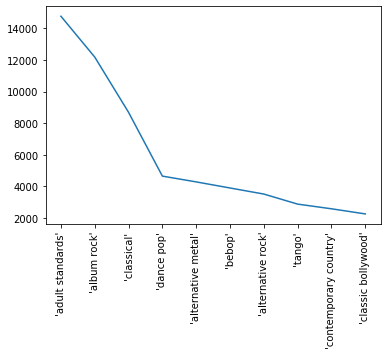

In [116]:
fig, ax = plt.subplots()
plt.xticks(rotation=90)
ax.plot(df_comb.nlargest(10,'total'))

We notice that the top genres in this column are 'album rock', 'classical', and 'dance pop'. Later, we'll come back to tracks of specific genres to see how our correlations change.

Let's first of all draw a heatmap of the correlations coefficients between the different numerical columns:

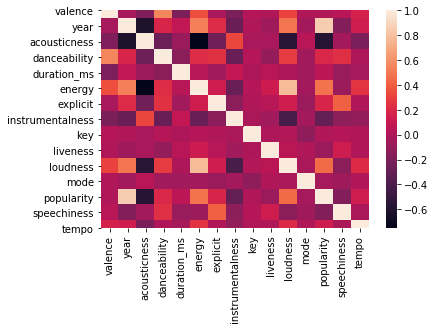

In [117]:
sns.heatmap(df_tracks_with_genres.corr())

We appear to have a strong correlation between the year the track was released and its popularity. We also have a strong correlation between the track "energy" and its popularity.
Conversely, we have a strong negative correlation between a track's acousticness and its popularity, as well as between a track's instrumentalness and it's popularity.

In [341]:
df_popularity_with_genres = df_tracks_with_genres[['genre_1','popularity']]
df_popularity_with_genres.groupby('genre_1').mean().sort_values(by='popularity',ascending=False).head(n=20)

popularity
genre_1                                                       
['latin pop', 'viral pop']                           92.000000
['cubaton', 'latin', 'pop venezolano', 'reggaet...   89.000000
['tropical house']                                   88.000000
['south african house']                              86.000000
['dance pop', 'house', 'pop', 'pop dance', 'tro...   85.500000
['basshall', 'francoton']                            85.000000
['afroswing', 'london rap', 'rap']                   85.000000
['edm', 'german dance', 'pop dance', 'pop edm',...   84.500000
['scandipop', 'swedish pop', 'tropical house']       84.000000
['australian pop', 'pop', 'uk pop']                  84.000000
['colombian pop', 'latin', 'latin pop', 'reggae...   83.333333
['edm', 'electro house', 'pop dance', 'tropical...   82.000000
['indie rockism']                                    82.000000
['colombian pop', 'latin', 'reggaeton colombiano']   81.333333
['pop r&b', 'sad rap']                               81.000000
['dutch pop']                                        81.000000
['colombian pop', 'latin', 'pop reggaeton', 're...   81.000000
['latin', 'panamanian pop', 'reggaeton', 'trap ...   81.000000
['edm', 'pop dance', 'pop edm', 'tropical house']    80.666667
['r&b en espanol']                                   80.333333

Above, we see this confirmed by taking a quick look at the top 20 genres in terms of track popularity within this dataset. They do in fact tend to be mostly "dancy" genres like "reggaeton" and "latin pop".

In [342]:
df_popularity_with_genres = df_tracks_with_genres[['genre_1','popularity']]
df_popularity_with_genres.groupby('genre_1').mean().sort_values(by='popularity',ascending=True).head(n=20)

popularity
genre_1                                                       
N/A                                                        0.0
['desi pop', 'modern bollywood']                           0.0
['dhrupad', 'hindustani vocal', 'indian classic...         0.0
['dub', 'early reggae', 'lovers rock', 'reggae'...         0.0
['dutch cabaret', 'dutch indie', 'dutch pop', '...         0.0
['early avant garde', 'screamo', 'skramz']                 0.0
['early modern classical', 'french romanticism'...         0.0
['early modern classical', 'french romanticism'...         0.0
['early modern classical', 'german opera', 'ger...         0.0
['early music', 'italian renaissance', 'renaiss...         0.0
['deep uplifting trance', 'progressive house', ...         0.0
['early music', 'madrigal', 'renaissance']                 0.0
['early romantic era', 'german romanticism']               0.0
['early romantic era', 'russian romanticism']              0.0
['esperanto']                                              0.0
['ethereal wave', 'medieval folk', 'neoclassica...         0.0
['ethnotronica', 'greek house', 'organic electr...         0.0
['euphoric hardstyle', 'hardstyle']                        0.0
['experimental indie']                                     0.0
['focus trance', 'minimal melodic techno', 'pro...         0.0

Whereas the cell above shows the bottom 20 tracks in terms of popularity, with genres more classical genres like "romanticism" and "medieval folk". However due to the granularity of the genre column conclusions are a bit limited.

Let's build a model to see if we can accurately predict a track's popularity using the Spotify calculated values:

In [118]:
# remind me what the available columns are
df_tracks_with_genres.columns

Index(['valence', 'year', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'explicit', 'id', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'name', 'popularity', 'release_date', 'speechiness',
       'tempo', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'artist_5',
       'genre_1', 'artist_1_y', 'genre_2', 'artist_2_y', 'genre_3',
       'artist_3_y', 'genre_4', 'artist_4_y', 'genre_5', 'artist_5_y'],
      dtype='object')

Below I'm creating the input data, removing things like the track name and ID. I'm also removing the year for now, which I will come back to. Then I'll break this into test and training datasets:

In [119]:
X = df_tracks_with_genres[['valence','acousticness','danceability','duration_ms','energy','explicit','instrumentalness','key','liveness','loudness','mode','speechiness','tempo']]
y = df_tracks_with_genres[['popularity']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
sc.metrics.r2_score(y_test, y_pred)

0.4524871865229938

In [120]:
len(reg.coef_[0])

13

In [121]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = reg.coef_[0]
    coefs_df['abs_coefs'] = np.abs(reg.coef_[0])
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

coeff_check = coef_weights(reg.coef_,X_train)
coeff_check

est_int         coefs     abs_coefs
11       speechiness -3.421594e+01  3.421594e+01
2       danceability  2.188359e+01  2.188359e+01
1       acousticness -2.145597e+01  2.145597e+01
0            valence -1.948614e+01  1.948614e+01
4             energy  1.086990e+01  1.086990e+01
5           explicit  9.224895e+00  9.224895e+00
6   instrumentalness -8.673283e+00  8.673283e+00
8           liveness -7.880551e+00  7.880551e+00
9           loudness  2.396114e-01  2.396114e-01
10              mode -1.000482e-01  1.000482e-01
12             tempo  2.379242e-02  2.379242e-02
7                key -6.302141e-03  6.302141e-03
3        duration_ms  7.678611e-07  7.678611e-07

Again, our linear regression model using all available Spotify metrics as inputs confirms the following: we have a strong negative correlation with "speechiness", "acousticness" and "valence", and a strong positive correlation with "danceability", "acousticness" and "energy". 
Additionally, whether or not a track is marked as "explicit" also appears to be correlated to its popularity.
Our linear model has an r_squared of 0.45 - ie 45% of the variability of the "popularity" variable can be explained and predicted through a combination of the Spotify metrics.

Let's add the release year into the mix and see how this affects things - we expect a very high coefficient, as the correlation between year and popularity was actually among the strongest. We'll add the year by creating dummy columns for all available years:

In [31]:
df_tracks_with_genres.columns

Index(['valence_x', 'year', 'acousticness_x', 'danceability_x',
       'duration_ms_x', 'energy_x', 'explicit', 'id', 'instrumentalness_x',
       'key_x',
       ...
       'instrumentalness_y', 'liveness_y', 'loudness_y', 'speechiness_y',
       'tempo_y', 'valence_y', 'popularity_y', 'key_y', 'mode_y', 'count'],
      dtype='object', length=103)

In [97]:
df_tracks_with_genres.head(n=3)

valence_x  year  acousticness_x  danceability_x  duration_ms_x  energy_x  \
0     0.0594  1921           0.982           0.279         831667     0.211   
1     0.9630  1921           0.732           0.819         180533     0.341   
2     0.0394  1921           0.961           0.328         500062     0.166   

   explicit                      id  instrumentalness_x  key_x  liveness_x  \
0         0  4BJqT0PrAfrxzMOxytFOIz               0.878     10       0.665   
1         0  7xPhfUan2yNtyFG0cUWkt8               0.000      7       0.160   
2         0  1o6I8BglA6ylDMrIELygv1               0.913      3       0.101   

   loudness_x  mode_x                                               name  \
0     -20.096       1  Piano Concerto No. 3 in D Minor, Op. 30: III. ...   
1     -12.441       1                            Clancy Lowered the Boom   
2     -14.850       1                                          Gati Bali   

   popularity_x release_date  speechiness_x  tempo_x  \
0             4         1921         0.0366   80.954   
1             5         1921         0.4150   60.936   
2             5         1921         0.0339  110.339   

                                            artist_1      artist_2  \
0                                Sergei Rachmaninoff  James Levine   
1                                         Dennis Day                 
2  KHP Kridhamardawa Karaton Ngayogyakarta Hadini...                 

                  artist_3 artist_4 artist_5  \
0  Berliner Philharmoniker                     
1                                              
2                                              

                                             genre_1  \
0  ['classical', 'post-romantic era', 'russian ro...   
1                                                 []   
2                                                 []   

                                          artist_1_y  acousticness_y  \
0                                Sergei Rachmaninoff        0.982384   
1                                         Dennis Day        0.840600   
2  KHP Kridhamardawa Karaton Ngayogyakarta Hadini...        0.837952   

   danceability_y  duration_ms_y  energy_y  instrumentalness_y  liveness_y  \
0        0.340674  261014.582090  0.144225            0.793356    0.236443   
1        0.540000  171896.200000  0.370600            0.000002    0.259680   
2        0.368810  447737.142857  0.197665            0.498736    0.148443   

   loudness_y  speechiness_y     tempo_y  valence_y  popularity_y  key_y  \
0  -20.485082       0.041968   95.200198   0.264284      4.332090    2.0   
1  -11.580400       0.132540   95.256400   0.640600      3.000000    7.0   
2  -17.178000       0.053462  108.157619   0.101700      2.428571    9.0   

   mode_y  count_x                                            genre_2  \
0     1.0    268.0  ['classical performance', 'opera', 'orchestral...   
1     1.0     10.0                                                NaN   
2     1.0     42.0                                                NaN   

     artist_2_y  acousticness_x  danceability_x  duration_ms_x  energy_x  \
0  James Levine        0.944056        0.264578  328057.111111  0.166089   
1           NaN             NaN             NaN            NaN       NaN   
2           NaN             NaN             NaN            NaN       NaN   

   instrumentalness_x  liveness_x  loudness_x  speechiness_x  tempo_x  \
0            0.446163    0.232672    -19.4915       0.048306  102.657   
1                 NaN         NaN         NaN            NaN      NaN   
2                 NaN         NaN         NaN            NaN      NaN   

   valence_x  popularity_x  key_x  mode_x  count_y  \
0   0.165772     25.833333   10.0     1.0     18.0   
1        NaN           NaN    NaN     NaN      NaN   
2        NaN           NaN    NaN     NaN      NaN   

                                             genre_3               artist_3_y  \
0  ['classical', 'classical performance', 'germa

In [122]:
df_dummy_years = pd.get_dummies(df_tracks_with_genres['year'],drop_first=True,prefix='year',prefix_sep='_')
df_tracks_with_genres.shape

(170653, 33)

In [123]:
df_dummy_years.shape

(170653, 99)

In [124]:
df_dummy_years.head(n=20)

year_1922  year_1923  year_1924  year_1925  year_1926  year_1927  \
0           0          0          0          0          0          0   
1           0          0          0          0          0          0   
2           0          0          0          0          0          0   
3           0          0          0          0          0          0   
4           0          0          0          0          0          0   
5           0          0          0          0          0          0   
6           0          0          0          0          0          0   
7           0          0          0          0          0          0   
8           0          0          0          0          0          0   
9           0          0          0          0          0          0   
10          0          0          0          0          0          0   
11          0          0          0          0          0          0   
12          0          0          0          0          0          0   
13          0          0          0          0          0          0   
14          0          0          0          0          0          0   
15          0          0          0          0          0          0   
16          0          0          0          0          0          0   
17          0          0          0          0          0          0   
18          0          0          0          0          0          0   
19          0          0          0          0          0          0   

    year_1928  year_1929  year_1930  year_1931  year_1932  year_1933  \
0           0          0          0          0          0          0   
1           0          0          0          0          0          0   
2           0          0          0          0          0          0   
3           0          0          0          0          0          0   
4           0          0          0          0          0          0   
5           0          0          0          0          0          0   
6           0          0          0          0          0          0   
7           0          0          0          0          0          0   
8           0          0          0          0          0          0   
9           0          0          0          0          0          0   
10          0          0          0          0          0          0   
11          0          0          0          0          0          0   
12          0          0          0          0          0          0   
13          0          0          0          0          0          0   
14          0          0          0          0          0          0   
15          0          0          0          0          0          0   
16          0          0          0          0          0          0   
17          0          0          0          0          0          0   
18          0          0          0          0          0          0   
19          0          0          0          0          0          0   

    year_1934  year_1935  year_1936  year_1937  year_1938  year_1939  \
0           0          0          0          0          0          0   
1           0          0          0          0          0          0   
2           0          0          0          0          0          0   
3           0          0          0          0          0          0   
4           0          0          0          0          0          0   
5           0          0          0          0          0          0   
6           0          0          0          0          0          0   
7           0          0          0          0          0          0   
8           0          0          0          0          0          0   
9           0          0          0          0          0          0   
10          0          0          0          0          0          0   
11          0          0          0          0          0          0   
12          0          0          0       

In [125]:
df_with_dummies = pd.concat([df_tracks_with_genres, df_dummy_years], axis = 1)
df_with_dummies.head(n=20)

valence  year  acousticness  danceability  duration_ms  energy  explicit  \
0    0.0594  1921        0.9820         0.279       831667  0.2110         0   
1    0.9630  1921        0.7320         0.819       180533  0.3410         0   
2    0.0394  1921        0.9610         0.328       500062  0.1660         0   
3    0.1650  1921        0.9670         0.275       210000  0.3090         0   
4    0.2530  1921        0.9570         0.418       166693  0.1930         0   
5    0.1960  1921        0.5790         0.697       395076  0.3460         0   
6    0.4060  1921        0.9960         0.518       159507  0.2030         0   
7    0.0731  1921        0.9930         0.389       218773  0.0880         0   
8    0.7210  1921        0.9960         0.485       161520  0.1300         0   
9    0.7710  1921        0.9820         0.684       196560  0.2570         0   
10   0.8260  1921        0.9950         0.463       147133  0.2600         0   
11   0.5780  1921        0.9940         0.378       155413  0.1150         0   
12   0.4930  1921        0.9900         0.315       190800  0.3630         0   
13   0.2120  1921        0.9120         0.415       184973  0.4200         0   
14   0.4930  1921        0.0175         0.527       205072  0.6910         1   
15   0.2820  1921        0.9890         0.384       221013  0.1710         0   
16   0.2180  1921        0.9570         0.259       186467  0.2120         0   
17   0.6640  1921        0.9960         0.541       250747  0.2830         0   
18   0.0778  1921        0.1480         0.604       204957  0.4180         1   
19   0.5270  1921        0.9710         0.540       122000  0.0848         0   

                        id  instrumentalness  key  liveness  loudness  mode  \
0   4BJqT0PrAfrxzMOxytFOIz          0.878000   10    0.6650   -20.096     1   
1   7xPhfUan2yNtyFG0cUWkt8          0.000000    7    0.1600   -12.441     1   
2   1o6I8BglA6ylDMrIELygv1          0.913000    3    0.1010   -14.850     1   
3   3ftBPsC5vPBKxYSee08FDH          0.000028    5    0.3810    -9.316     1   
4   4d6HGyGT8e121BsdKmw9v6          0.000002    3    0.2290   -10.096     1   
5   4pyw9DVHGStUre4J6hPngr          0.168000    2    0.1300   -12.506     1   
6   5uNZnElqOS3W4fRmRYPk4T          0.000000    0    0.1150   -10.589     1   
7   02GDntOXexBFUvSgaXLPkd          0.527000    1    0.3630   -21.091     0   
8   05xDjWH9ub67nJJk82yfGf          0.151000    5    0.1040   -21.508     0   
9   08zfJvRLp7pjAb94MA9JmF          0.000000    8    0.5040   -16.415     1   
10  0BMkRpQtDoKjcgzCpnqLNa          0.000000    9    0.2580   -16.894     1   
11  0F30WM8qRpO8kdolepZqdM          0.906000   10    0.1100   -27.039     0   
12  0H3k2CvJvHULnWChlbeFgx          0.000000    5    0.2920   -12.562     0   
13  0LcXzABeA84EgudqpNUN1I          0.890000    8    0.1080   -10.766     0   
14  0MJZ4hh60zwsYleWWxT5yW          0.384000    7    0.3580    -7.298     1   
15  0NFeJgmTAV1kDfzSQNK41Z          0.820000    7    0.1160   -20.476     0   
16  0Nk5f07H3JaEunGrYfbqHM          0.000222    2    0.2360   -13.300     1   
17  0POO8XaUgW5Qjbv9sbDy8W          0.898000    9    0.3930   -14.808     1   
18  0QQmUf4aPFaN9U2yRko595          0.038200    4    0.1020   -11.566     0   
19  0QU5xT6Mik4vpyt1ItsRXK          0.001960    5    0.0887   -16.055     0   

                                                 name  popularity  \
0   Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4   
1                             Clancy Lowered the Boom           5   
2                                           Gati Bali           5   
3                                           Danny Boy           3   
4                         When Irish Eyes Are Smiling           2   
5                                        Gati Mardika           6   
6                            The Wearing of the Green           4   
7   Morceaux de fantaisie, Op. 3: No. 2, Prélude i...           2   
8                         La Mañanita - Re

In [76]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
pd.options.display.max_rows

200

In [89]:
df_with_dummies.shape

(170653, 202)

In [126]:
df_with_dummies.head()

valence  year  acousticness  danceability  duration_ms  energy  explicit  \
0   0.0594  1921         0.982         0.279       831667   0.211         0   
1   0.9630  1921         0.732         0.819       180533   0.341         0   
2   0.0394  1921         0.961         0.328       500062   0.166         0   
3   0.1650  1921         0.967         0.275       210000   0.309         0   
4   0.2530  1921         0.957         0.418       166693   0.193         0   

                       id  instrumentalness  key  liveness  loudness  mode  \
0  4BJqT0PrAfrxzMOxytFOIz          0.878000   10     0.665   -20.096     1   
1  7xPhfUan2yNtyFG0cUWkt8          0.000000    7     0.160   -12.441     1   
2  1o6I8BglA6ylDMrIELygv1          0.913000    3     0.101   -14.850     1   
3  3ftBPsC5vPBKxYSee08FDH          0.000028    5     0.381    -9.316     1   
4  4d6HGyGT8e121BsdKmw9v6          0.000002    3     0.229   -10.096     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   
2                                          Gati Bali           5         1921   
3                                          Danny Boy           3         1921   
4                        When Irish Eyes Are Smiling           2         1921   

   speechiness    tempo                                           artist_1  \
0       0.0366   80.954                                Sergei Rachmaninoff   
1       0.4150   60.936                                         Dennis Day   
2       0.0339  110.339  KHP Kridhamardawa Karaton Ngayogyakarta Hadini...   
3       0.0354  100.109                                       Frank Parker   
4       0.0380  101.665                                         Phil Regan   

       artist_2                 artist_3 artist_4 artist_5  \
0  James Levine  Berliner Philharmoniker                     
1                                                            
2                                                            
3                                                            
4                                                            

                                             genre_1  \
0  ['classical', 'post-romantic era', 'russian ro...   
1                                                 []   
2                                                 []   
3                                                 []   
4                                                 []   

                                          artist_1_y  \
0                                Sergei Rachmaninoff   
1                                         Dennis Day   
2  KHP Kridhamardawa Karaton Ngayogyakarta Hadini...   
3                                       Frank Parker   
4                                         Phil Regan   

                                             genre_2    artist_2_y  \
0  ['classical performance', 'opera', 'orchestral...  James Levine   
1                                                NaN           NaN   
2                                                NaN           NaN   
3                                                NaN           NaN   
4                                                NaN           NaN   

                                             genre_3               artist_3_y  \
0  ['classical', 'classical performance', 'german...  Berliner Philharmoniker   
1                                                NaN                      NaN   
2                                                NaN                      NaN   
3                                                NaN                      NaN   
4                                                NaN                      NaN   

  genre_4 artist_4_y genre_5 artist_5_y  year_1922  year_1923  year_1924  \
0     NaN        NaN     NaN        NaN          0          0          0

In [127]:
for i in range(5):
    column_name = 'artist_'+ str(i+1)
    column_name_2 = 'artist_' + str(i+1) + '_y'
    column_name_3 = 'genre_' + str(i+1)
    df_with_dummies = df_with_dummies.drop([column_name,column_name_2,column_name_3],axis=1)

In [133]:
X = df_with_dummies.drop(['name','year','id','name','release_date','popularity'], axis = 1)
Y = df_with_dummies['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
sc.metrics.r2_score(y_test, y_pred)

0.7898819162651358

We see here that we have a much higher r squared when we add the year the track was released into the model. This indicates that the release year has a strong impact on the track's popularity.
Let's look at the coefficients again:

In [134]:
coeff_check = coef_weights(reg.coef_,X_train)
coeff_check

est_int         coefs     abs_coefs
110         year_2019  6.286182e+01  6.286182e+01
111         year_2020  6.088081e+01  6.088081e+01
108         year_2017  6.066970e+01  6.066970e+01
109         year_2018  6.035531e+01  6.035531e+01
107         year_2016  5.690386e+01  5.690386e+01
106         year_2015  5.392875e+01  5.392875e+01
105         year_2014  5.267172e+01  5.267172e+01
104         year_2013  5.156279e+01  5.156279e+01
102         year_2011  5.083568e+01  5.083568e+01
101         year_2010  5.039044e+01  5.039044e+01
103         year_2012  4.987417e+01  4.987417e+01
100         year_2009  4.902947e+01  4.902947e+01
97          year_2006  4.877234e+01  4.877234e+01
98          year_2007  4.861001e+01  4.861001e+01
96          year_2005  4.836070e+01  4.836070e+01
99          year_2008  4.808492e+01  4.808492e+01
95          year_2004  4.672587e+01  4.672587e+01
92          year_2001  4.623206e+01  4.623206e+01
94          year_2003  4.619076e+01  4.619076e+01
93          year_2002  4.604186e+01  4.604186e+01
90          year_1999  4.495133e+01  4.495133e+01
91          year_2000  4.443048e+01  4.443048e+01
89          year_1998  4.345857e+01  4.345857e+01
88          year_1997  4.302734e+01  4.302734e+01
85          year_1994  4.293120e+01  4.293120e+01
86          year_1995  4.282022e+01  4.282022e+01
87          year_1996  4.273573e+01  4.273573e+01
84          year_1993  4.083485e+01  4.083485e+01
83          year_1992  4.082960e+01  4.082960e+01
82          year_1991  3.951878e+01  3.951878e+01
81          year_1990  3.859106e+01  3.859106e+01
78          year_1987  3.780704e+01  3.780704e+01
79          year_1988  3.759967e+01  3.759967e+01
80          year_1989  3.735309e+01  3.735309e+01
75          year_1984  3.598014e+01  3.598014e+01
77          year_1986  3.547387e+01  3.547387e+01
76          year_1985  3.514430e+01  3.514430e+01
74          year_1983  3.476249e+01  3.476249e+01
64          year_1973  3.445733e+01  3.445733e+01
73          year_1982  3.429714e+01  3.429714e+01
71          year_1980  3.413677e+01  3.413677e+01
69          year_1978  3.400279e+01  3.400279e+01
70          year_1979  3.400143e+01  3.400143e+01
72          year_1981  3.397570e+01  3.397570e+01
67          year_1976  3.390376e+01  3.390376e+01
68          year_1977  3.365147e+01  3.365147e+01
66          year_1975  3.282606e+01  3.282606e+01
62          year_1971  3.277164e+01  3.277164e+01
61          year_1970  3.259599e+01  3.259599e+01
63          year_1972  3.255930e+01  3.255930e+01
60          year_1969  3.125335e+01  3.125335e+01
65          year_1974  3.052835e+01  3.052835e+01
58          year_1967  2.958398e+01  2.958398e+01
59          year_1968  2.954963e+01  2.954963e+01
57          year_1966  2.623788e+01  2.623788e+01
56          year_1965  2.564386e+01  2.564386e+01
55          year_1964  2.521459e+01  2.521459e+01
54          year_1963  2.398250e+01  2.398250e+01
53          year_1962  2.046131e+01  2.046131e+01
50          year_1959  1.941721e+01  1.941721e+01
48          year_1957  1.871741e+01  1.871741e+01
52          year_1961  1.857525e+01  1.857525e+01
51          year_1960  1.831339e+01  1.831339e+01
49          year_1958  1.779913e+01  1.779913e+01
47          year_1956  1.455336e+01  1.455336e+01
46          year_1955  9.058751e+00  9.058751e+00
45          year_1954  7.111578e+00  7.111578e+00
24          year_1933  5.353225e+00  5.353225e+00
14          year_1923  5.221990e+00  5.221990e+00
11        speechiness -4.972575e+00  4.972575e+00
27          year_1936  4.861347e+00  4.861347e+00
35          year_1944  3.760014e+00  3.760014e+00
30          year_1939  3.604589e+00  3.604589e+00
40          year_1949  3.306778e+00  3.306778e+00
6    instrumentalness -2.862207e+00  2.862207e+00
44          year_1953  2.851288e+00  2.851288e+00
8            liveness -2.791979e+00  2.791979e+00
43          year_1952  2.756418e+00  2.756418e+00
41          year_1950  2.535800e+00  2.535800e+00
42          ye

Indeed, we see that the more recently a track was released, the higher its popularity - this is not surprising considering how the popularity score is calculated, but interesting nonetheless.

Another question we might ask is, how do the different correlations evolve based on the track release year?
Let's look at the most heavily correlated inputs: acousticness,danceability,energy,explicit,loudness

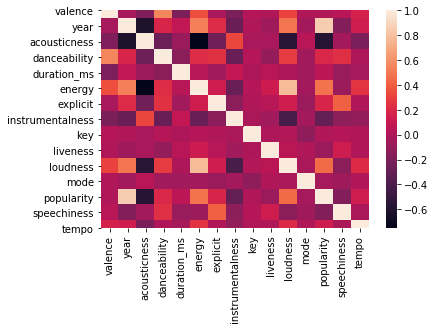

In [137]:
sns.heatmap(df_tracks_with_genres.corr())

In [157]:
#explicitness:
df_explicit = pd.DataFrame()
for year in range(1921,2021):
    df_truncated = df_tracks_with_genres[df_tracks_with_genres['year'] == year]
    df_correlation = df_truncated[['popularity','explicit']].corr()
    df_explicit[year] = df_correlation['popularity']
    
df_explicit = df_explicit.transpose()

In [161]:
#acousticness:
df_acoustic = pd.DataFrame()
for year in range(1921,2021):
    df_truncated = df_tracks_with_genres[df_tracks_with_genres['year'] == year]
    df_correlation = df_truncated[['popularity','acousticness']].corr()
    df_acoustic[year] = df_correlation['popularity']

df_acoustic = df_acoustic.transpose()

In [ ]:
#danceability:
df_danceable = pd.DataFrame()
for year in range(1921,2021):
    df_truncated = df_tracks_with_genres[df_tracks_with_genres['year'] == year]
    df_correlation = df_truncated[['popularity','danceability']].corr()
    df_danceable[year] = df_correlation['popularity']

df_danceable = df_danceable.transpose()

In [168]:
#energy:
df_energy = pd.DataFrame()
for year in range(1921,2021):
    df_truncated = df_tracks_with_genres[df_tracks_with_genres['year'] == year]
    df_correlation = df_truncated[['popularity','energy']].corr()
    df_energy[year] = df_correlation['popularity']

df_energy = df_energy.transpose()

In [169]:
#loudness:
df_loudness = pd.DataFrame()
for year in range(1921,2021):
    df_truncated = df_tracks_with_genres[df_tracks_with_genres['year'] == year]
    df_correlation = df_truncated[['popularity','loudness']].corr()
    df_loudness[year] = df_correlation['popularity']

df_loudness = df_loudness.transpose()

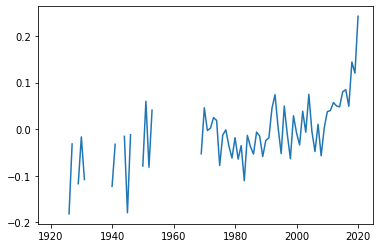

In [165]:
fig, ax = plt.subplots()
ax.plot(df_explicit['explicit'])

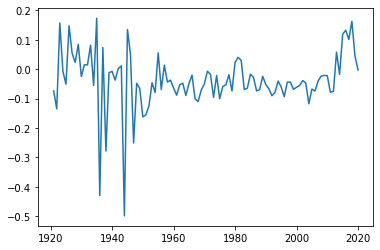

In [166]:
fig, ax = plt.subplots()
ax.plot(df_acoustic['acousticness'])

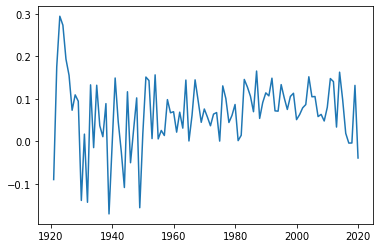

In [170]:
fig, ax = plt.subplots()
ax.plot(df_loudness['loudness'])

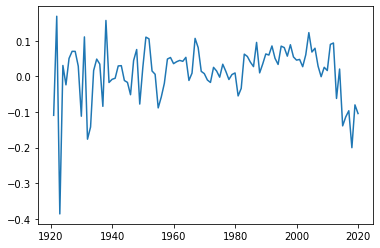

In [171]:
fig, ax = plt.subplots()
ax.plot(df_energy['energy'])

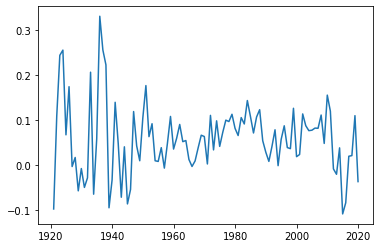

In [172]:
fig, ax = plt.subplots()
ax.plot(df_danceable['danceability'])

Let's have a go with just tracks that have 'classical' in the genre_1 column. First, we need to create that dataset:

In [175]:
df_classical_tracks = df_tracks_with_genres[df_tracks_with_genres['genre_1'].str.contains('classical')]

In [178]:
df_classical_tracks.shape

(12794, 33)

In [176]:
X = df_classical_tracks[['valence','acousticness','danceability','duration_ms','energy','explicit','instrumentalness','key','liveness','loudness','mode','speechiness','tempo']]
y = df_classical_tracks[['popularity']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
sc.metrics.r2_score(y_test, y_pred)

0.1650507509316229

In [ ]:
Might be a lower r-squared because of the smaller dataset. Let's look at the correlation coefficients:

In [179]:
coeff_check = coef_weights(reg.coef_,X_train)
coeff_check

est_int         coefs     abs_coefs
1       acousticness -3.146571e+01  3.146571e+01
5           explicit  3.114641e+01  3.114641e+01
4             energy  1.291151e+01  1.291151e+01
8           liveness -1.136989e+01  1.136989e+01
11       speechiness -8.671941e+00  8.671941e+00
2       danceability -3.120098e+00  3.120098e+00
6   instrumentalness  1.738344e+00  1.738344e+00
10              mode -1.090748e+00  1.090748e+00
9           loudness -7.367451e-01  7.367451e-01
7                key -1.122659e-01  1.122659e-01
0            valence -5.607975e-02  5.607975e-02
12             tempo  2.255188e-02  2.255188e-02
3        duration_ms  5.641974e-07  5.641974e-07

Here we see that danceability is now negatively correlated. We also see that explicitness is positively correlated, which points out the limitations of this analysis (what's an explicit classical track?)

Let's have a go with just tracks that have 'adult standards' in the genre_1 column. First, we need to create that dataset:

In [180]:
df_adult_standards = df_tracks_with_genres[df_tracks_with_genres['genre_1'].str.contains('adult standards')]

In [181]:
df_adult_standards.shape

(14800, 33)

In [182]:
X = df_adult_standards[['valence','acousticness','danceability','duration_ms','energy','explicit','instrumentalness','key','liveness','loudness','mode','speechiness','tempo']]
y = df_adult_standards[['popularity']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
sc.metrics.r2_score(y_test, y_pred)

0.15151218885591

Might be a lower r-squared because of the smaller dataset. Let's look at the correlation coefficients:

In [184]:
coeff_check = coef_weights(reg.coef_,X_train)
coeff_check

est_int      coefs  abs_coefs
11       speechiness -21.410754  21.410754
1       acousticness -14.128893  14.128893
4             energy  13.452653  13.452653
5           explicit  13.299901  13.299901
6   instrumentalness  -9.835791   9.835791
8           liveness  -9.290904   9.290904
0            valence  -8.017715   8.017715
2       danceability   6.217002   6.217002
10              mode   1.285695   1.285695
9           loudness  -0.247669   0.247669
7                key   0.015860   0.015860
12             tempo   0.001589   0.001589
3        duration_ms   0.000015   0.000015

Here we see that danceability is now negatively correlated. We also see that explicitness is positively correlated, which points out the limitations of this analysis (what's an explicit classical track?)

Let's have a go with just tracks that have 'pop' in the genre_1 column. First, we need to create that dataset:

In [185]:
df_pop_tracks = df_tracks_with_genres[df_tracks_with_genres['genre_1'].str.contains('pop')]

In [186]:
df_pop_tracks.shape

(45042, 33)

In [187]:
X = df_pop_tracks[['valence','acousticness','danceability','duration_ms','energy','explicit','instrumentalness','key','liveness','loudness','mode','speechiness','tempo']]
y = df_pop_tracks[['popularity']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
sc.metrics.r2_score(y_test, y_pred)

0.36867946012556996

In [ ]:
Might be a lower r-squared because of the smaller dataset. Let's look at the correlation coefficients:

In [188]:
coeff_check = coef_weights(reg.coef_,X_train)
coeff_check

est_int      coefs  abs_coefs
2       danceability  27.823029  27.823029
0            valence -23.963726  23.963726
11       speechiness -15.170827  15.170827
1       acousticness -14.596796  14.596796
6   instrumentalness  -9.473604   9.473604
8           liveness  -7.292525   7.292525
5           explicit   5.536701   5.536701
4             energy   1.969830   1.969830
9           loudness   1.034690   1.034690
10              mode  -0.448868   0.448868
12             tempo   0.032220   0.032220
7                key  -0.011686   0.011686
3        duration_ms  -0.000001   0.000001

Here we see that danceability is now positively correlated. It actually seems like the main thing to look for in a pop track.

In [200]:
df_tracks_with_genres[df_tracks_with_genres['year'] == 2020].sample(n=5)

valence  year  acousticness  danceability  duration_ms  energy  \
140843   0.4200  2020       0.20900         0.649       203322   0.640   
124763   0.6200  2020       0.06200         0.754       233160   0.796   
108818   0.0653  2020       0.05350         0.809       146009   0.680   
140774   0.4150  2020       0.00541         0.493       222880   0.266   
170468   0.3470  2020       0.11400         0.823       190476   0.586   

        explicit                      id  instrumentalness  key  liveness  \
140843         0  0vK1vDEvEMvSpFEKW62Qub          0.000532    6    0.0965   
124763         0  2uu2aGqA2UblCg581Q7l1g          0.000086    3    0.2040   
108818         1  5esKpsrB3TbGHwFaAjIGMx          0.000001    4    0.1100   
140774         1  743D1OV0eyJSGlUQHkgGD6          0.000000   10    0.3230   
170468         1  6IParsannfwoLCcNSfxQPh          0.000000    6    0.1930   

        loudness  mode                                          name  \
140843    -6.090     1                                      Lose You   
124763    -3.743     0                              Caramelo - Remix   
108818    -4.883     1  Move Ya Hips (feat. Nicki Minaj & MadeinTYO)   
140774   -18.551     1                                    My Kitchen   
170468    -6.606     0       For The Night (feat. Lil Baby & DaBaby)   

        popularity release_date  speechiness    tempo      artist_1  \
140843          66   2020-10-16       0.0352   94.957  Jordan Davis   
124763          82   2020-08-17       0.1390  168.045         Ozuna   
108818          70   2020-07-30       0.2220  143.988     A$AP Ferg   
140774          42   2020-11-19       0.4530  154.982    Gucci Mane   
170468          69   2020-07-20       0.2000  125.971     Pop Smoke   

           artist_2     artist_3 artist_4 artist_5  \
140843                                               
124763      KAROL G  Myke Towers                     
108818  Nicki Minaj    MadeinTYO                     
140774                                               
170468     Lil Baby       DaBaby                     

                                                  genre_1    artist_1_y  \
140843                           ['contemporary country']  Jordan Davis   
124763  ['latin', 'puerto rican pop', 'reggaeton', 'tr...         Ozuna   
108818  ['hip hop', 'pop rap', 'rap', 'southern hip ho...     A$AP Ferg   
140774  ['atl hip hop', 'dirty south rap', 'gangster r...    Gucci Mane   
170468                                 ['brooklyn drill']     Pop Smoke   

                                                  genre_2   artist_2_y  \
140843                                                NaN          NaN   
124763  ['latin', 'latin pop', 'reggaeton', 'reggaeton...      KAROL G   
108818  ['dance pop', 'hip pop', 'pop', 'pop dance', '...  Nicki Minaj   
140774                                                NaN          NaN   
170468                 ['atl hip hop', 'atl trap', 'rap']     Lil Baby   

                                                  genre_3   artist_3_y  \
140843                                                NaN          NaN   
124763                                    ['trap latino']  Myke Towers   
108818  ['atl hip hop', 'hip hop', 'melodic rap', 'pop...    MadeinTYO   
140774                                                NaN          NaN   
170468                  ['north carolina hip hop', 'rap']       DaBaby   

       genre_4 artist_4_y genre_5 artist_5_y  
140843     NaN        NaN     NaN        NaN  
124763     NaN        NaN     NaN        NaN  
108818     NaN        NaN     NaN        NaN  
140774     NaN        NaN     NaN        NaN  
170468     NaN        NaN     NaN        NaN

In [197]:
df_tracks_with_genres[df_tracks_with_genres['id'] == '27ycaQnQAxaPiyeg3nr2aB']

valence  year  acousticness  danceability  duration_ms  energy  \
19643    0.259  2020       0.00115         0.705       223279   0.814   

       explicit                      id  instrumentalness  key  liveness  \
19643         0  27ycaQnQAxaPiyeg3nr2aB           0.00312    4     0.203   

       loudness  mode          name  popularity release_date  speechiness  \
19643    -5.466     0  Midnight Sky          91   2020-08-14       0.0346   

       tempo     artist_1 artist_2 artist_3 artist_4 artist_5  \
19643  110.0  Miley Cyrus                                       

                                                 genre_1   artist_1_y genre_2  \
19643  ['dance pop', 'pop', 'pop dance', 'post-teen p...  Miley Cyrus     NaN   

      artist_2_y genre_3 artist_3_y genre_4 artist_4_y genre_5 artist_5_y  
19643        NaN     NaN        NaN     NaN        NaN     NaN        NaN

In [194]:
X = df_tracks_with_genres[['valence','acousticness','danceability','duration_ms','energy','explicit','instrumentalness','key','liveness','loudness','mode','speechiness','tempo']]
y = df_tracks_with_genres[['popularity']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
sc.metrics.r2_score(y_test, y_pred)

0.4524871865229938

In [202]:
X_midnight_sky = df_tracks_with_genres[df_tracks_with_genres['id'] == '0vK1vDEvEMvSpFEKW62Qub'][['valence','acousticness','danceability','duration_ms','energy','explicit','instrumentalness','key','liveness','loudness','mode','speechiness','tempo']]
midnight_sky_prediction = reg.predict(X_midnight_sky)
midnight_sky_prediction

array([[48.42378104]])

In [203]:
X_lose_you = df_tracks_with_genres[df_tracks_with_genres['id'] == '27ycaQnQAxaPiyeg3nr2aB'][['valence','acousticness','danceability','duration_ms','energy','explicit','instrumentalness','key','liveness','loudness','mode','speechiness','tempo']]
lose_you_prediction = reg.predict(X_lose_you)
lose_you_prediction

array([[58.93172445]])

In [205]:
X_my_kitchen = df_tracks_with_genres[df_tracks_with_genres['id'] == '743D1OV0eyJSGlUQHkgGD6'][['valence','acousticness','danceability','duration_ms','energy','explicit','instrumentalness','key','liveness','loudness','mode','speechiness','tempo']]
my_kitchen_prediction = reg.predict(X_my_kitchen)
my_kitchen_prediction

array([[36.9915453]])

In [ ]:
X_midnight_sky = df_tracks_with_genres[df_tracks_with_genres['id'] == '0vK1vDEvEMvSpFEKW62Qub'][['valence','acousticness','danceability','duration_ms','energy','explicit','instrumentalness','key','liveness','loudness','mode','speechiness','tempo']]
midnight_sky_prediction =

References:
    - Found this article later - he doesn't use a linear regression but gets a very similar result with his graphs! https://towardsdatascience.com/what-makes-a-song-likeable-dbfdb7abe404#:~:text=The%20Spotify%20Web%20API%20developer,beat%20strength%2C%20and%20overall%20regularity.&text=Tempo%3A%20The%20overall%20estimated%20tempo,beats%20per%20minute%20(BPM).
    - Used this solution for some grouping problem: https://github.com/softhints/python/blob/master/notebooks/pandas/Pandas_count_values_in_a_column_of_type_list.ipynb

In [362]:
type(X)

NoneType

Next: 
- Pick a few genres and look at how things change
- Add year as a category
- Select a few years and also check how things change

# Test shit below

In [283]:
df_all_genres.head()

0                     1                       2   \
0  'classical'   'post-romantic era'   'russian romanticism'   
1                               None                    None   
2                               None                    None   
3                               None                    None   
4                               None                    None   

                       3     4     5     6     7     8     9   ...    13  \
0   'ukrainian classical'  None  None  None  None  None  None  ...  None   
1                    None  None  None  None  None  None  None  ...  None   
2                    None  None  None  None  None  None  None  ...  None   
3                    None  None  None  None  None  None  None  ...  None   
4                    None  None  None  None  None  None  None  ...  None   

     14    15    16    17    18    19    20    21    22  
0  None  None  None  None  None  None  None  None  None  
1  None  None  None  None  None  None  None  None  None  
2  None  None  None  None  None  None  None  None  None  
3  None  None  None  None  None  None  None  None  None  
4  None  None  None  None  None  None  None  None  None  

[5 rows x 23 columns]

In [278]:
df_all_genres = df_all_genres.dropna(how='all')
df_all_genres.shape

(170653, 23)

In [279]:
df_all_genres_per = df_all_genres.fillna(0).apply(lambda x: pd.value_counts(x, normalize=True))
df_all_genres_per['total'] = df_all_genres_per.sum(axis=1)

In [280]:
df_all_genres_per['total'].sort_values(ascending = False)

0                      18.467932
 'rock'                 0.139066
                        0.103051
 'classic rock'         0.086773
'adult standards'       0.086509
                         ...    
'classic afrobeat'      0.000006
'circus'                0.000006
'circuit'               0.000006
'christmas product'     0.000006
 'warm drone'           0.000006
Name: total, Length: 4073, dtype: float64

In [242]:
df_all_genres_per.sort_values('total', ascending=False)['total'].head(10)

0                         9.596680
'classical'               0.419434
 'italian romanticism'    0.209961
 'italian opera'          0.209473
 'late romantic era'      0.202637
 'post-romantic era'      0.104004
 'german romanticism'     0.096191
                          0.085938
 'classical era'          0.073730
'broadway'                0.062988
Name: total, dtype: float64

In [98]:
# df_tracks_with_genres.genres.value_counts().index[0]
# df_tracks_with_genres_no_empties = df_tracks_with_genres[df_tracks_with_genres['genres'] != '[]']
# df_tracks_with_genres_empties = df_tracks_with_genres[df_tracks_with_genres['genres'] == '[]']

In [234]:
genre_counts = df_all_genres_per['total']
genre_counts.drop()

                       0.085938
'acoustic blues'       0.008301
'adult standards'      0.036621
'alabama rap'          0.000488
'album rock'           0.000977
                         ...   
 'rock-and-roll'       0.003906
 'spiritual jazz'      0.000488
 'trap queen'          0.000488
 'stomp and holler'    0.000488
 'traditional folk'    0.000488
Name: total, Length: 447, dtype: float64

In [290]:
genre_counts.nlargest(100)

0                         9.596680
'classical'               0.419434
 'italian romanticism'    0.209961
 'italian opera'          0.209473
 'late romantic era'      0.202637
                            ...   
'cali rap'                0.004883
 'urban contemporary'     0.004883
 'czech classical'        0.004883
'big band'                0.004883
 'soul blues'             0.004883
Name: total, Length: 100, dtype: float64

In [292]:
df_comb.nlargest(10,'total')

total
                        17586
'adult standards'       14763
'album rock'            12181
'classical'              8686
'dance pop'              4652
'alternative metal'      4286
'bebop'                  3901
'alternative rock'       3517
'tango'                  2881
'contemporary country'   2585

In [239]:
plt.bar(genre_counts)

TypeError: bar() missing 1 required positional argument: 'height'

In [221]:
type(df_tracks_with_genres_no_empties.genres.value_counts())

pandas.core.series.Series

In [222]:
df_tracks_with_genres_no_empties.genres.value_counts()

['tango', 'vintage tango']                                                                                 2639
['adult standards', 'easy listening', 'lounge']                                                             884
['adult standards', 'easy listening', 'lounge', 'vocal jazz']                                               712
['classical', 'classical era']                                                                              674
['adult standards', 'harlem renaissance', 'jazz blues', 'lounge', 'soul', 'torch song', 'vocal jazz']       643
                                                                                                           ... 
['acid house', 'detroit techno', 'electro', 'proto-techno', 'techno']                                         1
['ccm', 'christian indie', 'christian uplift', 'deep ccm', 'indiecoustica', 'roots worship', 'worship']       1
['electro swing', 'nu jazz', 'swing', 'swing revival']                                                  

In [101]:
df_tracks_with_genres_empties.shape[0]/df_tracks_with_genres.shape[0]

0.11191231035413896

We can't get a whole lot of info from the added genres. Firstly, about 11% of tracks were created by artists who do not have a genre assigned. Secondly, each artist has a collection of genres, thus there is high granularity in this category, making it difficult to conclude much here.
However, we can say 

In [60]:
df_genres['genres']

0                                           ['show tunes']
1                                                       []
2                                                       []
3                                                       []
4                                                       []
                               ...                        
28675                                                   []
28676    ['c-pop', 'classic cantopop', 'classic mandopo...
28677                                                   []
28678              ['chinese indie', 'chinese indie rock']
28679                               ['classic korean pop']
Name: genres, Length: 28680, dtype: object

Now that we have a column in df with individual artists, we can join with the df_genres table to obtain a table with the genre(s) for each track:

In [110]:
df_genres_only = pd.read_csv('data_by_genres.csv')
df_genres_only

mode                  genres  acousticness  danceability   duration_ms  \
0        1  21st century classical      0.979333      0.162883  1.602977e+05   
1        1                   432hz      0.494780      0.299333  1.048887e+06   
2        1                   8-bit      0.762000      0.712000  1.151770e+05   
3        1                      []      0.651417      0.529093  2.328809e+05   
4        1              a cappella      0.676557      0.538961  1.906285e+05   
...    ...                     ...           ...           ...           ...   
2968     1                    zolo      0.222625      0.547082  2.580991e+05   
2969     0                 zouglou      0.161000      0.863000  2.063200e+05   
2970     1                    zouk      0.263261      0.748889  3.060728e+05   
2971     0            zurich indie      0.993000      0.705667  1.984173e+05   
2972     1                  zydeco      0.421038      0.629409  1.716717e+05   

        energy  instrumentalness  liveness   loudness  speechiness  \
0     0.071317          0.606834  0.361600 -31.514333     0.040567   
1     0.450678          0.477762  0.131000 -16.854000     0.076817   
2     0.818000          0.876000  0.126000  -9.180000     0.047000   
3     0.419146          0.205309  0.218696 -12.288965     0.107872   
4     0.316434          0.003003  0.172254 -12.479387     0.082851   
...        ...               ...       ...        ...          ...   
2968  0.610240          0.143872  0.204206 -11.295878     0.061088   
2969  0.909000          0.000000  0.108000  -5.985000     0.081300   
2970  0.622444          0.257227  0.089678 -10.289222     0.038778   
2971  0.172667          0.468633  0.179667 -11.453333     0.348667   
2972  0.609369          0.019248  0.255877  -9.854825     0.050491   

           tempo   valence  popularity  key  
0      75.336500  0.103783   27.833333    6  
1     120.285667  0.221750   52.500000    5  
2     133.444000  0.975000   48.000000    7  
3     112.857352  0.513604   20.859882    7  
4     112.110362  0.448249   45.820071    7  
...          ...       ...         ...  ...  
2968  125.494919  0.596155   33.778943    9  
2969  119.038000  0.845000   58.000000    7  
2970  101.965222  0.824111   46.666667    5  
2971   91.278000  0.739000    0.000000    7  
2972  126.366087  0.808544   30.261905    7  

[2973 rows x 14 columns]

In [178]:
df.shape

(170653, 19)

In [164]:
artists_expanded = pd.DataFrame(columns=['artist_1','artist_2','artist_3','artist_4','artist_5'])
track_artists_expanded = ast.literal_eval(df['artists'][0])
track_artists_expanded
data = []
values = []
for i in range(5):
    #column_name = 'artist_' + str(i+1)
    try:
        values.append(track_artists_expanded[i])
        #artists_expanded[column_name][i] = track_artists_expanded[i]
    except:
        values.append("")
    zipped = zip(artists_expanded.columns,values)
    artists_dict = dict(zipped)
artists_expanded = artists_expanded.append(artists_dict,True)

In [165]:
artists_expanded

artist_1      artist_2                 artist_3 artist_4  \
0  Sergei Rachmaninoff  James Levine  Berliner Philharmoniker            

  artist_5  
0

In [143]:
test_df = pd.DataFrame(columns=['fuck','you'])

In [144]:
test_df['fuck'][0] = 1

IndexError: index 0 is out of bounds for axis 0 with size 0

In [16]:
total_null_counts['valence']
null_columns = {}
type(null_columns)
type(total_null_counts)

pandas.core.series.Series

In [27]:
practice_dict = {'Suck':3,'Cock':2}
practice_dict['Cock']
practice_series = pd.Series(practice_dict)
practice_series
practice_dict

{'Suck': 3, 'Cock': 2}